# Uk Job Salary Prediction

## Preprocessing

In [ ]:
from sklearn.decomposition  import  PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc


### Utilities

In [ ]:
def calc_mae_rmse(y_true, y_pred) -> tuple:
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred, squared=True)
  rmse = np.sqrt(mse)
  return (mae, rmse)

### Loading dataset

In [ ]:
# if you don't want to upload Training data set to colab every time
# create a folder under your google drive root, called: "CS 4662"
# upload the data set there
# then run this cell to mount your google drive & cd to that folder

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd "/content/drive/MyDrive/CS 4662"

Mounted at /content/drive/
/content/drive/MyDrive/CS 4662


In [ ]:
df_raw = pd.read_csv('Train_rev1.csv')

# randomly select 1% of the dataset to
# save training time while testing with different models
# comment out following 2 lines to train with entire dataset
df_raw = df_raw.sample(frac=0.01)
gc.collect()


print(df_raw.shape)

(2448, 12)


## Pick only one of following data preprocessing methods (use method C only)

### Data preprocessing method A (method A) Label Encoding:

In [ ]:
def preprocess_raw_df(df_raw, feature_cols_raw, label_col_raw):
    # processing on feature_cols_raw & label_col_raw
    # replace all empty cells to 'Unknown
    df_tmp = df_raw[[*feature_cols_raw, label_col_raw]]
    df_tmp.loc[:].replace(np.nan, 'Unknown', inplace=True)

    # replace all str with int
    for col in feature_cols_raw:
        unique = np.sort(df_tmp[col].unique())
        updated_col = df_tmp[col].replace(unique, list(range(len(unique))))
        df_tmp[col] = updated_col.values

    return df_tmp


In [ ]:
# use int index to repreasent feature column value
# df size will not change, but all string become int
df = preprocess_raw_df(
    df_raw,
    ['LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category'],
    'SalaryNormalized'
)

df.head()

<ipython-input-14-379ee4929c3d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp[col] = updated_col.values


,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized
0,750,0,2,7757,8,25000
1,986,0,2,7757,8,30000
2,1068,0,2,7757,8,30000
3,2309,0,2,7757,8,27500
4,2309,0,2,7757,8,25000


### Data preprocessing method B (method B) One Hot Encoding:

In [ ]:
# turn feature columns into indicator columns

# using col_1 will crash the runtime. not enough memory
col_1 = ['LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category', 'SalaryNormalized']

col_2 = ['LocationNormalized', 'ContractType', 'ContractTime', 'Category', 'SalaryNormalized']

df = df_raw[col_2]

df = pd.get_dummies(df, columns=col_2[:-1], dtype=int)

del df_raw
gc.collect()

df.head()

,SalaryNormalized,LocationNormalized_Abbey Village,LocationNormalized_Abbey Wood,LocationNormalized_Abbots Langley,LocationNormalized_Aberaeron,LocationNormalized_Abercynon,LocationNormalized_Aberdare,LocationNormalized_Aberdeen,LocationNormalized_Aberdeenshire,LocationNormalized_Aberfeldy,...,"Category_PR, Advertising & Marketing Jobs",Category_Part time Jobs,Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Social work Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,Category_Travel Jobs
0,25000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27500,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data preprocessing method C (method C) Combination of both:

When we select random samples from raw dataset,

we might loss some of the unique values from columns: ['LocationNormalized', 'Company']

To ensure we can convert str value in those columns to the same int value each time,

I pre-sort all unique values in the entire dataset from above columns,

and put them into a giant python dictionary below.

So we won't get different int value from randomly selected data.

### **make sure to run following two cells**


To further improve accuracy remove outliers those who have a salary of 100,000 $ or more. However this will remove the ability to predict those higher salaries as well. Possibly could try creating more samples of higher salaries to improve accuracy as well.

#### pre-sorted unique labbels for label encoding (make sure to run following two cell)

In [ ]:

unique_labels = {"LocationNormalized": ["Abbey Village", "Abbey Wood", "Abbots Langley", "Aberaeron", "Abercynon", "Aberdare", "Aberdeen", "Aberdeenshire", "Aberfeldy", "Abergavenny", "Abergele", "Abertillery", "Aberystwyth", "Abingdon", "Abington", "Aboyne", "Abram", "Accrington", "Achmore", "Acocks Green", "Acton", "Acton Gate", "Addlestone", "Adlington", "Aintree", "Airdrie", "Alcester", "Alconbury", "Aldeburgh", "Alderley", "Alderley Edge", "Aldermaston", "Aldershot", "Aldford", "Aldgate", "Aldham Tye", "Aldridge", "Aldringham", "Alexandria", "Alford", "Alfreton", "Alfriston", "All Saints", "Alloa", "Alnwick", "Alperton", "Alresford", "Alston", "Altens", "Altnagelvin", "Alton", "Altrincham", "Alva", "Alvaston", "Alvechurch", "Ambergate", "Ambleside", "Amersham", "Amesbury", "Ammanford", "Ampney Crucis", "Ampthill", "Andover", "Angel", "Angus", "Annan", "Annesley", "Annitsford", "Anstruther", "Antony Estate", "Antrim", "Anwick", "Appleby-In-Westmorland", "Arbroath", "Ardleigh", "Ardrossan", "Argyll & Bute", "Arlesey", "Arlington", "Armagh", "Arnold", "Arundel", "Ascot", "Ash", "Ash Green", "Ash Vale", "Ashbourne", "Ashburton", "Ashby-De-La-Zouch", "Ashford", "Ashington", "Ashtead", "Ashton With Stodday", "Ashton-Under-Lyne", "Askham Bryan", "Aston", "Aston Crews", "Atherstone", "Atherton", "Attleborough", "Auchterarder", "Auckland Park", "Aveley", "Avon", "Avonmouth", "Axbridge", "Axminster", "Axmouth", "Aycliffe", "Aylesbury", "Aylesford", "Aylsham", "Ayr", "Ayr Central", "Back Of Avon", "Backwell", "Bacup", "Badminton", "Bagshot", "Baillieston", "Bakewell", "Bala", "Baldock", "Balerno", "Balham", "Ballater", "Ballycastle", "Ballyclare", "Ballymena", "Ballymoney", "Ballynahinch", "Bamber Bridge", "Bampton", "Banbridge", "Banbury", "Banchory", "Bangor", "Banham", "Bankside", "Banstead", "Banwell", "Bar Hill", "Barbican", "Bardon Hill", "Bargate", "Bargoed", "Barking", "Barkingside", "Barnard Castle", "Barnehurst", "Barnes", "Barnet", "Barnetby", "Barnoldswick", "Barnsley", "Barnstaple", "Barnwood", "Barrow", "Barrow Upon Soar", "Barrow-In-Furness", "Barrow-Upon-Humber", "Barry", "Barton-Upon-Humber", "Barwell", "Basildon", "Basingstoke", "Bassaleg", "Bath", "Bath & N E Somerset", "Bathgate", "Batley", "Battersea", "Battle", "Baughton", "Beaconsfield", "Beaminster", "Bearsden", "Beaworthy", "Bebington", "Beccles", "Beckenham", "Beckton", "Bedale", "Bedfont", "Bedford", "Bedfordshire", "Bedworth", "Beeston", "Belfast", "Belford", "Belgravia", "Belle Isle", "Belle Vale", "Bellshill", "Belmont", "Belper", "Belsize Park", "Belton", "Belvedere", "Bembridge", "Benbecula", "Bend Hagg House", "Benfleet", "Benham Hill", "Benmore", "Bensham", "Berinsfield", "Berkeley", "Berkhamsted", "Berkshire", "Berrycroft", "Berwick-Upon-Tweed", "Berwyn", "Betchworth", "Bethnal Green", "Beverley", "Bewdley", "Bexhill-On-Sea", "Bexley", "Bexleyheath", "Bicester", "Bickley", "Biddulph", "Bideford", "Biggar", "Biggin Hill Airport", "Biggleswade", "Bilborough", "Billericay", "Billingbear", "Billingham", "Billingshurst", "Bilston", "Binbrook", "Binfield", "Bingham", "Bingley", "Bircham Newton", "Birchwood", "Birkenhead", "Birkenshaw", "Birmingham", "Birmingham International Airport", "Birstall", "Birtley", "Bisham", "Bishop Auckland", "Bishop's Stortford", "Bishopbriggs", "Bishops Castle", "Bisley", "Blaby", "Blackburn", "Blackford", "Blackfriars", "Blackheath", "Blackpool", "Blackpool Airport", "Blackwater", "Blackwood", "Blaenau Ffestiniog", "Blaenau Gwent", "Blaenavon", "Blairgowrie", "Blakeney", "Blandford Camp", "Blandford Forum", "Blantyre", "Blaydon Burn", "Blaydon-On-Tyne", "Bletchley", "Bletsoe", "Bloomsbury", "Bloxham", "Bloxwich", "Bluewater", "Blyth", "Blythe Valley Park", "Bo'ness", "Bodmin", "Bognor Regis", "Boldon Colliery", "Bollington", "Bolton", "Bolton Le Sands", "Bonar Bridge", "Bonnybridge", "Bonnyrigg", "Bootle", "Borders", "Bordon", "Borehamwood", "Borough", "Boston", "Botley", "Bounds Green", "Bourn", "Bourne", "Bourne End", "Bournemouth", "Bournemouth International Airport", "Bourton-On-The-Water", "Bovingdon", "Bovington", "Bow", "Bow Street", "Box", "Bracebridge", "Brackley", "Bracknell", "Bradford", "Bradford-On-Avon", "Bradley Cross", "Bradley Stoke", "Bradshaw", "Bradwall", "Bradwell-On-Sea", "Braintree", "Bramhall", "Bramhope", "Bramley", "Brampton", "Brandon", "Brandon Creek", "Branksome", "Bransgore", "Bransty", "Braunstone", "Braunton", "Bray", "Brechin", "Brecon", "Brent Cross", "Brentford", "Brentor", "Brentwood", "Brewood", "Bridge Of Weir", "Bridgend", "Bridgnorth", "Bridgwater", "Bridlington", "Bridport", "Brierley Hill", "Brigg", "Brighouse", "Brightlingsea", "Brighton", "Brighton Marina Village", "Brightwell", "Brill", "Brinsford", "Brislington", "Bristol", "Brixham", "Brixton", "Brixworth", "Brize Norton", "Broadfield", "Broadgate", "Broadmeadows", "Broadstairs", "Broadway", "Brockenhurst", "Brockhill Village", "Brockley", "Brockworth", "Bromborough", "Bromham", "Bromley", "Bromley-By-Bow", "Brompton", "Bromsgrove", "Bromyard", "Brondesbury", "Bronwydd Arms", "Brooklands", "Brookwood", "Broom", "Broseley", "Brough", "Broughton", "Broughton Astley", "Brownhill", "Broxbourne", "Broxburn", "Bruntingthorpe", "Bruton", "Brynmawr", "Buckfastleigh", "Buckhurst Hill", "Buckingham", "Buckinghamshire", "Buckley", "Bucknell", "Bude", "Builth Wells", "Bulk", "Bunbury", "Bungay", "Buntingford", "Burchetts Green", "Burford", "Burgess Hill", "Burghfield", "Burley Woodhead", "Burleydam", "Burn Bridge", "Burnham", "Burnham-On-Crouch", "Burnley", "Burntwood", "Burscough", "Burton", "Burton Joyce", "Burton-On-Trent", "Burwell", "Bury", "Bury St. Edmunds", "Busbridge", "Bushey", "Bushmills", "Butleigh", "Buxton", "Byfleet", "Byley", "Caddington", "Cadishead", "Caernarfon", "Caerphilly", "Cairndow", "Calcot", "Calderbridge", "Caldicot", "California", "Callands", "Callington", "Calne", "Calstock", "Camberley", "Camberwell", "Camborne", "Cambridge", "Cambridgeshire", "Cambuslang", "Camden", "Camden Town", "Camelford", "Cameron", "Campbeltown", "Camperdown", "Canary Wharf", "Cannock", "Canterbury", "Cantley", "Canvey Island", "Canwick", "Capel St. Mary", "Cardiff", "Cardiff International Airport", "Cardigan", "Carleton", "Carlisle", "Carlton", "Carluke", "Carmarthen", "Carmarthenshire", "Carnforth", "Carnoustie", "Carrickfergus", "Carrington", "Carryduff", "Carshalton", "Carterton", "Castle Bromwich", "Castle Cary", "Castle Combe", "Castle Donington", "Castle Douglas", "Castlebay", "Castleford", "Castlereagh", "Caterham", "Catford", "Caton", "Catterick", "Catterick Garrison", "Caversham", "Cayton Bay", "Cefn Coed", "Central London", "Central Treviscoe", "Ceredigion", "Chadbury", "Chadderton", "Chadwell St. Mary", "Chalfont St. Giles", "Chalfont St. Peter", "Chalgrove", "Chalk Farm", "Chalvey", "Chandler's Ford", "Chandlers Cross", "Channel Islands", "Chantry", "Chapel Allerton", "Chard", "Charfield", "Charing Cross", "Charlton", "Chatham", "Chathill", "Chatteris", "Cheadle", "Cheadle Hulme", "Cheam", "Cheddar", "Chellaston", "Chelmsford", "Chelsea", "Cheltenham", "Cheltenham Trade Park", "Chepstow", "Chertsey", "Chesham", "Cheshire", "Cheshunt", "Chessington", "Chester", "Chester Le Street", "Chesterfield", "Chesterton", "Chewton Keynsham", "Chichester", "Chiddingstone Causeway", "Chigwell", "Chilcompton", "Chiltern Green", "Chilton", "Chilwell", "Chingford", "Chippenham", "Chipping Campden", "Chipping Norton", "Chipping Sodbury", "Chislehurst", "Chiswick", "Chobham", "Choppington", "Chorley", "Chorlton Cum Hardy", "Christchurch", "Christleton", "Christs Hospital", "Church End", "Church Stoke", "Church Stretton", "Churchbridge", "Churchtown", "Churt", "Churwell", "Cinderford", "Cippenham", "Cirencester", "City", "Clackmannan", "Clackmannanshire", "Clacton-On-Sea", "Clapham", "Clapham Junction", "Clarbeston", "Clarbeston Road", "Claverdon", "Claydon", "Clayton", "Cleadon", "Cleator", "Cleckheaton", "Cleethorpes", "Clerkenwell", "Clevedon", "Cleveley", "Cliddesden", "Clifton", "Cliftonville", "Clitheroe", "Clowne", "Clydebank", "Clyst Honiton", "Coal Aston", "Coaley", "Coalville", "Coatbridge", "Cobham", "Cockburnspath", "Cockermouth", "Cockfosters", "Coedpenmaen", "Colchester", "Coleford", "Coleraine", "Coleshill", "Colindale", "Collyhurst", "Colnbrook", "Colne", "Colwick", "Colwyn Bay", "Comberton", "Congleton", "Coningsby", "Coniston", "Coniston Cold", "Consett", "Conwy", "Cookham Dean", "Cookstown", "Coolham", "Corbridge", "Corby", "Cornwall", "Cornwell", "Corsham", "Corwen", "Cosby", "Coscote", "Cosford", "Cosham", "Cottingham", "Coulsdon", "Coulsdon North", "Countesthorpe", "County Antrim", "County Down", "Covent Garden", "Coventry", "Cowbridge", "Cowdenbeath", "Cowes", "Cowley", "Coxbench", "Coxheath", "Cradley Heath", "Craigavon", "Craigiebuckler", "Craigiehall", "Cramlington", "Cranbrook", "Cranfield", "Cranleigh", "Craven Arms", "Crawley", "Crayford", "Crediton", "Cressington", "Creswell", "Crewe", "Crewkerne", "Crianlarich", "Crick", "Crickhowell", "Cricklade", "Cricklewood", "Crieff", "Criftins", "Cromer", "Cronton", "Crook", "Crookham Village", "Cross Heath", "Crouch End", "Crowborough", "Crown East", "Crowthorne", "Croxley Green", "Croydon", "Crumpsall", "Crymych", "Crystal Palace", "Cuckfield", "Cuffley", "Culham", "Culloden", "Cullompton", "Culmhead", "Cumbernauld", "Cumbria", "Cumnock", "Cupar", "Currie", "Cutmill", "Cuttifords Door", "Cwm", "Cwmbran", "Cwmllynfell", "Dagenham", "Dalgety Bay", "Dalkeith", "Dallas", "Dalry", "Danestone", "Daresbury", "Darlington", "Dartford", "Dartmouth", "Darwen", "Datchet", "Daventry", "Dawlish", "Deal", "Dean Clough Industrial Park", "Deane", "Deanshanger", "Deepcut", "Deeside", "Den Cross", "Denbigh", "Denbighshire", "Denham", "Denmark Hill", "Denmead", "Denton", "Dentons Green", "Denver", "Denwick", "Deptford", "Derby", "Derbyshire", "Dereham", "Derry", "Desborough", "Desford", "Devizes", "Devon", "Devonport", "Dewsbury", "Didcot", "Didsbury", "Dinas Powys", "Dingwall", "Dinnington", "Dinton", "Diss", "Ditchingham", "Docking", "Docklands", "Dolgellau", "Donaghadee", "Doncaster", "Dorchester", "Dorking", "Dormans Park", "Dornoch", "Dorset", "Douglas", "Dover", "Downes", "Downham Market", "Downpatrick", "Doxford", "Drax", "Drayton", "Driffield", "Drighlington", "Droitwich", "Dronfield", "Droylsden", "Drybrook", "Dudley", "Duffryn Rhondda", "Dukinfield", "Dulwich", "Dumbarton", "Dumfries", "Dumfries & Galloway", "Dunbar", "Dunblane", "Dundee", "Dundee Technology Park", "Dunfermline", "Dungannon", "Dungeness", "Dunham-On-Trent", "Dunmow", "Dunoon", "Duns", "Dunstable", "Dunwich", "Durham", "Durham Lane Industrial Park", "Durham Tees Valley Airport", "Dursley", "Duxford", "Dyce", "Dymock", "Ealing", "Earls Barton", "Earls Colne", "Earls Court", "Easingwold", "East Anton", "East Ayrshire", "East Barnet", "East Beckham", "East Dean", "East Dulwich", "East End", "East End Green", "East Finchley", "East Goscote", "East Grinstead", "East Hagbourne", "East Ham", "East Hanningfield", "East Harptree", "East Holton", "East Kilbride", "East Leake", "East Linton", "East London", "East Lothian", "East Mersea", "East Midlands", "East Molesey", "East Riding", "East Rolstone", "East Sheen", "East Somerton", "East Sussex", "East Town", "East Tuddenham", "East Wall", "East Wittering", "Eastbourne", "Eastcote", "Eastern England", "Eastgate", "Eastleigh", "Easton", "Eaton Ford", "Eaton Socon", "Ebbw Vale", "Eccles", "Eccleshall", "Edenbridge", "Edgbaston", "Edge", "Edgware", "Edinburgh", "Edinburgh Technopole", "Edmonton", "Edwalton", "Eggington", "Egglescliffe", "Egham", "Egremont", "Egypt", "Elgin", "Elland", "Ellesmere", "Ellesmere Port", "Ellon", "Elmbridge", "Elstow", "Elstree", "Eltham", "Elvington", "Ely", "Emersons Green", "Emsworth", "Enfield", "Englefield", "Englefield Green", "Enniskillen", "Enstone", "Epping", "Epsom", "Erdington", "Erith", "Erskine", "Esher", "Essex", "Euston", "Evesham", "Ewell", "Exeter", "Exeter Airport", "Exmouth", "Exning", "Eye", "Eynsham", "Fairbourne", "Fairford", "Fakenham", "Falkirk", "Falkland", "Falmer", "Falmouth", "Far Arnside", "Fareham", "Faringdon", "Farmoor", "Farnborough", "Farncombe", "Farnham", "Farringdon", "Faulkbourne", "Faversham", "Fawley", "Faygate", "Featherstone", "Felixstowe", "Felsted", "Feltham", "Fenstanton", "Fermanagh", "Ferndown", "Ferryhill", "Fetcham", "Fife", "Filey", "Filton", "Finchampstead", "Finchley", "Firgrove", "Firswood", "Fishguard", "Fitzrovia", "Flackwell Heath", "Flax Bourton", "Fleet", "Fleet Street", "Fleetwood", "Flint", "Flintshire", "Flitwick", "Flixborough", "Folkestone", "Ford", "Ford Bridge", "Fordingbridge", "Forest Beck", "Forest Hill", "Forest Row", "Forfar", "Formby", "Forres", "Fort William", "Foston", "Four Oaks", "Fowey", "Fradley Park", "France Lynch", "Fraserburgh", "Freshwater", "Freuchie", "Friern Barnet", "Frimley", "Frinton-On-Sea", "Frodsham", "Frome", "Fulbourn", "Fulford", "Fulham", "Fulwood", "Furness Vale", "Furzedown", "Gaddesden Row", "Gainsborough", "Galashiels", "Garforth", "Gargrave", "Garstang", "Garston", "Gateshead", "Gatwick", "Gatwick Airport", "Gaydon", "Gedling", "Gerrards Cross", "Gibraltar", "Gillingham", "Gipsy Hill", "Girton", "Girvan", "Glanton", "Glasgow", "Glasgow Airport", "Glasgow East Investment Park", "Glastonbury", "Glemsford", "Glenluce", "Glenrothes", "Glossop", "Gloucester", "Gloucestershire", "Godalming", "Godstone", "Goldthorpe", "Golspie", "Gonerby Hill Foot", "Goodwick", "Goole", "Goring", "Goring-By-Sea", "Gorleston", "Gorseinon", "Gorton", "Gosport", "Gourock", "Grafton Regis", "Grange-Over-Sands", "Grangemouth", "Grantham", "Grantown-On-Spey", "Gravesend", "Grays", "Greasbrough", "Great Barr", "Great Blakenham", "Great Bridge", "Great Canfield", "Great Howarth", "Great Kelk", "Great Langdale", "Great Missenden", "Great Somerford", "Great Usworth", "Great Warley", "Great Yarmouth", "Greater Manchester", "Greenford", "Greenhithe", "Greenock", "Greenwich", "Gretna", "Grimethorpe", "Grimsby", "Grizedale", "Gronant", "Guernsey", "Guildford", "Guisborough", "Guiseley", "Gullane", "Gwynedd", "H M Naval Base", "Hackney", "Hackney Wick", "Haddenham", "Haddington", "Haddon", "Hadfield", "Hadleigh", "Hailey", "Hailsham", "Halesowen", "Halesworth", "Halewood", "Halifax", "Hall Green", "Halstead", "Halton", "Haltwhistle", "Ham", "Hambleton", "Hamilton", "Hammersmith", "Hampshire", "Hampstead", "Hampton", "Hampton Hill", "Hampton Poyle", "Hamworthy", "Handbridge", "Handforth", "Handsworth", "Hanham", "Hanley", "Hanwell", "Hanworth", "Hapton", "Hardwick", "Harefield", "Harlech", "Harlow", "Harmondsworth", "Harold Wood", "Harpenden", "Harrogate", "Harrow", "Harston", "Hartford", "Hartlepool", "Hartley", "Hartley Wintney", "Harvey Gardens", "Harwell", "Harwich", "Haslemere", "Haslingden", "Hassocks", "Hastings", "Hatfield", "Hatherleigh", "Haugh", "Haultwick", "Havant", "Haverfordwest", "Haverhill", "Havering-Atte-Bower", "Hawarden", "Hawick", "Haydock", "Haye", "Hayes", "Hayle", "Hayling Island", "Haymarket", "Haywards Heath", "Headley Down", "Healey", "Heanor", "Heath", "Heathfield", "Heathrow", "Heathrow Airport", "Heaton Mersey", "Hebburn", "Hebden Bridge", "Heckington", "Heckmondwike", "Hedge End", "Helensburgh", "Helmshore", "Helsby", "Helston", "Hemel Hempstead", "Hendon", "Henfield", "Hengoed", "Henley-In-Arden", "Henley-On-Thames", "Henlow", "Hereford", "Herefordshire", "Heriot", "Hermitage", "Herne Bay", "Hersham", "Hertford", "Hertford Heath", "Hertfordshire", "Hessle", "Hest Bank", "Hexham", "Heysham", "Heyshott", "Heywood", "Heywood Distribution Park", "High Peak", "High Wycombe", "Highbridge", "Highbury", "Highlands", "Hildenborough", "Hillingdon", "Hillsborough", "Hinckley", "Hinderwell", "Hindhead", "Hindley", "Hingham", "Histon", "Hitchin", "Hockley", "Hoddesdon", "Hoe Hill", "Holbeach", "Holbeck", "Holborn", "Holland Park", "Hollesley", "Holloway", "Hollywood", "Holmer", "Holmfirth", "Holmrook", "Holsworthy", "Holt", "Holyhead", "Holyport", "Holywell", "Holywood", "Honingham", "Honiton", "Hook", "Hook Common", "Hooke", "Hookwood", "Hope", "Hope Carr", "Hope Valley", "Horam", "Horbury", "Hordley", "Horley", "Horncastle", "Hornchurch", "Horsforth", "Horsham", "Hotwells", "Houghton Le Spring", "Houghton Regis", "Hounslow", "Houston", "Hove", "Hoveton", "Howden", "Hucknall", "Huddersfield", "Hull", "Humber", "Hungerford", "Hungerford Park", "Hunslet", "Hunstanton", "Huntingdon", "Huntly", "Hurstpierpoint", "Huthwaite", "Huyton", "Hyde", "Hyde Park", "Hythe", "Ibstock", "Iffley", "Ifield", "Ilchester", "Ilford", "Ilfracombe", "Ilkeston", "Ilkley", "Ilminster", "Immingham", "Impington", "Ingatestone", "Invergordon", "Inverkeithing", "Inverness", "Inverurie", "Ipswich", "Ireland", "Irlam", "Irlams O' Th' Height", "Irthlingborough", "Irvine", "Isle Of Anglesey", "Isle Of Arran", "Isle Of Barra", "Isle Of Bute", "Isle Of Coll", "Isle Of Colonsay", "Isle Of Dogs", "Isle Of Grain", "Isle Of Harris", "Isle Of Iona", "Isle Of Lewis", "Isle Of Man", "Isle Of North Uist", "Isle Of Skye", "Isle Of South Uist", "Isle Of Wight", "Isles Of Scilly", "Isleworth", "Islington", "Itchenor", "Iver", "Iver Heath", "Ivybridge", "Iwerne Courtney", "Jarrow", "Jedburgh", "Jersey", "Johnstone", "Kearsley", "Keele", "Kegworth", "Keighley", "Keith", "Kelso", "Kelty", "Kempston", "Kendal", "Kenilworth", "Kenley", "Kenn", "Kennington", "Kennoway", "Kensington", "Kent", "Kent International Airport", "Kentish Town", "Kenton", "Kenyon", "Kerry", "Kesgrave", "Keswick", "Kettering", "Kew", "Keynsham", "Kibworth Harcourt", "Kidbrooke", "Kidderminster", "Kidlington", "Kidwelly", "Kilbarchan", "Kilbirnie", "Killingworth", "Kilmarnock", "Kilmuir", "Kilwinning", "Kimbolton", "Kincardine", "King's Lynn", "Kingfield", "Kingfisher Shopping Centre", "Kings Hill", "Kings Langley", "Kings Norton", "Kingsbarns", "Kingsbridge", "Kingsdown", "Kingston", "Kingston Upon Thames", "Kingston Vale", "Kingswells", "Kingswinford", "Kingswood", "Kington", "Kingussie", "Kinross", "Kirkby", "Kirkby Stephen", "Kirkby-In-Ashfield", "Kirkcaldy", "Kirkham", "Kirkhamgate", "Kirkintilloch", "Kirknewton", "Kirkwall", "Knaresborough", "Knebworth", "Knighton", "Knightsbridge", "Knottingley", "Knowle", "Knowsley", "Knowsley Industrial Park", "Knowsley Park", "Knutsford", "Ladbroke Grove", "Laindon", "Lakenheath", "Lakeside", "Lambeth", "Lampeter", "Lanark", "Lancashire", "Lancaster", "Lancing", "Lane End", "Langholm", "Langley", "Langport", "Larbert", "Largs", "Larkhall", "Larne", "Lasswade", "Lathom", "Lauder", "Launceston", "Launton", "Laurencekirk", "Lea Bridge", "Leamington Spa", "Leamouth", "Leatherhead", "Leavesden", "Lechlade", "Leckhampton", "Leconfield", "Ledbury", "Lee-On-The-Solent", "Leeds", "Leek", "Leeming Bar", "Leicester", "Leicestershire", "Leigh", "Leigh-On-Sea", "Leighton Buzzard", "Leiston", "Leitrim", "Lemington", "Lenham", "Leominster", "Leslie", "Lesnes Woods", "Letchworth Garden City", "Leven", "Lewes", "Lewisham", "Leyburn", "Leyland", "Leyton", "Lichfield", "Lifton", "Lightwater", "Limavady", "Lincoln", "Lincolnshire", "Lindfield", "Lindford", "Lindrick Common", "Lingfield", "Linlithgow", "Linlithgow Bridge", "Linton", "Linwood", "Liphook", "Lisburn", "Liskeard", "Liss", "Litherland", "Little Alne", "Little Bromley", "Little Chalfont", "Little Chesterford", "Little Clacton", "Little Eaton", "Little Ellingham", "Little Grimsby", "Little Ilford", "Little Irchester", "Little Keyford", "Little London", "Little Marlow", "Little Oakley", "Little Padfield", "Little Tring", "Littleborough", "Littleham", "Littlehampton", "Littlethorpe", "Liverpool", "Liverpool Street", "Liversedge", "Livingston", "Livingston Village", "Llanbedr Dyffryn Clwyd", "Llanberis", "Llandaff North", "Llandinam", "Llandovery", "Llandrindod Wells", "Llandudno", "Llandudno Junction", "Llandyrnog", "Llanelli", "Llanfairpwllgwyngyll", "Llangefni", "Llangennech", "Llangollen", "Llanidloes", "Llanrug", "Llanrumney", "Llansantffraid", "Llantrisant", "Llanwrda", "Llanwrtyd Wells", "Llanybydder", "Llay", "Loanhead", "Lochgelly", "Lochgilphead", "Lockerbie", "London", "London Colney", "London Stansted Airport", "Londonderry", "Long Eaton", "Long Furlong", "Long Marston", "Long Stratton", "Long Sutton", "Longbenton", "Longbridge", "Longfield", "Longhope", "Longstanton", "Longtown", "Looe", "Lopen", "Lossiemouth", "Lostwithiel", "Loudwater", "Loughborough", "Loughton", "Lount", "Louth", "Low Common", "Low Seaton", "Lower Basildon", "Lower Eashing", "Lower Hale", "Lower Sydenham", "Lowestoft", "Lowfield Heath", "Ludlow", "Luton", "Lutterworth", "Lydbury North", "Lydney", "Lye", "Lyme Green", "Lyme Regis", "Lymington", "Lymm", "Lympstone", "Lyndhurst", "Lyne", "Lyng", "Lynmouth", "Lytham", "Lytham St. Annes", "Mablethorpe", "Macclesfield", "Machynlleth", "Maesteg", "Magherafelt", "Maida Vale", "Maidenhead", "Maidstone", "Maldon", "Malmesbury", "Malpas", "Malton", "Malvern", "Mancetter", "Manchester", "Manchester Airport", "Manchester Science Park", "Manningtree", "Manor Park", "Mansfield", "Mansfield Woodhouse", "Manvers", "Maple Cross", "Mapperley", "March", "Marehay", "Margate", "Market Deeping", "Market Drayton", "Market Harborough", "Market Rasen", "Market Weighton", "Markfield", "Marlborough", "Marlow", "Marske", "Martock", "Marton-In-Cleveland", "Marylebone", "Matlock", "Mauchline", "Maybole", "Mayfair", "Meadowbank", "Measham", "Medway City Estate", "Melbourn", "Melbourne", "Melksham", "Melrose", "Melton", "Melton Constable", "Melton Mowbray", "Menai Bridge", "Meopham", "Meriden", "Merseyside", "Merthyr Tydfil", "Merton", "Methley", "Mexborough", "Mickle Trafford", "Middlesbrough", "Middleton", "Middlewich", "Midhurst", "Midlothian", "Midsomer Norton", "Mildenhall", "Mile End", "Milford", "Milford Haven", "Mill Hill", "Mill Hill East", "Millom", "Milltimber", "Milngavie", "Milton", "Milton Keynes", "Minehead", "Minworth", "Mirfield", "Mitcham", "Mitcheldean", "Moffat", "Mold", "Monaghan", "Monkton Heathfield", "Monmouth", "Monmouthshire", "Montgomery", "Montrose", "Monument", "Monxton", "Moor Row", "Moorgate", "Moortown", "Mop End", "Moray", "Morden", "Morecambe", "Moreton-In-Marsh", "Morley", "Morpeth", "Morriston", "Mortimer West End", "Morton", "Mossley", "Motherwell", "Mottram", "Mottram St. Andrew", "Mountain Ash", "Much Hadham", "Mulbarton", "Musselburgh", "Muswell Hill", "Mylor Bridge", "Mytholmroyd", "Nailsea", "Nairn", "Nant Gwynant", "Nantwich", "Narberth", "Narborough", "Nayland", "Neasden", "Neath", "Neath Port Talbot", "Nechells", "Needham Market", "Nelson", "Neston", "Netherfield", "New Barnet", "New Cross", "New Durham", "New Haw", "New Holland", "New Leeds", "New Longton", "New Malden", "New Milton", "New Quay", "New Romney", "New York", "New Zealand", "Newark", "Newarthill", "Newbridge", "Newbury", "Newby East", "Newcastle", "Newcastle Emlyn", "Newcastle Upon Tyne", "Newcastle-under-Lyme", "Newent", "Newham", "Newhaven", "Newmarket", "Newnham", "Newport", "Newport Pagnell", "Newport-On-Tay", "Newquay", "Newry", "Newry & Mourne", "Newstead", "Newton Abbot", "Newton Heath", "Newton In Furness", "Newton Mearns", "Newton Solney", "Newton Stewart", "Newton-Le-Willows", "Newtonmore", "Newtown", "Newtownabbey", "Newtownards", "Neyland", "Norfolk", "Norley", "Normanton", "North Anston", "North Ayrshire", "North Barningham", "North Berwick", "North Cave", "North Down", "North East England", "North East Lincolnshire", "North Ewster", "North Fambridge", "North Ferriby", "North Finchley", "North Harrow", "North Holmwood", "North Howden", "North Hykeham", "North Lambeth", "North Lanarkshire", "North Lincolnshire", "North London", "North Muskham", "North Mymms", "North Piddle", "North Rigton", "North Ripley", "North Shields", "North Somerset", "North Standen", "North Tawton", "North Walsham", "North Waltham", "North Warnborough", "North West England", "North West London", "North Widcombe", "North Wingfield", "North Woolwich", "North Yorkshire", "Northallerton", "Northam", "Northampton", "Northamptonshire", "Northants", "Northaw", "Northchapel", "Northenden", "Northern Ireland", "Northfield", "Northfleet", "Northolt", "Northumberland", "Northwich", "Northwood", "Norwell", "Norwich", "Norwood", "Notting Hill", "Nottingham", "Nottinghamshire", "Nuncargate", "Nuneaton", "Nursted", "Nyewood", "Oadby", "Oakdale", "Oakham", "Oakington", "Oaklands", "Oakley", "Oban", "Offham", "Okehampton", "Old", "Old Aberdeen", "Old Dalby", "Old Sodbury", "Old Trafford", "Old Warden", "Old Windsor", "Oldbrook", "Oldbury", "Oldends", "Oldfield", "Oldham", "Olney", "Omagh", "Ongar", "Orkney", "Orkneys", "Ormskirk", "Orpington", "Ossett", "Oswestry", "Otley", "Otterbourne", "Ottershaw", "Ottery St. Mary", "Overdale Park", "Oxford", "Oxford Airport", "Oxford Circus", "Oxfordshire", "Oxted", "Paddington", "Paddock Wood", "Padiham", "Padstow", "Padworth", "Pagham", "Paignton", "Paisley", "Par", "Paris Island Little", "Park", "Park Royal", "Park Street", "Partington", "Peacehaven", "Peasedown St. John", "Peckham", "Peebles", "Pelaw", "Pell Wall", "Pembroke", "Pembroke Dock", "Pembrokeshire", "Pembury", "Penarth", "Pencader", "Pencoed", "Penge", "Penicuik", "Penisarwaun", "Penkridge", "Penllergaer", "Penmaenmawr", "Penn Fields", "Penrhyndeudraeth", "Penrith", "Penryn", "Pentre", "Penzance", "Perivale", "Perranporth", "Perranuthnoe", "Pershore", "Perth", "Perth & Kinross", "Peterborough", "Peterculter", "Peterhead", "Peterlee", "Petersfield", "Petts Wood", "Petworth", "Pevensey", "Pewsey", "Philadelphia", "Piccadilly", "Pickering", "Pinchbeck", "Pinner", "Pinxton", "Pitlochry", "Pitstone", "Plymouth", "Pode Hole", "Polegate", "Pont Nedd Fechan", "Pontefract", "Ponteland", "Pontyclun", "Pontypool", "Pontypridd", "Poole", "Poplar", "Port Charlotte", "Port Glasgow", "Port Seton", "Port Solent", "Port Talbot", "Portadown", "Portchester", "Porters Wood", "Porth", "Porthcawl", "Porthmadog", "Portishead", "Portland", "Portlethen", "Porton Down", "Portree", "Portscatho", "Portsmouth", "Potters Bar", "Poulton-Le-Fylde", "Powys", "Prenton", "Prescot", "Prestatyn", "Prestbury", "Presteigne", "Preston", "Preston Brook", "Prestwich", "Prestwick", "Pride Park", "Princes Risborough", "Prudhoe", "Pudsey", "Pulborough", "Pulford", "Purbrook", "Purfleet", "Purley", "Purton", "Putney", "Putney Heath", "Pwllheli", "Quebec", "Quedgeley", "Queen Adelaide", "Queenborough", "Queensferry", "Quinton", "Radcliffe", "Radcliffe-On-Trent", "Radlett", "Radley Green", "Radstock", "Rainham", "Ramsey", "Ramsgate", "Ramsgreave", "Rand", "Randalstown", "Rastrick", "Ratcliffe-On-Soar", "Raunds", "Rawreth", "Rayleigh", "Raynes Park", "Reading", "Redbourn", "Redbourne", "Redcar", "Redditch", "Redhill", "Redruth", "Reigate", "Renfrew", "Renfrewshire", "Reston", "Retford", "Rhondda Cynon Taff", "Rhu", "Rhuddlan", "Rhyl", "Richmond", "Rickmansworth", "Ringmer", "Ringwood", "Ripe", "Ripley", "Ripon", "Ripponden", "Rivenhall", "Riverhead", "Robertsbridge", "Rocester", "Rochdale", "Rochester", "Rochford", "Rockbeare", "Roehampton", "Romford", "Romney Marsh", "Romsey", "Roslin", "Ross-On-Wye", "Rossendale", "Rosyth", "Rotherham", "Rotherhithe", "Rothwell", "Rowland's Castle", "Rowlands Gill", "Rowley Regis", "Rownhams", "Rowsley", "Royston", "Ruddington", "Rugby", "Rugeley", "Ruislip", "Runcorn", "Ruscombe", "Rush Green", "Rushden", "Rusholme", "Rushton", "Rustington", "Ruthin", "Rutland", "Ryde", "Rye", "Ryton", "Ryton On Dunsmore", "Sacriston", "Saffron Walden", "Salcombe", "Sale", "Salford", "Salisbury", "Saltaire", "Saltash", "Saltburn-By-The-Sea", "Saltcoats", "Sand", "Sandbach", "Sandhurst", "Sandown", "Sandwell", "Sandwich", "Sandy", "Sandycroft", "Sapperton", "Sarratt", "Saundersfoot", "Sawbridgeworth", "Sawston", "Sawtry", "Saxmundham", "Scalloway", "Scarborough", "Scawsby", "Scone", "Scotland", "Scotland Gate", "Scotter Common", "Scunthorpe", "Sea", "Seacroft", "Seaford", "Seaforde", "Seaforth", "Seaham", "Seascale", "Seaton", "Seaton Burn", "Sedbergh", "Sedgefield", "Seer Green", "Sefton", "Selby", "Selby Common", "Selkirk", "Sellafield", "Selly Oak", "Selly Park", "Settle", "Sevenoaks", "Severn Beach", "Sewardstone", "Shaftesbury", "Shalford", "Shamley Green", "Shanklin", "Sheerness", "Sheffield", "Shefford", "Sheldon", "Shenfield", "Shenley", "Shenstone", "Shepherd's Bush", "Shepperton", "Shepshed", "Shepton Mallet", "Sherborne", "Sherbourne", "Sherburn", "Sherburn In Elmet", "Shere", "Sheringham", "Shetland", "Shetlands", "Shifnal", "Shildon", "Shillingford Hill", "Shipley", "Shipston-On-Stour", "Shipton-Under-Wychwood", "Shiremoor", "Shirley", "Shoreditch", "Shoreham", "Shoreham-By-Sea", "Shortlands", "Shotts", "Shrewsbury", "Shropshire", "Sidcup", "Sidmouth", "Silchester", "Silfield", "Silksworth", "Silsden", "Silverdale", "Sittingbourne", "Skegness", "Skelmersdale", "Skelton", "Skelton-In-Cleveland", "Skipton", "Sleaford", "Slough", "Smethwick", "Snodland", "Soham", "Soho", "Solihull", "Somers Town", "Somerset", "Somerton", "Sompting", "South Acton", "South Ayrshire", "South Bank", "South Bermonsey", "South Brent", "South Cornelly", "South Croxton", "South Croydon", "South Dalton", "South East England", "South East London", "South Elmsall", "South Ferriby", "South Godstone", "South Hampstead", "South Hanningfield", "South Kensington", "South Killingholme", "South Lanarkshire", "South Littleton", "South Milford", "South Mimms", "South Molton", "South Muskham", "South Normanton", "South Ockendon", "South Petherton", "South Queensferry", "South Shields", "South Thoresby", "South Tottenham", "South West England", "South West London", "South Woodham Ferrers", "South Yorkshire", "Southall", "Southam", "Southampton", "Southampton International Airport", "Southborough", "Southend", "Southend-On-Sea", "Southfields", "Southfleet", "Southgate", "Southminster", "Southport", "Southsea", "Southville", "Southwark", "Southwater", "Southwell", "Southwick", "Southwold", "Sowerby", "Spalding", "Sparkhill", "Speke", "Spennymoor", "Spilsby", "Springside", "St James's", "St John's Wood", "St Lukes", "St. Agnes", "St. Albans", "St. Andrews", "St. Asaph", "St. Austell", "St. Boswells", "St. Clears", "St. Columb", "St. Fagans", "St. Germans", "St. Helens", "St. Ives", "St. Leonards", "St. Leonards-On-Sea", "St. Mary Cray", "St. Mellons", "St. Neots", "St. Pauls", "St. Werburghs", "Stafford", "Staffordshire", "Staines", "Stalbridge", "Stalybridge", "Stamford", "Stancil", "Stanford On Soar", "Stanford-Le-Hope", "Stanley", "Stanmore", "Stansted", "Stanton-On-The-Wolds", "Stanwell", "Staple Hill", "Stapleford", "Staplehurst", "Steeple Morden", "Steeton", "Stepney", "Stevenage", "Stevenston", "Stevenstone", "Steyning", "Stillington", "Stirchley", "Stirling", "Stock", "Stockbridge", "Stockhill", "Stockland Bristol", "Stockport", "Stocksfield", "Stockton", "Stockton-On-Tees", "Stockwell", "Stoke", "Stoke Mandeville", "Stoke Newington", "Stoke Poges", "Stoke-On-Trent", "Stokenchurch", "Stokesley", "Stone", "Stonehaven", "Stonehouse", "Stonely", "Stonesfield", "Stornoway", "Storrington", "Stotfold", "Stourbridge", "Stourport-On-Severn", "Stow Longa", "Stow-Cum-Quy", "Stowmarket", "Strabane", "Stradbroke", "Stranraer", "Stratford", "Stratford Enterprise Park", "Stratford-Upon-Avon", "Streatham", "Streatham Park", "Street", "Stretford", "Stretham", "Strood", "Stroud", "Stroud Green", "Studley", "Sturminster Marshall", "Sturminster Newton", "Styal", "Sudbury", "Suffolk", "Sunbury-On-Thames", "Sunderland", "Sundridge", "Sunningdale", "Surbiton", "Surrey", "Surrey Quays", "Surrey Research Park", "Sutton", "Sutton Coldfield", "Sutton Green", "Sutton Park", "Sutton Scotney", "Sutton Weaver", "Sutton-In-Ashfield", "Swadlincote", "Swaffham", "Swaffham Prior", "Swanage", "Swanley", "Swanscombe", "Swansea", "Swavesey", "Sway", "Swindon", "Swindon Village", "Swinley", "Swinton", "Swiss Cottage", "Sydenham", "Tackley", "Tadcaster", "Tadley", "Tadworth", "Taffs Well", "Tain", "Talsarnau", "Tamworth", "Tarbert", "Tarleton", "Tarporley", "Tarring", "Tatton", "Taunton", "Tavistock", "Tayport", "Teddington", "Teignmouth", "Telford", "Temple", "Templecombe", "Tenbury Wells", "Tenby", "Tenterden", "Tetbury", "Tewkesbury", "Thame", "Thames Ditton", "Thames View Industrial Park", "Thamesmead", "Thatcham", "The City", "The Cross", "The Doward", "The Headland", "The Home", "The Mounts", "The Ridgeway", "The Trafford Centre", "The Upper Wyke", "The Vale of Glamorgan", "Theakston", "Theale", "Thetford", "Thirsk", "Thornaby", "Thornbury", "Thornhill", "Thornton Heath", "Thornton-Cleveleys", "Thorpe Larches", "Thorpe St. Andrew", "Thrapston", "Throsk", "Thurleigh", "Thurmaston", "Thurso", "Ticehurst", "Tickhill", "Tideswell", "Tidworth", "Tilbury", "Tilbury Juxta Clare", "Tingley", "Tipton", "Tiptree", "Tisbury", "Titchfield", "Titchwell", "Tiverton", "Tividale", "Tockwith", "Todmorden", "Tonbridge", "Tongham", "Tonypandy", "Toomebridge", "Tooting", "Torfaen", "Torpoint", "Torquay", "Torrington", "Torry", "Totnes", "Tottenham", "Tottenham Hale", "Towcester", "Tower Hill", "Trafford Park", "Tranent", "Tredegar", "Treharris", "Tremough", "Trent", "Treorchy", "Trimdon", "Trimley St. Mary", "Tring", "Troon", "Trowbridge", "Truro", "Tullyhogue", "Tunbridge Wells", "Turnpike Lane", "Turriff", "Tuttington", "Twerton", "Twickenham", "Two Mile Ash", "Twyford", "Tyn-Y-Gongl", "Tyne & Wear", "Tyseley", "Tywyn", "UK", "Uckfield", "Uig", "Ulceby", "Ullenhall", "Ulverston", "Upleadon", "Upminster", "Upper Basildon", "Upper Heyford", "Upper Sydenham", "Upper Walthamstow", "Uppingham", "Urmston", "Usk", "Uttoxeter", "Uxbridge", "Vauxhall", "Verwood", "Victoria", "Victoria Docks", "Virginia Water", "Wadebridge", "Wadhurst", "Wakefield", "Walcott", "Wales", "Walkerburn", "Walkley", "Wall Hill", "Wallasey", "Wallingford", "Wallington", "Wallsend", "Wallyford", "Walnut Tree", "Walsall", "Walsgrave On Sowe", "Waltham", "Waltham Abbey", "Waltham Cross", "Waltham Forest", "Waltham On The Wolds", "Walthamstow", "Walton", "Walton On The Naze", "Walton West", "Walton-Le-Dale", "Walton-On-Thames", "Wandsworth", "Wantage", "Ware", "Wareham", "Warfield Park", "Wargrave", "Warlingham", "Warmingham", "Warminster", "Warrington", "Warton", "Warwick", "Warwickshire", "Washington", "Watchet", "Water Orton", "Waterbeach", "Waterglade Industrial Park", "Waterloo", "Waterlooville", "Watford", "Watlington", "Wattisham", "Watton", "Wavendon", "Wednesbury", "Welburn", "Welford On Avon", "Well", "Well End", "Wellesbourne", "Welling", "Wellingborough", "Wellington", "Wellington College", "Wells", "Welshpool", "Welwyn", "Welwyn Garden City", "Wembley", "Wendover", "Weoley Castle", "Werrington", "West Aberthaw", "West Allington", "West Berkshire", "West Bradford", "West Bridgford", "West Bromwich", "West Byfleet", "West Drayton", "West Dulwich", "West Dunbartonshire", "West End", "West Fenton", "West Gerinish", "West Haddon", "West Hagbourne", "West Halton", "West Ham", "West Hampstead", "West Handley", "West Heath", "West Kensington", "West Kilbride", "West Kingsdown", "West Leake", "West Lockinge", "West London", "West Lothian", "West Malling", "West Markham", "West Marton", "West Midlands", "West Molesey", "West Norwood", "West Ravendale", "West Runton", "West Stockwith", "West Sussex", "West Thurrock", "West Timperley", "West Town", "West Wycombe", "West Yorkshire", "Westbourne", "Westbrook", "Westbury", "Westbury-On-Severn", "Westbury-On-Trym", "Westcliff-On-Sea", "Westerham", "Western Isles", "Westfield", "Westgate-On-Sea", "Westham", "Westhill", "Westhoughton", "Westhumble", "Westlake", "Westlakes Science & Technology Park", "Westminster", "Weston", "Weston Coyney", "Weston-Super-Mare", "Wetherby", "Weybridge", "Weymouth", "Whalley", "Wheatley", "Whetstone", "Whistlow", "Whitby", "Whitchurch", "White City", "Whitechapel", "Whitefield", "Whitehaven", "Whiteley", "Whiteparish", "Whiteway", "Whitley Bay", "Whitminster", "Whitstable", "Whittington Moor", "Whittlebury", "Whittlesey", "Whyteleafe", "Wick", "Wickford", "Wickham", "Widnes", "Wigan", "Wigston", "Wigton", "Willand", "Willen", "Willenhall", "Willesborough", "Willesden", "Willian", "Willingham", "Willoughby", "Wilmington", "Wilmslow", "Wiltshire", "Wimbledon", "Wimborne", "Wincanton", "Winchester", "Windermere", "Windlesham", "Windsor", "Windsor & Maidenhead", "Windsor Castle", "Wingland", "Wingrave", "Winkfield", "Winkfield Row", "Winnersh", "Winscombe", "Winsford", "Winterborne Stickland", "Winthorpe", "Wirral", "Wisbech", "Wishaw", "Wisley", "Witham", "Withcall", "Withernsea", "Witley", "Witney", "Wiveliscombe", "Woking", "Wokingham", "Wolverhampton", "Wombwell", "Wooburn Industrial Park", "Woodbridge", "Woodford", "Woodford Green", "Woodhall Spa", "Woodley", "Woods Green", "Woodside", "Woodstock", "Woodthorpe", "Wool", "Woolhampton", "Woolmer Green", "Woolpit", "Woolwich", "Worcester", "Worcester Park", "Worcestershire", "Workington", "Worksop", "World's End", "Worle", "Worminghall", "Wormley", "Worsley", "Worthing", "Wotton-Under-Edge", "Wrekin", "Wrexham", "Wrexham Technology Park", "Wroughton", "Wroxham", "Wyboston", "Wych Cross", "Wycombe", "Wyke", "Wykin", "Wymington", "Wymondham", "Wynyard", "Wythall", "Wythenshawe", "Yapton", "Yarm", "Yarmouth", "Yarnton", "Yateley", "Yeadon", "Yearby", "Yelverton", "Yeovil", "Yeovil Marsh", "Yeovilton", "Yetminster", "York", "Yorkshire and Humberside", "Ystrad Mynach"], "Company": [".", ".Michael Page Financial Services.", "1 1 Recruitment", "1 1 Recruitment Limited", "10 TRINITY SQUARE RESIDENCES LIMITED", "100 percent", "100% IT Recruitment Ltd", "121 International Recruitment Limited", "121 Social Care", "14 15 St James Residential Care Home", "16 West Street", "1Four1 Recruitment.co.uk", "1st 4 FX", "1st Central Insurance", "1st Choice Computer Appointments Ltd", "1st Choice Computer Appointments.", "1st Choice Recruitment", "1st Choice Security Systems Ltd", "1st Choice Staff Recruitment Ltd", "1st Contact", "1st Contact Money Ltd", "1st Executive Limited", "1st Executive Ltd", "1st For Care", "1st Place", "1st Step", "1st Step Solutions Ltd", "1st Stop Recruitment Ltd", "20 20 Selection Ltd", "2012 Security Ltd", "2013 01 18Saundersfoot Harbour Commission", "2020 Technology", "21", "22 Recruitment", "235 Consulting", "24 7 Recruitment Solutions", "24 7 Response", "24 HR Recruitment Ltd", "24 Seven", "24 Seven Inc", "24 Seven UK Ltd", "24.7 Recruitment Services", "24/7 Recruitment", "24/7 UK Maintenance Ltd", "247 Community Support", "247 PROFESSIONAL HEALTH", "247 Porfessional Health", "247 Professional Health", "247 Staff ", "247 careservices", "24hrRecruitment", "2K Manufacturing", "2M Employment Solutions", "2M Employment Solutions Limited", "2M Employment Solutions Ltd", "2ND CITY RESOURCING", "2degrees", "3 Point Resourcing", "3 Points Resourcing", "3 Way Building Services Ltd", "3 way solutions", "31 Media Ltd", "33 6 Consultancy Limited", "360   Bill’s", "360   Love Coffee", "360   Lyreco", "360   Macintosh", "360   Past Times", "360   Radley Co", "360   Speedy Cash", "360   Table Table", "360   The Living Room", "360   Whittard of Chelsea", "360 Entertainer", "360 Healthcare Limited", "360 MNDA ", "360 Orig Fact", "360 Recruitment", "360 Recruitment Limited", "360 Recruitment Ltd", "360 Resourcing", "360 Resourcing   Arvato Bertelsmann", "360 Resourcing Solutions", "360 Resourcing Solutions Ltd", "360 Rockwool", "360 Vision Technology Limited", "360 resourcing", "365 Ltd", "38 DEGREES", "38 Degrees", "3D Organisation", "3D Personnel Ltd", "3VA", "3d LEISURE", "3d telecom", "4 Resourcing Ltd", "4 Social Work", "4 recruiting", "4CHILDREN", "4Children", "4Com PLC", "4Leisure Recruitment", "4MYSCHOOLS", "4Social Work", "4T2 Multimedia", "4T2 Multimedia Ltd", "4T2 Multimedia Ltd.", "4front Cleaning Limited", "4it Recruitment", "4it Recruitment Ltd", "4net Technologies Ltd", "4recruting", "4usupport", "5 Star Facility Management", "5 Star Facility Management Limited", "59", "591", "5PM LIMITED", "5Plus Recruitment Ltd", "5Q", "5S Recruitment", "6 Star Enterprise", "6 Star Enterprises", "7 Day Catering Ltd", "7 Fifty Two", "7 Fifty Two Solutions Ltd", "7 Fifty Two Solutions Ltd ", "7FiftyTwo Solutions", "7digital", "8 Global", "80:20 Performance Solutions Limited", "9 20 Recruitment LTD", "99 Delta Ltd", "99p Stores Ltd / Family Bargains", ": Gi Group", "@Home Childcare Ltd", "@ITS", "@ITS  Limited", "@its", "A & A Construction Group Ltd", "A & W Tool Hire Ltd", "A B Resourcing", "A B Systems Ltd", "A D Recruitment", "A E Hawkins Haulage", "A E J Management", "A J Bell", "A Kleen Cleaning Services Ltd", "A Maze Inn Bar", "A Passion For", "A Plus Teachers", "A R Events", "A R Resourcing Ltd", "A S Jobs Ltd", "A S Whitaker & Sons", "A STAR TEACHERS", "A Shade Greener Ltd", "A Star Express", "A Star Recruitment", "A Star Teachers", "A TEAM PH LTD", "A Vision", "A Vision Network", "A Zone Technologies Ltd", "A and J Vehicle Repairs", "A for Appointments", "A for Appointments Recruitment", "A&A Training Ltd", "A&F Domestic Services Ltd", "A&P Resources", "A&R Events", "A+ Teachers", "A.D Antrobus Electrical Contracting Services Ltd", "A.F. Blakemore", "A.F. Blakemore Retail", "A.F. Blakemore Son Limited", "A.M. Cleaning Services Ltd", "A.M. Support Services Limited", "A.P Electrical and Renewable Energy Ltd", "A1 Electrical Factors", "A1 Jobs", "A1 Jobs Ltd", "A1 Jobs limited", "A1 PERSONNEL EMPLOYMENT LIMITED", "A1 People", "A1 Personnel", "A1 Typeserve Ltd", "A1people", "A2Z School of English", "A3 Communications", "A4E Ltd", "A4e", "AA", "AA Appointments", "AA Appointments Group", "AA Corporation", "AA Travel Appointments", "AAF", "AAF International", "AAP Fundraising", "AASL RECRUITMENT", "AATOM Recruitment", "AB Consultancy", "AB Produce PLC", "AB Recruit Limited", "ABA Market Research", "ABA Market Research Limited", "ABBATT GROUP", "ABBEY PARK J I & N SCHOOL", "ABBEY RECRUITMENT", "ABBEYFIELD WESSEX SOCIETY LTD", "ABC", "ABC COntract Services", "ABC Contract Services", "ABC Contract Services Limited", "ABC Contract services", "ABC Contracts", "ABC Day Nursery", "ABC Home Loans Ltd", "ABC NETWORKING LTD", "ABC Professional Services", "ABC Rainbow Day Nursery Ltd", "ABC Teachers", "ABCA Systems Ltd", "ABERDEEN CITY COUNCIL", "ABERDEEN GRAMMAR SCHOOL", "ABERDEENSHIRE COUNCIL", "ABERHILL PRIMARY SCHOOL", "ABERYSTWYTH UNIVERSITY", "ABI", "ABL kitchens and builders", "ABM CATERING", "ABM Catering Limited", "ABM UK LTD", "ABMS Ltd", "ABOYNE PRIMARY SCHOOL", "ABP Sturminster", "ABPM Financial Recruitment Ltd", "ABPM Midlands", "ABPM Recruitment Ltd", "ABR Associates", "ABRS Limited", "ABRSM", "ABSOLUTE APPOINTMENTS", "ABW Recruitment", "AC Financial Recruitment", "AC Financial Recruitment Ltd", "AC Resourcing", "AC Resourcing Ltd", "AC Silver", "AC1 Recruitment", "AC1 Recruitment Ltd", "ACADEMICS LTD", "ACADEMIES ENTERPRISE TRUST", "ACCIDENT ADVICE HELPLINE & FAST CLAIM PPI", "ACCORD GROUP", "ACD Recruitment", "ACER", "ACER Recruitment", "ACF Cleaning", "ACL Recruitment", "ACME Appointments", "ACME Facilities Management Ltd", "ACORN RECRUITMENT LIMITED", "ACS", "ACS Recruitment", "ACS Recruitment Consultants LTD", "ACS Recruitment Consultants Ltd", "ACSOL", "ACT Ltd", "ACTION AGAINST HUNGER UK", "ACTION FOR BLIND PEOPLE", "ACTION FOR CHILDREN", "ACTION ON ADDICTION", "ACTIV4", "ACTIVE STAFF", "ACTON FINISHING LTD", "AD LIB", "AD LIB Holdings Ltd.", "ADE Recruitment Limited", "ADM Milling", "ADR Accident Repair Centre", "ADR Network", "ADREM GROUP", "ADS recruitment", "ADSTREAM", "ADT FIRE AND SECURITY PLC", "ADV Technical", "ADV Technical Services Limited", "ADVANCE BRIGHTER FUTURES", "ADVANCED ELECTRONICS LTD", "ADVOCACY FOR ALL", "AEGLE", "AER TEACHERS", "AEROKEM LTD", "AES TECHNICAL & EXECUTIVE CONSULTANTS", "AF Blakemore & Sons Ltd", "AF SELECTION", "AF Selection", "AFB Recruitment", "AFE Group Ltd T/A MONO Equipment", "AFR Consulting", "AFTER ADOPTION", "AGE CONCERN EASTBOURNE", "AGE CONCERN HAMPSHIRE", "AGE CONCERN HAVERING", "AGE Medical", "AGE UK", "AGE UK BRIGHTON & HOVE", "AGE UK CAMDEN", "AGE UK EAST LONDON", "AGE UK NORTHAMPTON", "AGE UK SUTTON", "AGE UK Somerset", "AGENCY", "AGILE", "AGS on Behalf of RBS", "AH Recruitment", "AI Claims Solutions", "AIA Ltd ", "AIG", "AIG Europe  Ltd", "AIM ENGINEERING LTD", "AIM Hire Recruitment Ltd", "AIM Recruitment Ltd", "AIMA", "AIRCOM Contractor Services Ltd", "AIREVILLE SCHOOL", "AJ Chambers", "AJ Clancy Associates", "AJAX Building &Property Maintenance Limited", "AJC Associates Limited", "AJJ Recruitment", "AJL Cleaning Services", "AJP Cleaning Services", "AJW Recruitment", "AKA Case Management", "AKA Precision Ball Europe", "AKC Distribution", "AKC HOME SUPPORT SERVICES", "AKORN RECRUITMENT", "ALBANY APPOINTMENTS", "ALBERT BARTLETT", "ALD Hairdressing Training Academy", "ALDER COMMUNITY HIGH SCHOOL", "ALDER HEY CHILDRENS CHARITY", "ALEXANDER JAMES RECRUITMENT LTD", "ALFORD SCHOOL", "ALL SAINTS C OF E JUNIOR SCHOOL", "ALL SAINTS PRIMARY SCHOOL", "ALLEN ASSOCIATES", "ALLERTONSHIRE SCHOOL", "ALMO BUSINESS CENTRE LEEDS", "ALPHASIGHTS LTD", "ALPHR Technology Ltd", "ALS IT ", "ALTERNATIVE NETWORKS LTD", "ALZHEIMERS SOCIETY", "AM Recruitment", "AM Safety Specialists Ltd", "AM2PM Recruitment Solutions", "AM2PM Recruitment Solutions Ltd", "AMANDA NEWELL LTD", "AMAT", "AMBERLEY PUBLISHING", "AMBITIOUS ABOUT AUTISM", "AMBRIDGE HARRIS ASSOCIATES", "AMC Insurance Appointments", "AMDAS RECRUITMENT", "AMEC", "AMEY", "AMG Nursing and Care", "AMIQUS", "AMNESTY INTERNATIONAL SECRETARIAT", "AMNESTY INTERNATIONAL UK", "AMR", "AMR   East Midlands", "AMR   Gr, Manchester & Cheshire", "AMR   Home Counties North", "AMR   Home Counties South West", "AMR   London  & Essex", "AMR   London, North & Central", "AMR   North East", "AMR   South Central", "AMR   South West England", "AMR   West Midlands", "AMR   West of England", "AMR Group", "AMR Group ", "AMR Home Counties South East", "AMR Yorkshire ", "AMS People Limited", "AMS People Ltd", "AMT Vehicle Rental Ltd", "AMTEC Resources", "AMTech", "AMsource Technology", "AMsource Technology Limited", "ANB Promotions Ltd", "ANCHOR GROUP SERVICES LTD", "ANDERSON WRIGHT CONSULTING", "ANDOVER PRIMARY SCHOOL", "ANGLIA RUSKIN UNIVERSITY", "ANGLIAN WATER", "ANGLOEUROPEAN COLLEGE OF CHIROPRACTIC", "ANMedia", "ANNE TYRRELL DESIGN", "ANNS GROVE PRIMARY SCHOOL", "ANRO", "ANSON MCCADE", "ANSON MCCADE LTD", "ANTHONY NOLAN", "AOC Holdings Limited", "AON HEWITT LIMITED", "AP Security  Ltd", "APCOA Parking", "APCOA Parking  Ltd", "APCOA Parking UK Ltd", "APEX TREE SURGEONS", "APM Resource Limited", "APOGEE FINANCIAL PLANNING LTD", "APPH", "APPLEGREEN CHILDREN CARE", "APPLICATION RECRUITMENT LTD", "APR Agency", "APR Ltd", "APS Inc", "APSU", "APV Baker", "AQA", "AQUENT", "AR Procurement Ltd", "ARAMARK", "ARBROATH ACADEMY", "ARBROATH HIGH SCHOOL", "ARC", "ARC  Limited", "ARC Hospitality", "ARC IT Recruitment", "ARC IT Recruitment Ltd", "ARC Recruitment", "ARK", "ARK ACADEMY", "ARK International Recruitment Ltd", "ARK SCHOOLS", "ARK Schools", "ARL SERVICES UK LTD", "ARM", "ARRAY", "ARRK Europe Limited", "ART Recruitment", "ARTEMIS RECRUITMENT", "ARTHUR RANK TRAINING", "ARTIFICIAL EYE", "ARTLANDS GGKM", "ARTS COUNCIL OF ENGLAND", "ARTS MARKETING ASSOCIATION", "ARV Solutions", "ARV Solutions.", "ARVATO UK AND IRELAND", "AS T Ltd", "AS/400 Personnel Agency, Inc.", "ASA", "ASA Recruitment", "ASA Recruitment.", "ASA recruitment", "ASAP", "ASBESTOS SUPPORT WEST MIDLANDS", "ASC CONNECTIONS", "ASC Connections", "ASC Connections  Ltd", "ASC Connections Ltd", "ASC Recruitment", "ASCERT", "ASCHAM HOMES", "ASDA STORES LTD", "ASG International", "ASH EMPLOYMENT SERVICES", "ASH TREES PRIMARY SPECIAL NEEDS SCHOOL", "ASK Client Solutions", "ASK Insurance", "ASK Recruitment", "ASK Technology Ltd", "ASL Recruitment", "ASM International", "ASP Group", "ASP Retail", "ASPIRE PERSONNEL", "ASPIS Consultancy Limited", "ASQ EDUCATION", "ASSET UK LTD", "ASSOCIATION OF COMMONWEALTH UNIVERSITIES", "ASSOCIATION OF SCHOOL & COLLEGE LEADERS", "AST Ambulance Service Limited", "AST Recruitment Limited", "ASTEC Services Ltd", "ASTHMA UK", "ASTLEY HOUSE   FAIRFIELD CARE", "ASTON CARTER", "ASTUTE Technical", "ATA", "ATA Rail", "ATA Recruitment", "ATA Recruitment Ltd", "ATC Recruitment", "ATC Recruitment Limited", "ATI ALLVAC LTD", "ATKINS", "ATOM Education", "ATOM Education Limited", "ATP Industries Group Limited", "ATR Solutions", "ATR Solutions Limited", "ATS Euromaster Ltd", "ATTIC RECRUITMENT", "ATTLEBOROUGH HIGH SCHOOL", "AUBAINE", "AUBERGINE APPOINTMENTS", "AUCHINLECK ACADEMY", "AUCHNAGATT SCHOOL", "AUCHTERELLON PRIMARY SCHOOL", "AUCHTERMUCHTY PRIMARY SCHOOL", "AUDENSHAW PRIMARY SCHOOL", "AURORA OPTIONS", "AV Exclusive Ltd", "AV IT Recruitment", "AV Jobs", "AVA Builders", "AVALON SCHOOL", "AVANTI COURT PRIMARY SCHOOL AVANTI COURT PRIMARY", "AVENUES TRUST", "AVERT", "AVIS GROUP", "AWC", "AWD Recruitment", "AWD online", "AWS Recruitment", "AWS Recruitment Ltd", "AXA", "AXA Investment Managers", "AXIS EDUCATIONAL TRUST", "AXISWEB", "AY Consultants", "Aadvark Cleaning Company", "Aaliyah Training and Recruitment Limited", "Aarca Sales Recruitment", "Aardman Animations", "Aaron Boyd Limited", "Aaron Manufacturing Limited", "Aaron Manufacturing Ltd", "Aaron Millar Recruitment", "Aaron Wallis Recruitment Training Ltd", "Aaron Wallis Sales Recruitment", "Aatom Recruitment", "Abacare Care Agency Ltd", "Abacus", "Abacus Consulting", "Abacus Day Nursery", "Abacus Employment Services Ltd", "Abacus Legal", "Abacus Professional Recruitment", "Abacus Rec Training Services Ltd ", "Abacus Recruitment", "Abacus Recruitment Ltd", "Abakhan Fabrics", "Abbey Cleaning Ltd", "Abbey Court School", "Abbey Hotel Bath", "Abbey Mortimer Limited", "Abbey Nursery Houston", "Abbey Personnel Ltd", "Abbey Total Care Group Ltd", "Abbey Windows Ltd", "Abbeycroft Leisure Trust", "Abbeyfield Burnley Society", "Abbeyfield Burton on Trent Society Ltd", "Abbeyfield Heswall Society Ltd", "Abbeyfield Scotland Limited", "Abbeyfield Society", "Abbeyfield dorcas", "Abbeywood International Recruitment Ltd", "Abel & Cole", "Abel Alarm Co Ltd", "Abel McKenna Ltd", "Abel Mckenna", "Abel and Cole", "Abenefit2u", "Aberdeen Appointment Agency", "Aberdeen City Council", "Aberdeen Cyrenians", "Aberdeen International Service Limited", "Aberdeenshire Council", "Aberdein Considine", "Abergavenny Trading Company Ltd", "Aberlour Childcare Trust", "Aberystwyth University", "Abika Consulting", "Ability Housing Association", "Ability People", "Ability People UK", "Ability Resourcing", "Ability Technology Group", "Abingdon", "Able Personnel", "Able Recruitment", "Able Recruitment Services Ltd", "Able and Cole", "Ablebox Ltd", "Ably Resources Ltd", "About Health Professionals", "About Solutions Recruitment Ltd", "Abra Wholesale Ltd.", "Abraxa Staff", "Abraxa Staff Ltd", "Abrecco", "Absolute", "Absolute Housing Recruitment", "Absolute Personnel Ltd", "Absolute Recruitment", "Absolute Recruitment Newport Ltd", "Absolute Recruitment UK Ltd", "Absolute Software Ltd", "Absolute Solar and Wind Limited", "Absolute Solution", "Absolute Solution Limited", "Absolute Solution Ltd", "Absolute Taste", "Absolute Translations", "Absolute hospitality recruitment", "Absolutely Leisure", "Absolutely Recruitment", "Abstrakt Services Ltd", "Acacia Care Services", "Acacia Homecare", "Academic Appointments", "Academics Ltd", "Academies Enterprise Trust", "Academy", "Academy Training Group", "Acando", "Acando Ltd", "Acceler IT Recruitment Consultancy", "Acceler it", "Accelerate Cleaning Solutions Ltd", "Accelya UK Ltd", "Accendo Markets", "Accent Catering Services Ltd", "Accent Employment Services", "Accent Group Ltd", "Accenture", "Access Bookings Ltd", "Access Computer Consulting Plc", "Access Recruitment", "Access Sport", "Access Staff", "Access Training  Ltd", "Accident Specialists", "Acclaim Food", "Acco UK Ltd", "Accord Appointments", "Accord Group", "Accord Housing", "Accord Management Services", "Accord Management Services Limited", "Accordance Technical Services", "Accordia Legal", "Accordia Recruitment Limited", "Accountable Recruitment", "Accountancy Action", "Accountancy Action Ltd", "Accountancy Divisions", "Accountancy Recruitment Consultants", "Accountancy Selection", "Accounting Academy Partnership", "Accounts & Finance", "Accrington & Rossendale College", "AccuLabs Diagnostics", "Acculegal Solicitors", "Accurate Lifts", "Accuro ", "Ace Academy", "Ace Appointments Limited", "Ace Care Professionals Ltd", "Ace Cleaning", "Ace Personnel", "Acer Recruitment", "Acme Appointments", "Acorn", "Acorn Farm", "Acorn Fencing Essex Ltd", "Acorn Group", "Acorn Home", "Acorn Jobs", "Acorn Lodge Care Home", "Acorn Mobility Services Ltd", "Acorn Recruitment", "Acorn Recruitment Ltd", "Acorns", "Acorns Children’s Hospice Trust", "Acquire Care", "Acre Wood Day Nursery", "Acrow Recruitment", "Acrylics R Us", "Act Recruit", "Action Acton", "Action Adventure Liverpool Limited", "Action Against Hunger UK", "Action Blue", "Action Claims", "Action First Recruitment", "Action For Children", "Action Housing Support", "Action Housing and Support", "Action Mental Health", "Action On Hearing Loss", "Action Planning", "Action Refunds Ltd", "Action Technical Services", "Action Technical Services Ltd", "Action first iPeople Ltd", "Action for Blind People", "Action for Children", "Action on Disability and Development", "ActionAId", "ActionAid", "Actis Recruitment", "Actis Recruitment Limited", "Actis Recruitment Ltd", "Actis Recruitment.", "Active & Creative Teachers Recruitment", "Active Agency", "Active Assistance", "Active Clenaing Contractors Ltd", "Active Learning Childcare", "Active Nation", "Active Recruiting Consultants Ltd", "Active Resource ", "Active Security", "Active Solutions UK", "Active Staff Ltd", "Active Support Service", "Active Synergy", "Activinstinct/Millet Sports", "Activus Recruitment", "Acton Banks", "Acumen Distribution Ltd", "Acumin", "Acupay System LLC", "Acuro", "Acute Sales Limited", "Ad Lib", "AdMore Recruitment", "Adactus Housing Group Ltd.", "Adalta Recruitment Solutions", "Adalta Recruitment Solutions Ltd", "Adam Butler Limited", "Adam Butler Ltd", "Adam Recruitment", "Adam Recruitment Limited", "Adams Foods Ltd", "Adamson Construction", "Adapt IT Recruitment", "Adapt IT Recruitment Ltd", "Adapt Recruiters", "Adapt Resourcing.", "AddVantage Limited", "Addap Personnel", "Adderley Featherstone", "Adderley Featherstone Plc", "Adderley Featherstone plc", "Addiction NI", "Addison Fowle Ltd", "Additional Resource", "Additional Resources", "Additional Resources Limited", "Additional Resources Ltd", "Additional Resources Ltd.", "Additions Engineering", "Additions Resourcing", "Additions Resourcing Ltd", "Addtec", "Addtec Resourcing", "Adebiyi", "Adecco", "Adecco ", "Adecco   Kendal", "Adecco Group", "Adecco Group Solutions", "Adecco Group UK Ireland", "Adecco Internal Recruitment", "Adecco Keele National Resource Center", "Adecco Liverpool", "Adecco MarketREACH", "Adecco Premier", "Adecco Recruitment", "Adecco Recuritment", "Adecco UK", "Adecco UK & Ireland", "Adecco UK Ltd", "Adecco UK Ltd ", "Adecco UK Ltd T/A Roevin", "Adel Grange Residential Home", "Adelante Software Ltd", "Adele Carr Financial Recruitment", "Adept", "Adept Professional Services Ltd", "Adept Recruitment", "Adept Recruitment Limited", "Adept Retail", "Adept Services Ltd", "Adia Blue", "Adiemus Care Ltd", "Adjacency Recruitment", "Adlam Consulting Ltd", "Adlib", "Admiral", "Admiral Business Service", "Admiral Group", "Admiral Harding LTD", "Admiral Hospitality", "Admiral Hotels & Restaurants", "Admiral Hotels Restaurants", "Admore Recruitment", "Adprime Media", "Adrem", "Adrem Group", "Adrem Recruitment", "Adrenalin  Ltd", "Adria Solutions", "Adria Solutions Limited", "Adria Solutions Ltd", "Adris LImited", "Adsi Group", "Adstream", "Adtec Software Ltd", "Adtrak LLP", "Adullam Homes Housing Association Ltd", "Advance", "Advance Body Repairs Ltd", "Advance Property Services", "Advance Recruitment", "Advance Recruitment Services", "Advance Security", "Advance Training Recruitment Services Ltd", "Advanced Appliance Care Ltd", "Advanced Childcare", "Advanced Cleaning Services", "Advanced Hair Studio", "Advanced Heating Services", "Advanced Leds Ltd", "Advanced Payment Solutions", "Advanced Property Care", "Advanced Resource Managers", "Advanced Resource Managers Limited", "Advanced Resource Managers Ltd", "Advanced Resource Managers Ltd ", "Advanced Selection", "Advanced Selection Ltd", "Advanced Supply Chain", "Advanced Supply Chain ", "Advanced Technical Recruitment Limited", "Advancing People", "Advanse", "Advanse   Hays", "Advanse.co.uk", "Advantage 1 Security", "Advantage Group", "Advantage Healthcare", "Advantage Healthcare Nursing and Care Limited", "Advantage Professional", "Advantage Professional UK Ltd", "Advantage Recruitment Ltd", "Advantage Technical Resourcing", "Advantage Technical Resourcing Limited", "Advantage XPO", "Advantage xPo", "Advento Staffing Limited", "Advento Staffing Ltd", "AdvertAnywhere.com", "Advice NI", "Adviser Plus", "AdviserPlus Business Solutions", "Adviza", "Advoco Medical Locums", "Aegis Media LTD  ", "Aegis Media Limited", "Aegis Media Ltd ", "Aegis Media Ltd  ", "Aerial Extreme", "Aeroconseil UK Ltd", "Aerospheres UK Ltd", "Aerotek", "Affilisearch Ltd", "Affinion International Limited", "Affinity Group Ltd", "Affinity Resourcing Consultancy SVS Ltd", "Affinity Trust", "Affinity Trust   West Yorkshire", "Afghan Association Paiwand Ltd", "African Cultural Association", "Aga", "Age Concern", "Age Concern Central Lancashire", "Age Concern Hampshire", "Age Concern Havering", "Age Concern Lewisham and Southwark", "Age Cymru", "Age Partnership", "Age Scotland Trading", "Age Train", "Age UK", "Age UK Brighton Hove", "Age UK Camden", "Age UK East Sussex", "Age UK Enterprises", "Age UK Hillingdon", "Age UK Horsham District", "Age UK Lancashire", "Age UK Merton", "Age UK Newcastle", "Age UK Northumberland", "Age UK Plymouth", "Age UK Sunderland", "Age UK Sutton", "Ageas", "Ageas 50", "Ageing in Great Britain C.I.C", "Agena Recruitment Ltd", "Agenca Ltd", "Agency", "Agency Drivers", "Agency One", "Agency Space UK Ltd", "Agency4U Ltd", "Agenda 1 Scientific Training Recruitment", "Agenda Medical Locums", "Agenda Resource Management", "Agenda1 Star Recruitment", "Agile Group Ltd", "Agile HR Solutions", "Agile Talent Management", "Agile Talent Management Ltd", "Agility Group", "Agility Resourcing", "Agilty Multichannel Ltd", "Agilysys Europe Ltd", "Agincare Group", "Agincare UK Limited", "Agnivesh Ayurveda Health PVt Ltd", "Agora Search & Selection", "Agri Food and Biosciences Institute", "Agriculture and Horticulture Development Board", "AgustaWestland", "Ahuja Holdings", "Aidan Thompson Consulting Ltd", "Aim Hire Recruitment Ltd", "Aim Search", "Air Energi", "Air Livery PLC", "Air Source Ventilation", "Air Travel Corporation", "Aircom International Limited", "Airport Energy Ltd", "Airport Placements Limited", "Aitken Roofing ltd", "Aiza ltd", "Ajob.com", "Aker Advantage Ltd", "Akkeron Hotel Group", "Akriss Ltd", "Akton Recruitment", "Akton Recruitment Ltd", "Aktrion Media Support Services", "Aktrion Quality Servies", "Akzo Nobel", "AkzoNobel", "Al Furqan College", "Al Madina Nursery", "Al Murad DIY Ltd", "Alamo Security Services", "Alan E. Heckler, PC", "Alan Mitchell Financial Recruitment", "Alaric systems ltd", "Albany Beck Consulting Ltd", "Albert Holmes Ltd", "Albert Waeschle Ltd", "Albion Health", "Albior Financial Recruitment", "Albright Estates", "Alcazar Capital Limited", "Alchemy Logistics", "Alchemy Recruitment Ltd", "Alchemy Worx", "Alder Community High School", "Alderbridge Consulting Ltd", "Alderbridge Network Recruitment", "Alderbrook Primary School", "Aldermore Bank", "Alderwood", "Alderwood Education", "Aldi", "Aldi Stores", "Aldi Stores LTD", "Aldington House Care Home", "Aldrich & Company", "Aldwark Manor Hotel", "Aldwyck Housing Association Limited", "Alea Casino/London Clubs", "Alecto Recruitment", "Alecto Recruitment Limited", "Alectra Education", "Alex Smiles Ltd", "Alex the Fat Dawg", "Alexander Ash Consulting", "Alexander Ash Consulting Ltd", "Alexander Black Recruitment", "Alexander Black Recruitment Limited", "Alexander Chapel", "Alexander Chapel Associates Limited", "Alexander Daniels", "Alexander Fisher Recruitment Ltd", "Alexander Hancock Recruitment", "Alexander Hancock Recruitment Ltd", "Alexander Hill Recruitment", "Alexander Hill Recruitment Limited", "Alexander Jack", "Alexander James Healthcare", "Alexander Kaye Recruitment Ltd", "Alexander Lloyd", "Alexander Lloyd   Accountancy", "Alexander Lloyd   Compliance & Financial Services", "Alexander Lloyd   Human Resources", "Alexander Lucey", "Alexander Mae", "Alexander Mae Recruitment", "Alexander Mann Solutions", "Alexander Mann Solutions Ltd ", "Alexander Resourcing", "Alexander Resourcing Limited", "AlexanderJames", "Alfa IT Recruitment", "Alford & Bishop", "Algiz", "Aliaxis", "Aligned Assets", "Aligra Personnel Ltd", "Alimentum", "Alison Price on Air Ltd", "Alive Network Ltd", "Alive Products", "Alkem Omega Care Ltd", "All Bar One", "All Car Parts Limited", "All Colours Limited", "All Hallows Health Care Trust", "All Languages Ltd", "All Pond Solutions Ltd", "All Secure Ltd", "All Staff Recruitment", "All Temps Recruitment Ltd", "All Ways Sales", "All Weather Roof Line", "AllNeeds Recruitment Co Ltd", "AllStaff employment", "AllTek Limited", "AllTek Ltd", "Allegiance Personnel ltd", "Allegis Group", "Allegis Group Limited", "Allegro Executive Recruitment Limited", "Allen Associates", "Allen Lane", "Allen Lane Financial Recruitment", "Allen York Ltd", "Allerton Park", "Alliance Consulting", "Alliance Disposables Ltd", "Alliance Healthcare", "Alliance Medical Ltd", "Alliance Personnel", "Alliance Recruitment", "Alliance Recruitment Ltd", "Alliance Search Solutions", "Alliance Workforce Limited", "Alliance in Partnership", "Allianceuk Cleaning Services", "Allianz Insurance Plc", "Allied Bakeries", "Allied Facilities Ltd", "Allied Health Care", "Allied Healthcare", "Allied Healthcare / SAGA Homecare", "Allied Healthcare Group", "Allied International Credit UK ", "Allied Recruitment Ltd", "Allied Vehicles Limited", "Allied Worldwide", "Allneeds Recruitment Company Limited", "Allocate Recruitment", "Allport & Vincent Dental Laboratory Ltd", "Allsorted Ltd", "Allspeeds Ltd", "Allstaff", "Alltask Ltd", "Alltek Ltd.", "Alltrades Ltd", "Allways Transport", "Alma Personnel", "Almond Valley Heritage Centre", "Alnwick Castle Ventures", "Alpha  Ltd", "Alpha Care Caterham Ltd", "Alpha Care Recruitment West And Home Care Service", "Alpha Consult", "Alpha Educational Print", "Alpha Group", "Alpha Hospitals", "Alpha Labour & Recruitment", "Alpha Labour and Recruitment Ltd", "Alpha Omega Education Ltd", "Alpha Omega Securities", "Alpha Personnel Limited", "Alpha Personnel Ltd", "Alpha Recruitment", "Alphastaff", "Alpine Elements", "Alps It Ltd", "Alshaya", "Alta Lifts Limited", "Altered Attitudes Ltd", "Alternative Networks", "Alternative Recruitment Services", "Alternative Recruitment Services Ltd", "Alters Recruitment", "Altima FD", "Altitude IT Limited", "Altitude Select", "Altium Associates Limited", "Altmore Associates Ltd", "Altmore IT Recruitment", "Alto Venus LLP", "Altogether Care", "Alton Towers", "Altran", "Altrincham Perm", "Altura Solutions Ltd", "Altus Search", "Aluminium and Woodframe supplies LTD", "Always Cleaning", "Alyth Primary School", "Alzheimer s Society", "Amac Training", "Amanda Newell Limited", "Amanda Smith Recruiment Ltd", "Amanda Smith Recruitment ltd", "Amanda Wright Human Resources", "Amanda Wright Recruitment", "Amasco Associates Limited", "Amateur Boxing Association of England", "Amazing Recruitment", "Amber Care Ltd", "Amber Employment Services", "Amber Healthcare Personnel Ltd", "Amber Recruitment Solutions", "Amber Resource Solutions", "Amber Support Services", "Amber Windows", "Amberley Castle", "Amberstone Recruitment Ltd", "Ambipro Limited", "Ambis Resourcing Partnership", "Ambis resourcing Partnership", "Ambitek", "Ambitek Limited", "Ambition", "Ambition 24", "Ambition Europe Limited", "Ambitions Personnel", "Ambitions Personnel Ltd", "Ambitious about Autism", "Ambridge Harris", "Ambridge Harris Associates Ltd", "Amcol", "Amdas", "Amdas Consultancy Ltd", "Amey", "Amey Services Ltd", "Amicus Recruit", "AmicusHorizon", "Amida Limited", "Amida Recruitment", "Amida Recruitment Limited", "Amina   the Muslim Women's Resource Centre", "Amiqus", "Amnesty International", "Amocura Ltd", "Amoria Bond", "Amoria Bond Limited", "Amoria Bond Ltd", "Ampersand", "Ampersand Consulting", "Ampersand Consulting LLP", "Ampersand c/o CH Co Catering Limited", "Ampersand c/o CH&Co Catering Limited", "Amrec", "Amrec Recruitment Ltd", "Amsafe Bridport Limited", "Amsys", "Amtec Resources Limited", "Amtek Aluminium Castings  Ltd", "Amtico", "Amvale Ltd", "Anakin Seal Legal Leeds", "Anantha limited", "Anchor", "Anchor Group Services", "Anchor Trust", "Andel Limited", "Anders Elite", "Anders Plus", "AndersElite", "Anderson Cole Recruitment Ltd", "Anderson Hoare", "Anderson Lamb", "Anderson Recruitment Limited", "Anderson Recruitment Ltd", "Anderson Scott Solutions", "Anderson Webber", "Anderson Wright", "Anderson Wright Consulting", "Anderson Wright Consulting Ltd", "Anderson Young", "Andover Premier Inn", "Andrew Construction Recruitment Ltd", "Andrew Stirrat", "Andrew Swift", "Andrews Sykes Group Plc", "Andrews Sykes Hire Ltd", "Andron Contract Management", "Andron FM", "Andy File Associates Ltd", "Angel Human Resources", "Angel Links", "Angel Solutions  Ltd", "Angel Steps Care", "Angela Burns Recruitment Ltd", "Angela Harper Resourcing Ltd", "Angela Mortimer", "Angela Mortimer   Main Account", "Angela Mortimer   West End", "Angela Mortimer Group", "Angela Mortimer Plc", "Angela Mortimer Plc   International Division", "Angela Mortimer Plc.", "Angels With Bagpipes", "Anglia Cleaning Solutions Ltd", "Anglia Community Leisure", "Anglia First Solar/Home Improvements", "Anglia Healthcare", "Anglia Regional Co Operative", "Anglia Ruskin Enterprise Ltd", "Anglia Ruskin University", "Anglian", "Anglian Home Improvement", "Anglian Home Improvements", "Anglian Windows", "Anglian Windows ", "Anglian Windows Ltd.", "Anglo Beef Processors UK", "Anglo Continental Placements Ltd", "Anglo European College of Chiropractic   AECC", "Anglo Skills College", "Anglo Technical Recruitment", "Anglo Technical Recruitment Ltd", "Angus Council", "Anibok", "Anibok Ltd", "Anil Estates", "Anlaby Office Cleaning Services", "Ann Summers", "Anna Maher Recruit Ltd", "Annapurna", "Annapurna HR", "Annapurna HR Ltd", "Annapurna IT", "Anne Clare", "Anne Corder Recruitment", "Anne Jagger Recruitment", "Anonymous", "Anonymous Recruiter", "Anro", "Ansell", "Anson McCade", "Anson McCade Ltd", "Answering4u", "Antac  Ltd", "Antal International", "Antal International Limited   Warrington", "Antal International Networks", "Anthony Alexandra", "Anthony James Recruitment", "Anthony Nolan", "Anthony Peters Manufacturing", "Anytime Fitness", "Anzuk Teachers", "Apache Associates Ltd", "Apartment Service ", "Apex Care", "Apex Engineering Solutions Limited", "Apex Engineering Solutions ltd", "Apex Engineering Solutions.", "Apex Hotels Ltd", "Apex Rapid Clean", "Apex Recruitment", "Apex Resource Management Ltd", "Apex Resources Ltd", "Apex31", "Apical Recruitment Ltd", "Aplus Recruit", "Apodi Ltd", "Apollo Recruitment", "Apollo Recruitment Services", "Apollo Solutions", "Apollo Solutions Ltd", "Apollo solutions", "Apollo technology", "Appealing Snax", "Appetite 4 Recruitment", "Appetite4Recruitment   Contract & Facilities Division", "Appetite4Recruitment   Contract Facilities Division", "Appetite4Recruitment   High End Restaurants, Pubs & Bars", "Appetite4Recruitment   High End Restaurants, Pubs Bars", "Applause IT Innovation", "Applause IT Limited", "Applause IT Ltd", "Apple Copywriting Ltd.", "Apple Group", "Apple Hill Nursing Home", "Apple Personnel", "Apple Recruitment", "Appleby Westward Group Ltd", "Applecore Designs Limited", "AppletonYoung", "ApplianSys", "ApplicancesOnline", "Applied Cytometry", "Applied Medical UK Limited", "Applied Photophysics Ltd", "Appoint Group", "Appoint Personnel", "Appoint Recruitment", "Appointments Bi Language", "Appointments BiLanguage", "Appointments Personnel", "Apprenticeship Connect", "Approach Personnel Ltd", "Approved Workforce Ltd.", "Apps IT Ltd", "April UK", "Aptus Accounting", "Aptus Life Science", "Aptus Recruitment", "Aqua Flo Care", "Aqua Italia", "Aqua italia", "Aquatec Rainsoft Ltd", "Aquila Truck Centres", "Aquilas", "Aqumen Intelligent Recruitment", "Aqumen Recruitment", "Aramark", "Aramark Ltd", "Araya Partners Ltd", "Arbour Resources", "Arc IT Recruitment", "Arc Recruitment", "Arcadia Graduate Careers", "Arch Angelz", "Archbold Logistics Ltd", "Archer Dykstra Associates", "Archer Roofing", "Archive Document Data Storage", "Archway Academy", "Arctics Limited T/A Igloo", "Arden Estates", "Arden Fine Foods", "Arden Personnel", "Arden Resourcing Limited", "Ardingly College", "Ardmore Construction Limited", "Ardmore Group", "Ardsley House Hotel", "Area Services Ltd", "Arena Group", "Arete Research", "Argee Ltd", "Argee Recruit", "Argento", "Argos", "Argos   Retail", "Argos Extra", "Argos Ltd", "Argos Outlet at E Bay.co.uk", "Argyle House", "Argyll Bute Council", "Argyll Holidays", "Argyll Scott", "Argyll Scott International", "Argyll Scott International Limited", "Argyll Scott Technology", "Argyll and Bute Council  Main record", "Aria Select Ltd", "Ark Complex Care", "Ark Housing Association Limited", "Ark Organisation", "Ark Organisation Ltd", "Ark Promotions", "Ark Promotions Ltd", "Ark Talent", "Arl Recruitment Ltd", "Arlington", "Arlington Consultants Group Ltd", "Arlington Consulting", "Arlington Moore", "Arlington Moore Search Selection Ltd", "Arlington Resource Management", "Arm Ltd.", "Armagh City and District Council", "Armchair Partners Ltd", "Armed Forces Central Careers Office", "Armitage Communications Ltd", "Armstrong Air Services", "Armstrong Evans", "Armstrong Wolfe", "Army", "Arnfield Care", "Arnold Clark", "Arnold Clark.", "Arora Hotels Limited", "Arora International Gatwick", "Arqiva", "Arras People", "Arras Services", "Arriva London", "Arriva Recruitment", "Arrk Europe Ltd", "Arrow Consultancy", "Arrow Staffing and Trading", "Arrows Group", "Arrows Group Healthcare", "Arrows Group Limited", "Art & Allposters", "Art Recruitment", "Art of Clean", "Artemis Executive Consulting Limited", "Artemis Financial Recruitment", "Artemis Recruitment", "Artemis Recruitment Ltd", "Artemis Search Limited", "Artemis Technical", "Arthur Financial", "Arthur Financial Ltd", "Arthur Recruitment", "Arthur lee Commercials", "Artis Customer Contact", "Artis HR", "Artisan Recruitment", "Artisan Recruitment Consultancy ", "Artizian Catering Services Ltd", "Arts Council of Northern Ireland", "Aruba Resourcing", "Arun District Council", "Arun Estates", "Arundel Castle", "Arup", "Asbestos Selection", "Ascensys", "Ascent People Ltd", "Ascent Sourcing Limited", "Ascentis", "Ascot Grange Hotel", "Asergis Group", "Ash Employment Services", "Ash Employment Services Ltd", "Ash Projects and Contracts Limited", "Ash Search & Selection", "Ashberry Recruitment", "Ashbrittle", "Ashbrittle Recruitment LLP", "Ashbury Associates", "Ashcraft Furniture Limited", "Ashden", "Ashdown Appointments Ltd", "Ashdown Group", "Ashdown IT", "Ashdown Medway Accommodation Trust", "Ashe Consulting", "Ashendon Recruitment Limited", "Ashford Knight", "Ashford Knight Ltd", "Ashleigh Nursery School", "Ashley Kate HR", "Ashley Stewart Limited", "Ashley house", "Ashton Consulting", "Ashton Consulting ", "Ashton Consulting  Limited", "Ashton Consulting  Ltd", "Ashton Hendricks", "Ashton Recruitment", "Ashton Recruitment Ltd", "Ashwood", "Asia House", "Ask Associates", "Ask Associates Limited", "Ask Client Solutions", "Ask Developments Urmston Limited", "Ask Italian Restaurant", "Askham Bryan College", "Aspect Finance Ltd", "Aspect Windows  Ltd", "Aspect Windows Western Ltd", "Aspectz Limited", "Aspectz Ltd", "Aspen Care Limited", "Aspen Scott Ltd", "Aspens Services Limited", "Aspira Consulting", "Aspirare Recruitment", "Aspiration Training", "Aspiration Training Ltd", "Aspirations", "Aspirations Care", "Aspire", "Aspire Data Recruitment", "Aspire Data Recrutiment", "Aspire Group", "Aspire Mobile", "Aspire People", "Aspire People Limited", "Aspire Recruitment", "Aspire Recruitment Consultants", "Aspire recruitment solutions", "Aspire, Achieve, Advance Limited", "AspireCom", "Aspirecom Limited", "Aspis Consultancy", "Aspis Facilities Management", "Aspray Transport Limited", "Aspro Ltd", "Asquith Day Nurseries", "Asquith Nurseries", "Assesmont", "Asset Appointments", "Asset Protection  Ltd", "Asset Resourcing Ltd", "Assimilate Ltd", "AssimilateLtd", "Assist Recruitment", "Assist Recruitment Ltd", "Assisted Living Solutions", "Associated Cleaning Contractors", "Association for Nutrition", "Association of Colleges", "Assurance and Testing, Capita", "Assured Information Security", "Assured Recruitment Solutions", "Assured Recruitment Solutions Limited", "Assured Recruitment Solutions Ltd", "Assured Safety Recruitment", "Assystem Derby Ltd", "Assystem UK Ltd", "Assystem UK Ltd, Bristol", "Assystem UK Ltd, Preston", "Asta Development Plc", "Astbury Marsden", "Astbury Marsden & Partners Limited", "Astbury Marsden Partners Ltd", "Aster Group", "Asterley Clarke", "Asthma UK", "Astley Bank Hotel", "Aston Barclay Prees Heath", "Aston Carter", "Aston Carter Ltd", "Aston Charles", "Aston House Stud", "Aston Recruitment", "Aston Recruitment Limited", "Aston Taylor", "Aston University", "Aston Wade", "Aston and Fincher", "Astra Recruitment Solutions", "AstraZeneca", "Astral Hygiene", "Astralis", "Astralis Recruitment Group Ltd", "Astravia", "Astrum HR", "Astrum HR Search Selection", "Astute Ltd", "Astute Recruitment", "Astute Recruitment Limited", "Astute Technical Recruitment", "Astute Technical Recruitment Limited", "Astute Technical Recruitment Ltd", "AstuteJobs Ltd", "Asure Recruit", "Asylum Support Appeals Project", "At Home with...Helen McArdle Care", "At Last Leisure ltd", "At Peak Resourcing", "Atharva Limited", "Athena Care", "Athena Resourcing Solutions", "Athena Resourcing Solutions Ltd", "Athona Ltd", "Athona Ltd.", "Athona Recruitment", "Athrodax Healthcare International Limited", "Athwal Resourcing", "Atkins", "Atkins Global", "Atkins Ltd   Corporate", "Atkins Ltd   Defence Aerospace Comms", "Atkins Ltd   Design Engineering", "Atkins Ltd   Rail", "Atkins Ltd   Water Environment", "Atkinson Page", "Atkinson and Roberts Limited", "Atlantic Recruitment ", "Atlantic Recruitment Ltd", "Atlantis Cleaning", "Atlantis Medical", "Atlas Cleaning Group", "Atlas Cleaning Limited", "Atlas Cleaning Ltd", "Atlas Cleaning Ltd.", "Atlas Copco UK", "Atlas Recruitment Ltd", "Atlas Scaffolding", "Atlas UK Security Services ltd", "Atmos Recruitment", "Atmos Recruitment Ltd", "Atmosphere Bars & Clubs", "AtoZ Interpreting & Translation Services Ltd", "Atom Recruitment Ltd", "Atom Scientific Ltd", "Atos", "Attain Recruitment", "Attain Recruitment Ltd.", "Attic Recruitment", "Atticus", "Attingham Park", "Attivo Recruitment Solutions", "Aubergine Appointments", "Auburn Rose", "Auctus Outsource", "Audi", "Audio Affair", "Audio Emotion Ltd", "Audio Visual Recruitment Ltd", "Audley Care", "August Clarke", "Aura Sales Ltd", "Aura Sales Recruitment Limited", "Aurelius International  Ltd", "Auriol Resource", "Aurora Recruitment UK Ltd", "Austen Allen Recruitment", "Austen Lloyd", "Austin Andrew", "Austin Andrew Limited", "Austin Andrew Ltd", "Austin Banks", "Austin Banks Ltd", "Austin Benn", "Austin Clark Recruitment", "Austin Clarke Search & Selection Ltd", "Austin Fraser", "Austin Fraser Limited", "Austin Fraser Ltd", "Austin Law", "Austin Lee Resourcing", "Austin Rose", "Australasian Recruitment Company", "Australia Trade Connections", "Authentic Recruitment", "Authoring House limited", "Autism Initiatives", "Autism Plus Ltd", "Auto Infusion", "Auto Personnel", "Auto Personnel UK", "Auto Personnel UK Motor Recruitment Services LTD", "Auto Price Windscreens Ltd", "Auto Screen Experts", "Auto Selection Ltd", "Auto Skills UK", "Auto XP", "Autobar Vending", "Autobar Vending Services Limited", "Autoclenz", "Autoglass", "Autogrill Catering UK LTD", "Autologic", "Automation Experts", "Automation Experts Limited", "Automation Experts Ltd", "Automotive Calibration", "Automotive Group", "Automotive Insulations", "Autotech Recruit", "Autumn House Residential Home", "Autus HR Ltd", "Avacta Group PLC", "Avance Consulting", "Avant Garde Ideals", "Avant Healthcare Services Ltd", "Avanti Gas", "Avanti Recruitment Ltd", "Avatar Recruitment Consultancy Ltd", "Avenir Business Solutions", "Aventra Systems", "Avenue Public House", "Avenue Scotland", "Avenue Scotland   FALKIRK", "Avenue Scotland Ltd", "Avenue Surgery", "Aviagen Ltd", "Aviation Recruitment Network Ltd ", "Avica UK Ltd", "Avid Farm Shop", "Aviva", "Aviva Plc", "Avocet Cleaning Services", "Avolon Group", "Avon Cosmetics", "Avon Tyrrell Residential Activity Centre", "Avon and Somerset Constabulary", "Axica", "Axica Recruitment", "Aximis  Limited", "Axiom", "Axiom Executive", "Axiom Personnel", "Axiom Personnel Ltd", "Axiom Software Solutions Ltd", "Axiom personnel", "Axis Associate Consultants", "Axis Associate Consultants IT", "Axis Associate Consultants Ltd", "Axis International Security Services Ltd", "Axis Recruitment", "Axis Recruitment UK LTD", "Axis Search", "Axis for Business", "Axisweb", "Axon Resourcing", "Axon Resourcing Limited", "Axon Resourcing Ltd", "Aylesbury College", "Aylin White Ltd", "Ayrshire Independent Living Network ", "Ayurveda Health Ltd", "AzteQ Resource Management", "Azteq Solutions", "Azure Avenue LTD", "B & L Cleaning Services", "B & M Retail Ltd", "B & Q", "B & S Baliff Services Ltd", "B & S Group", "B B London LTD", "B G Products Great Britain", "B J Distribution Ltd", "B M Care Solutions", "B Q", "B S Plumbing and Heating  Ltd", "B&M Retail Ltd", "B&Q", "B&Q PLC", "B.I.  Limited", "B.S.H. Home Applicances Ltd", "B2B Marketing", "B3 Jobs Ltd", "B8 Solutions Ltd", "B@1", "BAA BAR LTD", "BADER PRIMARY SCHOOL", "BADMINTON England", "BAE Systems", "BALDRAGON ACADEMY", "BALGREEN PRIMARY SCHOOL", "BALHOUSIE PRIMARY SCHOOL", "BALLIOL PRIMARY SCHOOL", "BALTONSBOROUGH CE VC PRIMARY SCHOOL", "BAM Outsource", "BANCHORY PRIMARY SCHOOL", "BANFF ACADEMY", "BANFF PRIMARY SCHOOL", "BANG EDUTAINMENT", "BANHAM COMMUNITY PRIMARY SCHOOL", "BANOVALLUM SCHOOL", "BARBICAN CENTRE", "BARCLAY ANDERSON LIMITED", "BARKSTON ASH CATHOLIC PRIMARY SCHOOL", "BARLBY PRIMARY SCHOOL", "BARNARDOS", "BARNET CENTRE FOR INDEPENDENT LIVING", "BARRAN AND GREEN", "BARRHEAD HIGH SCHOOL", "BARTON HILL PRIMARY SCHOOL", "BASILDON UPPER ACADEMY", "BATH & NORTH EAST SOMERSET COUNCIL", "BBA reman", "BBC", "BBC MONITORING", "BBCS T/1 BUSY BEE CLEANING SERVICES", "BBL Recruitment", "BBL Technical Ltd", "BBSRC", "BCA", "BCHA", "BCL Legal", "BCL Legal   Yorkshire NE", "BCL Legal Bham and South", "BCL Legal In House", "BCL Legal North West", "BCP Certis", "BDA Recruitment", "BDA Recruitment Limited", "BDI CCTV Ltd", "BDJ Recruitment", "BDL Management Ltd", "BDS Northern Limited", "BDS Northern Ltd", "BDS Solutions", "BDSLimited", "BE MY BEAR LIMITED", "BEACON HILL SCHOOL", "BEARSDEN ACADEMY", "BEATLIE SCHOOL CAMPUS", "BECOME", "BEDFORD BOROUGH COUNCIL", "BEG  Ltd", "BELECTRIC Solar Ltd", "BELFAIRS HIGH SCHOOL", "BELL BAXTER HIGH SCHOOL", "BELMONT PRIMARY SCHOOL", "BENARTY PRIMARY SCHOOL", "BENTLEY ASSOCIATES", "BERWICK PARTNERS", "BERWICKSHIRE HIGH SCHOOL", "BES Rehab Ltd", "BESPOKE CAREERS", "BEST WESTERN Linton Lodge Hote", "BETTER PLACED RECRUITMENT", "BETTY RECRUITMENT", "BEVAN GROUP", "BFF Business Park", "BG Products", "BGC Energy Limited", "BHA", "BHFDP", "BHS", "BIAARS", "BIG WHITE WALL LTD", "BIOCHEMICAL SOCIETY", "BIRCHALL", "BIRCHWOOD KNIGHT", "BIRKBECK COLLEGE", "BIRMINGHAM & SOLIHULL WOMENS AID", "BIRMINGHAM CITY COUNCIL", "BIS", "BIS Henderson", "BIS RECRUIT", "BIS Recruit", "BISHOP CREIGHTON HOUSE SETTLEMENT", "BISHOP HENDERSON CEVA PRIMARY SCHOOL", "BISHOP MONKTON CHURCH OF ENGLAND PRIMARY SCHOOL", "BISHOP OF WINCHESTER COMPREHENSIVE SCHOOL", "BISHOP ROAD PRIMARY SCHOOL", "BISHOP WILTON CE PRIMARY SCHOOL", "BISHOP WILTON CE VC PRIMARY SCHOOL", "BISHOPTON PRIMARY SCHOOL", "BJD Group Limited", "BKM Consultants", "BKM Recruitment", "BLACK CHERRY RECRUITMENT", "BLACKHOUSE", "BLACKLANDS PRIMARY SCHOOL", "BLAIRGOWRIE HIGH SCHOOL", "BLT", "BLUE CROSS", "BLUE GATE FIELDS INFANT SCHOOL", "BLUE OCTOPUS RECRUITMENT LTD", "BLUE SKIES", "BLUECOAT SCHOOL & NURSERY UNIT", "BLUEFIRE CONSULTING LTD", "BLegal Recruitment", "BMEX Ltd", "BMH Services", "BMI Healthcare", "BMR Solutions", "BMS", "BMS   Engineering", "BMS   Graduate", "BMS   Marketing", "BMS Engineering Recruitment", "BMS Engineering Recruitment LLP", "BMS GROUP", "BMS Graduate Recruitment", "BMS Graduate Recruitment Ltd", "BMS Graduates", "BMS Recruitment", "BMS Sales Specialists", "BMS Sales Specialists LLP", "BMS Sales and Marketing Specialists", "BMSL", "BMT Defence Services Ltd", "BNJ Consultants Limited", "BNP paribas UK", "BOCM", "BOKU", "BOLTON SCHOOL BOYS DIVISION", "BONESS ACADEMY", "BONNYBRIDGE PRMARY SCHOOL", "BOOKABLE HOLIDAYS", "BOOKTRUST", "BORDEN GRAMMAR SCHOOL", "BOS Recruitment", "BOSTER GROUP LTD", "BOUNCE LONDON", "BOURNE WESTFIELD PRIMARY SCHOOL", "BOYCE RECRUITMENT", "BP Oil UK Ltd", "BP SF Bedford Connect", "BPM Tech", "BPP", "BPS", "BPS Limited", "BPS Ltd", "BPW Legal Recruitment Ltd", "BPX Electro Mechanical Co Ltd", "BR Contracting", "BRADFORD COLLEGE", "BRAEHEAD PRIMARY SCHOOL", "BRAIDBAR PRIMARY SCHOOL", "BRAND RECRUITMENT", "BRANSTON COMMUNITY ACADEMY", "BRC", "BRE GLOBAL", "BREADALBANE ACADEMY", "BREAKTHROUGH BREAST CANCER", "BRIDGE LEARNING CAMPUS", "BRIDGWATER COLLEGE", "BRISTOL CITY COUNCIL", "BRITDOORS GROUP LIMITED", "BRITE START CLEANING LTD", "BRITISH ACADEMY", "BRITISH ASIAN TRUST", "BRITISH COUNCIL", "BRITISH HEART FOUNDATION", "BRITISH LUNG FOUNDATION", "BRITISH MEDICAL ASSOCIATION", "BRITISH MUSEUM", "BRITISH PSYCHOLOGICAL SOCIETY", "BRITISH PSYCHOTHERAPY FOUNDATION", "BRITISH RED CROSS", "BRITISH WATER SKI & WAKEBOARD", "BRITTANY TOURIST BOARD", "BRITTEN SINFONIA", "BROADLAND HIGH SCHOOL", "BROADWAY HOMELESS AND SUPPORT", "BRODICK PRIMARY SCHOOL", "BROKEN RAINBOW LGBT DOMESTIC VIOLENCE SERVICE UK", "BROMLEY MIND", "BROMPTON HALL SPECIAL SCHOOL", "BROOK LYNDHURST LIMITED", "BROOK STREET BUREAU   Abingdon", "BROOK STREET BUREAU   Baker Street", "BROOK STREET BUREAU   Birmingham", "BROOK STREET BUREAU   Birmingham Care", "BROOK STREET BUREAU   Bradford", "BROOK STREET BUREAU   Bristol", "BROOK STREET BUREAU   Bristol Care", "BROOK STREET BUREAU   Cannon Street", "BROOK STREET BUREAU   Cardiff", "BROOK STREET BUREAU   Cardiff Care", "BROOK STREET BUREAU   Chelmsford", "BROOK STREET BUREAU   Cheltenham", "BROOK STREET BUREAU   Clapham", "BROOK STREET BUREAU   Coventry", "BROOK STREET BUREAU   Croydon", "BROOK STREET BUREAU   Derby", "BROOK STREET BUREAU   Doncaster", "BROOK STREET BUREAU   Edgware", "BROOK STREET BUREAU   Edinburgh", "BROOK STREET BUREAU   Enfield", "BROOK STREET BUREAU   Fenchurch Street", "BROOK STREET BUREAU   GRAYS", "BROOK STREET BUREAU   Glasgow City", "BROOK STREET BUREAU   Guildford", "BROOK STREET BUREAU   Hammersmith", "BROOK STREET BUREAU   Hammersmith Care", "BROOK STREET BUREAU   Harlow", "BROOK STREET BUREAU   Harrogate", "BROOK STREET BUREAU   Harrow", "BROOK STREET BUREAU   High Wycombe", "BROOK STREET BUREAU   Holborn", "BROOK STREET BUREAU   Leamington Spa", "BROOK STREET BUREAU   Leeds", "BROOK STREET BUREAU   Leeds Care", "BROOK STREET BUREAU   Leicester", "BROOK STREET BUREAU   Lewisham", "BROOK STREET BUREAU   Lewisham Care", "BROOK STREET BUREAU   Lincoln", "BROOK STREET BUREAU   Liverpool Care", "BROOK STREET BUREAU   Luton", "BROOK STREET BUREAU   Maidstone", "BROOK STREET BUREAU   Manchester", "BROOK STREET BUREAU   Manchester Care", "BROOK STREET BUREAU   Newcastle", "BROOK STREET BUREAU   Newcastle Care", "BROOK STREET BUREAU   Newport", "BROOK STREET BUREAU   Northampton", "BROOK STREET BUREAU   Northampton Care", "BROOK STREET BUREAU   Nottingham", "BROOK STREET BUREAU   Nottingham Care", "BROOK STREET BUREAU   Oxford", "BROOK STREET BUREAU   Peterborough", "BROOK STREET BUREAU   Portsmouth", "BROOK STREET BUREAU   Preston", "BROOK STREET BUREAU   Preston Care", "BROOK STREET BUREAU   Putney", "BROOK STREET BUREAU   Reading", "BROOK STREET BUREAU   Rugby", "BROOK STREET BUREAU   Southampton", "BROOK STREET BUREAU   St Albans", "BROOK STREET BUREAU   Strand", "BROOK STREET BUREAU   Streatham", "BROOK STREET BUREAU   Sutton", "BROOK STREET BUREAU   Swansea", "BROOK STREET BUREAU   Tunbridge Wells", "BROOK STREET BUREAU   Victoria Street", "BROOK STREET BUREAU   Walsall", "BROOK STREET BUREAU   Woking", "BROOK STREET BUREAU   Wolverhampton", "BROOK STREET BUREAU   Wood Green Care", "BROOK STREET BUREAU   Worcester", "BROOK STREET BUREAU   York", "BROTHERTON & BYRAM COMMUNITY PRIMARY SCHOOL", "BROWICK ROAD INFANT SCHOOL", "BRT Recruitment", "BS Care", "BS HOME CARE", "BS Social Care", "BSC Sales Specialist Ltd", "BSC Sales Specialists", "BSS Recruitment", "BSV Recruitment Ltd", "BSW Heating Ltd", "BSkyB", "BT", "BT Local Business", "BT Local Business   London and West End", "BT Local Business   Newcastle", "BT Local Business Oxfordshire and Buckinghamshire", "BT Local Business Stratford", "BT South Tyneside", "BTG Entrepreneur Network Ltd", "BTG Recruitment", "BTG Recruitment Ltd", "BTR Recruitment Ltd.", "BTiNET", "BUCKHAVEN HIGH SCHOOL", "BUCKINGHAM RECRUITMENT", "BUCKSWOOD SCHOOL", "BUILD RECRUITMENT", "BUPA CARE SERVICES", "BUPA HCSD", "BUPA Home Healthcare", "BURGHEAD PRIMARY SCHOOL", "BURNBRAE PRIMARY SCHOOL", "BURY HOSPICE", "BUSINESS FOR NEW EUROPE", "BUSINESS IN THE COMMUNITY", "BV Recruitment", "BV Recruitment Ltd", "BW", "BW Penman", "BWB Associates trading as BW Penman", "BWD Search", "BWD Search and Selection Ltd.", "BWE Recruitment", "BWSR", "BYHP", "Baba Oluwole", "Babcock", "Babcock Laft", "Babraham Institute", "Bacchus Interiors", "Backline Logistic Support Services", "Backup Staff", "Bacon Factory", "Bacon s College", "Baconinflate Ltd", "Badenoch & Clark", "Badenoch & Clark   Birmingham.", "Badenoch & Clark   Bristol", "Badenoch & Clark   Edinburgh.", "Badenoch & Clark   Leeds.", "Badenoch & Clark   London ", "Badenoch & Clark   Manchester.", "Badenoch & Clark   Nottingham.", "Badenoch & Clark   Slough.", "Badenoch Clark", "Badenoch Clark Ltd", "Badenoch and Clark", "Badenoch and Clark Limited", "Badenoch and Clark.", "Badger Associates", "Badger Associates Ltd", "Bagnall Hopkins Recruitment Limited", "Bagnall Hopkins Recruitment Ltd", "Bailey", "Bailey Employment Services", "Bailey Employment Services Ltd", "Bailey Finch Associates", "Bailey HUnter", "Bailey Hunter", "Bailey Montagu", "Baileys", "Bain and Company", "Bain and Gray", "Baines & Ernst", "Bains Childcare Ltd", "Bairds Malt Ltd", "Bairstow Eves Countrywide", "BakeAway c/o CHA", "Baker Dougan Ltd", "Baker Environmental Lining Services Limited", "Baker Hughes", "Bakewell Cottage Nursing Home", "Balance Health Club", "Balance Recruitment", "Balance Recruitment Ltd", "Balanced People", "Balanced People Limited", "Balde", "Balestra Bar & Clubroom", "Balfor Education", "Balfor Recruitment", "Balfor Recruitment Group Ltd", "Balfour Beatty Group", "Balfour Beatty Workplace ", "Balfour Evans Catering Ltd", "Ballinderry Fish Hatchery Ltd", "Balliol College, Oxford", "Balloon Artestry/Party Clearence", "Ballycommon Services Limited", "Ballymoney Borough Council", "Ballyvesey Holdings Limited", "Balmoral Group", "Balti recruitment", "Baltic", "Baltic Recruitment", "Baltic Recruitment Services Ltd", "Baltic Training", "Baltic Training Services", "Bamboo Childcare", "Bamford Contract Services", "Bamford Contract Services Ltd", "Banbury", "Bandai Namco Group", "Bandana Limited", "Bandwidth Recruitment", "Bandwidth Recruitment Ltd", "Banen Recruitment", "Bangladeshi Islamic Society", "Bangor University", "Bank House Recruitment", "Bank House Recruitment Ltd", "Bank of America", "Banking Support", "Bannatyne Health Club", "Bannockburn Primary School", "Banson Tool Hire Ltd", "Banzai People", "Baptie", "Baptist Union of Great Britain and the United Reformed Church", "Bar Boulud", "Bar George", "Barbecoa", "Barbican Film", "Barburrito", "Barchester", "Barchester Healthcare", "Barchester Healthcare Plc", "Barchester Homes", "Barclay Anderson Limited", "Barclay Meade", "Barclay Simpson", "Barclay Simpson Corporate Governance Recruitment", "Barclays", "Barclays ", "Barclays Bank Plc", "Barclays Capital", "Barclays Corporate", "Barkantine Practice", "Barkell Limited", "Barker Graves", "Barker Munro Recruitment Ltd", "Barker Ross", "Barker Ross Agricultural", "Barker Ross Construction", "Barker Ross Energy", "Barker Ross Industrial", "Barker Ross Personnel", "Barker Ross Recruitment", "Barker Ross Recruitment Ltd", "Barker Ross Staffing Solutions", "Barker Ross Technical", "Barker Ross Waste", "Barker Shoes Limited", "Barkerross", "Barn Owls After School Club LTD", "Barna Shields Recruitment", "Barnaby Stewart", "Barnardo s", "Barnardo's", "Barnardos", "Barnardos.", "Barnet FC", "Barracuda Digital", "Barratt David Wilson Homes", "Barratt Developments PLC", "Barratt Developments Plc", "Barrett Clark", "Barrett Recruitment Limited", "BarrettClark search and selection", "Barrhead Travel Ltd", "Barribal Associates", "Barrington James", "Barrington James Ltd", "Barry Grainger Ltd", "Barrys Home Bakeries Ltd", "Bars and Venues", "Bartlett Mitchell", "Barts Health NHS Trust", "Barworks Ltd", "Base Recruitment Ltd", "Basildon Automotive", "Basildon Engineering and Technical", "Basildon and Thurrock NHS University Hospitals", "Basildon and Thurrock University Hospitals NHS Foundation Trust", "Basingstoke And Deane Borough Council", "Batchelors of Ripon", "Batchworth Park Golf Club", "Bateman Carter Limited", "Bateman Carter Ltd", "Bateman Carter Partnership", "Bates Environmental services Ltd", "Bath ASU", "Bath Ales", "Bath Spa University", "Bathstore", "Batleys Cash & Carry", "Battersea Dogs Cats Home", "Baxter & Storey", "Baxter Hall Recruitment Limited", "Baxter Personnel", "Baxter Personnel Ltd", "Baxter Personnel ltd", "Baxter Storey", "Baxter Storey Ltd", "BaxterStorey", "Bay Associates Limited", "Bay Tree Care Services", "Baydale Control Systems Ltd", "Bayer Consumer Care", "Bayfield Recruitment Ltd", "Baylis Automotive Products Limited", "Bba reman Ltd", "Bbs", "Be A.co.uk", "Be Personnel Limited", "Be Personnel Ltd", "Be Wiser Insurance", "Be a.co.uk", "Beach Baker", "Beacon Park Village", "Beacon Recruitment Services", "Beacon Recruitment Services Limited", "Beacon Services UK", "Beambridge Hotel", "Beannchor", "Beanstalk", "Bearhugs Nursery", "Bearing Partnership", "Bearing Partnership Ltd", "Beaumont Furniture", "Beaumont House", "Beautiful Beanbags Ltd", "Beauty Consultants Bureau", "Becoming Green Ltd", "Bedford Borough Council", "Bedfordshire Fire and Rescue Service", "Bedfordshire Housing Link", "Bedfordshire college", "Bee Recruitment London Ltd", "Bee You", "Bee You Ltd", "Bee accessories ltd", "Beeby Anderson Recruitment Ltd", "Beeby Anderson recruitment", "Beebys Ltd", "Beechlawn/Strangford Hotel", "Beechwood Building Maintenance UK Ltd", "Beechwood Recruitment Limited", "Beechwood Recruitment Ltd", "Beefeater Grill", "Beerfest UK Ltd", "BeesWax Europe", "Beeston Hall Private School", "Begum & Co Solicitors", "Beijer Electronics", "Belfairs High School", "Belfast Central Mission", "Belfast Education & Library Board", "Belfast Metropolitan College", "Belgravia Nursing", "Bell", "Bell Cornwall Associates", "Bell Truck and Van", "Bella Italia", "Belle Personal Care", "Belle Vue Royal Hotel", "Bellenden", "Belmont House", "Belong", "Belong Atherton", "Belper Leisure Centre Limited", "Belvoir Lettings", "Belvoir West Cumbria", "Belzona Polymerics Limited", "Ben Irving", "Benchmark Designs Limited", "Benchmark Recruit", "Benchmark Recruitment", "Benedict Cole", "Benedict Cole Limited", "Benenden Healthcare", "Benfield Motor Group", "Benitt Staff Solutions", "Benjamin Foundation", "Benjamin James Consultancy", "Bennet Verby", "Bennett Verby Limited", "Bennett and Game Recruitment LTD", "Bennettech ics  Ltd", "Bennetts", "Bennie Maclean Associates", "Bentley Associates", "Bentley Corporate", "Bentley Whitaker", "Bentley Whitaker IT Search & Selection", "Bento Group", "Bents Farm Ltd", "Bents Garden and Home", "Beresford Lodge", "Beringer Tame Ltd", "Berith and Camp Hill Partnership", "Berkeley Scott", "Berkeley Scott Chef Recruitment", "Berkeley Scott Contract Catering & Facilities Management", "Berkeley Scott Contract Catering Facilities Management", "Berkeley Scott General Management", "Berkeley Scott Human Resources", "Berkeley Scott Limited", "Berkeley Scott Pubs, Bars & Restaurants", "Berkeley Scott Pubs, Bars Restaurants", "Berkeley Square IT", "Berkeley Square IT Ltd", "Berketex Bride", "Berks, Bucks and Oxon Wildlife Trust", "Berks, Bucks, Oxon Wildlife Trust ", "Berkshire Scouts", "Berkshire Training Services Limited", "Bernard Hodes Group", "Berrisford Associates", "Berry Recruitment", "Berry Recruitment Head Office", "Berry Recruitment Ltd", "Berry Rowan Consultants", "Berry Technical", "Berrycroft Manor", "Berwick Holiday Park", "Berwick Partners", "Berwin", "Bespoke", "Bespoke Careers", "Bespoke Cleaning Services Ltd", "Bespoke Legal Ltd.", "Bespoke Recruitment", "Bespoke Resources and Recruitment", "Bespoke Supported Living", "Bespoke Third Sector Recruitment", "Best Connection", "Best Connection, The", "Best Family Childcare Limited", "Best Graduates", "Best Of The Best Plc", "Best West Commissioning Support Unit", "Best Western Forest Hills Hotel", "Best Western Guidepost Hotel", "Best Western Hotels", "Best Western Plus Maldron Hotel Cardiff", "Best of the Best", "Bestpeople", "Bestseller Wholesale UK Ltd", "Bestway Cash and Carry", "Betgenius Limited", "Betta Living", "Bettakleen Limited", "Bettamix Group", "Bettavend Ltd", "Better Care Keys Limited", "Better Connections Ltd", "Better Healthcare", "Better Healthcare Services", "Better Placed HR", "Better Placed Recruitment", "Better Prospects", "Betterclean Services", "Betterplaced HR", "Betterware", "Betting Connections", "Beverley & Molescroft SurgeryHU17 9GQ", "Bewley Recruitment Limited", "Bexley College", "Bexleyheath Academy", "Beyond The Book", "Bhavit", "BiGG Group", "BiS Henderson", "Biaars", "Bibby Financial Services", "Bible Society", "Bid Solutions", "Bidvest Logistics", "Bield Housing and Care", "Big Bear Recruitment", "Big Bear Recruitment Group", "Big Fish Little Fish", "Big Marketing Limited ", "Big Red Recruitment", "Big Red Recruitment Midlands", "Big Red Recruitment Midlands Ltd", "Big Warranties", "Bill s", "Bill s Cafe and Restaurant", "Bill's Cafe Restaurant & Store", "Bills", "Binary Search Selection Limited", "Binding Site", "Bio Pharma  Ltd.", "BiogenGreenfinch", "Bircham Wyatt REcruitment", "Birchfield Recruitment", "Birchley Stewart Limited", "Birchwood Access & Training Centre", "Birchwood Knight", "Bird in Hand Country Inn", "Birkbeck College, University of London", "Birkdale", "Birkin Cleaning Services Limited", "Birleys Ltd", "Birmingham", "Birmingham City Council", "Birmingham City University", "Birmingham Rathbone Society", "Birt", "Bishco ", "Bishop Auckland College", "Bishop Burton College", "Bishop Creighton House", "Bishop Grosseteste University College", "Bishop Search Selection", "Bishop Woodford House, Retreat and Conference Centre", "Bispham Green Brewery Co. Ltd", "BitWise Limited", "Bite Consulting", "Bite Consulting Group", "Biz Recruitment Limited", "BizTek Recruitment Limited", "BizTek Recruitment Ltd", "Bizrecruiter", "Black And White 9", "Black Bull", "Black Cherry Recruitment", "Black Fox IT", "Black Fox Solutions", "Black Onyx", "Black Swan Associates Limited", "Black Swan Group", "Blackapple Solutions Ltd", "Blackburn College", "Blackcode Advertising", "Blackfriars Emerging Markets", "Blackgold Holdings Limited", "Blackgold Holdings Ltd", "Blackman & White", "Blackpool Airport Ltd.", "Blackpool Coastal Housing", "Blackpool The Fylde College", "Blackpool Transport", "Blackrock Executive", "Blackrock Search", "Blacks", "Blade Industries Ltd", "Blake Myddleton", "Blake Myddleton Ltd", "Blake and Blake Recruitment", "Blake and Blake Recruitment Ltd", "Blakeleys Waste Management Ltd", "Blakemore Retail", "Blanchworth Care", "Blanco Goldfarb Associates Ltd", "Blayney Personnel Limited", "Blayze Consulting Group Ltd", "Blayze Group", "Blayze Unguem", "Blemain Finance", "Blemain Group", "Blenheim Mason", "Bligh Recruitment", "Blind Veterans UK", "Block Manager Jobs", "Bloom Retail", "Bloom World", "BloomExec", "Bloomsbury Associates", "Blossoms", "Blossoms Beauty Limited", "Blu Digital", "Blue", "Blue Arrow", "Blue Arrow ", "Blue Arrow   Birmingham", "Blue Arrow   Bristol", "Blue Arrow   Guildford", "Blue Arrow   Inverness", "Blue Arrow   Ipswich", "Blue Arrow   Leicester", "Blue Arrow   Newbury", "Blue Arrow   Oxford", "Blue Arrow   Southampton", "Blue Arrow   Stevenage", "Blue Arrow Birmingham", "Blue Arrow Catering", "Blue Arrow Catering   Eastbourne", "Blue Arrow Catering   Edgware", "Blue Arrow Catering   Guildford", "Blue Arrow Catering   Stevenage", "Blue Arrow Catering – Oxford", "Blue Arrow High Street   Croydon", "Blue Arrow High Street   Lewisham", "Blue Arrow High Street   Luton", "Blue Arrow High Street   Maidstone", "Blue Arrow High Street   Milton Keynes", "Blue Arrow High Street   Newbury", "Blue Arrow High Street   Newcastle u Lym", "Blue Arrow High Street   Waltham Cross", "Blue Arrow High Street   Watford", "Blue Arrow High Street   Worcester", "Blue Arrow London", "Blue Arrow Ltd", "Blue Arrow Maidstone", "Blue Arrow Managed Services", "Blue Bell Hotel", "Blue Bolt Ltd", "Blue Care", "Blue Chip Holidays", "Blue Cross", "Blue Dolphin Leisure Limited", "Blue Energy", "Blue Eskimo", "Blue Giraffe Childcare", "Blue Giraffe Nursery", "Blue Glue", "Blue Legal", "Blue Machinery Scotland", "Blue Marble Recruitment Limited", "Blue Monday", "Blue Oak Recruitment Limited", "Blue Octopus Recruitment", "Blue Octopus Recruitment LLP", "Blue Octopus Recruitment Limited", "Blue Octopus Recruitment Ltd", "Blue Pelican", "Blue Personnel", "Blue Personnel Limited", "Blue Prism Limited", "Blue Professional Services Ltd", "Blue Ribbon Community Care Ltd", "Blue Skies", "Blue Skies Marketing Recruitment", "Blue Sky Fostering", "Blue Sky People", "Blue Sky People Ltd", "Blue Spark Recruitment", "Blue Square Marketing", "Blue Training Ltd", "Blue Travel Solutions", "Blue Tree Recruits", "Blue sky soloutions", "Blue square executive", "BlueFire Homes", "BlueGlue", "BlueInk Consulting Limited", "BluePrint", "BlueTown Online", "BlueTownOnline.co.uk", "Bluebaring Recruitment ltd", "Bluebell Management Services", "Bluebird Care", "Bluebird Care ", "Bluebird Care   Bournemouth", "Bluebird Care   Bromley", "Bluebird Care   Guildford and Waverley", "Bluebird Care   Sheffield", "Bluebird Care   West Berkshire Basingstoke", "Bluebird Care   Winchester Eastleigh", "Bluebird Care Lincoln", "Bluebird care   Epsom Kingston", "Bluebox HR", "Bluebox Recruitment Ltd", "Bluecoat Sports Limited", "Bluecrest Health Screening", "Bluefire Consulting", "Bluefire Consulting Limited", "Bluefire Consulting Ltd", "Bluehat UK Ltd", "Blueline", "Blueprint Appointments", "Blueprint Recruitment", "Blueprint Recruitment Ltd", "Blueprint Recruitmet Ltd", "Bluerock Recruitment", "Bluerock Recruitment Ltd", "Blues & Twos Credit Union Ltd", "Blues Point", "Blues Point Limited", "Blues Point Ltd", "Bluestone Resorts Ltd", "Bluestones Recruitment", "Bluestream Recruitment", "Bluestream Reruitment", "Bluetownonline", "Bluetownonline Ltd", "Blusource", "Blusource Accountancy", "Blusource I C", "Blusource Professional Services", "Blusource Professional Services Company", "Blythe Park Stud", "Bmsl", "Boba Interiors Ltd", "Bobbys Foods Plc", "Bocking United Services Social Club Ltd", "Boddington Arms ", "Boden Resource", "Body Box", "Bodycote", "Bodycraft Repair Centre", "Bodyline Clinic", "Bognor Pier Leisure Ltd", "Bognor Regis Nursery School and Children Centre", "Bold Moves", "Bolton College", "Bolton Resourcing Limited", "Bolton School", "Bolton School Services Ltd", "Bolton Wanderers Community Trust", "Bolton at Home", "Bon Accord Life", "Bonacia Ltd", "Bond", "Bond Human Capital", "Bond Information Technology", "Bond Recruiment", "Bond Recruitment", "Bond Recruitment Consultants", "Bond Recruitment Services Ltd", "Bond Search & Selection", "Bond Search Selection Ltd", "Bond Williams", "Bond Williams Limited", "Bond Williams Ltd", "Bond Williams Professional Recruitment/RI", "Bondelivery", "Bone Cancer Research Trust", "Bonobo", "Book trust", "Bookdonors CIC", "Booker Cash & Carry", "Booker Cash And Carry", "Bookers Cash & Carry", "Booktrust", "Boomerang Recruitment", "Boon Edam", "Boost", "Boots Opticians", "Boots UK", "Borne", "Borne Resourcing Limited", "Borough Council of Kings Lynn and West Norfolk", "Borough of Broxbourne", "Borough of Poole", "Bosavern Community Enterprises Ltd", "Boskerris Hotel", "Boss Recruitment", "Boss nails ltd", "Boston Capel Recruitment Ltd", "Boston Rose", "Bosworth Homecare", "Botany Bay", "Bottle House Inn", "Bottomline Technologies", "Bounty", "Bourne Leisure", "Bournemouth University", "Bournes ", "Bournes Limited", "Bournville College of Further Education", "Boutique Catering Ltd", "Bovey Castle", "Bowdraper", "Bowel Cancer UK", "Bowes Fastrac", "Bowhead Media", "Bowman Business Services", "Bowman Business Services Limited", "Box Surgery", "Boxchange Limited", "Boxer Facilities Management", "Boyce Recruitment", "Brachers", "Brachers LLP", "Bracknell Personnel Services", "Bracknell Printroom Limited", "Braden Forest School", "Bradford Chamber", "Bradford Chamber of Commerce and Industry", "Bradford Metropolitan District Council", "Bradley Recruitment Services", "Bradman Lake Ltd", "Bradnet", "Bradshaw & Co.", "Brady", "Brae Scotland", "Brain Injury Rehabilitation Trust", "Brainbox Digital", "Braintree District Council", "Bramdean Search International", "Bramhall Recruitment Ltd", "Brammer UK Limited", "Brampton Recruitment", "Brampton Recruitment ", "Brampton Recruitment Ltd", "Brampton Stafford", "Brampton Stafford Recruitment", "Bramwith Consulting", "BranWell Ford", "Brand Extensions", "Brand Recruitment", "BrandNewSearch", "Branded Consumable Goods", "Brandon Hire", "Brandon Trust", "Branston Golf & Country Club", "Branston Golf and Country Club", "Brantano UK", "Branwell Ford Associates", "Brasenose College", "Brathay Trust", "Braundton Consulting", "Braxtel Communications Inc", "Bray Leino", "Bray Leino Limited", "Brayborne Cleaning Services Ltd.", "Braye Beach Hotel", "Breakthrough Breast Cancer", "Breakthrough Recruitment", "Brean Heath Ltd", "Breast Cancer Care", "Breckland Industrial", "Breezemount", "Brenda Kelly", "Brenntag UK & Ireland", "Brent Council", "Brentwood Borough Council", "Bretsa", "Bretsa Ltd", "Brettex Site Services", "Brewer Morris", "Brewer Morris London", "Brewers Arms", "Brewers Fayre", "Brewery Arts Centre", "Brewster McBride", "Brewster Mcbride", "Bri Stor", "Brian Durham Recruitment Services Limited", "Brian Hawkins", "Briar House Residential Home", "Brickman Yale", "Bridge Business Services Ltd", "Bridge Capital Ltd.", "Bridge Farm Plants Ltd", "Bridge Human Resources Recruitment.", "Bridge Lane Group Practice", "Bridge Legal", "Bridge Life Corporation", "Bridge Noble", "Bridge Recruitment", "Bridge Recruitment UK Ltd", "Bridge Recruitment Uk Ltd", "Bridgehead Food Partners", "Bridgeman International", "Bridgend County Borough Council", "Bridgewater Resources UK", "Bridgewater Resources UK Ltd", "Bridgewater Resourcing Solutions Ltd", "Brigade Recruitment", "Bright Executive Recruitment", "Bright Futures", "Bright Horizons", "Bright Horizons Family Solutions", "Bright Purple Resourcing", "Bright Purple Resourcing Ltd", "Bright Selection", "Bright Yellow Group Ltd", "BrightHouse", "BrightMedia Ltd", "Brightaway Cleaning", "Brighter Home Solutions Ltd", "Brighter Recruiting", "Brighthouse", "Brighton & Hove City Council", "Brightpearl", "Brightpool", "Brightpool Ltd", "Brightred Resourcing Limited", "Brightside Group PLC", "Brightside Group Plc", "Brightside Group plc", "Brightsparks Recruitment", "Brightsun", "Brightwater", "Brightwater Group", "Brightwater Selection Limited", "Brightwork Ltd", "Brilliant Fires Ltd", "Brilliant Inc", "Briskona Ltd", "Bristal Investments Ltd", "Bristol City Council", "Bristol Logistics", "Bristol Refugee Rights", "Bristol Uniforms Limited", "Bristol Water", "Bristol Wessex Billing Services Ltd", "Bristol, Cardiff, Coventry", "Britannia Parking Ltd", "Britannia Refined Metals Limited, Xstrata", "Britannia Service Group", "Britannia Services Group Limited", "Brite Recruitment", "Brite Services LTD", "Brite Services Ltd", "Briteservices", "British Antarctic Survey", "British Association for Adoption Fostering ", "British Association for Supported Employment", "British Canoe Union", "British Car Auctions Limited", "British Council", "British Cycling", "British Cycling Federation", "British Gas", "British Gas + Dyno Group ", "British Healthcare Trades Association", "British Heart Foundation", "British Home Stores", "British International School", "British Lead", "British Library", "British Polythene Industries Plc", "British Red Cross", "British Red Cross Society", "British School of Osteopathy", "British Sky Broadcasting", "British Sky Broadcasting Ltd", "British Sugar", "British Swimming", "British Triathlon Federation", "Britton Taco Ltd", "Brixton CHP", "Broadacres Housing Association", "Broadacres Residential Home", "Broadland District Council", "Broads Authority", "Broadstone Resourcing", "Broadway", "Broadway Lodge Ltd", "Broadway Recruitment", "Brogan Lynch Ltd", "Broken Rainbow LGBT Domestic Violence Service ", "Broker Network", "Bromak", "Bromak Civils", "Bromak Ltd", "Bromford Group", "Bromley Mind", "Bromley by Bow Centre", "Brook Miller Mobility Ltd", "Brook Street", "Brook Street ", "Brook Street  Limited", "Brook Street Bureau   Sothampton Care", "Brook Street Bureau PLC", "Brook Street Employment Agency", "Brook Street Hull", "Brookdale Care", "Brooker Associates Limited", "Brookes recruitment Ltd", "Brookfield Europe", "Brookfield Global Relocation Services", "Brookfield Hotel", "Brookfield Soaceplace", "Brookfield Spaceplace", "Brooklands 2 Nursing Home", "Brooklands Nursing Home", "Brooklands Rest Homes", "Brooklyn Homes Development Ltd", "Brooknight Security", "Brooks Brothers", "Brooks Creative", "Brooks Financial Resources", "Brooks Financial Resources Limited", "Brooksby Melton College", "Brookstreet UK", "Brookwood Manor", "Broomfield Care Ltd.", "Broomwell Health Watch", "Brother", "Brothers Of Charity Services", "Brown Y Ltd", "Brown and Gold Ltd", "Brown's Hotel", "Brownbill Associates Limited", "Browns", "Browns Restaraunt", "Brownsword Hotels", "Broxtowe Borough Council", "Bruce Tait Associates", "Bruckshaw Associates", "Bruin Financial", "Bruin Financial Limited", "Brunel Professional Recruitment Limited", "Brunel University", "Brunelcare", "Brunning & Price", "Brunning and Price", "Brunts Farmhouse Day Nursery", "Bry Kol  Ltd", "Bryan Armstrong", "Bryan Preston", "Bryce Campbell ltd", "Brymbo and Tanyforn Regeneration Trust", "Bryn Yr Haul", "Bryntirion Surgery", "Buck & Hickman", "Buckingham Recruitment", "Buckinghamshire County Council", "Buckinghamshire Healthcare NHS Trust", "Buckinghamshire New University", "Buckler Ltd", "Bucks & Berks Recruitment PLC", "Bucks New University", "Buddies Clubs and Services", "Budget Pack", "Build A Bear Workshop", "BuildRec", "Buildbase", "Building Careers", "Building Careers UK", "Building Careers UK Ltd", "Building Recruitment Company Ltd", "Building1zone", "Built Offsite Limited", "Built Offsite Ltd", "Bulldog Engineering Recruitment", "Bullit Recruitment Solutions Ltd", "Bulloughs Cleaning Services Ltd", "Bulphan Church of England Primary School", "Bulwell Tool and Plant Ltd", "Bupa", "Bupa BHH", "Bupa BHW", "Bupa Care Homes", "Bupa Care Services", "Bupa Cromwell Hospital", "Bupa Home Healthcare", "Bureau Veritas", "BurlingtonScott", "Burnett Hall", "Burnham Resources Ltd.", "Burning Glass Technologies", "Burnley Bead Blasting", "Burnley College", "Burns Carlton", "Burns Sheehan", "Burns Sheehan Limited", "Burnt Tree Group Ltd", "Burntwood Hall Care Centre for the Elderly.", "Bushells", "Business Advisory Support Ltd", "Business Efficiency Solutions Today UK Limited", "Business Human Rights Resource Centre", "Business Save International", "Business and Human Rights Resource Centre", "Business2Business Logistics Ltd", "Busy Bees", "Busy Bees Cleaning", "Busy Bees Montessori Nursery School", "Butler Ross", "Butler Safe Technologies UK Limited", "Butlers Consultancy", "Buxtons Ltd", "Buzzrecruit.com", "Buzzworks Holdings", "Bvocal", "Bwtri Pwllheli cyf", "Byfield Brown Associates", "Byfords", "Byrne Recruitment", "Byron Finance", "Bytes Technology Group", "C & C SUPPORT", "C & J Heating and Plumbing Ltd", "C A Design Services Limited", "C City IT Recruitment", "C D O Group Ltd", "C H", "C H Technical Recruitment", "C L C Construction Limited", "C M recruitment", "C S L Furniture Group", "C&M Aviation Division", "C&M HR Recruitment", "C&M Meetings & Events Recruitment", "C&M Recruitment", "C&P Recruitment", "C.A.R.S", "C.C.P.M.", "C.K.R. Recruitment Limited", "C.M Express", "C.O.A.L IT Services Ltd", "C.O.A.L IT. Services Ltd", "C.O.S Recruitment Limited", "C.R.Hollands Industrial Supplies Ltd", "C2 Recruitment", "C2 Recruitment Ltd", "C21 Media", "C4 Commerce", "CA Support Services", "CACHE", "CAF ", "CAFCASS", "CAFOD", "CAIS Ltd", "CALEDONIAN MACBRAYNE LIMITED", "CALIFORNIA PRIMARY SCHOOL", "CAMBRIDGE ARTS THEATRE", "CAMBRIDGE ASSESSMENT", "CAMBRIDGE UNIVERSITY PRESS", "CAMELON EDUCATION CENTRE", "CAMPAIGN FOR SCIENCE AND ENGINEERING", "CAN COOK STUDIO", "CANCER RESEARCH UK", "CANON UK", "CANONGATE PRIMARY SCHOOL", "CANTERBURY CHRIST CHURCH UNIVERSITY", "CAP", "CAPITA EDUCATION RESOURCING", "CAPITA ESSEX", "CAPITA/RI", "CAPITAL CITY ACADEMY", "CARA Personnel", "CARCRAFT", "CARDINAL NEWMAN CATHOLIC SCHOOL", "CARE", "CARE 2 SHARE", "CARE COUNCIL FOR WALES", "CARE QUALITY COMMISSION", "CARECRUIT LTD", "CAREER CONCEPT", "CAREER TEACHERS", "CAREERMAKERS RECRUITMENT LTD", "CARLSON WAGONLIT TRAVEL", "CARPETRIGHT PLC", "CARTERS ARMS", "CASTLE DOUGLAS HIGH SCHOOL", "CASTLE VALE COMMUNITY HOUSING ASSOCIATION LIMITED", "CASTLEHEAD HIGH SCHOOL", "CAT Resourcing", "CATCH 22", "CATERING ACADEMY", "CATHEDRAL APPOINTMENTS LIMITED", "CATS College London", "CBC Recruitment Solutions", "CBES Ltd", "CBG Consultants Ltd", "CBS Audio Visual LTD", "CBS Remote Monitoring", "CBS butler", "CBSbutler", "CC BLUE RECRUITMENT", "CCEA", "CCF", "CCN Recruitment", "CCP", "CCS Recruit", "CCS Recruitment", "CD Sales Recruitment", "CDC Technical Recruitment Ltd", "CDI Anders Elite Ltd", "CDI AndersElite Limited", "CDI Anderselite Ltd", "CDM Recruitment", "CDS Recruitment Limited", "CDS Recruitment ltd", "CDS recruitment", "CENTRAL BEDFORDSHIRE COUNCIL", "CENTRAL PRIMARY SCHOOL", "CENTRAL RECRUITMENT SERVICES LTD", "CENTRE 404", "CENTRE FOR CITIES", "CENTREFORUM", "CENTREPOINT", "CERN", "CERTITUDE", "CES Locums", "CET Safehouse", "CEiS Ayrshire", "CF APPOINTMENTS", "CF Appointments", "CFBT Advice and Guidance", "CFC Recruitment", "CFC Recruitment Ltd", "CFG Operations Limited", "CG Consultants", "CG Consultants Ltd", "CG Recruitment", "CGA", "CGA Recruitment Ltd", "CGA Strategy", "CGG Veritas Services", "CGS Search Selection", "CGS Search and Selection", "CH Associates", "CH Co Catering Limited", "CH Recruitment", "CH&Co Catering Limited", "CHANTRY PRIMARY ACADEMY", "CHAPEL ROAD SCHOOL", "CHARISMA RECRUITMENT LTD", "CHARNWOOD NURSERY SCHOOL", "CHARTER SELECTION", "CHARTERED INSTITUTE FOR SECURITIES & INVESTMENT", "CHARTERED INSTITUTE OF MANAGEMENT ACCOUNTANTS", "CHASE Search Selection Ltd", "CHATHAM HOUSE", "CHAUCER TECHNOLOGY SCHOOL", "CHD Living Limited", "CHEFS ETC LIMITED", "CHERRY RED RECRUITMENT", "CHESHIRE WEST & CHESTER COUNCIL", "CHESHIRE WILDLIFE TRUST", "CHEYNES INFANT SCHOOL", "CHICKS", "CHILDHOOD EYE CANCER TRUST", "CHILDRENS SOCIETY", "CHINESE ARTS CENTRE", "CHIUMENTO CONSULTING GROUP", "CHM", "CHM Recruit", "CHRISTIAN AID", "CHRISTOPHER KEATS", "CHURCH ARMY", "CHURCH OF ENGLAND", "CI Careers", "CICT Training", "CIL  De Gwynedd", "CIM Recruitment Ltd", "CIMC", "CIO Security", "CIP Recruitment", "CIP Recruitment Services Ltd", "CIPFA", "CIRIA", "CITIZENS ADVICE", "CITY & COUNTY OF SWANSEA", "CITY & ISLINGTON COLLEGE", "CITY OF EDINBURGH COUNCIL", "CITY OF LONDON ACADEMY", "CITY OF LONDON CORPORATION", "CITY OF LONDON FESTIVAL", "CITY OF LONDON SCHOOL FOR GIRLS", "CITY OF WESTMINSTER COLLEGE", "CJA Group Limited ", "CJH Cleaning services", "CK Associates Group", "CK Direct Peterborough Ltd", "CK Group", "CK Group ", "CLAPHAM MANOR PRIMARY SCHOOL", "CLASSIC EYES LTD", "CLASSROOM LTD", "CLAYPOTTS CASTLE PRIMARY SCHOOL", "CLAYTON DESANT", "CLC Contractors Limited", "CLD Recruitment", "CLEANING LOGISTICS LTD", "CLEAR EDUCATION", "CLEAR VILLAGE", "CLENCHWARTON PRIMARY SCHOOL", "CLENTRY NURSERY SCHOOL", "CLERKHILL PRIMARY SCHOOL", "CLEVER POLLY TALENT", "CLIC SARGENT", "CLIC Sargent", "CLIFTON COLLEGE", "CLOSERSTILL MEDIA", "CLS  Limited", "CLS Communication LTD", "CLS Communication Ltd", "CLT Language Training Ltd", "CLUNY PRIMARY SCHOOL", "CM3", "CMA Associates", "CMA Associates Ltd", "CMA Financial Recruitment", "CMA Financial Recruitment   Havant", "CMA Financial Recruitment   Southampton", "CMA Recruitment   Basingstoke", "CMA Recruitment   Havant", "CMA Recruitment Bournemouth", "CMB Recruitment", "CMC", "CMC Consulting", "CMC Consulting Limited", "CMD Recruitment", "CMD Recruitment Ltd", "CMFT", "CML Offshore   Cayman Islands", "CML Offshore Recruitment", "CMS", "CMS Distribution Ltd", "CMS Group", "CMS Hospitality", "CMT UK Pedagogy Ltd", "CNA INTERNATIONAL UK", "CNA Recruitment  Ltd", "COCKENZIE PRIMARY SCHOOL", "COLGRAIN PRIMARY SCHOOL", "COLINTON PRIMARY SCHOOL", "COLLEGE OF HARINGEY, ENFIELD AND NORTH EAST LONDON", "COLTEN CARE LTD", "COLUMBIA GRANGE SCHOOL", "COMIC RELIEF", "COMMUNITY", "COMMUNITY GATEWAY ASSOCIATION", "COMMUNITY LINKS", "COMMUNITY OUTREACH CONSULTANCY LTD", "COMPANY OF ANGELS", "COMPASS POINT CHILDRENS CENTRE", "COMPUTER 2000", "CONCERN WORLDWIDE", "CONCIERGE LONDON", "CONFIDENTIAL   Haywards", "CONNAUGHT RESOURCING", "CONSULT LIMITED", "CONSUMER COUNCIL FOR WATER", "CONSUMER FOCUS", "CONSUMERS INTERNATIONAL", "CONTEXT", "COOPER JONES LTD", "COPLAND COMMUNITY SCHOOL", "CORAL", "CORAM", "CORBETS TEY SCHOOL", "CORE CARE", "CORE Education and Consulting Solutions  Ltd", "CORE Recruitment", "COREcruitment International", "CORINIUM LANGUAGE ASSOCIATES", "CORNERSTONES TRAINING SOLUTIONS LTD", "CORNWALL & ISLES OF SCILLY NHS", "COVENT GARDEN BUREAU", "COVENTRY CITY COUNCIL", "COVENTRY UNIVERSITY", "CP Construction", "CP Plus", "CP Recruitment ", "CPA", "CPA Recruitment", "CPD Distribution", "CPE Pressure Vessels Ltd", "CPG Executive", "CPH Consulting", "CPH Consulting Ltd", "CPL", "CPL  Limited", "CPL Healthcare", "CPL Heathcare", "CPL Industries Ltd", "CPL Newry & Belfast", "CPL Recruitment", "CPL Solutions", "CPM Field Marketing", "CPM Field Marketing Ltd", "CPS", "CPS Group", "CPS Group  Ltd", "CPS Group Cardiff", "CPS Group UK", "CPS Recruitment", "CPS Recruitment Limited", "CR Think Forward Ltd T/A Chamberlain Rose", "CRA Consulting", "CRA Legal Recruitment", "CRABTREE & EVELYN OVERSEAS LIMITED", "CRAC", "CRAIGROYSTON COMMUNITY HIGH SCHOOL", "CRAIGROYSTON HIGH SCHOOL", "CRAIN COMMUNICATIONS LIMITED", "CRAWFORDDYKE PRIMARY SCHOOL", "CRC Cleaning Services Ltd", "CREATIVE & CULTURAL SKILLS", "CREATIVE SKILLSET", "CREATIVE SUPPORT", "CREATIVE YOUTH NETWORK", "CREST ADVISORY", "CRI", "CRIEFF HIGH SCHOOL", "CRIEFF PRIMARY SCHOOL", "CRIPPLEGATE FOUNDATION", "CRISIS UK", "CRITCHILL SCHOOL", "CRL", "CRM", "CRM Limited", "CROMBIE PRIMARY SCHOOL", "CRS", "CS Healthcare", "CSAN ", "CSC", "CSC   AMS", "CSC  Ltd", "CSC Recruitment", "CSL", "CSL Developments Ltd", "CSL DualCom Ltd", "CSL Recruitment Consulting ltd", "CSL Sofas", "CSMS LTD", "CSP Recruitment Ltd", "CSP Technical", "CSR  LIMITED", "CSR  Ltd", "CSR LTD", "CSRNI", "CSS", "CSS PEOPLE", "CSS Recruitment & Training", "CT+", "CTS Europe Ltd", "CTSU, University of Oxford", "CUB", "CUK Security Services", "CULLODEN ACADEMY", "CULTER SHCOOL", "CULTERCULLEN SCHOOL", "CULTURAL COOPERATION", "CUMNOCK ACADEMY", "CURRY MALLET C OF E VC PRIMARY SCHOOL", "CURVE THEATRE", "CV Associates", "CV Bay", "CV Bay Ltd", "CV CONSULTING", "CV Consulting Ltd", "CV Screen Limited", "CV Screen Ltd", "CV WOW", "CV Wow.com", "CVL:LDN", "CVS ", "CVS  Ltd", "CVS Ltd", "CVUK", "CVbrowser", "CW Publishing", "CW Publishing Group", "CW Recruitment Ltd", "CW Recruitment ltd", "CW Recruits Ltd", "CWR", "CY Executive Resourcing", "CY Executive Resourcing Ltd", "CY Partners", "CY Resourcing", "CY Resourcing Ltd", "Cable Detection Limited", "Cabot Resourcing Limited", "Cabot Search", "Cactus Search", "Cadence Resourcing", "Cadwyn Housing Association", "Caer Beris Manor", "Caer Health Services Ltd", "Caergeiliog G. M. School", "Caerleon Consulting Limited", "Caf Bencotto", "Caf Rouge", "Caf Royal Hotel", "Cafe Breizh", "Cafe Remos", "Cafe Rouge", "Cafe des Amis du Mexique", "Caffe Nero", "Caffe V Ltd", "Cahill Personnel Ltd", "Cairn Hotel", "Cairngorm Management Limited", "Cake", "Cake Solutions Ltd", "Calber", "Calco Services Limited", "Calco Technical Recruitment Professionals", "Calculus Recruitment Limited", "Calder Ltd", "Calderstones NHS Trust", "Cale Green Nursing Home", "Caledonia Healthcare", "Caleeda Limited", "Caleeda Ltd", "Calibre Candidates", "Calibre Search", "Calibre Search Ltd", "Calico Housing Limited", "Caljan Rite Hite Ltd", "Call Centre Connect", "Call Centre Managers", "Call Management International", "Call Print Services Ltd", "CallScripter", "Callcredit Limited", "Callidus Consulting", "Callidus Consulting Ltd", "Callidus Resourcing", "Calouste Gulbenkian Foundation", "Calsonic Kansei Ltd", "Calsonic Kansei UK Limited", "Cam Autos", "Cambian Group", "Cambian Healthcare", "Camborne Wesley Centre Catering Limited", "Cambridge Regional College", "Cambridge Timbertec Limited", "Cambridge University Hospitals Foundation Trust", "Cambridge University Hospitals NHS Foundation Trust", "Cambridge University Hospitals Trust", "Cambridge University Press", "Cambridge University Press ", "Cambridgeshire Care", "Cambs Consulting", "Camelot Group Limited", "Cameo Consultancy", "Cameo Consultancy  Limited", "Cameo Hotel", "Cameron", "Cameron James Professional Recruitment", "Cameron Kennedy", "Cameron Ltd", "Cameron Price", "Cammell Laird", "Camp Beaumont Day Camps", "Campaign for Science and Engineering", "Campanile Hotel", "Campbell James Limited", "Campion Willcocks Associates Ltd", "Canary Wharf & City Ltd", "Canary Wharf and City", "Cancer Information & Support Services", "Cancer Research UK", "Candid Recruitment Solutions", "Candid8 Solutions", "CandidSky", "Candidate Channel", "Candidate Source", "Candidate Source Ltd", "Candidsky Ltd", "Candover Green Ltd", "Canduco", "Candy Carriers", "Candy King UK Ltd", "Canine Partners", "Cannock Chase Council", "Canon Search Ltd", "Canopy Recruitment Ltd t/a Clear Field", "Cantello Tayler Recruitment", "Canterbury Christ Church University", "Capability Scotland", "Capco", "Cape Homecare", "Cape Meridian", "Cape PLC", "CapeClarke", "Capella Recruitment", "Caper and Berry", "Capgemini", "Capgemini UK", "Capio Futures", "Capita", "Capita ", "Capita   Managed Services", "Capita Assurance & Testing", "Capita Campaigns", "Capita Customer Management", "Capita Education", "Capita Education Resourcing", "Capita Education Resourcing Permanent Team", "Capita Insurance Services Group Ltd", "Capita Managed Services", "Capita Resourcing", "Capita Resourcing   IT Resourcing", "Capita Resourcing   Interim", "Capita Resourcing Campaigns", "Capita Resourcing Education", "Capita Resourcing IT", "Capita Resourcing Interim Management", "Capita Resourcing Limited", "Capita Resourcing Ltd", "Capita Resourcing Ltd.", "Capita Resourcing Maidenhead", "Capita Resourcing Social Care and Housing", "Capita Resourcing – Jobs at Capita", "Capita Symonds", "Capita TV Licensing", "Capital", "Capital Computer Care", "Capital Estates Management", "Capital Freshways Limited", "Capital Group", "Capital Hair & Beauty Ltd", "Capital Home Care", "Capital IT Resourcing LTD", "Capital International", "Capital Network Solutions Limited", "Capital One", "Capital One Promotions", "Capital One Promotions Ltd", "Capital Strategy", "Capital Strategy Associates", "Capital care Services", "Capital on Tap", "Caprice Holdings Ltd, Annabel apos;s Clubs, Urban Caprice", "Capstone Hill Search", "Capstone Property Recruitment", "Capstone Recruitment", "Captain Manby Toby Carvery", "Car Call", "Car People Ltd ", "Carcraft", "Card Factory", "Cardea", "Cardea Resourcing", "Cardea Resourcing Ltd", "Cardiff Engineering & Fabrication Ltd", "Cardiff ITEC", "Cardiff Institute For The Blind", "Cardiff Management & Languages Academy", "Cardiff Metropolitan University", "Cardiff Union Services Ltd", "Cardiff University", "Cardinal Hume Centre", "Cardinal Security", "Cardinal Talent", "Care & Case Management Services Limited", "Care 1st Homecare", "Care A La Carte", "Care Ability", "Care Bureau Ltd", "Care Companions Ltd", "Care Contacts", "Care Fertility", "Care First Class  Ltd", "Care Futures", "Care Harbour", "Care Knight ", "Care Management Group Ltd", "Care Management Solutions", "Care Outlook ltd", "Care Preference", "Care Promise Limited", "Care Recruitment Limited", "Care Recruitment UK Ltd", "Care Through The Millennium", "Care Today Children's Services", "Care UK", "Care UK   Hadrian House", "Care UK Ltd.", "Care Vacancy Ltd", "Care at Home ", "Care knight Ltd", "Care to Learn Limited", "CareBridge Consultancy Ltd", "CareService24", "CareTech Community Services", "CareTech UK", "CareTech UK   Sam Aslam", "Carec Legal", "Career Brokers", "Career Cafe Ltd Uni of Hertfordshire", "Career Concept Limited", "Career Concept Ltd", "Career Intelligence", "Career Legal", "Career Legal ", "Career Legal Facilities", "Career Legal Ltd", "Career Legal Professional and Compliance", "Career Legal Sec Perm", "Career Moves", "Career Moves Group", "Career Outlook", "Career Studio", "Career Teachers", "CareerSure Recruit", "CareerTrotter", "Careerbuild Ltd", "Careerline", "Careerline Ltd", "Careerlink Ltd", "Careers 4 Students", "Careers Development Group", "Careers in Design", "Careerwise", "Careerwise UK Limited", "Careline Homecare Ltd", "Careline Lifestyles", "Careline lifestyles", "Carelink Homecare Services", "Caremark ", "Caremark Chelmsford", "Caremark Harrogate", "Carenecessities Healthcare", "Carers Federation Limited", "Carers Trust", "Caretech Community Services", "Caretree Ltd", "Carewatch", "Carewatch ", "Carewatch   East London", "Carewatch Care Services", "Carey Group PLC", "Cariad Care Homes Ltd", "Carillion", "Carillion Plc", "Carillion Plc ", "Carillion plc", "Caring 4 U  Ltd", "Caring Alternatives Ltd", "Caring Hands", "Caring People", "Caring Recruitment", "Caring Services", "Caring Services Agency", "Caring Services NW", "Carisway Facilities Management", "Caritas", "Caritas Care", "Caritas Recruitment", "Carlin Hall", "Carlin Hall Ltd", "Carlisle Managed Solutions", "Carlisle Support Services", "Carlsberg UK", "Carlson Hughes Associates", "Carlton Resource Solutions", "Carlton Senior Appointments", "Carluccio s", "Carluccio's", "Carlyle Associates Limited", "Carmichael Cane Associates Ltd", "Carmichael UK", "Carmody Groarke", "Carnegie College", "Carnegie Consulting", "Carnegie Consulting Ltd", "Carnival UK", "Carole Nash", "Carolina Consulting", "Carolina House Trust", "Caroline Maycock Recruitment", "Carousel Consultancy Ltd", "Carousel Training Centre", "Carpentry International Partnership", "Carpet Roles UK", "Carpetright Plc", "Carr Lyons", "Carr Lyons.", "Carreras Lathane Associates   CLA", "Carrington Blake Group", "Carrington Blake Recruitment", "Carrington Knight Associates", "Carrington Knight Associates Limited", "Carrington West", "Carrington West Limited", "Carrot Pharma Recruitment", "Cars 4 All", "Carter Murray", "Carter Murray London", "Carter Personnel Consultants Limited", "Carters Recruitment", "Cartrefi Cymru", "Cartrefi Cymunedol Gwynedd", "Cartridge Save", "Cartwheel Recruitment Ltd", "Cartwrights", "Carvery", "Casa", "Casa Clubs", "Casa Romana Ltd", "Cascade", "Cascade Productions Intl Ltd", "Cascade Recruitment", "Caselton Clark Limited", "Casepak", "Casewise", "Casewise Systems Ltd", "Cash Bases Limited", "Cash Converters", "Cash For Clothes Cardiff", "Cash Solutions UK", "Cash Store Uk", "Cassidy Education", "Cast UK Limited", "Cast UK Ltd", "Castle Associates", "Castle Employment", "Castle Employment Agency", "Castle Estates  Ltd", "Castle Recruitment", "Castle View Recruitment", "Castlebeck", "Castlecare Group", "Castlecare Group Limited", "Castledene Property Management", "Castlereagh Borough Council", "Castlerock Recruitment", "Castlerock Recruitment Group", "Castlethorpe Associates Limited", "Caswell Jones Solicitors", "Cat Pumps  Limited", "Cat Resourcing", "Catabase Associates", "Catabase Consulting", "Catalina Software Ltd", "Catalyst", "Catalyst Executive Search", "Catalyst Housing", "Catalyst Recruitment Ltd", "Catch 22.", "Catch Resource Management", "Catch Resource Management Ltd", "Catch22", "Cater Link", "Cater Plus Services", "CaterSelect Ltd", "Catering Academy", "Catering Elite", "Catering Services International", "Catering Solutions", "Catermasters", "Catermatch Solutions", "Caterplus", "Catfoss Recruitment", "Catfoss Recruitment Ltd", "Cathcart Associates", "Cathcart Associates Limited", "Cathcart Associates Ltd", "Cathedral Appointments", "Cathedral Appointments Ltd", "Cathedral Recruitment", "Cathedral Recruitment Limited", "Catherine House Day Nursery School", "Catman Jobs", "Cats Eye Trading Ltd", "Cats Protection", "Cattrell Hudson Partners Limited", "Causeway Rural & Urban Network", "Caval", "Caval LTD", "Caval Limited", "Caval Ltd", "Cavendish Bloom", "Cavendish Lodge Nursery School", "Cavendish Maine", "Cavendish Staffing", "Ccity IT Recruitment", "Cedar", "Cedar Mount Academy", "Ceema Recruitment", "Ceema Technology Recruitment", "Ceema Technology Recruitment Limited", "Ceema Technology Recruitment Ltd", "Cefas", "Ceildoor Products Ltd", "Celica Marketing Ltd", "Cellar Trends", "Cellular Solutions", "Celotex Ltd", "Celsian Education", "Celsius Graduate Recruitment Ltd", "Celsius Recruitment", "Celtic Manor Resort", "Celtic Royal Hotel", "Celtic Timber", "Censura Consulting Limited", "Census Recruitment", "Centaur Media Plc", "Center Parcs Ltd", "Center for Families and Children / WSEM / El Barrio", "Central Auto Parts", "Central Campus Sandwell College", "Central Cecil", "Central College Nottingham", "Central Employment Agency", "Central Employment Agency  Ltd", "Central Facilities Group", "Central London Community Healthcare NHS Trust", "Central London Healthcare", "Central Notts Mind", "Centre 404", "Centre Island Crowne Plaza Birmingham City", "Centre for Ecology & Hydrology", "Centre of Coaching Excellence", "Centrepeople", "Centrepoint Insurance Recruitment", "Centrepoint Recruitment", "Centrepoint Recruitment Consultants", "Centric", "Centric Recruitment & Training Ltd", "Centric Recruitment And Training Limited", "Centronic Ltd", "Centurion Healthcare", "Centurion Scientific", "Century 21", "Century House", "Cerebra", "Ceres Technology Limited", "Certeco", "Certes", "Certes Computing Ltd", "Certes Computing Ltd ", "Certification Europe", "Certitude ", "Certus Sales", "Certus Sales Recruitment", "CfBT", "Chadsmead Primary Academy", "Chadwick Nott", "Chadwick Nott ", "Chadwick Nott Bristol", "Chaine Solutions Ltd", "Chaircovertrader Limited", "Challenge Ltd", "Chamberlain Beaumont", "Chamberlain Recruitment", "Chambers Travel Management", "Chameleon Personnel Services", "Chameleon Recruitment", "Chameleon Recruitment Ltd", "Chamonix Estates", "Champion Employment Limited", "Champion Technical", "Champion recruitment", "Champneys Group", "Champneys Health Resort", "Chancery Court Hotel", "Chandler Jones International", "Change", "Change Amplified", "Change International", "Change International Group", "Change Office Support Limited", "Change Part Engineering Ltd", "Change Recruitment", "Change Recruitment Group", "Change Recruitment Services Ltd", "Change Scotland", "Change UK Recruitment", "Changes Careers", "Changes Recruitment", "Changes Search Consultancy", "Changing Our Lives", "Channel Advantage", "Channel Recruitment Solutions", "Channell Limited", "Chanton Group Plc", "Chapel Road Garage", "Chapple Ltd", "Chapter One Recruitment", "Chapter One Recruitment Limited", "Charalle", "Charalle Recruitment", "Chargecrest Limited", "Chariots of Essex Ltd", "Charisma Recruitment Ltd", "Charitas Recruitment", "Charity Commission", "Charity People", "Charity Retail Association", "Charles & Nuttall", "Charles Clark Toyota", "Charles Francis Cooper", "Charles Hunter Associates", "Charles Levick", "Charles Levick Limited", "Charles Peters", "Charles Warwick", "CharlesDee", "Charlotte James Associates", "Charlotte Medical Practice", "Charlton House c/o CH Co Catering Limited", "Charlton House c/o CH&Co Catering Limited", "Charnwood Nursery", "Charnwood Trust", "Chartahouse Conveyancing Services", "Charter Selection", "Chartered Institution of Highways Transportation", "Charterhouse Recruitment", "Chartis Europe Limited to AIG Europe Limited", "Chartwell", "Chartwell Allum", "Chartwells", "Chase Anderson Limited", "Chase Associates Ltd", "Chase Cooper Resourcing", "Chase Holland", "Chase Hotel", "Chase Information Technology Services Limited", "Chase International Ltd", "Chase Medical", "Chase Moulande", "Chase Portland", "Chase Resourcing Ltd", "Chase Zander", "Chase Zander Ltd", "Chase and Holland", "Chatfield Cleaning Ltd", "Cheam High School", "Checkfire", "Cheeky Jack's Kids Club", "Cheetham Hall Consultants Ltd", "Cheetham Hall Limited", "Cheetham Hall Ltd", "Chef Results", "Chef Selection Limited", "Chef Up North", "Chef and Manager", "Chef for Chefs", "ChefSearch", "Chefline UK", "Cheflink", "Chefology", "Chefs In Scotland", "Chefs Pantry Barnoldswick", "Chefs in Scotland", "Chelsea & Westminster Hospital", "Cheltenham", "Cheltenham College", "Chemistree Solutions Limited", "Chemistry Innovation Limited", "Chemistry Search and Selection", "Chequers Contract Services", "Chequex", "Cherished Radiators Limited", "Cherry Pick People Ltd", "Cherry Professional", "Cherry Professional Limited", "Cherryred Recruitment", "Cherrywood House Residential Home", "Chesapeake Corporation", "Cheshire Cat Limited", "Cheshire Centre for Independent Living", "Cheshire Conservatories and Windows Ltd", "Cheshire East Council", "Cheshire West and Chester Council", "Cheshire Wildlife Trust", "Cheshire Woodlands", "Chess Partnership", "Chess Resourcing", "Chess Telecom", "Chessington World Of Adventures", "Chessington World of Adventures Resort", "Chester Boyd c/o CH Co Catering Limited", "Chester Boyd c/o CH&Co Catering Limited", "Chester Zoo", "Chesterfield College", "Chesterton Gray Resourcing", "Cheviot Recruitment Ltd", "Chevron Technical Services", "Chevron Training", "Chic Retail Ltd", "Chicagos", "Chichester District Council", "Chichester Harbour Conservancy", "Chichester Honda Ltd", "Chieftain", "Child Accident Prevention Trust", "Child Action Northwest", "Child Brain Injury Trust", "Child Graddon Lewis", "Child and Adult Therapeutic Service", "Child's Play  Ltd", "Childbase", "Childlink", "Children 1st", "Children s Hospice South West", "Children with Cancer UK", "Children's Place", "Children's Society", "Childrens Family Trust", "Children’s Hospice Association Scotland", "Childwall Sports and Science Academy", "Chilli Fish HR Ltd", "Chilly Marketing Ltd", "Chiltern Park Recruitment", "Chiltern Recruitment", "Chiltern and Glaisdale Nurseries", "Chilworth Partnership", "Chime Social Enterprise", "Chip PIN Solutions", "Chiquito", "Chirmarn Surveying Ltd", "Chisholm & Moore Executive Recruitment", "Chisholm Hunter", "Chiumento", "Chiumento Consulting", "Chocolate Blonde", "Choice Consultants", "Choice Home Tutoring", "Choice Ltd.", "Choice Waste Management Ltd", "Choralis", "Choralis Consulting", "Choralis Consulting Ltd", "Chorley Electrical Traders Ltd", "Chris", "Chris Cutting Recruitment", "Chris Eastwood automotive Ltd", "Chris Hayes Associates", "Chris Rawlins Consulting", "Chris Rawlins Consulting Limited", "Christ Church C of E Primary School", "Christalya", "Christchurch Borough Council", "Christchurch Catering", "Christian Aid", "Christine Gaume", "Christopher Benn Associates", "Christopher Benn Resourcing", "Christopher Keats Media Specialists", "Christopher Murray Recruitment", "Christy Media Solutions", "Chrysalis", "Chubb", "Chubb Security", "Chuckles Fun Factory", "Church Energy Savings Consortium Ltd", "Church International Ltd.", "Church of Scotland", "Churches Fire Security Ltd", "Churchill Butler Ltd", "Churchill College", "Churchill Contract Services", "Churchill Frank", "Churchill Howard Ltd", "Churchill Knight", "Churchill Recruitment", "Churchill Recruitment Consultants Limited", "Churchill Search Selection", "Cidon Construction", "Cievo", "Cievo Limited", "Cievo Ltd", "Cigna Recruitment Ltd", "Cinderella Cleaning Contractors Ltd", "Cinderella Divince Inc", "Cinema and Television Benevolent Fund", "Cineworld", "Circle", "Circle Recruitment", "Circle Square Talent", "Circles Network", "Cirencester College", "Cisco Systems", "Cisilion Ltd", "Citifocus Limited", "Citipeak Promotions", "Citirecruit Ltd", "Cititec", "Cititec Associates Limited", "Citizen M Hotel", "Citizen Recruitment", "Citizens Advice", "Citrus Global Ltd", "CitrusZest", "CitrusZest Ltd", "City & County of Swansea", "City & Islington College", "City Athletic", "City Care Partnership", "City Centre Recruitment", "City Centre Staff Bureau Limited", "City Cleaning Services", "City Collage Nottingham", "City County of Swansea", "City Credit Capital", "City East Recruitment Limited", "City Electrical Factors", "City Facilities Management Supermarkets and Depots", "City Facilities Management UK   North", "City Facilities Management UK   South", "City Field Recruitment", "City Financial Investment Company Limited", "City Law Solutions", "City Link", "City Motor Holdings Ltd", "City Security Services Limited", "City University", "City West Housing Trust", "City Wharf Financial Recruitment", "City Wharf Financial Recruitment Ltd", "City of Bath College", "City of Bristol College", "City of Edinburgh Council", "City of Glasgow College", "City of London", "City of Portsmouth Girls School", "City of Raymore", "City of York Council", "City placements", "CityStore Self Storage", "CityWorx", "Citybuzz Marketing", "Citygate Personnel Ltd", "Cityscape Recruitment Ltd", "Citytech Solutions", "Citytech solutions", "Civil Nuclear Constabulary", "Civil Service Resourcing", "Clackmannanshire Council", "Claddagh Resources", "Claibon Property Services Ltd", "Claim Eazy", "Claimfree.co.uk Ltd", "Claims Advisory Group", "Claire Brindle", "Claire Francis Hospitality Recruitment", "Claire House", "Claire s", "Claire's", "Clan Recruitment", "Clapton Girls Academy", "Clapton Park United Reformed Church", "Clare Moore", "Claremont Consulting Ltd", "Clarendon Executive", "Clarendon Home Care", "Clarico", "Clarity Appointments", "Clarity Resourcing  LLP", "Clarity Resourcing Ltd", "Clarity Software", "Clark Builders", "Clark James Insurance And Financial Services Recruitment", "Clark James Ltd", "Clark Partners", "Clarke Limited", "Clarke Recruitment Solutions", "Clarks", "Class 1 Recruitment Ltd", "Class 1 Recruitment Ltd.", "Class People", "Class Recruitment", "Classic Consulting  Ltd", "Classic Consulting uk limited", "Classic Fine Foods", "Classic Lodges", "Classic Security UK Ltd", "Classic Services Care and Training Ltd", "Classroom Ltd", "Clatterbridge Cancer Charity", "Clays Ltd", "Clayton Legal", "Clayton Recruitment", "Clayton Recruitment Limited", "Clayton Recruitment Ltd", "Clayton Recrutiment Limited", "Clean Care", "Clean For Sussex", "Clean Genie Ltd", "Clean Green Cleaning Services", "Clean Green Home Energy Ltd", "Clean King Ltd", "Clean Slate UK Ltd", "Clean Tec Services", "Clean With Care", "Clean and Tidy", "Cleanevent Group Limited", "Cleaning Assurance Ltd", "Cleaning Co Operative", "Cleaning Logistics Limited", "Cleaning Scotland Ltd", "Cleanrite Facility Management Ltd", "Clear Choice Careers", "Clear Edge Consulting", "Clear Edge Consulting Ltd", "Clear Edge Search & Selection", "Clear Edge Search Selection", "Clear Edge Search Selection Ltd", "Clear Education", "Clear Education LLP", "Clear Futures Recruitment", "Clear Links Support Ltd", "Clear Recruitment Limited", "Clear Selection", "Clear Selection Spa and Leisure", "Clear Sky", "ClearChoice Careers Ltd", "ClearCube Consulting", "Clearanswer", "Clearchoice Careers", "Clearchoice Careers Ltd", "Clearcube Consulting Ltd", "Clearedge", "Clearfield", "Clearfield Ltd", "Clearsprings Support Services", "Clearview Cleaning Services", "Clearwater Analytics", "Clearwater People Solutions", "Clearwater Technology Ltd", "ClementMay", "Clementine Cleaning Ltd", "Clements Grey Ltd", "Clements Technical Recruitment", "Clemtech", "Clemtech Technical Recruitment", "Clevely Mere", "Click Consult", "Click4Recruitment", "Client", "Client Confidential", "Client Server", "Client Server Ltd.", "Clifton Chase", "Climate Energy Limited", "ClinIntel Ltd", "Clinks", "Clintons", "Clive Christian Furniture", "Clive Restaurant with Rooms", "Clocking Systems", "Clockwork Contracts Management", "Clockwork Recruitment", "Clockwork Recruitment Ltd", "Clockwork Removals and Storage", "Cloister Resourcing Ltd", "Close Brothers Group", "Close Resource Management Limited", "Close Resource Management Ltd", "Clothless Ltd", "Cloud 9 Recruitment", "Clovelly House", "Clover Chemicals", "Club Gascon", "Club Sport", "ClubWise Software Ltd", "ClubsComplete", "Clyde Valley Lifts", "Clyde and Forth ", "Co Ownership Housing", "Co Venture", "Co Venture Limited", "Co operative", "Co operative Bank", "Co operative Banking Group ", "Co operative Food", "Co operative Funeralcare", "Co operative Group", "Co operative Legal", "Co operative Pharmacy", "Co operative Systems", "CoToWork.com", "Coach & Horses", "Coach House Media Ltd", "Coal IT", "Coal IT Services", "Coast Specialist Recruitment", "Coastway Consultancy", "Coba IT", "Cobalt Consulting  Limited", "Cobalt Consulting  Ltd", "Cobalt Recruitment", "Cobalt Recruitment.", "Coben Medical", "Cobham Consulting", "Cobia Ltd", "Coburg", "Coburg Banks", "Coburg Banks   Response", "Coburg Banks IT", "Coburg Banks IT Limited", "Coburg Banks Limited", "Coburg Banks Ltd", "Coburg banks", "Cobwebs", "Coby Philips", "Coby Philips Ltd", "Cock Of The North", "Cockburn's Solicitors", "Cockermouth School", "Code Asia", "Code Blue Recruitment", "Code IT Recruitment Ltd", "Code Red Associates", "Code Red Associates Ltd", "Code Resources Ltd", "Coen Recruitment Ltd", "Cofely", "Cofely GDF Suez", "Coffee Bamber", "Coffee Republic", "Coffia", "Cofton Country Holiday Park", "Cogence Search", "Cogence Search Limited", "Cognisis", "Cognitive Group", "Cognizant", "CognoLink Ltd", "Cogs Agency", "Cogworks Recruitment", "Cohens Chemist", "Cohens Group", "Coin Street", "Colas Rail Ltd", "Colbern Limited", "Colchester Borough Council", "Colchester Institute", "Coldhams Of East Anglia", "Colegal LLP", "Coles For Fires", "Coleshill Hotel ", "Colin Dean Residential Limited", "Colin Larter Recruitment Ltd", "Colin Neighbourhood Partnership", "Collaborate Recruitment", "Collaborative Software Ltd", "College Arms", "Collingridge Consultancy Ltd", "Collingwood Executive Recruitment", "Collins King & Associates Limited", "Collins King Associates Limited", "Collinson Hall", "Collinson Insurance Group", "Collinson Latitude", "Collis Engineering", "Colour Options Ltd", "Colston Consulting", "Colston Consulting LLP", "Colston Resourcing Ltd", "Coltech Precision Engineering Limited", "Coltlight Ltd", "Colvin Cleaning Group", "Colwall Park Hotel", "Colyer Dodd and Company Limited", "Comfort Care Services  Ltd", "Comfort Inn, Heathrow, London", "Comhairle Nan Eilean Siar", "Comhairle nan Eilean Siar", "Comic Relief", "Commerce Connections Ltd", "Commercial & Domestic Investigations", "Commercial Cleaning Solutions Ltd", "Commercial Consultants UK Ltd", "Commercial Finance People", "Commercial Ltd", "Commercial Trade Service Group Ltd", "Commercial services  Ltd", "Common Ground   East London Mediation", "Commonwealth War Graves Commission", "Commonwork Land Trust", "Communicate", "Communicate Recruitment Solutions", "Communicate Recruitment Solutions Ltd.", "Community Assessment Treatment Services, Inc.", "Community Gateway Association", "Community Initiatives Associates", "Community Integrated Care", "Community Life Choices", "Community Links", "Community Outreach Consultancy Ltd", "Community Service Volunteers", "Community Sponsorship Partners LLP", "Community Together CIC", "Comoro Ltd", "Companies House", "Company", "Company Confidential", "Company Fusion", "Company Fusion Ltd", "Company Shop Ltd SEE NOTEPAD", "ComparetheMarket.com", "Compass", "Compass Associates", "Compass Associates Ltd", "Compass Disability Services", "Compass Global Resourcing", "Compass Group", "Compass Group ", "Compass Group   Chartwells", "Compass Group   Letheby & Christopher ", "Compass Group   Medirest ", "Compass Group Midlands", "Compass Group Scotland", "Compass Group South East", "Compass Group UK", "Compass Point Recruitment", "Compass Resourcing Ltd", "Compass Total Solutions Ltd", "Compass UK & Ireland", "Compassion in World Farming", "Compco Fire Systems Limited", "Competition Line", "Complaint Handling Services", "Complete Access Specialists ", "Complete Aid Services Ltd", "Complete Care", "Complete Cleaning Services", "Complete Football Centres", "Complete Joinery Midlands", "Complete Nursing Services", "Complete Recruit", "Complete Recruitment Solutions", "Complete Resourcing", "Complete Security Recruitment Ltd", "Complete Travel Solutions UK Ltd", "Complete Valeting Services", "Completely", "Completely Care", "Completely Care Recruitement", "Completely Care Recruitment", "Complexions, Hair Beauty and Designer Wear", "Compliance Recruitment Solutions", "Compliance Resource Solutions Ltd", "Compliance Resource Solutions Ltd ", "Comply Direct", "Comply Direct Ltd", "Composite Materials Ltd", "Comprehensive Cleaning Services", "Comprise IT", "CompriseIT", "Compton Fundraising Consultants Ltd", "Compton Skinner Consulting LTD", "Compucare Group Plc", "ComputAppoint", "Computappoint", "Computer Angels", "Computer Associates", "Computer Disposals Ltd", "Computer Futures", "Computer Futures   London & S.E", "Computer Futures   North ", "Computer Futures   South West", "Computer People", "Computer People  Limited", "Computer Recruiter Ltd", "ComputerWorld Personnel Ltd", "Computers In Personnel", "Computerworld Personnel Ltd", "Comtecs", "Comtecs Limited", "Comtecs Ltd", "Concentric Consulting", "Concentric Lettings", "Concentrix", "Concept", "Concept Equipment Limited", "Concept IT", "Concept IT Ltd", "Concept Recruitment Group", "Concept Recruitment Group   Leeds", "Concept Recruitment Group Ltd", "Concept Spaces", "Concept Staffing", "Concept Technical Recruitment", "Concept Technical Resources Limited", "Concept Technical Resources Ltd", "Concern Universal", "Concern Worldwide UK", "Concilio ltd", "Concilium Finance Limited", "Concilium Finance Ltd", "Concord Corporation Ltd", "Concorde Logistics", "Concorde Recruitment", "Concorde Specialist Logistics", "Concorde Teaching Bank", "Concurrent Appointments", "Concurrent Technologies Plc", "Conex Europe Ltd", "Confidential", "Confidential Company", "Confidential Recruiter", "Connaught Education", "Connaught Resourcing", "Connaught Resourcing Ltd ", "Connect 4 Recruitment Ltd.", "Connect Executive Resourcing Limited", "Connect Financial Recruitment", "Connect Housing", "Connect IB", "Connect IT Recruitment Ltd", "Connect Personnel", "Connect Physical Health", "Connect2Staff", "Connect4", "Connected Consulting Limited", "Connection Ltd", "Connections Recruitment Limited", "Connections Recruitment Ltd", "Connections Recruitment Ltd.", "Connells Group", "Connex Education", "Connex Holdings", "Connex Holdings Ltd", "Connex Recruitment", "Connexica", "Connexion Electrical Ltd", "Connexionz UK", "Conquer Training", "Conrad Consulting", "Conrad Consulting Ltd", "Conrad Knight Associates", "Conrad Scott", "Conservation", "Consilium Group", "Consilium Group Limited", "Consilium Partnership", "Consol Partners", "Consort Ltd", "Consortia Personnel", "Consortia Recruitment Team", "Conspicuous", "Constant Security Services", "Constructing Solutions", "Construction Elite Limited", "Construction News Feature", "Construction People Limited", "Construction People Ltd", "Construction Selection Ltd", "Construction Services Uk Ltd", "Construction Skills", "Constructionskills", "Constructive Resources", "Constructive Resources LTD", "Consult", "Consult It All Ltd", "Consult Search & Selection", "Consult Search Selection Ltd", "Consult Solutions", "Consult Solutions Limited", "Consult, Search and Selection", "Consultant Services Group Ltd ", "Consulte", "Consultia", "Consultia Ltd", "Consulting Point", "Consulting Point Executive Search and Selection Ltd", "Consumer Care", "Consumer Champion Group", "Consumer Champion Group Ltd", "Consumer Direct Lighting Limited", "Consumer Focus", "Contact", "Contact Centre Partners", "Contact Industrial", "Contactiii", "Container Management", "Contechs Consulting Limited", "Contego Healthcare Ltd", "Contemplation Homes Ltd", "Continuum Group", "Contract & Construction Consultants Ltd", "Contract Air Systems", "Contract Bottling Limited", "Contract Care Ltd", "Contract Cleaning and Facilities Ltd", "Contract Labour Hire Limited", "Contract Options", "Contract Personnel Limited", "Contract Recruitment Consultants Ltd", "Contract Scotland Ltd", "Contract Support Services", "Contract UK Limited", "Contract UK Ltd", "Contractor Club", "Contracts IT Ltd", "Control Account   Bromsgrove", "Control Circle", "Control Group Services", "Controlled Air Solutions Ltd", "Conundrum Consulting Ltd", "Converging Solutions", "Convert", "Conwy County Borough Council", "Cooks Delights Limited", "Cool 2 Care", "Cool2Care", "CoolFMjobs", "Cooltrader", "Cooneen Textiles Ltd", "Cooper Burns Limited", "Cooper Golding Ltd", "Cooper Jones Ltd", "Cooper Lomaz   Bury St Edmunds", "Cooper Lomaz Recruitment", "Cooper Lomaz Recruitment Limited", "Cooper Lomaz Recruitment Ltd", "Coopers Beach Holiday Park", "Coopland & Son  Ltd", "Cooplands & Son", "Copart UK", "Copart UK Limited", "Copper Pot ", "Copperfield Recruitment", "Copperfield Recruitment Ltd", "Copyright Licensing Agency", "Cora Partners", "Coral", "Coral Island", "Coram", "Corcoran Lock Global Banking Markets", "Corcoran Lock Ltd", "Cordius", "Cordius Ltd", "Core Assets", "Core Cleaning & Grounds maintenance Ltd", "Core Consulting", "Core Contracting Limited", "Core ECS", "Core Technical", "CoreCom Consulting", "CoreTalent Recruitment", "Corecom consulting Ltd", "Corecruitment International", "Corepeople", "Corepeople Recruitment", "Corerecruitment", "Cork Griffiths", "Cork Griffiths Ltd", "Cornerstone Direct Payments Support Service", "Cornucopia IT Resourcing", "Cornucopia IT Resourcing Ltd", "Cornucopia IT resourcing", "Cornwall Airport Limited", "Cornwall Council", "Cornwall Staff Agency", "Cornwallis Elt Ltd", "Corporate Cleaning solutions", "Corporate Communications Recruitment", "Corporate Handyman", "Corporate Management Telecom Ltd", "Corporate Project Solutions", "Corporate Project Solutions ltd", "Corporate Risk Associates Limited", "Corporate Traveller", "Corporate Trends Ltd", "CorporatePay", "Corps Security", "Corr", "Corr Recruitment", "Correlation Point", "Corris Caverns Ltd", "Corsaire", "Corse Consulting", "Corvus Recruitment", "Corvus Recruitment Ltd", "Cosine", "Cosmetics R Us Ltd.", "Cosmo Service Ltd", "CostCutter", "Costa", "Costa Coffee", "Costa Coffee, Compass Group", "Costa coffee", "Cosy Club", "Cote Restaurants", "Cotleigh Engineering Co Limited", "Cotswold Catering Services Ltd", "Cotswold International Language School", "Cotton Traders Ltd", "Coulson Organisation Ltd", "Coulter Elite Resourcing", "Coulter Elite Resourcing Limited", "CoulterPepper Ltd", "Country House Hotel", "Countryside Council for Wales", "Countrywide", "Countrywide Care Homes", "Countrywide Freight Group Limited", "Countrywide Mortgage Services", "County Car and Van Rental", "County Insurance", "County Office Supplies", "County Taxis Ltd", "County Teachers", "County of Summit Developmental Disabilities Board", "Coupons.com", "Courier Company ", "Court and Spark Consulting", "Courthouse Doubletree by Hilton", "Courtney Smith Group", "Couture", "Covea", "Covea Insurance", "Coventry Building Society", "Coventry Sports Foundation", "Coventry University", "Coventry University Students' Union", "Cover Crew", "Cover Management ", "Cover Management Recruitment LTD", "Cover Management Recruitment Ltd", "Cowdenbeath Medical Practice", "Cox  Little Company", "Coyle & Associates", "Coyle Medical", "Coyle Personnel", "Coyle Personnel Plc", "Coyle Personnel plc", "Coyles", "Coyles Personnel PLC", "Crabtree Law LLP", "Cradoc Golf Club", "Craegmoor", "Craegmoor part of Priory Group", "Craighaar Hotel", "Craigshill Good Neighbour Network", "Cranfield University", "Cranford Executive Search & Selection", "Cranleigh Scientific", "Cranmore Recruitment", "Craven College", "Crawford & Company", "Crawshaw School", "Crealy Adventure Park Devon", "Cream Creative Resources Management", "Cream Personnel", "Cream Personnel Services", "Creare Communications Limited", "Create Recruitment", "Creation Technology Solutions Ltd", "Creations Community Children's Centre", "Creative Beans Ltd", "Creative Fitness Marketing", "Creative Personnel", "Creative Recruiting Ltd", "Creative Recruitment", "Creative Recruitment Limited", "Creative Recruitment Ltd", "Creative Resourcing Ltd", "Creative Skillset", "Creative Support", "Creative Web Consulting", "Creativesrus Ltd t/a Chrysalis", "Creativevents Ltd", "Credere Resourcing Ltd", "Creed Catering Supplies", "Creeds Southern Ltd", "Crem Recruitment", "Crerar Hotels", "Cresco Consulting", "Crest Advisory", "Crew Clothing", "Cricket Wales", "Crickters Arms", "Crieff Hydro", "Crimson Hotels", "Crimson Limited", "Crimson Ltd", "Crisis", "Crisis UK", "Critical Project Resourcing", "Critical Project Resourcing Limited", "Criticaleye", "Cromwell & Clark Limited", "Cromwell & Clark Ltd", "Cromwell Clark Ltd", "Cromwell and Clark", "Crone Corkill", "Crone Corkill, An Advantage Professional Company", "Cronus Technologies", "Crosby Employment Bureau", "Cross Country Trains", "Cross Keys Homes", "Crossrail", "Crossroads Care ", "Crossroads Care East Lancashire", "Crossroads Care North Notts", "Crossroads Truck & Bus", "Crossways Recruitment Ltd", "Crowdcomms Ltd", "Crowder & Co Ltd", "Crowder Consulting", "Crowley Cox", "Crown ", "Crown Carveries", "Crown Carveries ", "Crown Electrical", "Crown Foods Ltd", "Crown Group", "Crown HR", "Crown Oil", "Crown Prosecution Service", "Crown Services", "Crowne Plaza   Marlow", "Crowne Plaza London Docklands", "Crowne Plaza London Gatwick Airport", "Croxteth Gems Community Association", "Croydon College", "Croydon Commercial", "Cruising Association", "Crumbz Catering", "Crusader Car and Bus", "Cryer Baker Recruitment Ltd", "Crystal Ball Ltd", "Crystal Clean Service Ltd", "Crystal Services Plc", "Cube Legal", "Cubed Resourcing", "Cubiq Recruitment", "Cubiq Recruitment Ltd", "Cubit Insurance", "Cubitt House", "Cucina", "Cuckoo Hall Academies Trust ", "Culford School", "Cultural Co operation", "Culturepot Limited", "Cumberland Place Financial M gment LLP", "Cumbria Renewables Ltd", "Cumbria Waste", "Cummins", "Cummins Mellor Recruitment", "Cupcakes Catering Ltd", "Curee", "Curo Group", "Curo Resourcing Limited", "Currie Motors", "Curtis & Mayfair", "Curtis Reed Associates Limited", "Curtis and Mayfair", "Curve Theatre", "Cusacks Ltd.", "Cushillo Personnel Ltd", "Custard Recruitment", "Custom Cages", "Custom Recruitment Ltd", "Cute Resource Solutions Ltd", "Cutting Edge Cleaning Services Ltd", "Cutwrights Ltd", "CvBay Ltd", "Cvwow.com", "CxC Consulting Ltd", "CyanX", "Cyberis Limited", "Cyberpsychologist Limited", "Cygnet Foods Ltd ", "Cygnet Health Care", "Cygnet Healthcare", "Cymdeithas Tai Cantref", "Cymru Chiropractic", "Cynergy Cleaning and Support Services Ltd", "Czajka Care", "D & T Staff Solutions Ltd", "D B Foods Ltd", "D D London", "D M Furniture Outlet Ltd", "D P Associates", "D P Connect", "D R Newitt", "D Tech Recruitment", "D Tech Recruitment Ltd", "D and A Training", "D&D London", "D&G CARS LTD", "D.M. Cleaning Services", "D.P. Group", "D.R.C. Locums Limited", "D.S Milward Construction Plant/Driver Ford/Labour Hire", "D.S.G", "D2E International Ltd", "DA Languages Limited", "DAHC Group", "DAISY RECRUITMENT", "DALIBURGH PRIMARY SCHOOL", "DALLAS PRIMARY SCHOOL", "DANCE CITY", "DANCE UMBRELLA", "DANIEL OWEN ASSOCIATES", "DARTMOOR NATIONAL PARK AUTHORITY", "DAS Engineering", "DATASCOPE", "DATS  Ltd", "DAVID PUGH LIMITED", "DB Foods Ltd", "DBA", "DBFS", "DBFS Ltd", "DBR Resource Solutions", "DC Construction", "DC Hotjobs lineage x post", "DC Leisure Group", "DCA Recruitment", "DCC", "DCG Marketing", "DCK Concessions", "DCL", "DCL Search & Selection", "DCL Search & Selection.", "DCL Search and Selection", "DCM Select", "DCS", "DCS Recruitment", "DCS Recruitment Limited", "DCS Recruitment Ltd", "DCS recruitment", "DCT Civils", "DCT Telecom Group, Inc.", "DCV Specialist Recruitment", "DCV Technologies", "DCV Technologies Limited", "DDE Entertainment", "DDH Recruitment Ltd", "DDK Recruitment", "DDK Recruitment Ltd", "DE ASTON SCHOOL", "DEAFNESS SUPPORT NETWORK", "DEEPING ST NICHOLAS PRIMARY SCHOOL", "DEL ", "DENE COMMUNITY SCHOOL OF TECHNOLOGY", "DEPARTMENT FOR BUSINESS INNOVATION & SKILLS", "DEPARTMENT FOR ENVIRONMENT FOOD & RURAL", "DEPLOYMENT LIMITED", "DEPRESSION ALLIANCE", "DERBY MUSEUMS", "DESIGN MUSEUM", "DETAIL 2 RETAIL LTD", "DEVON & SOMERSET FIRE & RESCUE SERVICE", "DEVONSHIRE APPOINTMENTS", "DEVONSHIRE APPOINTMENTS LTD", "DFDS", "DFH Finance", "DFS", "DGH Recruitment Limited", "DGH Recruitment Ltd", "DGH Recruitment Ltd.", "DHL", "DHL Express", "DHL Freight", "DHL NHS", "DIABETES UK", "DIGITAL FIND", "DIGITAL GURUS", "DINGWALL ACADEMY", "DINING SOLUTIONS DIRECT LTD", "DISCOVER JOBS LIMITED", "DISHFORTH C OF E PRIMARY SCHOOL", "DJ MUSIC 24/7 LTD.", "DJB Recruitment", "DJGLOBAL LTD", "DJS  Limited", "DK Associates Ltd", "DK Connect", "DK Group", "DLJ Sports Coaching", "DLK", "DM Design", "DM Recruit", "DMA Group", "DMA Recruitment", "DMA Stairlifts Ltd", "DMC HealthCare Ltd", "DMC Healthcare", "DMJ Legal", "DMJ Legal Limited", "DMJ Recruitment", "DMS ", "DMS Computer Recruitment", "DMT", "DNA Dental Health Care", "DNA Kids Ltd", "DNA Vetcare Ltd", "DNL RECRUITMENT", "DNS Consultancy Ltd.", "DNV", "DNV Global Solutions", "DNV Global Solutions Ltd", "DONCASTER COLLEGE", "DONCASTER METROPOLITAN BOROUGH COUNCIL", "DOON ACADEMY", "DORCHESTER TOWN COUNCIL", "DOROTHY HOUSE FOUNDATION", "DOVER FEDERATION FOR THE ARTS", "DP Associates Ltd", "DP Connect", "DP Connect Limited", "DP SOURCE LIMITED", "DP World London Gateway", "DPA", "DPA Packaging", "DPHA", "DR Downes", "DR Newitt Associates", "DRAGONFLY", "DRC", "DRC Locums", "DRIFFIELD SCHOOL", "DRUG & ALCOHOL SERVICE FOR LONDON", "DRUMCHAPEL HIGH SCHOOL", "DS Recruiting Services", "DSD Manpower Service Ltd", "DSJ Global", "DST Output Ltd", "DST global solutions", "DSTL", "DT Personnel Ltd", "DUBLCHECK CLEANING", "DUMFRIES & GALLOWAY COUNCIL", "DUMFRIES ACADEMY", "DUMFRIES HIGH SCHOOL", "DUNBAR PRIMARY SCHOOL", "DUNBLANE HIGH SCHOOL", "DUNFERMLINE HIGH SCHOOL", "DUNNIKIER PRIMARY SCHOOL", "DUNOON GRAMMAR SCHOOL", "DUTTON INTERNATIONAL LIMITED", "DW & Associates", "DW Pearson", "DW Sport Fitness", "DW Sports", "DW Sports Ltd", "DWC", "DWS ARSL", "DWS Automotive Repair Solutions Ltd", "DX", "Dachser Ltd", "Dagmar Tara", "Dahling Ltd", "Daido Industrial Bearings Europe Limited", "Daily Mail", "Dairy Crest", "Daisy Maid", "Daisy Recruitment", "Dakota 6", "Dakota6", "Dale Care Ltd.", "Dales Pharmaceuticals", "Dalkard Elliott  Ltd", "Dalkia", "Dallam School", "Dame Hannah Rogers Trust", "Damia Group LTD", "Damia Group PLC", "Dams International.", "Danby Engineers Ltd", "DanceEats", "Dane Partnership", "Danelock Engineering Ltd", "Danesfield Manor School", "Dangerfield Executive", "Daniel Adams", "Daniel Adams Recruitment", "Daniel Benson Resourcing", "Daniel Douglas", "Daniel Newman", "Daniel Owen", "Daniel Owen Associates", "Daniel Owen Assosiates", "Daniel Recruitment Ltd", "Daniel Williams Consultancy", "Daniel owen", "Daniels Fish and Chip Shop", "Danny Sullivan & Sons Limited", "Danny Sullivan Group", "Danny Sullivan Sons Ltd", "Dante Recruitment Ltd", "Dante Systems Ltd", "Danubius Hotel", "Dar and Co Solicitors & Estae Agents", "Dart Recruitment Ltd", "Dartington Hall Trust", "Darwin Recruitment.", "Dashmagic Ltd", "Data ContractsSpecialist Maintenance Ltd", "Data2Patterns & Moulds Ltd", "Data8 ltd", "DataSource Computer Employment", "Databail Ltd t/a CSA Recruitment", "Datacom Recruitment", "Datascope Recruitment", "Datascope Recruitment Ltd", "Datasource Computer Employment Ltd", "Dataspire Solutions Ltd", "Datatech Analytics", "Datatech Recruitment Ltd", "Datrix Training", "Dats Holdings Ltd", "Daulton Personnel", "Davanti Solutions", "Davey & Company London Ltd", "David Baden Associates", "David Bruce Recruitment", "David Clark", "David Lloyd", "David Lloyd Leisure", "David Marshall", "David Miles Associates", "David Miles Associates Limited ", "David Salisbury Joinery Ltd", "David Thatcher Recruitment", "David Wilson Homes", "Davidson Consulting", "Davinci Skilled Technical", "Davis Green", "Davis Green   Bristol", "Davis Green   Swindon.", "Davis Green Ltd", "Davis Mills Ltd", "Dawn Hooper", "Dawns Little People Childcare Ltd", "Dawnus Construction", "Dawson & Walsh", "DawsonHill Limited T/A BIAARS", "Day Lewis Plc", "Day Webster", "Day Webster Limited", "Daybreak Cleaning & Maintenance LLP", "Daytona Manchester", "De Facto IT", "De Lacy Executive", "De Luxe", "De Montfort Uni", "De Montfort University", "De Poel", "De Vere Care", "De Vere Hotels & Village Urban Resorts", "De Vere Venues", "DeNovo Associates", "Dealer Plus", "Dealogic", "Dean Healthcare South West Ltd", "Dean Wood Leisure Ltd", "Deanslist Limited", "Deanslist Ltd", "DebRA", "Debechevel Ltd", "Debenhams", "Debenhams ", "Debenhams plc", "Deborah Saw t/a DS SRP Limited", "Debt & Credit Solutions Ltd", "Debt Correct/First Claims Management", "Debt Credit Solutions Ltd", "Debt Line", "Debt Movers", "Decision Recruitment", "Decora Blinds", "Decostyle Recruitment", "Dee Recruit", "Dee Recruitment Ltd", "Dee Set Logistics", "Dee Set Logistics Ltd", "Deekay Technical Recruitment Limited", "Deepblue Recruitment", "Deepdene Care", "Deerfoot I.T. Resources Ltd", "Deerfoot IT Resources Limited", "Deerfoot IT Resources Ltd", "Defence, Science and Technology Laboratory ", "Definitive", "Definitive Care", "Definitive Care Services", "Definitive Recruitment Ltd.", "Definitive Search", "Defra", "Degustibus", "Deichmann", "Delamere Centre", "Delegate International Recruitment Ltd", "Delegate Recruitment International Ltd", "Delisle Barrow Recruitment", "Deliverance Limited", "Delivered News", "Dell Associates", "Delphine Home Care Ltd", "Delta Channel Services Ltd", "Delta Consultants", "Delta Consultants.", "Delta Services", "Deltec Electrical", "Deltra Recruitment Limited", "Demelza Hospice Care for Children", "Dementia Forward", "Demob Job", "Demob Job Limited", "Demob Job Ltd", "Demon Recruitment Group", "Demon Recruitment Group Ltd", "Dennis Publishing Ltd", "Denovo Games", "Dental Design Lab Ltd", "Dental Elite", "Dental Talent Tree", "Department for Transport ", "Department for Work and Pensions ", "Department of Culture, Arts and Leisure", "Depaul International", "Depaul UK", "Deploy  Limited", "Deramores Retail Limited", "Derby Financial Services", "Derby Lodge  Ltd", "Derby Street Nursery", "Derbyshire County Council", "Derbyshire County Council 2", "Derbyshire County Cricket Club", "Dereham Physiotherapy Clinic Limited", "Dereham Town Council", "Derryard Construction Ltd", "Derwen Group", "Desborough Hotel Group", "Design & Build Resource Solutions", "Design Clean Ltd", "Design Haus UK Ltd", "Design Technology Association", "Design and Build", "Designer Contracts", "Designer Habitat Ltd", "Destination Education", "Detail 2 Leisure", "Detail 2 Retail", "Detail2Leisure", "Detail2Retail", "Develop Training Ltd", "Development Initiatives", "Deven Anderson", "Deverell Smith Recruitment", "Deverell Smith Recruitment Ltd", "Deverill", "Devon Cleaning", "Devon Council", "Devon County Council", "Devon County Council ", "Devon County Council First Stop Desk", "Devon Lawrence", "Devon Norse", "Devon Tarmasters  Ltd", "Devon and Somerset Fire and Rescue Service", "Devon in Sight", "Devonshire", "Devonshire Appointments", "Devonshire Appointments Ltd", "Devonshire Arms", "Devonwood", "Dewis Centre for Independent Living", "Dexter Group", "Dexter Nicholas", "Dexter Nicholas Ltd", "Dexters Great Yarmouth Ltd", "Dhillon Hotels", "Dhillon's Chippy", "Dhillons Fish Shop", "Diabetes UK", "Diageo Northern Ireland", "Dial A Dog Wash Stoke", "Dialog Semiconductor", "Diamond Construction & Engineering Recruitment Ltd", "Diamond Floors Ltd", "Diamond Home Support Ltd", "Diamond Light Source", "Diamond Manufacturers", "Diamond Recruitment Group", "Diamond Resourcing", "Diamond Resourcing Plc", "Diana Duggan Associates", "Diatech Automotive", "Dibcan Ltd", "Dickson Harris Ltd", "Dickson O'Brien", "Digby Morgan", "Digby Morris", "DigiTech IS Ltd", "Digital Execs", "Digital Experts", "Digital Guru s Recruitment", "Digital Guru's Recruitment", "Digital Gurus", "Digital Gurus Recruitment Ltd", "Digital Native Advertising LLP ", "Digital Personnel", "Digital Personnel  LTD", "Digital Personnel  Ltd", "Digital Personnel Ltd", "Digital Preservation Coalition", "Digitalenergy Limited", "Digitek Resourcing", "Digitek Resourcing Limited", "Diglis House Hotel", "Dignity Healthcare Services", "Dilectus Recruitment Solutions", "Dilectus Recruitment Solutions Ltd", "Diligent Boardbooks Limited", "Dimensions", "Dimensions East Midlands", "Dimensions Lincoln", "Dimensions Specialist Recruitment", "Dimensions Stoke", "Dimensions West Yorkshire", "Dimis Unisex Salon", "Dine Ltd", "Dine Recruitment", "Direct Acquisitions   Leeds", "Direct Acquisitions   Manchester", "Direct Childcare", "Direct Cleaning Services", "Direct Engineering", "Direct Engineering Recruitment Ltd", "Direct Health", "Direct Health Group", "Direct Learning UK Ltd", "Direct Liaisons", "Direct Liasons", "Direct Line", "Direct Line Group", "Direct Line Group/ UKI Assistance", "Direct Payment Employer", "Direct Payments", "Direct Payments Support Service", "Direct Recruitment", "Direct Recruitment  Ltd", "Direct Recruitment North East Ltd", "Direct Response", "Direct Response Recruitment", "Direct Sales Force Ltd", "Direct Sales People", "Direct Tableware Company", "Direct Workforce", "Direct Workforce Ltd", "Directa UK Limited", "Direction Recruitment", "Directions On Line Limited", "Directors Secretaries", "Directways Limited", "Directworkforce ltd", "Dirty pretty things", "Disability Action", "Disability North", "Discount Desk and Chairs Limited", "Discover Catering", "Discover Jobs", "Discover Retail", "Discover Retail Ltd", "Discover the World Marketing", "Discovery Learning", "Discovery Learning Club Training", "Discovery Learning – Club Training", "Discovery Networks Europe", "Dish Catering Limited", "Distilled Ltd", "Distinction Contracts", "Distinction Windows", "Ditton Priors Care Centre", "Diverse Employment Ltd", "Diversity HR", "Diversity In Visual Arts", "Diversity Role Models", "DoCare Ltd", "Dolly Char Cleaning Agency", "Domestic & General Group Plc", "Domestic Appliances", "Domestic and General Insurance plc", "Domestic and General Services Limited", "Domestic cleaner", "Dominion Acquisitions", "Dominos Pizza", "Domus Recruitment", "Don't Move Extend", "Donaldson Solutions", "Doncaster Racecourse", "Done & Dusted Home & Office Cleaning", "Donington Park Farmhouse Hotel", "Donnelly Constrution", "Donneybrook Medical Centre", "Donysieus Babies", "Doosan Babcock", "Dorabridge Design & Build Ltd", "Dormor Machine & Engineering Company", "Dormor Machine Engineering Company Ltd", "Dorothy House Hospice Care", "Dorringtons Ltd", "Dorset Residential Homes", "Dot Gap", "Dot Net Resourcing", "Double Tree by Hilton Lincoln", "Double tree by Hilton London West End", "Doublelix", "Doubletree by Hilton Aberdeen", "Doubletree by Hilton London Victoria", "Doughty Street Chambers", "Dougland Support Services Ltd", "Douglas Jackson", "Douglas Jackson Limited", "Douglas Scott", "Douglas Scott   Professional Support", "Douglas Scott Legal Recruitment", "Douglas Scott Limited,", "Douglas Scott Recruitment", "Dove and Hawk", "Dovetail HRS", "Dovetail Recruitment", "Dovetail Recruitment Ltd", "Dow", "Dow Jones International Ltd", "Down To Earth", "Down's Syndrome Association", "Downshire Arms Hotel", "Downtown Recruitment", "Doyen Resources", "Doyen Resources Limited", "Dr Edmonds & Partners", "Dr Muller Tanning Studio", "Dr S Witts, Sheerness Health Centre", "Dr Shah", "Dr. Clarke & Partners", "DragonPSR", "Dragonfly", "Dragonfly IT Resources", "Drain Doctor Plumbing", "Draintech Surveys Ltd.", "Drake International", "Drake International UK Operations", "Drax  Ltd", "Drax Power Ltd", "Drax Power Ltd.", "Dream Search Ltd", "Dream Team", "DreamMaker Day Nursery", "Dreamteam", "Drift Consultancy", "Drift Golf Club", "Drive", "Drive Time Logistics", "DriveLink Network", "Drivelink Network", "Drivelink Network Ltd", "Driven Motor Jobs", "Driver Hire", "Driver Hire ", "Driver Hire   Chester", "Driver Hire Aberdeen", "Driver Hire Dartford", "Driver Hire Milton Keynes", "Driver Hire Recruitment", "Driver Hire Swindon", "Driver hire", "Driverhire", "Driverhire Norwich", "Drivers Connect Ltd", "Drivers Direct", "Drivers Direct Recruitment", "Drivers Direct Recruitment Agency", "Driving Edge", "Driving Edge LTD", "DrivingForce", "DrivingGB", "Drivingforce", "Drs.Direct Ltd", "Drum and Monkey", "Drydens", "Dsr", "Duchy Catering", "Duco Global", "Dudley Child", "Dudley Child Executive Recruitment Ltd", "Dudley MBC", "Duke Network", "Dumfries & Galloway Council", "Dumfries Galloway Council", "Dunamis Services", "Dunamis Services Ltd", "Dunbia", "Dunchurch Park Hotel and Conference Centre", "Dundee City Council", "Dundee University", "Dune Recruitment", "Dunelm Mill", "Dunford and Pearson", "Dunham McCarthy", "Dunkleys Ltd", "Dunmow Waste Management", "Dunster House Ltd", "Dupree Mortgage Services Ltd", "Duradiamond Healthcare Ltd", "Durham University", "Durlston Partners", "Dust Busters", "Dust in Time", "Dustbusters", "Dusty", "Dutton International", "Dutton International Ltd", "Duval Associates", "Duval Associates Ltd", "Dwell Retail", "Dwr Cymru Customer Services Ltd", "Dwr Cymru Cyfyngedig", "Dwr Cymru Welsh Water", "Dyfed Recruitment", "Dylan", "Dynamic", "Dynamic Appointments", "Dynamic Business Services Ltd", "Dynamic Futures LLP", "Dynamic New Alliances", "Dynamic Storage", "Dynamics IT Solutions Ltd", "Dynamiq Cleaning Ltd", "Dynamite Recruitment", "Dynamite Recruitment Solutions", "Dynamite Recruitment Solutions Ltd", "Dyno Plumbing", "Dyson Ltd", "E ACT", "E Adverts", "E Choice Consulting", "E Consulting Uk Ltd", "E Force Installation Limited", "E Haul", "E J CHURCH", "E PERSONNEL LIMITED", "E RECRUIT SOLUTIONS LTD", "E Recruiter Ltd", "E Resources", "E Resources Ltd", "E Response Recruitment Ltd", "E Synergy Solutions", "E Synergy Solutions Ltd", "E Thames Graduate School", "E V Offshore Limited", "E V S VALETING LTD", "E synergy Solutions", "E tailwebstores Ltd", "E.on UK Plc", "E2B Group", "E2V TECHNOLOGIES LTD", "E4S", "EA Consulting Group", "EA Recruitment", "EACH", "EACT", "EADS", "EALING HAMMERSMITH & WEST LONDON COLLEGE", "EARLHAM EARLY YEARS CENTRE", "EAST AYRSHIRE COUNCIL", "EAST BRENT C OF E FIRST SCHOOL", "EAST DUNBARTONSHIRE COUNCIL", "EAST LOTHIAN COUNCIL", "EAST THAMES", "EASYWEBRECRUITMENT.COM", "EASi Accounting Services Limited", "EATON SQUARE PREP SCHOOL", "EC1 Partners", "ECM Selection", "ECM Selection Ltd", "ECOLAB LTD", "ECOM RECRUITMENT LTD", "ECOM Recruitment", "ECOSMARTSOLUTIONSUK LTD", "ECR", "ECS", "ECS 24/7 Ltd", "ECS Global", "ECS Group Ltd", "ECS Recruitment Group Ltd", "ECS Recruitment Group Ltd ", "ECom Digital Recruitment", "EDA Media", "EDDLESTON PRIMARY SCHOOL", "EDEN BROWN RECRUITMENT", "EDEN BROWN RECRUITMENT LTD", "EDF", "EDF Energy", "EDINBURGH UNIVERSITY", "EDIT Professional Ltd", "EDITORIAL PORTFOLIO RECRUITMENT LTD", "EDP", "EDUCATION 365", "EDUSTAFF", "EDUSTAFF BIRMINGHAM", "EE", "EF Travel", "EFR RECRUITMENT", "EFR RECRUITMENT LTD", "EH New Forest", "EIL Cultural Learning", "EJ Church", "EJ Legal", "EJN Services Ltd", "ELC Associates", "ELDERPARK HOUSING ASSOC LTD", "ELE Advanced Technologies", "ELECT RECRUITMENT", "ELGIN ACADEMY", "ELIOR UK", "ELLON ACADEMY", "ELMLEA INFANT SCHOOL", "ELPHINSTONE PRIMARY SCHOOL", "ELRICK PRIMARY SCHOOL", "EMB Ltd", "EMB RECRUITMENT", "EMBRYO IT LTD T/A Aspirare Recruitment", "EMBS ", "EMBS   People Transfer", "EMBS  People Transfer", "EMCOR FM", "EMCOR Facilities Services", "EMCOR UK LTD", "EMG Diecutting Ltd", "EMIS", "EMLC", "EMO", "EMP Recruitment", "EMPLOYMENT SPECIALISTS LTD", "EMR", "EMR Group", "EMS Sigma Limited", "EMaC Ltd", "ENARA", "ENCON STAFFING", "ENCORE PERSONNEL", "ENERGY FITNESS PROFESSIONALS", "ENERGY SERVICES 4 U", "ENERGYADVICEUK", "ENGEL & PARTNER", "ENGLISH HERITAGE", "ENSEMBLE PRODUCTIONS", "ENSRG", "ENTERPRISE RECRUITMENT LTD", "EON Plc", "EP Resourcing limited t/a Education Professionals", "EP T Global", "EP&T Global", "EPH Associates Ltd", "EPL Ltd", "EPSRC", "EQUITY", "ERP Resources", "ERROL PRIMARY SCHOOL", "ERS", "ERS  Ltd", "ERS Ltd", "ERSG", "ES Recruitment", "ESB Recruitment", "ESG Group", "ESP RECRUITMENT", "ESP Recruitment", "ESS", "ESS ", "ESS Employment", "ESS Employment Ltd", "ESS Recruitment ", "ESSAAR Technologies Ltd", "ESSENTIA CONSULTING LTD", "ESSEX COUNTY COUNCIL", "ESTATE AGENCY PROFESSIONALS", "ESTC Group", "ESTELLA BARTLETT", "ET Associates", "ETDE FM", "ETDE FM Ltd", "ETI Ltd", "ETIQ", "ETM Group", "ETR Solutions Ltd", "ETS Consulting", "ETS Consulting Ltd", "ETS Engineering and Prokect Services", "ETS Technical", "ETS Technical Sales", "ETS Technical Selection", "EU Solutions", "EUROPA", "EUROWRAP LTD", "EVERGREEN RESOURCES", "EWC Consulting", "EWELEAZE FARM", "EWI Recruitment", "EWI Recruitment Ltd", "EXCEL RECRUITMENT LTD", "EXCELerate", "EXCHANGE & MART", "EXECUCARE", "EXPERT PATIENT PROGRAMME", "EXTRA PERSONNEL", "EYC Recruitment Ltd", "EYE CARE", "EYG window centres", "EYPS", "Eagle Cliff", "Eagle Landscaping Limited", "Eagle Organisation Ltd", "Eaglecliff", "Eaglecliff Limited", "Eaglecliff Recruitment", "Ealdham Primary School", "Ealing, Hammersmith West London College", "Eames Consulting", "Eames Consulting   Actuarial Non Life", "Eames Consulting   Audit", "Eames Consulting   Change   Financial Services", "Eames Consulting   Compliance", "Eames Consulting Group", "Eames Consulting Group Ltd", "Eames Consulting Risk", "Early Education Centre", "Early Years", "Earth Stream", "Earth Stream Global", "Earth Stream Global Limited", "Earthstaff Ltd", "Earthstream", "Easilife Cleaning Services Ltd", "East", "East Ayrshire Council", "East Cambridgeshire District Council", "East Devon District Council", "East Dunbartonshire Council", "East India Club", "East Kent College", "East Kent Mencap", "East Lothian Council", "East Midlands Collaborative Human Resource Services", "East Midlands Conference Centre", "East Renfrewshire Council", "East Renfrewshire Council   Chief Executive", "EastGB ltd", "Eastern Facilities Management Solutions Ltd", "Eastern Inshore Fisheries", "Eastern Ravens Trust", "Eastfield Residential Home", "Eastgate House", "Eastleigh Borough Council", "Eastmoor St Swithuns Community Centre", "Easy Trim Roofing and Construction Products", "Easy Vacancy", "Easy Web Recruitment", "Easy Web Recruitment ", "Easy Web Recruitment   BSi", "EasyHire Plant Ltd", "EasyVacancy.co.uk", "EasyWeb Recruitment", "EasyWebRecruitment", "EasyWebRecruitment.com", "Easyhire Plant Ltd", "Easysoft Limited", "Easyvacancy.co.uk", "Easyweb Recruitment", "Easywebrecruitment.com", "Eating Inn", "Eaton Aerospace Limited", "Eatwell UK Ltd", "Eazylay Carpets", "Ebony Hygiene Supplies and Solutions", "Ecclesiastical", "Echo Plan Ltd", "Echo U Ltd", "Eckoh UK Ltd", "Eclipse  Limited", "Eclipse Contract Cleaning Ltd", "Eclipse Group Solutions Ltd", "Eclipse Recruitment", "Eclipse Technical Services", "Eclypse", "Eclypse Recruitment", "Eco Clean and Maintenance Ltd", "Eco Klean", "Eco Personnel", "Eco Personnel ", "Eco Plastics Ltd", "EcoClean", "Ecoburotic", "Ecocleen South West Region", "Ecolab Pest Elimination Ltd", "Ecom Recruitment", "Ecomaster Industries", "Ecowarm Energy Ltd.", "Ecruitaid Ltd", "Ecruitaid.com Ltd", "Eddie Wright Car Supermarket", "Eddies Bookmakers ltd", "Edelchemie ", "Edelchemie  Ltd", "Eden Brown", "Eden Brown Limited", "Eden Brown Ltd", "Eden Brown Recruitment Ltd ", "Eden Fitness", "Eden Fox", "Eden May", "Eden Medical Recruitment Ltd", "Eden Mobility Ltd", "Eden Scott", "Eden Scott Ltd", "Edf Energy", "Edgar Cowen", "Edgar Cowen IT Recruitment", "Edgar Stewart", "Edgar Stewart Selection Ltd", "Edge Advertising", "Edge Advertising Ltd", "Edge Hill University", "Edge Recruits", "Edge Recruits Ltd", "Edge Recruits Ltd ", "Edge UK Recruitment Services Ltd", "Edge executive", "Edgecumbe Lodge Care Home", "Edgepark Medical Supplies", "Edgetech IG", "Edgware Associates", "Edie Ltd", "Edinburgh", "Edinburgh Leisure", "Edinburgh Napier University", "Edison Hill Limited", "Edison Hill Ltd", "Edison Technical Recruitment", "Edison Technical Recruitment Ltd", "Edissero", "Edissero Ltd", "Edit Professional", "Editure Education", "Edmund Cude", "Edstaff Ltd.", "Edtech", "Educ8", "Education Line Recruitment", "Education People", "Education Personnel Management Ltd", "Education Plus", "Education Professionals", "Education Staffing Link", "Education Support Professional Ltd", "EducationCity Ltd", "Edustaff", "Edustaff   Birmingham", "Edustaff   Bristol", "Edustaff   Manchester", "Edustaff  Ltd", "Edustaff Bristol Ltd", "Edustaff London Ltd", "Edustaff Manchester Ltd", "Edward Bryant Primary School", "Edward Mann", "Edward Mann Limited", "Edward Selden Ltd", "Edward Selden Recruitment", "Edwards & Pearce", "Edwards Gibson", "Edwards Pearce", "Edwards Recruitment Solutions", "Edwards and Pearce", "Edwards and Pearce Ltd", "Edwards and Ward", "Edwards and Ward Ltd", "Eetica", "Effective Approach Ltd", "Effective Business Events Limited", "Egerton Stephens", "Egham Agency Temporary Services Ltd", "Egton Medical Information Systems.", "El Direct Ltd", "Elburton Post Office", "Eldapoint Ltd", "Elddis Transport  Ltd", "Eldon Housing Association", "Electricity North West Limited", "Electro Mech Uk Ltd", "Electro mechanical Engineer", "Electus Recruitment Solutions", "Electus Recruitment Solutions Limited", "Electus Recruitment Solutions Ltd", "Electus Recruitment Solutions Ltd.", "Elemense", "Element Six Ltd", "Elevate", "Elevate Direct", "Elevate Recruitment", "Elevate Recruitment & Training Consultants", "Elevate Recruitment Limited", "Elevate Recruitment Training Consultant", "Elevate Recruitment and Training Consultants Ltd", "Elevation Accountancy Finance", "Elevation Accountancy and Finance", "Elevation Engineering & Manufacturing", "Elevation Engineering Manufacturing", "Elevation Engineering and Manufacturing", "Elevation HR", "Elevation Office Support", "Elevation Recruitment", "Elevation Recruitment HR", "Elevation Sales Marketing", "Elevation Sales and Marketing", "Elevation Search Selection", "ElevenTen Limited ", "Elexon Limited", "EliTech Recruitment Ltd", "Eligis Select", "Eligo Recruitment", "Eligo Recruitment Limited", "Eligo Recruitment Ltd", "Elior", "Elior UK", "Elite Associates", "Elite Care Recruitment", "Elite Care Recruitment Ltd", "Elite Cleaning & Environmental Services Ltd", "Elite Cleaning Service Limited", "Elite Employee Ltd", "Elite HR", "Elite Healthcare Recruitment", "Elite Hr", "Elite Language Jobs", "Elite Personnel", "Elite Selection", "Elite Selection Services", "Elite Staffing", "Elixir Health Club Ltd", "Elizabeth Arnold Associates", "Elizabeth Finn", "Elizabeth Hunt   City", "Elizabeth Hunt Recruitment", "Elizabeth Michael", "Elizabeth Norman International", "Elizabeth Norman Limited", "Elizabeth finn homes", "Elizabeth hunt", "Ellack Cleaning Contractors Ltd.", "Elle Recruitment Limited", "Ellenborough Park Hotel", "Elletson Publishing", "Ellie Reed Consultancy", "Elliot Marsh", "Elliott Group Ltd.", "Elliott Reeve", "Ellis Jones Recruitment", "Ellis Mack", "Ellis Personnel", "Ellison Grey Ltd", "Ellwood Atfield", "Elm Lodge Care Home", "Elmbank Residential Care Home Ltd", "Elmbridge Borough Council", "Elms Sport in Schools", "Elmwood Consulting", "Elpis Trust Ltd", "Elsevier", "Ember Inns", "Ember Pub & Dining", "Ember Pub Dining", "Emcas", "Emea Capital", "Emerald", "Emerald Group Publishing Ltd", "Emerge R2R", "Emergency Scientific and Medical Services", "Emery Ltd", "Eminence Recruitment Limited", "Emis", "Emma Rachael You", "Emma Riley", "Emmanuel Schools Foundation", "Emmaus Medway", "Emmaus South Wales", "Emmerson Kitney", "Emmerson Kitney Ltd", "Emmerson Ross", "Empire Group", "Empire Initiatives", "Empiric", "Empiric Solutions", "Empiric.com", "Employ Recruitment UK Ltd", "Employ Staff", "Employ Staff Ltd", "Employee Support Bank", "Employer Engagement Plus", "Employment Access Team", "Employment Enjoyment Ltd", "Employment Law Advisory Services", "Employment Plus Ltd", "Employment Solutions Ltd", "Employment Specialist", "Employment Specialists Ltd", "Emponics", "Emponics Limited", "Emponics Ltd", "Emprise Services Plc", "Emprise Services Plc.", "Emprocom CDM Limited", "Empty Box Recruitment Ltd", "Emydex Technology Ltd", "En Spiral", "En Spiral Recruitment", "En spiral", "Ena Shaw", "Enable Scotland", "Enable Solihull", "Enact", "Enara Group Ltd", "Enartec Ltd", "Encircle Marketing", "Encore Interactive", "Encore Northampton Energy", "Encore Personnel", "Encore Personnel ", "Encore Personnel Nottingham", "Encore Personnel Senior Appointments", "Encore Personnel Services", "Encore Personnel Services Ltd", "Encore Technical ", "Encore Technical Solutions", "Encore Technical Solutions Ltd", "Endsleigh House", "Endsleigh Insurance", "Energi People", "Energi Recruitment Services Limited", "Energi Recruitment Services Ltd", "Energize Recruitment", "Energize Recruitment Solutions Ltd", "Energizer marketing", "Energy Global Ltd", "Energy Motor Recruitment", "Energy solutions ltd", "Energy, Infrastructure Technical", "Energy, Safety Risk Consultants Ltd", "Engage ", "Engage Construction", "Engage Education", "Engage PSG", "Engage Selection JLT", "Engine N Parts", "Engineering 365 Resourcing Limited", "Engineering Construction Industry Training Board", "Engineering Direct Ltd", "Engineering Production", "Engineering Services Bureau Ltd", "England Associates", "England Golf", "England Netball", "England Squash Racketball", "English Heritage", "English Institute of Sport", "Engraving Excellence", "Enham Trust", "Enhanced Recruitment", "Enigma Contract Solutions Ltd", "Enigma Marketing Services", "Enigma Worldwide", "Enjoy IT Ltd", "Enjoy Recruitment Group", "Enjoy Recruitment Group Ltd", "Enlogic Systems Europe", "Enorth Consulting", "Enrec Engineering", "Enta Technologies Ltd", "Entaco Ltd", "Entech", "Entech Technical Solutions", "Entech Technical Solutions Limited", "Enterprise", "Enterprise Personnel Ltd", "Enterprise Recruitment", "Enterprise Recruitment Limited", "Enterprise Recruitment Ltd", "Enterprise Recruitment Services", "Enterprise Rent A Car", "Enterprise Sales Personnel", "Enterprise Support Services", "Enterprise for Development", "Enterprise plc", "Enterprise recruitment ltd", "Entertainment News USA ", "Entier", "Entrada Resourcing Ltd", "Entrust", "Enviro Medical Limited", "Enviro Strip UK Ltd", "Envirogen", "Enviroglaze ", "Environment Agency", "Environtec Ltd", "Envirosolar Ltd", "Envirotec Intergrated Services Ltd", "Envirovent Ltd", "Enza Marketing Ltd", "Enzen Global Ltd", "Eon", "Eos", "Epilepsy Society", "Epitome Academy", "Epitome Recruitment", "Epoq Legal Ltd", "Epping Forest District Council", "Epsilium Ltd.", "Epsilium Recruitment", "Epsilon", "Epsom Downs Primary School & Childrens Centre", "Epulet Ltd", "Epworth House", "Equal Approach", "Equal Approach Limited", "Equality Care", "Equals One", "Equals One Ltd", "Equals one", "Equanet", "Equation Recruitment", "Equation Recruitment Limited", "Equation Recruitment Ltd", "Equilibrium", "Equinox Financial Search & Selection", "Equinox Security Management Ltd", "Equip Management Solutions Limited", "Equity FC", "Equity FD", "Equity Housing Group", "Equity Insurance Group", "EquityFC", "Erne Lifting services Ltd", "Eros Flowers", "Erskine Care Centre", "Escape", "Escape Hatch Media Recruitment", "Escape Play Limited", "Escape Recruitment Services Ltd", "Esco UK", "Esgyn", "Eslington Villa", "Espire Infolabs Ltd", "Espire Selection", "EsprIT Specialist Personnel", "Espree Jewellery Ltd.", "Esselte", "Essemo Consultancy", "Essemo Consultancy Limited", "Essential", "Essential Consulting Group Ltd", "Essential Education", "Essential Embriodery Design Ltd", "Essential Employment", "Essential Employment Ltd", "Essential Link", "Essential Personnel", "Essential Recruitment", "Essential Recruitment & Personnel", "Essential Results Ltd", "Essential Selection", "Essential Selection Recruitment Ltd", "Essex Cares", "Essex Computers Ltd", "Established Restaurant", "Esteem Care Ltd", "Esther McNeal Recruitment", "Estio Healthcare", "Estio Healthcare Recruitment Permanent", "Estio Technology Recruitment", "Estio Technology Recruitment Limited", "Estiohealthcare", "Esum", "Etask Technolgies Ltd", "Etech Partners", "Ethero", "Ethero Staffing", "Etica Group", "Etica Ltd", "Etiq", "Eton Bridge Partners", "Eton Browne", "Eu Nursing", "Eura Conservation Ltd", "Eurest ", "Eurest Catering ", "Eurest Catering Department", "Euro Car Parks", "Euro Car Parks Limited", "Euro Car Parts", "Euro Environmental Group Ltd", "Euro Environmental Ltd", "Euro London Appointments", "Euro London Appointments   London", "Euro London Group", "Euro Projects Recruitment", "Euro Projects Recruitment Limited", "Euro skip hire", "EuroTime Solutions", "Eurobase People", "Eurobase People Limited", "Eurocell Building Plastics", "Euroffice", "Eurofin", "Euroforce Limited", "Euroforce People Solutions Ltd", "Eurogarages Starbucks", "Eurologo Wales Ltd", "Europa", "Europa Marketing", "Europa Services", "Europcar", "European Aeronautical Group UK ", "European Care Group", "European Care Scotland Ltd", "European Gate Valves Limited", "European Recruitment", "European Recruitment Ltd", "European Recycling Co.", "European Solution Limited", "European Solution Ltd", "European Watercare Sytems", "Eurosearch Selection Ltd", "Eurospace Resourcing Ltd", "Eurostaff Group Ltd", "Eurostar International Limited", "Eurotime Solutions", "Eutopia Solutions Ltd", "Evan Williams Jnr Ltd", "Evans Halshaw Vauxhall", "Evenbase", "Evensure Management Ltd", "EventScotland", "Events Photo Team", "Eventus Recruitment", "Ever Brite Cleaning Services Ltd", "Everest", "Everest Ltd", "Everest Recruitment", "Everest Recruitment ltd", "Evergood Associates", "Evergreen", "Evergreen Computing Ltd", "Evergreen Resources", "Everseal Roofline Ltd", "Everwell Chinese Medical Centre", "EveryChild", "EveryMatrix", "Everyone Everywhere", "Everyone Everywhere Ltd", "Everywhere Travel", "Evinox", "Evo Marketing UK LTD", "Evodia", "Evolution Contract", "Evolution Industrial", "Evolution Recruitment", "Evolution Recruitment Solutions", "Evolution Recruitment Solutions Ltd", "Evolution Recruitment Solutions Pte Ltd", "Evolve Hospitality", "Evolve IT Recruitment", "Evolve In Recruitment Ltd", "Evolve Selection Limited", "Evotech Recruitment", "Evotech Recruitment Ltd", "Ex Mil Recruitment Ltd", "Ex Services Mental Welfare Society", "Exact Sourcing Limited", "Exact Sourcing Ltd", "Example Recruitment", "Exceed ", "Exceed UK Ltd", "Excel Care", "Excel Parking Services Limited", "Excel Power Construction Ltd", "Excel Recruitment", "Excel Resourcing", "Excel Resourcing Solutions", "Excel Technical Resourcing", "Excel Technical Resourcing Solutions Ltd", "Excel Telecom Ltd", "Excelcare", "Excell Supply", "Excelsior Professional Search Ltd", "Exceptional Personnel", "Exceptional Solutions", "Exchange Events Ltd", "Exchange People", "Exchange Street Executive Search", "Excite Care", "Excite Recruitment", "Exclusive", "Exclusive Contract Services Ltd", "Exclusive Education", "Exclusive Ltd", "Exclusive Recruitment", "Exec Engineers Ltd", "Execellence Ltd", "ExecuPharm, Inc", "Execucare", "Executive Care Group Ltd", "Executive Facilities", "Executive Facilities Limited", "Executive Facilities Technology", "Executive Futures", "Executive Futures Limited", "Executive Headhunters", "Executive Headhunters Ltd", "Executive Network Sales", "Executive Personnel", "Executive Recruitment Services", "Executive Resource Group", "Executive Resource Group Ltd", "Executive Sales Recruitment", "Executive Stand By Limited", "Executive Stand By Ltd", "Executivesonline", "Exemplar Health Care", "Exemplar People", "Exemplar People Ltd", "Exemplas", "Exeter Family Friendly", "Exhausts UK Limited", "Exibio", "Exibio Financial Recruitment", "Exige", "Exigo Recruitment Ltd", "Eximius Group", "Eximius Operations Ltd", "Exova", "Expect Distribution Ltd", "Expectations Recruitment Services", "Expedia", "Expedient Recruitment", "Experian", "Experian Ltd", "Experis", "Experis Engineering", "Experis Finance", "Experis IT", "Experis Limited", "Expert Logistics Ltd", "Expert Register", "Experto Credite", "Expion", "Expion Ltd", "Expion Search Selection", "Explore Group", "Explore Recruitment", "Explore Recruitment Solutions", "Exponential e", "Exposed Solutions", "Exposed Solutions Ltd", "Express By Holiday Inn Hotel", "Express Estate Agency", "Express Microbiology Ltd", "Express Motors", "Express Recruitment LLP", "Express Services", "Express Solicitors", "Express Staffing Solutions", "Express Systems", "Express by Holiday Inn", "Express by Holiday Inn M27 Jct 7", "Expro", "Exsurgo", "Exsurgo Ltd", "Extech 2000 Limited.", "Extech 2000 Recruitment Limited", "Extension HR Limited", "Exterior Lighting Services Ltd", "Extra Personnel", "Extra Personnel Limited", "Extra Personnel Ltd", "Extra Technology ''Human Capital Solutions''", "Extra Technology 'Human Capital Solutions' Ltd", "Extrastaff", "Extrastaff Ltd", "Exxell Group", "Exxell Group Ltd", "Eyears", "Eyes On Inventories Ltd", "Eynsham Hall Centre", "Eyre Medical Practice", "F W Media International Ltd", "F. Griffiths and Sons", "F1 RECRUITMENT", "F10 Recruitment Ltd", "F10 Recruitment Solutions", "F1rst Commercial Recruitment Ltd", "F5 IT Recruitment", "F5 IT Recruitment Ltd", "FACILITY ASSOCIATES RECRUITMENT LTD", "FAIR ISLE PRIMARY SCHOOL", "FAIRMEAD COMMUNITY SPECIAL SCHOOL", "FAIRTRADE FOUNDATION", "FAIRVIEW SCHOOL", "FALKIRK HIGH SCHOOL", "FAMILY ACTION", "FASHION & RETAIL PERSONNEL LIMITED", "FC BUSINESS INTELLIGENCE LTD", "FCC Environment", "FCO Services", "FCR", "FCR Recruitment Ltd", "FCS Recruitment Ltd", "FCS Resourcing", "FCm TRAVEL SOLUTIONS", "FCm Travel Solutions", "FD Solutions", "FDL", "FDM Group", "FDM Group Ltd", "FERRARS JUNIOR SCHOOL", "FERRYHILL PRIMARY SCHOOL", "FFR", "FFR ", "FGH Security LTD", "FIFE COUNCIL", "FIGHT FOR PEACE", "FILTON AVENUE INFANT & JUNIOR SCHOOL", "FINTEC Recruit Ltd", "FINTEC recruit", "FINTEC recruit Ltd", "FIRST CHOICE STAFF", "FIRST CITY FIRE SECURITY LTD", "FIRST DESIGN AND PRINT", "FIRST MILE LTD", "FIRST POINT IT RESOURCING", "FIRST SOLUTION TECHNOLOGIES LTD", "FIRST STEPS BATH", "FIRST TRANSPORT", "FISH4JOBS", "FISHBURN CLUSTER OF PRIMARY SCHOOLS", "FISHBURN PRIMARY SCHOOL", "FISHERFORD SCHOOL", "FISHTANK", "FJN Recruitment Ltd", "FJR Finance", "FLAWLESS PHOTOGRAPHY STUDIOS", "FLE Group", "FLIGHT CENTRE", "FLIGHT CENTRE LIMITED", "FLOW CARITAS", "FLUIDATA", "FM Operations", "FM Recruitment", "FM Top Jobs", "FMA Process Engineering", "FMC Global Talent", "FMC Technologies", "FMCG Central Limited", "FMCG Connect", "FMCG Connect Ltd", "FMCG Executive Network", "FMCV", "FNTC Training & Consultancy", "FNZ", "FNZ  ltd", "FNZ UK Ltd", "FOCUS IT", "FOCUSCHEFS", "FOD Children's Opportunity Centre", "FOH Recruitment Ltd", "FOLD Housing Association", "FOREHILL PRIMARY SCHOOL", "FOREST YMCA", "FORESTRY COMMISSION", "FORMULA WON", "FORRES ACADEMY", "FORT EARLY YEARS CENTRE", "FORTIES PEOPLE", "FOSSE WAY ACADEMY", "FOSTERING SOLUTIONS", "FOUNDATION FOR CONDUCTIVE EDUCATION", "FPR Group", "FPSG", "FPSG Connect", "FPSG Connect ", "FR Europe", "FRAMINGHAM EARL HIGH SCHOOL", "FRANCES WRIGHT PRE SCHOOL CENTRE", "FRASERBURGH ACADEMY", "FRASERBURGH NORTH SCHOOL", "FRED NICHOLSON SCHOOL", "FREEDOM CHOICE CARE", "FREEDOM DIGITAL", "FREEDOM FROM TORTURE", "FRENCH SELECTION UK", "FRESHMINDS", "FROME COMMUNITY COLLEGE", "FRS Ltd", "FS Consultancy", "FS People", "FS1 Recruitment UK Ltd", "FS2 UK Ltd", "FSC", "FT Select", "FTA Solutions", "FTSE100", "FUJITSU   LORIEN PLC", "FURminator", "FUSION PEOPLE", "FUTURE EDUCATION LTD", "FUTUREHEADS", "FW Group", "FW Homestores Limited", "FW Recruitment Ltd", "FWG Sales Limited", "FX Leisure", "Fab Recruitment Ltd", "Fabric", "Fabric Express", "Fabrick Group", "Faccenda Group Ltd", "Face Fit Ltd", "Face to Face", "Face2Face Sales", "Face2Face Services", "Facilicom", "Facilities management", "Facility Associates", "Facility Associates Recruitment Ltd", "Factus Recruitment Ltd", "Faculty of Pharmaceutical Medicine", "Fair Energy Ltd", "Fair Standards Limited", "FairMel Recruitment Ltd", "Fairbank Partners", "Fairfield Care", "Fairfield Control Systems", "Fairfield House", "Fairford Associates", "Fairlie Communications Ltd", "Fairmont St Andrews, Scotland", "Fairport Containers Ltd", "Fairway Advertising Ltd", "Fairytale Nannies", "Faith Recruitment", "Faithworks Wessex", "Falcon Green", "Falconwood Employment Agency Limited", "Falkirk Council Falkirk Community Trust", "Falkland Islands Government", "Falklands Island Government", "Fallow Management Ltd", "Fame Recruitment Consultants", "Family Bargains", "Family Care Society", "Family Fund Trading", "Family Housing Association", "Family Nursing and Home Care", "FamilyPlacement.com", "Fantasia Health & Beauty Clinic", "FareShare Yorkshire Limited", "Fareham & Gosport Family Aid", "Farm Africa", "Farmor s School", "Farnborough College of Technology", "Farrar Levin Legal Recruitment", "Farrel", "Farrer Barnes", "Farsight Security Services Ltd", "FasEo Ltd", "Fashion And Retail Personnel", "Fashion Appointments", "Fashion Recruit", "Fashion Therapy", "Fast Fence Contracting Limited", "Fast Generations", "Fast Track Management Services", "Fast Track Mangement Services", "Fast Track Personnel", "Fast Track Services Management", "FastTRack Management Services  Ltd", "FastTRack Management Services Ltd", "FastTrack Management Services  Ltd", "FastTrack Management Services Limited", "Fasthosts Internet Limited", "Fasthosts Internet Ltd", "Fastrac Resourcing Solutions", "Fastrac Resourcing Solutions Ltd", "Faststream Recruitment Group", "Faststream Recruitment Limited", "Faststream Recruitment Ltd", "Fasttrack Management Serv.  Ltd", "Fasttrack Management Services London Ltd", "Faulkner Scott Ltd", "Fawkes & Reece", "Fawkes & Reece Admin", "Fawkes & Reece Ltd", "Fawkes & Reece social care", "Fawkes Reece", "Fawkes Reece Recruitment Solutions", "Fawkes and Reece Technical", "Fawley Parish Council", "Fazenda", "Feather & Black", "Febrock Ltd T/A Tedbar tinker hire", "FedEx UK", "Federation of Jewish Services", "Felbridge Hotel", "Feline Advisory Bureau", "Fenit Bay Consultants", "Fennies Day Nurseries Ltd", "Fenwick Consulting", "Fenwick Consulting Ltd", "Fenwick Ryan", "Fenwick Ryan Ltd", "Fera", "Ferguson Snell", "Fermoys Garden Centre", "Fern Global Ltd", "Ferns Residential Home", "Ferraris Piston Service", "Festivals Edinburgh", "Fforde Management", "Fforest Uchaf Horse & Pony Centre", "Fidelis Resourcing Limited", "Field Recruitment", "Field Road Surgery", "Field Studies Council", "Fieri Search & Selection", "Fife Coast & Countryside Trust", "Fife Council", "Fill Recruitment Ltd", "Fill Your Specialist Role", "Fillingz Recruitment Solutions Limited", "Filmhouse Trading Ltd", "Filter Recruitment.", "Finance Birmingham", "Finance Professionals", "Finance Professionals Ltd.", "Financeplus", "Financial Brokers Ltd", "Financial Data Management", "Financial Divisions", "Financial Karma LTD", "Financial Staffing Solutions", "Financialadviser careers .Com", "Find The Engineer", "Find The Engineer Recruitment Ltd", "Find Your Feet", "Finders Int Ltd", "Fine Rogerson Footwear", "Finegreen Associates", "Fingerprint Search", "Finlay James Associates Limited", "Finlay Jude Associates Ltd", "Finna Fans Ltd", "Finshore Partners", "Fiona Divers", "Fircroft", "Fircroft Engineering Serv Ltd ", "Fircroft Engineering Services Ltd ", "Fircroft Group", "Fircroft Recruitment", "Fire Design Solutions", "Fire Prevention Works Ltd", "Fire Protection Association", "Fire Safety Services", "Fire Security Jobs", "FireEdge", "Firecracker Talent Limited", "Firecrest Recruitment LTD", "Fired Up Group", "Firefly Human Capital", "Firehorse", "Firm Retail Security Services", "Firmdale", "First 2 Group", "First 2 Recruit Ltd", "First 4 Lawyers Ltd", "First 4 Personnel", "First 4 Personnel  Limited", "First 4 Personnel  Ltd", "First Assist Insurance Services", "First Base", "First Call Contract Services", "First Call Contract services", "First Call Healthcare", "First Choice Fabricators", "First Choice Facilities Ltd", "First Choice Recruitment", "First Choice Selection Services", "First Choice Selection Services Limited", "First Choice Staff", "First City Nursing", "First Class Concepts", "First Class People Limited", "First Class Supply and Training Ltd", "First Class Technical Recruitment Ltd", "First Cleaning Solutions", "First Contact", "First Counsel", "First Data", "First Direct", "First Directory Ltd", "First For Security", "First Global Recruitment", "First Global Recruitment Limited", "First Global Recruitment Solutions Limited", "First Group plc", "First Logistics Limited", "First Option Recruitment Limited   Basingstoke", "First People Solutions", "First People Soultions Group", "First Personnel", "First Personnel Ltd", "First Personnel Services", "First Personnel Services plc", "First Point Group", "First Point Group Limited", "First Point IT", "First Point IT Resourcing", "First Profile", "First Recruitment Services", "First Resourcing Limited", "First Selection", "First Source", "First Steps ", "First Steps Children's Nursery", "First Wessex", "First for Security", "First group", "First4Skills", "First4skills", "FirstFix Recruitment Ltd", "FirstPro", "Firstsource Limited", "Firstsource Solutions Ltd", "Firststep Recruitment Solutions Ltd", "Firway Consulting", "Fiserv", "Fisher Research Limited", "Fishers Cleaning Services ltd", "Fishers Services  Limited", "Fishers Services Ltd", "Fishtank", "Fishtank Recruitment Solutions Ltd", "Fit For Sport", "FitPro", "Fitch Recruitment Limited", "Fitchtech", "Fitness First", "Fitness Training Company", "Fitou Ltd", "Fitzpatrick Referrals", "Fitzroy", "Fitzroy Executive", "Fitzwilliam College", "Five Rivers Child Care Limited", "Five Star Cleaning", "Five Star Windows", "Fixed Recruitment", "Fixed Recruitment Ltd", "Fixedfeez", "Fixing Centre Ltd", "Fixtrade", "Flagship Consulting", "Flagship Consulting Limited", "Flagship Media", "Flame Care", "Flame Health", "Flame Health Associates LLP", "Flame Pharma", "Flame Recruit Limited", "Flamingoland Zoo & Holiday Park", "Flanagan Group", "Flanagan Shaw", "Flat Fee Recruiter", "FlavorActiV", "Flavour Vapour Ltd.", "Fleetway Rentals", "Fletcher George", "Fletcher Stewart  Limited", "Fleurs Florist Ltd", "Flex Associates Limited", "Flex Recruitment", "Flex Recruitment Plus Ltd", "Flex Recruitment Plus Ltd ", "FlexPlus Ltd", "Flexi Football", "Flexible Solutionz", "Flexible Work From Home", "Flight Centre", "Flight Centre Group", "Flight Centre Group UK", "Flight Centre Limited", "Flight Centre Limited UK", "Flight Centre UK Ltd", "Flight Centre.", "Flightcare Limited", "Flintshire County Council", "Flip Solutions", "Floorbrite Cleaning Contractors Limited", "Floors 2 Go Limited", "Floorsave", "Florence Care Homes", "Florit Brooke", "Floss Agency", "Flourish Education", "Flow Caritas", "Flow Caritas Limited", "Flow Control Engineering Solutions Ltd", "Flow Sport", "Flower Pot", "Flowers Associates", "Flowers Associates Limited", "Flowers Cleaning and Ironing Services", "Flying Pickle Delicatessen", "Focus Care Link", "Focus Hotels Management Ltd", "Focus IT Recruitment", "Focus IT Recruitment Ltd", "Focus Management Consultants", "Focus Management Consultants Ltd", "Focus Point Recruitment", "Focus Point Recruitment Ltd", "Focus Resourcing", "Focus Resourcing Group", "Focus Resourcing Limited", "Focus Select", "Focus Select Limited", "Focus Select Ltd", "Focus on Care", "FocusChefs", "Focused Management Resources Limited", "Fold Group", "Folsana Pressed Sections Ltd", "Fonehouse", "Food 4 Ltd", "Food Careers", "Food Careers Limited", "Food Careers Ltd", "Food Drink Recruit", "Food Environment Research Agency ", "Food Industry Associates", "Food Partners", "Food Standards Agency", "Food@TheMurg", "Footprint Recruitment", "Footsteps Nursey", "For Sale Sign Analysis", "For Someone Special Florist", "Forbes HR Ltd", "Force One Security  Ltd", "Force Select", "Force UK Ltd", "Forces Recruitment Services", "Forces Recruitment Services ", "Forces Recruitment Services  Ltd", "Forces Recruitment Services Ltd", "Ford and Stanley Ltd", "Forde Construction", "Forde May Consulting Ltd", "Forde Recruitment", "Forde Recruitment Ltd", "Fore Street Employment Agency Ltd", "Forefront Recruitment ", "Forefront Scaffold Solutions", "Foremost Recruitment LTD t/a pathway", "Foremost Recruitment Limited t/a Pathway Personnel", "Foresight Associates", "Foresight Recruitment Solutions Limited", "Foresight Recruitment Solutions Ltd", "Foresight Solutions", "Forest Gate  Ltd", "Forest Hmecare", "Forest Lubricants UK Ltd", "Forest Personnel", "Forest Personnel Limited", "Forest Sofa", "Forest YMCA", "Forestdale Hotels", "Forestry Commision", "Forestry Commission", "ForeverAV", "Forex", "Forge Recruitment", "Form Recruitment", "Form Recruitment Ltd", "Forman Computer Staff", "Forman IT", "Formby High School", "Former Glory", "Forrest Recruitment", "Forrester McKenzie Recruitment Limited", "Forrester Mckenzie Hospitality & Catering", "Forte Business Consultants Ltd", "Fortel Services", "Forth Craig", "Forties People", "Fortis Recruitment Solutions", "Fortress Recycling Resource Management Ltd", "Forum Cafe Bars", "Forward ", "Forward Forklifters Ltd", "Forward Recruitment", "Forward Valeting Services Ltd", "Forzaco Ltd", "Fosseway Tool Hire Ltd", "Foster & Cross  Ltd", "Foster Care Associates", "Fototrendz", "Foundation Recruitment", "Foundry, The", "Four Financial", "Four Financial Recruitment", "Four Financial Recruitment Limited", "Four Financial Recruitment Ltd", "Four Human Resources", "Four Pillars", "Four Pillars Hotel", "Four Pillars Tortworth Court Hotel", "Four Seasons Health Care", "Four Seasons Healthcare", "Four Seasons Recruitment", "Four Seasons Recruitment Ltd", "Fourth Limited", "Fox Recruitment Uk Limited", "Fox Resourcing", "Fox Search Ltd", "Foxglove Appointments Ltd", "Foxwell Associates", "Foxwell Associates Limited", "Foxwell Brown", "Foyne Jones LLP", "Foyne Jones Recruitment", "Fragrance Expert", "Fraikin", "Fram Executive Search", "Francis Combe Academy", "Francis Consultancy", "Frank Roberts & Sons Limited", "Frankland Associates", "Franklin College", "Franklyn Recruitment", "Franklyn Recruitment Ltd", "Fraser Lyons Consulting", "Frasers Hospitality UK Limited", "Frazer John", "Frazer John Recruitment", "Frazer Jones", "Frazer Jones.", "Freedom Finance", "Freedom Leisure", "Freedom Recruitment", "Freedom Recruitment   London/Manchester/Birmingham", "Freedom Recruitment Ltd", "Freeflow Management Limited", "Freeman Automotive  Ltd", "Freeman College", "Freemen's Common Health Centre", "Freight Personnel", "French Selection", "French Selection UK", "French Selection UK Limited", "French Selection UK Ltd", "Frequency Distribution Limited", "Fresenius Medical Care", "Fresh Business Support", "Fresh Connect", "Fresh Connect  Limited", "Fresh Connect Recruitment", "Fresh Direct", "Fresh Finance Group", "Fresh Ideas Coventry Ltd", "Fresh Partnership", "Fresh Pastures", "Fresh Recruitment", "Fresh Recruits", "Fresh Recruits Ltd", "Fresh Start Recruitment  Limited", "Fresh Talent Recruitment", "Fresh Technology", "Fresh as a Daisy Cleaning", "Freshfield Services  Ltd.", "Freshminds", "Friendlypeople Recruitment Ltd", "Friends of Westonbirt Arboretum ", "Friends of the Earth", "Friends of the Elderly", "Friendship Care and Housing", "Friern Barnet PCC", "Frog Trade Ltd", "Frogmore Community College", "Front Mirror Ltd", "Front Row Uk", "Frontline Bathrooms Ltd", "Frontline Events", "Frontline Recruitment", "Frontline Recruitment Ltd", "Frontline Social Care", "Frontline Staffing", "Frontline Taxis LTD", "Frontrunner Recruitment Ltd", "Frost Landscapes Construction Ltd", "Frost and Sullivan", "Frozen Value Ltd ", "Fruition IT Resources Limited", "Fuel Recruitment", "Fuel Recruitment Limited", "Fuel Storage Solutions", "Fugro GEOS Limited", "Fugro NPA LTD", "Fujitsu", "Fulbridge Social Care", "Fulcrum Telecom", "Fulford School", "Fulham Football Club", "Full Circle International", "Full Circle Promotion Ltd", "Fullbrook Consulting Ltd", "Fuller s Managed Estate", "Fuller's Managed Estate", "Fullstaff", "Fullstaff Ltd", "Fully Booked", "Fulwood Nursery School", "Fundraising Vision", "Fundraising Vision Limited SD", "Funzone  Limited", "Furmanac Limited", "Fuse Recruitment", "Fusion", "Fusion Appointments Ltd", "Fusion Experience", "Fusion Experience Ltd", "Fusion Lifestyle", "Fusion Lifestyle Ltd", "Fusion People", "Fusion People Limited", "Fusion People Ltd", "Fusion People Trades", "Fusion Recruitment", "Fusion Resources", "Fusion Resources Ltd", "Fusion people", "Fusion21 ", "FusionExperience Limited", "Fusionpeopel Trades", "Fusionpeople Trades", "Futura Design LTD", "Futura Management Consultants Ltd", "Futura Recruitment to Recruitment", "Future Build Recruitment Ltd", "Future Cleaning Services", "Future Education", "Future Employment", "Future Engineering Recruitment", "Future Engineering Recruitment Ltd", "Future Generation Group", "Future Generation Recruitment", "Future Leaders", "Future Prospects", "Future Recruitment Ltd", "Future Select", "Future Select Recruitment", "Future TV", "Future Talent Recruitment Limited", "Future Trends  Ltd", "Future Un Ltd", "FutureBuild Recruit", "Futureheads", "Futureheads Recruitment Ltd.", "Futureproof", "Futures Care Homes", "Futurestep UK Limited", "Fx2", "G B  Ltd", "G B Lubricants", "G Brookes & Co Ltd", "G C Motors Ltd", "G F Foods Ltd", "G Force Employment Ltd", "G I Group", "G S Associates Scotland Ltd", "G S Recruitment Services Ltd", "G S Social Care Solutions Limited", "G Squared Recruitment", "G T News", "G&G Interiors Ltd", "G's Fresh Ltd.", "G.H.BY PRODUCTS", "G.M.K Recruitment Ltd", "G10 Global", "G10 Ltd", "G2 Healthcare Resourcing", "G2 Legal", "G2 Legal LTD", "G2 Legal Limited", "G2 Recruitment Ltd", "G2 Recruitment Solutions", "G2 Recruitment Solutions Limited", "G2 Recruitment Solutions Ltd.", "G4S", "G4S Events", "G4S Forensic and Medical Services  Ltd.", "G4S Policing Solutions", "G4S Secure Solutions", "G4S Secure Solutions  Limited", "G4S Secure Solutions  Limited.", "GA Global", "GA Human Resources", "GABRIELE SKELTON LTD", "GAC", "GADS HILL SCHOOL", "GALASHIELS ACADEMY", "GAME RETAIL LIMITED", "GARDEN MUSEUM", "GARDEN ORGANIC", "GARSINGTON OPERA", "GATENBY SANDERSON", "GATESHEAD COUNCIL FOR VOLUNTARY SERVICES", "GATESHEAD METROPOLITAN BOROUGH COUNCIL", "GATEWAY", "GATEWAY HOUSING", "GAVINBURN PRIMARY SCHOOL", "GAYNES SCHOOL", "GB Consultancy UK", "GB Football Academy", "GB Force  Services", "GB Resourcing UK Ltd", "GB Solutions", "GB Training  Limited", "GBRS", "GBRSUK LTD", "GCA UK", "GCB Agency Recruitment", "GCHQ", "GCS", "GCS Digital Media", "GCS Engineering", "GCS IT Recruitment Specialists", "GCS Recruitment Specialists Ltd", "GCS Technology", "GDS Recruitment Solutions", "GDST", "GE Capital", "GE Energy", "GEESE THEATRE COMPANY", "GEM Partnership", "GEM Partnership Limited", "GEM Professional Services", "GEMINI SEARCH", "GENERAL DENTAL COUNCIL", "GENERAL MEDICAL COUNCIL", "GENERAL OPTICAL COUNCIL", "GENERAL PHARMACEUTICAL COUNCIL", "GENERATE", "GENESIS HOUSING GROUP", "GET RECRUITED", "GFS Platform For Young Women ", "GFirst Ltd", "GG COMPACTORS LTD", "GGT Solutions", "GH Resourcing", "GHA Recruitment", "GI Group", "GIGHA PRIMARY SCHOOL", "GILBERT MEHER", "GILCOMSTOUN PRIMARY SCHOOL", "GIM   Food ", "GIM Food Recruitment", "GIM Recruitment.", "GIRLGUIDING UK", "GIVEAGRADAGO LTD", "GJ Care", "GJC Commercials LTD", "GKM  Ltd", "GKR Karate", "GKR London Recruitment", "GKR Search Selection", "GKr London", "GL Events Owen Brown", "GL Global", "GLADSTONE PARK CHEFS", "GLADSTONE ROAD JUNIOR SCHOOL", "GLASGOW CITY COUNCIL", "GLEBE HOUSE", "GLENCORE UK LTD", "GLENIFFER HIGH SCHOOL", "GLENURQUHART HIGH SCHOOL", "GLENWOOD HIGH SCHOOL", "GLL", "GLL ", "GLOBAL WITNESS", "GLOBE BUSINESS PUBLISHING", "GLOUCESTERSHIRE COLLEGE OF ARTS AND TECHNOLOGY", "GM Business Communications", "GMK", "GMK Legal Recruitment", "GMRC", "GMS Security Services Ltd", "GMT Recruitment Ltd", "GNB Partnership", "GNB Partnership Ltd", "GNG Group Holdings", "GO Ballooning", "GO Outdoors", "GO Partnership", "GO Partnership Ltd", "GO Staff Ltd", "GODLEY COMMUNITY PRIMARY SCHOOL", "GOLDSMITHS UNIVERSITY OF LONDON", "GOLSPIE HIGH SCHOOL", "GOLSPIE PRIMARY SCHOOL", "GOODGYM", "GOODLYBURN PRIMARY SCHOOL", "GORDON PRIMARY SCHOOL", "GORDON YATES", "GOREBRIDGE PRIMARY SCHOOL", "GOSFORTH EAST MIDDLE SCHOOL", "GOSH", "GOSH Charity", "GP Care UK Ltd", "GP Strategies Ltd", "GPRS Recruitment", "GPW", "GPW Engineering and Manufacturing", "GPW Recruitment Services", "GPW Technical", "GQR Global Markets", "GR Advanced Materials", "GR Law", "GR Law ", "GR8 Security Limited", "GRADUATE FASTTRACK", "GRADUATE RECRUITMENT BUREAU", "GRADUATE RECRUITMENT COMPANY", "GRAMPIAN HOUSING ASSOCIATION", "GRANGE PARK SCHOOL", "GRANVILLE PLUS CHILDRENS CENTRE", "GRAVITY CHILD CARE LTD", "GRB ANALYTICAL", "GRB Analytical", "GREAT ELLINGHAM PRIMARY SCHOOL", "GREAT ORMOND STREET HOSPITAL CHILDRENS CHARITY", "GREAT PLACES HOUSING GROUP", "GREAT SANKEY HIGH SCHOOL", "GREEN HAMMERTON CE PRIMARY SCHOOL", "GREEN PARK COMMUNITY PRIMARY SCHOOL", "GREENBELT FESTIVALS LTD", "GREENBURN SCHOOL", "GREENFIELD SCHOOL COMMUNITY & ARTS COLLEGE", "GREENHALGH'S CRAFT BAKERY LIMITED", "GREENHILL GROUP", "GREENTHUMB LAWN SERVICES", "GREENWICH UNIVERSITY", "GRETTON SCHOOL", "GREYWOOD ASSOCIATES LTD", "GRI Global", "GRIMSBY INSTITUTE GROUP", "GRIP Technologies Limited", "GRK RECRUITMENT LTD", "GRM RECRUITMENT", "GROVE ROAD CP SCHOOL", "GS Pub Management", "GSA", "GSA Commercial", "GSA Recruitment", "GSA Technical", "GSA Techsource Ltd", "GSF CAR PARTS", "GSF Sandylight Ltd", "GSL EDUCATION", "GSL Education", "GSM Products Ltd", "GSM Recruitment", "GT Law", "GT Personal Training", "GT Retail", "GTA", "GTech Selection", "GUILDHALL SCHOOL OF MUSIC AND DRAMA", "GUINNESS TRUSTEES LTD", "GUSTO", "GUYS & ST THOMAS NHS TRUST", "GV Cleaning Services", "GVA", "GVL Consulting Ltd", "GW Commercial Equipment Ltd", "GW Pharamceutivals", "GW Pharmaceuticals", "GW Risk", "GYLEMUIR PRIMARY SCHOOL", "Gabbott Recruitment Online Limited", "Gable Essex", "Gabriele Skelton", "Gaia Technologies", "Gail Kenny Group", "Gain Solutions Limited", "Gainford Care Homes", "Gainford Hotels", "Gainford Hotels Limited", "Gala Bingo", "Gala Casino.", "Gala Coral Group", "Gala Group Leisure Ltd Head Office", "Galaxy Optical Services", "Galaxy Personnel Ltd", "Galleon Hotels", "Galvin Restaurants", "Gambado", "Gambling Commission", "Game Retail Ltd", "Gamestec Leisure Ltd", "Gamma", "Gap   Temple Quay", "Gap & Son Limited", "Gap Commercial", "Gap Personnel", "Gap Personnel  Temple Quay", "Gap Personnel South Wales", "Gap Technical", "Gard Chemicals", "Garden Organic", "Gardencrafts Heswall Ltd", "Gardline Environmental Ltd", "Gardner Aerospace", "Garrison Hunter", "Garstang Community Academy", "Garth Hill College", "Gasman Energy Advisory Service Ltd", "Gate Hampton Ltd", "Gateshead College", "Gateshead Council", "Gateshead Global Skills Limited", "Gateshead Health NHS Foundation Trust", "Gateway Christian Centre", "Gateway Hospitality Recruitment", "Gateway Personnel", "Gateway Telecoms Ltd", "Gatwick Airport", "Gazprom  Limited", "Gazprom Marketing and Trading Ltd", "Gear Shift", "Gearlink Ltd", "Geauga Savings Bank", "Gedling Borough Council", "Gel Appointments", "Gem Partnership", "Gem Recruitment", "Gem Recruitment UK Ltd", "Gemco News", "Gemini Search", "Gemini Search Limited", "Gemploy.com", "Gemploy.com Ltd", "General ATA Posting", "General Healthcare Group ", "General Medical Council", "General Mills", "General Traffic Ltd", "Generate", "Generation Resourcing Limited", "Generation Resourcing Ltd", "Genesis", "Genesis Associates", "Genesis Associates  Limited", "Genesis Associates  Ltd", "Genesis Computer Resources Limited", "Genesis Dental Care", "Genesis Employment", "Genesis Housing Association", "Genesis Process Solutions Ltd", "Genesis Technical Recruitment Ltd", "Geneva Health", "Geneva Health International", "Genie and the Geek", "GenieMobile Ltd", "Genius Payroll Ltd", "Genting Casino", "Genting Casino's", "Genting UK", "Gentoo Group Ltd", "Gentrack Ltd", "Geoffrey Osborne Ltd", "George Faith Ltd", "George IV ", "George and Dragon Hotel", "Georgian House Nursing Home", "Gerard Peters", "Gerard Peters Ltd", "Geronimo Inns", "Gerrard White", "Gerrell & Hard", "Gerrell Hard Limited", "Gerron Recruiting Ltd", "Gessy Fashion Ltd", "Get Carter Recruitment", "Get It Done Cleaning Limited", "Get Me Staff Recruitment", "Get Recruited", "Get Recruited  Ltd", "Get Set 4 Sport", "Get recruited", "GetRecruited UK Ltd", "Gi Group", "Gi Group   Doncaster", "Gi Group   Nottingham", "Gi Group Basingstoke", "Gi Group Bristol", "Gi Group Derby", "Gi Group Farnborough", "Gi Group Milton Keynes", "Gi Group Portsmouth", "Gi Group Recruitment Limited", "Gi Group Scunthorpe", "Gi Group Sheffield", "Gi Group Stockport", "GibSelect", "Gibbs S3", "Gibbs S3 Ltd", "Gibson Hollyhomes", "Gibson Limburn", "Gibson Search", "Gidleigh Park", "Gilbert Meher Ltd", "Gilbert Meher ltd", "Gilbertson and Page", "Gilcrest Manufacturing Ltd", "Gilder Group", "Giles Foods", "Gill Group", "Gillibrand Hall Nursing Home", "Gilpin Executive Search & Development", "Ginare Recruitment", "Ginas Cleaners Ltd", "Ginger Nut Media Ltd", "Gingerbread Centre Stoke on Trent", "Ginsters", "Gios Technology", "Giraffe Restaurants", "Girl Hub", "Girlguiding Cymru", "Girlguiding North West England", "Girlguiding UK", "Girling Jones", "Girling Jones Ltd", "Gisela Graham Ltd.", "Giving World", "Gladstone Arms", "Gladstone Park Limited", "Glais House Care Ltd", "Glaric Consultancy Limited", "Glasgow Airport", "Glasgow Caledonian University", "Glasgow Chauffer Drivers", "Glasgow City Council", "Glasgow Interactive", "Glasgow Regeneration Agency", "Glasgow's Regeneration Agency", "Glass Express Midlands", "Glaxo Smith Kline", "Gleam  Limited", "Glebe House School", "Glebe Park Surgery", "Gleeson Accountancy Recruitment Ltd", "Gleeson Accountancy limited", "Glemnet Ltd", "Glen Callum Associates Ltd", "Glen Care Group", "Glen Cleaning Company Ltd", "Glen Dimplex", "Glenburn Hotel", "Glendale Managed Services", "Glendale Managed Services Ltd", "Glenfield Cleaning Services", "Glenhurst School", "Glenthorne High School", "Global Accent Ltd", "Global Accounting Network", "Global Cleaning Contracts Plc", "Global Diversity Foundation", "Global Employment Bureau", "Global Engineering", "Global Eye", "Global Foods Network", "Global Force Resource", "Global IT Recruitment", "Global Language Services Limited", "Global Light Revival Church", "Global Medics Locums", "Global Medics Permanent UK", "Global Payments Network Ltd", "Global Resource Management Ltd", "Global Resourcing", "Global Technology Solutions Ltd", "Global Technology Solutions Ltd.", "Global Vision Recruitment Ltd", "Global Water Conservation Ltd", "Global Witness", "GlobalForce Resource Ltd", "Globaleye", "Globaltech Solutions", "Globe Leisure Products", "Globeq", "Globeq Limited", "Globetek Ltd", "Gloss Engineering Recruitment", "Gloss Recruitment", "Glossop Community Transport", "Glotel International Limited", "Gloucester Composites Ltd", "Gloucestershire College", "Glyn Wylfa Ltd", "Glyndebourne", "Glyndwr University", "Go Green Today", "Go IT Recruitment", "Go IT Recruitment Limited", "Go IT Recruitment Ltd", "Go Native Apartments", "Go PLANT Limited", "Go Partnership", "Go Partnership.", "Go Recruits", "Go Resource Group", "Go2 Communications Provider", "Goals Soccer Centre", "Godley Associates Ltd", "Goffs School", "Gola", "Gold", "Gold Care Homes", "Gold Group", "Gold Group Limited", "Gold Group Ltd", "Gold Group Ltd.", "Gold Leaf Recruitment", "Gold Personnel", "Gold Service Contract Cleaning Ltd", "Goldcrest Guarding Security Services", "Golden Executive", "Golden Hinde Ltd", "Golden Keys", "Golden Sands Holiday Park", "Golden Valley Pallet Wrap Specialists Ltd", "GoldenTree Asset Management, LP", "Goldhawk Associates", "Goldington Family Centre", "Goldline Property Investments limited", "Goldline Recruitment", "Goldline Recruitment Limited", "Goldmine Creative", "Goldsborough", "Goldstar Recruitment", "Goldteam Recruitment", "Goldteam Recruitment Ltd", "Golfbreaks.com", "Golfrate", "Gonnadoo", "Good Morning Service", "Good People.", "Good to be Green", "GoodEgg Digital", "GoodGym", "Goodall Brazier", "Goodall Brazier Ltd", "Goodchildsmith Limited", "Goodfellow and Steven", "Goodman Masson", "Goodman Masson Recruitment Services Ltd", "Gordano Gate Brewers Fayre Restaurant", "Gordon Charles Recruitment Ltd", "Gordon Lamb Ltd", "Gordon Morris Limited", "Gordon Smith and Son", "Gordon Yates Limited", "Gordon Yates.", "Gordonstoun School", "Gorkana Group", "Gorway House", "Gotpeople", "Gould Alloys", "Gourmet Burger Kitchen", "Gowrie LTD ", "Grace Childrens Club", "Grace Eyre Foundation", "Grace James Recruitment", "GraceField Nursing Home", "Gracewell Healthcare", "Gracewell healthcare", "Grad Central", "Grade One Cleaning Services", "Gradion Services", "Graduate Fasttrack", "Graduate Recruitment Bureau", "Graduate to Merseyside", "Gradvert Recruitment", "Gradweb", "Grafters Recruitment Consultants Ltd", "Grafton Banks", "Grafton Banks Finance Ltd", "Grafton Banks Financial Recruitment", "Grafton ESP", "Grafton Haymes", "Grafton Merchanting GB Ltd", "Grafton Recruitment", "Grafton Recruitment   NI", "Grafton Recruitment Limited", "Graham Asset Management", "Graham Gill UK LLP", "Graham Rose", "Grainger West", "Grampian Fasteners", "Granada Home Improvements", "Granby Rose Dementia Unit", "Grand Central Hotel", "Grandholm Care Home", "Grandparents Plus", "Grange Care Services Ltd", "Grange Heating Services Ltd", "Granite IT Recruitment Limited", "Granite IT Recruitment Ltd", "Granite Search", "Grantworks Ltd.", "Grapevine Corporate", "Grapevine Recruitment", "Grapevine Search and Selection Ltd", "Grass Roots Academic Support", "Grass Roots HBI Ltd", "GrassGreener Group", "Gravesham Borough Council", "Gravitas Recruitment  Ltd", "Gravitas Recruitment Group", "Gravitas Recruitment Group Ltd", "Gravity Personnel", "Gray & Associates Recruitment Services", "Gray Healthcare", "Grayson Automotive Services Ltd", "Grayson Automotives Services Ltd", "Grayson Thermal Systems", "Graysons Restaurants", "Great Bay Ltd", "Great Enterprise Company Limited", "Great Fosters", "Great House Restaurant and Hotel", "Great Ormond Street Hospital for Children NHS FoundationTrust", "Great Places Housing Group", "Great Traditional Pubs", "Great Walstead School Ltd", "Great Western Hospital Foundation Trust", "Greater Manchester Accessible Transport", "Greater Manchester Fire & Rescue Service", "Greater Manchester Fire and Rescue Service", "Greater Shankill Partnership", "Green & Co Recruitment Specialists Ltd", "Green 4 Solutions", "Green Care", "Green Care Management", "Green Co", "Green Dragon Inn", "Green Dream Homes", "Green Food Ltd", "Green Global Acquisitions", "Green Howards Museum", "Green Motion Gatwick", "Green Park Community Primary School", "Green Park Interim and Executive", "Green Park Manor Road Freehold Ltd.", "Green Park Power", "Green Recruitment Company", "Green Stone Search & Selection", "Green Tara Trust   Supporting rural Nepalese communities towards finding their own health solutions.", "Green Thinking  Ltd", "Green Thompson Consulting ", "Green Thompson Consulting Ltd", "Greenacre Honda Garage", "Greenacre Recruitment", "Greenbank High School", "Greenbank Kirk", "Greenbelt", "Greenbelt Festivals", "Greencare management", "Greencore Direct to Store", "Greencrest City Ltd", "Greene King Destinations Division", "Greene Media Network", "Greenfield Recruitment", "Greenfield Recruitment Limited", "Greenfingers Landscape Ltd", "Greengate Properties Ltd T/A SAMARA", "Greengrape Solutions", "Greenhall Recruitment", "Greenheart Kitchens Ltd", "Greenhill", "Greenhill Group Ltd", "Greenhills Care Home", "Greenishblue", "Greenlawns Hotel", "Greenlight Environmental Ltd", "Greenlight Gateway", "Greenmachine SW ltd", "Greenpeace UK", "Greenways Waste Management Ltd C/O Impetus Waste Management", "Greenwell Gleeson Limited", "Greenwich Inc Trading Ltd", "Greenwich Leisure Ltd", "Greenwich Partners", "Greggs", "Gregory James", "Gregory Martin International", "Gregory Martin International Limited", "Grey Court School", "Grey Seal Recruitment Limited", "Greybridge Search and Selection Limited", "Greyhound", "Greythorn", "Greywood Associates", "Greywood Associates Limited", "Greywood Associates Ltd", "Griffin Associates  Ltd", "Grimsby Institute Group", "Grinding tools uk", "Grist Legal Recruitment", "Groomfield Recruitment", "Groomfield Recruitment Ltd", "Grooves and Moves", "Grosvenor Boston", "Grosvenor Casino", "Grosvenor Cleaning Services Ltd", "Grosvenor Consulting", "Grosvenor House", "Grosvenor Maxwell", "Grosvenor Pulford Hotel Ltd", "Grosvenor Resourcing", "Grosvenor Services Group Ltd", "Grosvenor Services group Ltd", "Ground Control", "Groundwork Bridgend & Neath & Port Talbot", "Groundwork Caerphilly", "Groundwork Lancashire West & Wigan", "Groundwork South Tyneside and Newcastle", "Group Cytek", "Group Solution", "Grove Lodge Care Homes Ltd", "Grove Lodge Veterinary Hospital", "Grove Primary School", "Grovelands Resourcing Ltd", "Grow Recruitment", "Grundon Waste Management Limited", "Guaranty Trust Bank  Limited", "Guardforce Security Services Ltd.,", "Guarding UK", "Guest Butchers", "Guide Dogs", "Guided Solutions Ltd", "Guidewire Software  Ltd", "Guildford College", "Guildford YMCA", "Guilsborough School", "Guinness Care and Support", "Guinness Northern Counties", "Guinness Partnership", "Gurney Reeve and Co Ltd", "Guru Careers", "Guru Resourcing", "Gusto and Relish", "Guthy Renker", "Guttridge Limited", "Guy Salmon", "Guy's and St Thomas' NHS Foundation Trust", "Guyan Associates Ltd", "Guys and St Thomas Hospital", "Gwalia Housing Group Ltd", "H & M Security Service Ltd", "H C Solutions", "H L Executive Recruitment", "H&C Solutions Ltd", "H&G Recruitment", "H&H", "H&L Business Solutions Ltd", "H&R Talent", "H1 Healthcare", "H1 Healthcare Group Ltd", "H2 Creative Ltd", "H2 Recruit", "H2 Recruit Ltd ", "H20 Car Valeting", "HAGGERSTON SCHOOL", "HALLE ORCHESTRA", "HAMMERSMITH ACADEMY", "HAMPSHIRE COUNTY COUNCIL", "HAMSTEL JUNIOR SCHOOL", "HANDLE RECRUITMENT", "HANNAH MORE PRIMARY SCHOOL", "HARECLIVE PRIMARY SCHOOL", "HARINGEY ADVISORY GROUP ON ALCOHOL", "HARLAW ACADEMY", "HARLOW COUNCIL", "HARRIDGE EXECUTIVE SEARCH", "HARRIS ASSOCIATES", "HARRIS HILL", "HARRIS HILL   CHARITY RECRUITMENT", "HARRIS HILL CHARITY RECRUITMENT", "HARRIS HILL EXECUTIVE SEARCH", "HARTRIDGE HIGH SCHOOL", "HARVARD BROWN LTD", "HASELOUR HOUSE MEDIA LIMITED", "HASSON ASSOCIATES LTD", "HAVERING SIXTH FORM COLLEGE", "HAWTHORN TREE SCHOOL", "HAYESDOWN FIRST SCHOOL", "HAYS", "HAYS ADVANSE", "HAYS EDUCATION PERMANENT", "HAYS INFORMATION TECHNOLOGY", "HAYS PUBLIC SECTOR", "HAYS SOCIAL CARE", "HAZLEHEAD ACADEMY", "HB Sorption Wheel Services Limited", "HBC VEHICLE SERVICES", "HBHC Synergy Ltd", "HC One", "HC One Limited", "HC One Ltd", "HC Recruitment Services", "HC Solutions", "HC Solutions Ltd", "HC one", "HCA International ", "HCL Axon", "HCL Fairstaff", "HCL Nursing", "HCL Permanent", "HCL Permanent.", "HCL Plc", "HCL Social Care", "HCL plc", "HCP International Ltd", "HDI Ltd", "HEADLANDS SCHOOL & SCIENCE COLLEGE", "HEADS Engineering Limited", "HEADS Recruitment", "HEADS Recruitment Limited", "HEADS Recruitment Ltd", "HEALTHCARE AT HOME LTD", "HEARTLANDS HIGH SCHOOL", "HEATHRYBURN SCHOOL", "HELENA PARTNERSHIPS", "HENLOW RECRUITMENT GROUP", "HERMAN PRIMARY SCHOOL", "HEROtsc", "HERTFORDSHIRE COUNTY COUNCIL", "HEWDEN LTD", "HF Holidays Ltd", "HFH Healthcare", "HFHC Midlands", "HFVC", "HGM Services", "HGV Drivers Ltd", "HHC London Ltd", "HI Derby", "HI Flyers Recruitment", "HICA Group", "HIGHGATE SCHOOL", "HIGHTERS HEATH COMMUNITY SCHOOL", "HIJINX THEATRE", "HILGAY VILLAGE VC PRIMARY SCHOOL", "HILLHEAD HIGH SCHOOL", "HILLSIDE SCHOOL", "HILTI GREAT BRITAIN LTD", "HISTORIC ROYAL PALACES", "HJ Consulting", "HJT Training Ltd", "HKS consultancy", "HLC Recruitment Ltd", "HM Building Services", "HM Revenue Customs", "HM TREASURY", "HMC Recruitment", "HMF UK LTD", "HMGCC", "HMGT Services Limited", "HML Ltd", "HMRC Valuation Office Agency", "HOBBYCRAFT GROUP LTD", "HOLBEACH WILLIAM STUKELEY CE VA PRIMARY SCHOOL", "HOLDICH RECRUITMENT LTD", "HOLLAND & TISDALL", "HOLLYFIELD PERSONNEL", "HOLY ROOD RC HIGH SCHOOL", "HOLYROOD SECONDARY SCHOOL", "HOME INSTEAD", "HOME INSTEAD SENIOR CARE", "HOME OFFICE", "HOMEFIELD NURSERIES", "HOMELESS LINK", "HOMES AND COMMUNITIES AGENCY", "HOOKSTONE CHASE PRIMARY SCHOOL", "HORFIELD CEVC PRIMARY SCHOOL", "HORIZON SPECIAL SCHOOL", "HORIZON TEACHERS", "HORNSEA NURSERY SCHOOL", "HOSPICE IN THE WEALD", "HOSPITALITY SEARCH INTERNATIONAL", "HOURGLASS EDUCATION", "HOUSING 21", "HOUSING FOR WOMEN", "HPCHA", "HPR Consultancy Ltd", "HPR Consultancy Ltd t/a HPRtalent", "HPR Talent", "HQ Recruit", "HR Careers Nationwide Recruitment Service", "HR Consultancy Scoltand", "HR Dept", "HR GO", "HR GO Glasgow", "HR GO Plc", "HR GO Ramsgate", "HR GO Recruitment", "HR GO Recruitment Ltd", "HR GO plc", "HR GROUP", "HR Go", "HR Go Recruitment", "HR Heads", "HR Moves", "HR Office Consultants Ltd", "HR Response", "HR Revolution", "HR Solutions  Ltd", "HR Solutions Limited", "HRB Recruitment and Development Ltd", "HRGO", "HRGO ", "HRGO Driving", "HRGO Newcastle", "HRGO RECRUITMENT", "HRGO Recruitment", "HRGO Recruitment Ltd", "HRL", "HRL Solutions Ltd", "HRM Homecare Services", "HRS Hyper Recruitment Solutions", "HResourcing", "HResourcing Ltd", "HS Recruitment", "HS2", "HS2 LIMITED", "HSBC", "HSL Chairs", "HTE Recruitment", "HUDSON", "HULL COLLEGE GROUP", "HUNTER SELECTION", "HVAC Recruitment Ltd", "HVMS", "HW Associates Recruitment Limited", "HW Search & Selection", "HW Search and Selection Ltd", "HWA Associates Recruitment Ltd", "HWL Trade Frames Ltd", "HYF", "HYF ", "HYF Secretarial", "HYPERION RECRUITMENT", "Haart Estate Agents", "Hackney Homes", "Hackney New School", "Haddon Blake", "Hadrian Healthcare Ltd", "Hafod Care Association Limited", "Haggie Partners LLP", "Haigh Recruitment Consultants", "Hair By T'Mahlee", "Hair and Beauty Ltd", "Halcyon Hygiene Ltd", "Halcyon Resourcing", "Hales Group", "Hales Group Ltd", "Hales Group Ltd ", "Halfords", "Halian Ltd", "Halifax", "Hall Gregory LLP", "Hall Woodhouse", "Hallam Medical", "Hallam and Co", "Halliburton", "Halliday Marx", "Hallmark Care Homes", "Hallmark Hotels", "Hallums, Jill", "Halmer Recruit", "Halo Personnel Ltd", "Halogen Corporation Ltd.", "Halow Project", "Halton Haven Hospice", "Halton Housing Trust", "Hamilton Bradshaw", "Hamilton Brown", "Hamilton Mann Group", "Hamilton Mayday", "Hamilton Medical Group", "Hamilton Nash Ltd", "Hamiltons Residential Home", "Hamley's", "Hamleys", "Hamleys of London Ltd", "Hamlin Knight   Coventry", "Hamlin Knight   Sheffield", "Hamlin Knight   Uxbridge", "Hamlin Knight   Watford", "Hamlin Knight Watford", "Hammond Clarke Ltd", "Hammond Recruitment", "Hammonds", "Hammonds Furniture Ltd", "Hampden Square Pharmacy", "Hampshire Autistic Society", "Hampshire County Council", "Hampstead Britannia Hotel", "Hampstead Bureau", "Hamptons International", "Hanbury Autogil Limited", "Hanbury Autogil ltd", "Hancock Cash and Carry Limited", "Hancock and Parsons Ltd", "Hand Picked Hotels", "Hand Picked Hotels Limited", "Handepay Ltd", "Handepay Merchant Services Ltd", "Handle", "Handle Recruitment", "Handle Recruitment Ltd", "Handmade Pubs", "Handmade Speciality Products Ltd", "Handy Recruitment", "Hanover  Housing Association", "Hanover Housing", "Hanover Housing Association", "Hanover IT Recruitment Limited", "Hanover IT Recruitment Ltd", "Hanover IT recruitment", "Hanover Search & Selection", "Hanover Search Financial Services", "Hanover Search Global Insurance Partners", "Hanover Search Technology", "Hanson Lee Ltd", "Hanson Search", "Hanson Search Ltd", "Happy Hound and cooler Cats", "Harben Recruitment", "Harbour & Jones", "Harbour Healthcare", "Harbour Jones", "Harbour Lights Bar & Restaurant Ltd", "Harbron Recruit Ltd", "Harco Engineering", "Harcourt Limited", "Hard Rock International", "Harding Brothers Group", "Hardmoor Early Years Centre", "Hardys Recruitment", "Harewood Associates", "Harewood Associates Limited", "Harewood College", "Harewood International", "Harford Attachments Ltd", "Hargreaves UK Services Ltd", "Harland Recruitment", "Harland Recruitment Ltd", "Harley People Ltd", "Harmoni", "Harmony Childrens Services", "Harmony Recruitment & Development Ltd", "Harney Westwood Riegels LLP", "Harnham Search", "Harnham Search & Selection", "Harnham Search Selection", "Harnham Search and Selection", "Harnham Search and Selection Ltd", "Harniss Ltd", "Harp Associates  Ltd", "Harpenden Town Council", "Harper Adams University College", "Harper Anderton", "Harper Construction Recruitment", "Harper Construction Recruitment Limited", "Harper May", "Harper Resourcing", "Harper Resourcing Ltd", "Harpers Recruitment", "Harridge Executive Search", "Harriet Ellis Recruitment Group Ltd", "Harriet Ellis Training Recruitment Group", "Harrington Boyd", "Harrington Brooks", "Harrington Brooks.", "Harrington Starr", "Harrington Starr Ltd", "Harringtons Advisory Limited", "Harris  Global", "Harris Academy Purley", "Harris Da Silva", "Harris Global", "Harris Hill", "Harris Hill ", "Harris Hill   Agy", "Harris Hill Finance", "Harris Hill Limited", "Harris Jones", "Harris Lord Group", "Harris Lord Recruitment Limited", "Harrison Catering ", "Harrison Dear", "Harrison Holgate", "Harrison Pursey", "Harrison Sands", "Harrison Sands Limited", "Harrison Scott Associates", "HarrisonWilliam", "Harrogate Borough Council", "Harrogate and Area Council for Voluntary Service", "Harry Edwards Healing Sanctuary Ltd.", "Harry Levy Amusement Contractor Ltd", "Harsco", "Hart Fashion Consultancy", "Hart Recruitment", "Hartford Hall Hotel.", "Hartford High School", "Harting", "Hartland Recruitment", "Hartland Recruitment Advertising Limite", "Hartland Recruitment Advertising Limited", "Hartlepool Borough Council", "Hartley Resourcing", "Hartley Stone Ltd", "Hartpury College", "Harvester", "Harvester ltd", "Harvey Beric Associates", "Harvey Jacob Ltd", "Harvey John", "Harvey John Limited", "Harvey Lawrence", "Harvey Mcqueen", "Harvey Nash", "Harvey Nash Consulting  Limited", "Harvey Nash IT Recruitment UK", "Harvey Nash Plc", "Harvey Nash Scotland", "Harvey Nash plc", "Harvey Nichols", "Harvey Thomas", "Harvey Water Softeners Ltd", "Harvey Wayne Communications", "Harvey Wayne Communications ", "Harveys Furnishing Group Limited", "Harveys Furniture", "Harwood Cleaning Contractors", "Harwood Engineering", "Haselbury Mill", "Haskins", "Haslemere Housekeepers", "Haslingden Community Link and Children Centre", "Hasson Associates", "Hatched.co.uk", "Hatfields", "Hatstand Limited", "Hatstand Ltd", "Hatton Hotels", "Hatton s Model Railways Ltd", "Hatty Blue Recruitment Ltd", "Haul It Nationwide", "Haulfryn Group", "Haulfryn Group Limited", "Havant College", "Havant Office", "Havas People Limited ", "Haven Books Limited", "Haven Holidays", "Havering Asian Social and Welfare Association", "Havering College of Further and Higher Education", "Havering Education HR", "Hawkesworth Appliance Testing", "Hawkins Thompson", "Hawksgarth Lodge Nursing Home", "Haworth & Gallagher Solicitors", "Hawthorn Group", "Haybrook IT Resourcing", "Haybrook IT Resourcing Ltd", "Hayes", "Hayes Staff Recruitment", "Haygarth", "Haymarket Media Group", "Hays", "Hays ", "Hays   Devon & Cornwall", "Hays   East of England", "Hays   Home Counties", "Hays   Hull and Lincolnshire", "Hays   London City", "Hays   Midlands", "Hays   North", "Hays   North West", "Hays   Scotland", "Hays   Sheffield", "Hays   South Coast", "Hays   West and Wales", "Hays   Yorkshire", "Hays A F", "Hays Accountancy and Finance", "Hays Construction & Property", "Hays Construction / Property", "Hays Construction And Property", "Hays Construction Property", "Hays Construction and Property", "Hays Corporate Accounts", "Hays Credit Management", "Hays Devon Cornwall", "Hays Education", "Hays Education ", "Hays Energy", "Hays Finance Technology", "Hays Financial Markets", "Hays Gloablink", "Hays Healthcare", "Hays IT", "Hays Insurance", "Hays Internal Recruitment", "Hays Leeds", "Hays Legal", "Hays Life Sciences", "Hays Marketing", "Hays Office Support", "Hays Oil Gas", "Hays PA Secretarial", "Hays Plc", "Hays Projects", "Hays Recruitment", "Hays Resource Management   HRM Choice", "Hays Retail", "Hays Risk Compliance", "Hays Sales", "Hays Senior Finance", "Hays Senior Finance UK", "Hays Social Care", "Hays Specialist Recruit Ltd Construction", "Hays Specialist Recruitment", "Hays Specialist Recruitment   Further Education", "Hays Specialist Recruitment Limited", "Hays Specialist Recruitment Ltd", "Hays Specialist Recruitment Ltd   Hays En", "Hays Specialist Recruitment Ltd Internal", "Hays TCE Jobs", "Hays Telecoms", "Hays Travel Ltd", "Hays VIA LOGIC", "Hays West Wales", "HayssenSandiacre", "Hayward Cleaning Services Limited", "Hayward Resourcing", "Hazel House Nursing Home", "Hazeldene Rest Home", "Hazell Engineering", "Head Hunt International Ltd.", "Head Office", "Head Resourcing", "Head Resourcing Ltd", "Head Start Recruitment", "Head to Head Recruitment", "Headford Consulting Limited", "Headford Consulting Ltd", "Headford Group", "Headline   Cambridge", "Headline   Reading", "Headline Consulting Ltd", "Heads Engineering Limited", "Heads High Ltd", "Heads Recruitment", "Heads Recruitment ", "Headstart", "Headstart Employment", "Headstart Employment.", "Headstart Recruitment", "Headway Belfast", "Headway Cardiff", "Headway HR", "Headway Recruitment", "Headway The Brain Injury Association", "Headway West Midlands", "Headway recruitment", "Healix Health Services", "Health & Safety Laboratory", "Health & Social Care Jobs Ltd", "Health Call Optical Services", "Health Charity", "Health Protection Agency ", "Health Social Care Jobs Ltd", "Health and Fitness Education", "Health and Social Care Jobs Ltd", "Health and Social Services Guernsey", "Health for All ", "Healthcare 1st Limited", "Healthcare Connections", "Healthcare Direct Ltd", "Healthcare Initial", "Healthline International Limited", "Healthline Optical Recruitment", "Healthwatch Hertfordshire", "Healthwatch Lambeth", "Healthworks", "Healthworks Recruitment", "Healthy Careers", "Heart Internet Ltd", "Heart To Heart Care Ltd", "Heart Your Smile", "Heat Recruitment", "Heat Recruitment Ltd", "Heat Recruitment North West", "Heat and Home", "Heath House", "Heatherfield Nursing Home", "Heathrow Personnel", "Heathrow Personnel Ltd", "Heathyards Engineering", "Heaton Park Beefeater", "Heaven Scent Cleaning Services", "Hebden Bridge Community Association", "Hedinair Ovens", "Heeley Development Ltd", "Helen Bamber Foundation", "Helen of Troy", "Heli Air Ltd", "Helix Recruitment", "Helix Recruitment Ltd", "Helm Housing", "Helms UK Ltd", "Help @ Home", "HelpAge International", "HelpMeGo.To Ltd", "Helphire", "Helphire Group Plc", "Helping Hands HCS Ltd", "Helping Hands Home Care", "Helpmego.to Ltd", "Hemdale", "Hemming Vincent LLP", "Henderson Brown", "Henderson Brown Recruitment", "Henderson Rowe Limited", "Henderson Scott", "Hendricks Civils", "Hendron Wood Resource Solutions", "Hendronwood", "Henlee Resourcing", "Henley Computer Services", "Henley Office", "Henlow Recruitment Group", "Hennessy Recruitment", "Henry Fox", "Henry Fox Recruitment", "Henry Nicholas Associates", "Henry Recruitment", "Henry Recruitment Ltd", "Henshaws Society for Blind People", "Hepburn Sales and Resource Ltd HSR", "Hercules Revived", "Hereford Rewinds Ltd", "Hereford Security Services Ltd", "Heriot Watt University", "Heritage Care", "Heritage Dry Cleaners & Launderette", "Heritage Envelopes Ltd", "Heritage Home Care Services Ltd", "Heritage Lottery Fund", "Heritage Recruitment", "Heritagecare", "Hermes", "Heron Foods", "Herringbone Search", "Hertel", "Hertfordshire County Council", "Herts County Council", "Herts Insurance Consultants", "Herts Police", "Hertsmere Leisure", "Hestia", "Heston Blumenthal at Mandarin Oriental", "Hewden Hire", "Hewden Ltd", "Hewett Recruitment", "Hewett Recruitment Limited", "Hewett Recruitment Ltd", "Hewitson Walker", "Hewitson Walker Bristol", "Hewitson Walker London ", "Hewitson Walker Welwyn Garden City", "Hewitts Consulting Ltd", "Hewitts of Stourbridge Ltd", "Hexa Services", "Hexagon Recruitment", "Hexagon Recruitment Services Ltd", "Hexaware Technologies", "Heyland Recruitment", "Heymaa Ltd", "Hft Limited", "Hi   Calibre Personnel Ltd", "Hi Calibre International", "Hi Calibre Personnel Ltd", "Hi Flow Property Services", "Hi Flyers Recruitment", "Hi Flyers recruitment", "Hi Level Mezzanines Ltd", "Hi Spec Services", "Hi Tech Coatings International Ltd", "Hi Tech Hospitality", "Hi flyers Recruitment", "Hi flyers Recruitment Consultants", "Hi flyers recruitment", "HiFX", "HiFX PLC", "Hibu", "Hickory House Childrens Day Nursery", "Higgins Recruitment", "High Finance  Limited", "High Finance Group", "High Peak Women s Aid", "High Quality Lifestyles Ltd", "High Speed Two  Ltd", "High Speed Two Limited", "High Street Textile Testing Services Ltd", "High Voltage Partial Discharge Ltd  formerly IPEC High Voltage Limited", "High and Mighty", "HighPoint", "Highams Recruitment", "Higher Talent", "Highfield Priory School", "Highfield Professional Solutions Ltd", "Highfield Property Management", "Highland Council", "Highpoint Recruitment.", "Hightown Praetorian & Churches Housing Association", "Highways Agency", "Highwood property recruitment", "Hill Newton", "Hill Newton Recruitment Limited", "Hill Station Recruitment & Migration", "Hillcroft Recruitment Solutions Limited", "Hillier Garden Centre", "Hillier Limited", "Hillman Saunders", "Hillrich People", "Hillside Care Home", "Hillview Family Practice", "Hilti  Limited", "Hilton Aberdeen Treetops Hotel", "Hilton UK & Ireland", "Hilton UK Ireland", "Hilton Worldwide", "Hinch Property Management", "Hinchingbrooke Health Care NHS Trust", "Hinckley Bosworth Borough Council", "HindeSite Ltd", "Hindesite Ltd", "Hinson May Consulting", "Hippodrome", "Hire Ground", "Hire Me Quick", "Hire People", "Hired Online", "Hiredonline", "Hirwaun Medical Centre", "History and Heraldry", "Hitachi", "Hitachi Consulting", "Hitchen & Co", "Hix", "Hix Restaurants", "Hix at Ablemarle", "Hoar Cross Hall Spa Resort", "Hoar Cross Spa Resort Operations Ltd", "Hobbs House Bakery Ltd", "Hobbyweld", "Hoc  House Fillers", "Hodge Lifetime", "Hofmann Recruitment", "Hog Plc", "Hogan Lovells", "Hogan Lovells International LLP", "Hogan s Estate Letting Agents", "Hojona", "Holbrook Academy", "Holdcroft Honda", "Holdcroft Renault", "Holden Jones Financial Recruitment", "Holden Jones Ltd", "Holden Jones Ltd.", "Holdsworth Personnel", "Hole Recruitment", "Holes Bay Restaurant", "Holiday Autos", "Holiday Express   Shrewsbury", "Holiday Inn", "Holiday Inn ", "Holiday Inn Barnsley", "Holiday Inn Birmingham Airport", "Holiday Inn Brentford Lock", "Holiday Inn Derby Riverlights", "Holiday Inn Express", "Holiday Inn Express   Birmingham, Redditch", "Holiday Inn Express   Cambridge", "Holiday Inn Express Colchester", "Holiday Inn Express Wandsworth   Battersea", "Holiday Inn Kenilworth", "Holiday Inn Manchester West ", "Holiday Inn Preston", "Holland & Tisdall", "Holland & Tisdall.", "Holland Barrett", "Holland Tisdall", "Holland Tisdall Ltd", "Hollies Care Home", "Hollies Rest Home.", "Holly House Hospital", "Hollyfield Personnel", "Hollywood Cuts", "Hollywynd Rest Home", "Holman Fenwick Willan LLP", "Holmes Care Group", "Holroyd Howe Independant", "Holroyd Howe Independent", "Holt Recruitment", "Holt recruitment", "Home Angels Cleaning Company LTD", "Home Care", "Home Care Direct", "Home Counties Pub Restaurants", "Home Energy Deal Ltd", "Home Fundraising Birmingham", "Home Fundraising Coventry", "Home Fundraising Ltd", "Home Fundraising Norwich", "Home Group Limited", "Home Group Ltd", "Home Instead Runnymede And Windsor", "Home Instead Senior Care", "Home Maid", "Home Recruitment Ltd", "Home Retail Group", "Home Shield", "Home Start Glasgow North West", "Home Start Hastings & Rother", "Home Start Worthing Adur", "Home and Retail Deliveries Ltd", "HomeInstead", "HomeServe", "HomeServe Membership Ltd", "Homebase", "Homebase   Retail", "Homebase Ltd", "Homecare Solutions", "Homecare Support", "Homecare24 Ltd", "Homeinstead Senior Care", "Homeless Link", "Homes and Communities Agency", "Homes and Communities Agency ", "Homes in Sedgemoor", "Honest Homecare", "Honey Well Construction", "HoneyPot People Limited", "Honeywell", "Honiley Court Hotel & Conference Centre", "Hoople Ltd", "Hoover Candy", "Hope for Children", "Horfield Lodge Care Home", "Horizon Platforms Ltd", "Horizon Resources Worldwide Limited", "Horizon Search Selection", "Horizon Search Selection Ltd", "Horizon Teachers", "Horner Recruitment", "HorseWorld Trust", "Horsham District Council", "Hortech Ltd", "Horticruitment", "Horwich Farrelly Solicitors", "Horwood House", "Hospice of St John", "Hospital Group ", "Hospital of St John & St Elizabeth", "Hospital of St John St Elizabeth", "Hospitality Recruiter", "Hospitality Staffing Uk", "Hospitality and Leisure Recruitment", "Host Contract Management Ltd", "Hot Cats Recruitment", "Hot Recruitment", "Hot Recruitment Consultants", "Hot Recruitment Consultants Limited", "Hot Recruitment Consultants Ltd", "Hot Tanning Salon", "Hotcourses", "Hotel Chocolat", "Hotels and bars operations limited", "Hotels.com", "Hotfoot Recruitment Limited", "Hotfoot Recruitment Ltd", "Hotfoot Resourcing.", "Hotshot Recruitment", "Houghton Associates", "Houghton plc", "Houlder Ltd", "Hourglass Technologies Limited", "House of Commons", "Housing 21", "Housing 21 LTD", "Housing Support", "Housing for Women", "Housing21", "Howard Jackson", "Howard Jackson Associates", "Howard James Recruitment Ltd", "Howard School, The", "Howarth Morris", "Howarth Morris HR", "Howarth Morris Ltd", "Howden Joinery", "Howden's Joinery", "Howett Thorpe", "Howgate Sable", "Hoy Legal Recruitment", "Hr Careers Nationwide Recruitment Service ", "Hr group", "Hr, Bangor University", "Hrgo", "Huddle", "Hudson", "Hudson   IPSA", "Hudson   Molson Coors", "Hudson  IT", "Hudson Banking", "Hudson Banking & Finance", "Hudson Global Resources", "Hudson Global Resources Ltd", "Hudson Global Resources Regions Ltd", "Hudson IT", "Hudson IT Corporate", "Hudson James Associates", "Hudson Legal   North", "Hudson Manchester", "Hudson Shribman", "Hudson Shribman Scientific Recruitment", "Hudson Shribman Support Services", "Hudson Walker International Ltd", "Huggard", "Hugh Baird College", "Hughes Electrical", "Huhtamaki UK Ltd", "Huish Episcopi Academy", "Hull College Group", "HumRes Recruitment", "Human", "Human Aid UK", "Human Recognition Systems", "Human Recognition Systems Limited", "Human Rights Watch", "Human Touch", "Human Touch Ambulance Service", "Humberside Upholstery", "Humpty Dumpty Day Nurseries and Pre Schools", "Humres Ltd", "Humres Recruitment Limited", "Hungry Horse", "Hunt 4 Staff", "Hunt4Staff.com", "Hunter Douglas Ltd", "Hunter Jameson", "Hunter Mann Recruitment Ltd", "Hunter Selection", "Huntercombe", "Hunters Frankau c/o Pilkington Webster", "Hunters Personnel Ltd", "Hunters Recruitment", "Hunters Solutions", "Hunters Solutions Ltd", "Hunterskill Recruitment", "Huntingdon Academy", "Huntress", "Huntress Group", "Huntress Group   Technology Perms", "Huntress Group Kingsway Perms", "Hunts Paper & Pixels", "Huntswood", "Huntswood CTC Ltd", "Huntswood Plc", "Hurlingham Club", "Hurst Nursing Home", "Hush Recruitment Ltd", "Husson UK Ltd", "Hustyns", "Hutchinson Jonas", "Huxley Associates", "Huxley Associates London", "Huxlow Science College", "Hvac Recruitment", "Hy phen", "Hybrow", "Hydrogen", "Hydrogen Group", "Hydrogen International Ltd", "Hydrogen UK Limited", "Hyndburn Borough Council", "Hynedale Ltd. t/a Noble Sleek", "Hyper Recruitment Solutions", "Hyper Recruitment Solutions LTD", "Hyper Recruitment Solutions Ltd", "Hyperama", "Hyperama Cash and Carry Limited", "Hyperion", "Hyperion Online Limited", "Hyphen", "Hypnos Limited", "Hyva Uk Limited", "I   expatriate", "I Am Recruiting", "I C M", "I CARE", "I E C Engineering", "I Expatriate", "I Expatriate.com", "I F D S Ltd", "I GO 4 ", "I J Cleaning Services", "I Love My Job Ltd", "I Pharm Consulting Ltd", "I Q Student Accomodation", "I Resourcer", "I.T. Skillfinder", "I.T.S", "I.T.S Construction Personnel", "I3 Resourcing Limited", "I4 Jobs", "I4 Recruitment", "I4 Recruitment Ltd", "IAN FARRELL MOTOR COMPANY", "IBTimes Company LTD", "IC 3E", "IC 3E LLP", "IC 3e", "IC Creative", "IC Resources", "IC Resources Ltd", "IC Software", "ICCM", "ICCM ", "ICDS Construction", "ICDS Recruitment", "ICE Creates Ltd", "ICKNIELD HIGH SCHOOL", "ICKNIELD PRIMARY SCHOOL", "ICO", "ICO3", "ICOMOS UK", "ICP   GULF", "ICS Recruitment", "ICTS UK TTD", "IChemE", "ID Medical", "ID Search Selection", "ID Search and Selection Ltd", "ID Training", "IDEX Consulting LLP", "IDL Trade Ltd", "IDPP", "IDS", "IE.   Innovation Enterprise", "IFMOS care Ltd", "IFPI", "IGEN", "IGGY", "IHG", "IHS", "IIAA", "IJ Care", "IKAN FACILITIES MANAGEMENT", "IKUT & Associates UK Ltd", "ILCHESTER COMMUNITY PRIMARY SCHOOL", "ILN", "IMMANUEL CE COMMUNITY COLLEGE", "IMPACT 360", "IMPACT CREATIVE RECRUITMENT", "IMPERIAL COLLEGE", "IMPERIAL COLLEGE CONSULTANTS", "IMPERIAL WAR MUSEUMS", "IMS Ignite Maintenance Services Ltd", "IMS WORLDWIDE", "IMS Worldwide", "INDEPENDENCE AT HOME", "INDEPENDENT AGE", "INDEPENDENT LIVING SOLUTIONS LTD", "INDEX BOOKS", "INDEX ON CENSORSHIP", "INDEX RECRUITMENT LIMITED", "INFINITY RECRUITMENT", "INFOSERVE CORPRATION", "INKGLOBAL", "INSPIRE SOLUTIONS LTD", "INSTITUTE OF CONTEMPORARY ARTS", "INSTITUTE OF EDUCATION", "INSTITUTION OF ENGINEERING AND TECHNOLOGY", "INTA PEOPLE", "INTEC  LTD", "INTECHNOLOGY PLC", "INTEGRAL UK", "INTELLIGENT PEOPLE LTD", "INTERACTION RECRUITMENT", "INTERNATIONAL TRANSPORT WORKERS FEDERATI", "INTRAC", "INTUZURI UK", "INVERCLYDE ACADEMY", "INVERGOWRIE PRIMARY SCHOOL", "INVERKEITHING HIGH SCHOOL", "INVERNESS ROYAL ACADEMY", "INVERURIE MARKET PLACE PRIMARY SCHOOL", "INVESTIGO LTD", "ION Recruitment", "ION Recruitment Ltd", "IOP Publishing", "IOP Publishing Ltd", "IP Cortex Ltd", "IPC Media", "IPPlus  PLC", "IPR London", "IPS", "IPS Finance Recruitment", "IPS Finance Recruitment/Forsyt", "IPS Group", "IPS Group Ltd", "IPSA", "IPSOS MORI", "IPSWICH TOWN FOOTBALL CLUB", "IPU GROUP", "IPU Group", "IQ ERP", "IQ ESM", "IQ Education Recruitment Ltd", "IQ Retail", "IQPC", "IQPC LTD", "IRM Consultants Ltd", "IRM MOBILITY AND HEALTHCARE LTD", "IRM Solutions.", "IRON MOUNTAIN  LTD", "IRS Recruitment", "IRVINE ROYAL ACADEMY", "IS RECRUITMENT", "IS Recruitment", "IS Recruitment Ltd", "ISB Global Limited", "ISCC", "ISE Partners Ltd", "ISISBYTE LTD", "ISL", "ISL ", "ISL UK", "ISS", "ISS Education", "ISS Facilities Ltd Scottish Division", "ISS Facilities Security", "ISS Facilities Services", "ISS Facilities Services ", "ISS Facility Ltd", "ISS Food and Hospitality", "ISS Front of House", "ISS Healthcare Ltd", "ISS Mediclean LTD", "ISS Servicelink Limited", "IT Alliance Ltd", "IT City Solutions", "IT City Solutions Ltd", "IT Commercial   England North", "IT Commercial   Home Counties", "IT Connections", "IT Connections Limited", "IT Connections Ltd", "IT Consort", "IT Developers", "IT Executive", "IT Executive Ltd", "IT Executive Recruitment", "IT Human Resources", "IT Human Resources Limited", "IT Mob Limited", "IT Rec Ltd", "IT Retail People Ltd", "IT SEARCH & SELECT", "IT Scotland", "IT Search Select Ltd", "IT Skillfinder", "IT Solutions UK", "IT System Ltd", "IT Talent Solutions Ltd", "IT Ventures", "IT Works Recruitment Ltd", "ITB Competence Assurance", "ITC Infotech Ltd", "ITChange", "ITCitySolutions", "ITEC Integrations Ltd", "ITF Solutions", "ITF Solutions Ltd", "ITHR", "ITK Recruitment", "ITM Components", "ITN CPSS", "ITN Mark Education", "ITN Mark Education   Bedfordshire", "ITN Mark Education   Manchester", "ITN Mark Education   Sheffield", "ITN Mark Education Birmingham", "ITN Mark Education Bristol", "ITN Mark Education CPSS", "ITN Mark Education Cardiff", "ITN Mark Education London City", "ITN Mark Education Newcastle", "ITN Mark Education Southampton", "ITN Mark Education West London", "ITN Mark Education Wolverhampton", "ITR Partners Limited", "ITR Teachers", "ITS", "ITS  Limited", "ITS City", "ITS City Ltd", "ITS Commercial", "ITS Construction Exeter", "ITS Construction Ltd", "ITS European", "ITS European.", "ITS Holdings", "ITS Ingenium Ltd", "ITSS Recruitment", "ITSS Recruitment Ltd", "ITecopeople", "Ian Gordon Commercials", "Ian Nottingham", "Ibell Cowlin Resourcing Ltd", "Iceland", "Icelolly Marketing Ltd", "Ickworth Hotel & Restaurant", "Icon Resourcing", "Icon Resourcing Ltd", "Iconic Promotions", "Iconica Business  Services Ltd", "Ideabright Ltd", "Ideal Care Homes", "Ideal Home Group PLC", "Ideal Industrial", "Ideal Personnel & Recruitment Solutions Ltd", "Ideal Recruit Ltd", "Ideal Solar Solutions", "Ideal chef recruitment agency", "Identify Networks", "Identify Web Design", "Idex Consulting", "Idex Consulting LLP", "Ifftner Solutions", "Igloo", "Igloo Automotive", "Igloo Drivers", "Ignite Trust", "Ikhoi Recruitment", "Illustrated London News Ltd.", "Image Computer Consultants", "Image Data Group Ltd", "Image Display and Graphics", "Image Line Communications Ltd", "Imagine Media Ltd", "Imiris", "Impact 360", "Impact Care Services", "Impact Creative Recruitment", "Impact Creative Recruitment Ltd", "Impact Financial Associates Ltd", "Impact Housing Association", "Impact IT", "Impact Recruitment", "Impact Recruitment Services", "Impact Sales Recruitment Ltd", "Impact Sign Solutions Ltd", "Impact Support Sollutions LTD", "Impact Teachers", "Impart Recruitment", "Imperative Recruitment", "Imperative Recruitment Ltd", "Imperative Recruitment UK Ltd", "Imperial College London", "Imperial Commercials Ltd", "Imperial Management Services Limited", "Imperial Tobacco", "Imperial Tobacco Ltd", "Imperial War Museum", "Imperial Workforce", "Impero", "Impetus Automotive", "Impress Print Services Ltd", "Impress Recruitment", "Improvement Team", "Impulse Leisure", "In Depth Managed Services", "In Focus Recruitment", "In Pact Consulting", "In Parallel Computer Staff Limited", "In Touch Acquisitions", "In Touch Games Ltd", "In Touch Recruitment LTD", "Incanto Ltd", "Incarter International Ltd", "Inchcape", "Inchcape Shipping Services", "Incisive Creative", "Incisive Ltd", "Incisive Media plc", "Incisive Recruitment", "Incite BI", "Incite Solutions Ltd", "Income Capital Store", "Incovo Ltd", "Independence South West", "Independent Appointments", "Independent Care", "Independent Cleaning Services", "Independent Clinical Services", "Independent Digital Services", "Independent Forgings & Alloys", "Independent Group Limited", "Independent Home Living", "Independent Housing  Ltd", "Independent Living Advocacy Ltd ", "Independent Living Association", "Independent Living Norfolk", "Independent Living Solutions", "Independent Living Solutions ", "Independent Ltd", "Independent Ltd   UK Power Networks", "Independent RPO Limited", "Independent RPO Ltd", "Independent Resource Services  Ltd", "Independent Schools Council", "Independent Search Solutions", "Independent Travel Experts", "Independently Owned & Operated Holiday Inn", "Independently Owned & Operated Staybridge Suites", "Index Environmental & Civil Engineering", "Index Group of Companies", "Index Recruitment", "Indigo 21 Ltd", "Indigo Accountancy", "Indigo Edinburgh", "Indigo Recruitment", "Indigo21recruitment.com", "Indo Fuji Europe Ltd", "Indus Foods", "Industria Personnel Services Ltd", "Industrial & Marine Hydraulics Ltd", "Industrial Door Systems", "Industrial Inkjet Limited", "Industrial Personnel Ltd", "Industrial Temps", "Inebriare Limited", "Ineda", "Inex works ltd", "Infinite Group", "Infinite Group Limited", "Infinite Ltd", "Infinite Resources, Inc.", "Infinitium Recruitment", "Infinity Dental", "Infinity Recruitment Consulting Ltd", "Infinity Search Solutions Ltd", "InfoURGE Technologies Ltd.", "Inform", "Information Technology Services", "Informatiq", "Informatiq Consulting", "Informatiq Consulting Limited", "Inforom Ltd", "Infoserve.com", "Infragistics", "Infusion UK Ltd", "Infynity Marketing Ltd", "Ingenia Recruitment", "Ingenia partners", "Ingeus", "Ingleton Wood", "Inhouse Recruitment", "Initi8", "Initi8 Recruitment", "Initial Facilities Water Services", "Initial Hospital Services", "Initial Recruitment Services", "Initial Recruitment Services Ltd", "Initial Recrutment Services", "Initial recruitment services", "Inivo", "Ink", "Ink Cartridges Limited", "Ink Fashion", "Ink Global", "Inmind", "Inmind HealthCare Group", "Inmind Healthcare", "Innervision", "Innova Editions Ltd.", "Innovate Recruitment Ltd", "Innovate Services Ltd", "Innovation Marketing", "Innovation Marketing Ltd", "Innovation On Site Limited", "Innovations Childrens Centre", "Innovative Converged Devices Ltd", "Innovative Network", "Innventure Ltd", "Inorbit Ltd", "Inplace Personnel Ltd", "Inplace Personnel Services", "Inroads", "Inshore Support", "Inside Housing Selection", "Inside Housing Selection Ltd", "Inside Out Purchasing Supply", "Insideout Search Ltd", "Insight Appointments", "Insight Direct", "Insight Financial Associates Ltd", "Insight Professional Solutions Ltd", "Insight Recruitment Solutions Limited", "Insight Recruitment Solutions Ltd", "Insight UK", "Inspirational Selling Lld t/a meta morphose", "Inspire", "Inspire 2 Independence ", "Inspire Corporation", "Inspire Corporation Ltd", "Inspire People", "Inspire Resourcing", "Inspire Resourcing Ltd", "Inspire Scotland Ltd", "Inspire Security", "Inspire Staffing", "Inspire hair & beauty", "Inspired Appointments Limited", "Inspired People", "Inspired People Ltd", "Inspired Recruitment", "Inspired Recruitment Limited", "Inspired Selections", "Inspired Selections Ltd", "Inspiring Fitness", "Inspiring Interns", "Inspirium Ltd", "Inspyred Personnel", "Instaat Projects Ltd", "Instant Business Ltd", "Instinct Resourcing Ltd", "Institute of Cancer Research", "Institute of Education, University of London", "Institute of Neurology", "Institute of Physics", "Institute of Psychiatry", "Institute of Swimming", "Institution of Chemical Engineers", "Institution of Mechanical Engineers", "Instore", "Insurance Synergy", "InsurancePoint", "Insure Recruitment Ltd", "Insure the Box", "Insure your motor.com", "Inta Clean", "IntaPeople", "Intapeople", "Intapeople Limited", "Intec", "Intec  Limited", "Intec  Ltd", "Intec Apprenticeship Recruitment Service", "Intec Recruitment Services Limited", "Intec UK Ltd.", "Intech", "Intech Furniture Ltd", "Intech Recruitment", "Intech Recruitment Limited", "Intech Recruitment Ltd", "Intech Recruitment.", "Integ Resource", "Intega IT Recrutiment Ltd", "Integra", "Integra Outsourcing Limited", "Integra Supported Housing", "Integral Global Search Experts", "Integral Search", "Integral Search & Selection", "Integral Search & Selection Ltd", "Integral UK", "Integrated Cleaning Management Ltd ", "Integrated Dental Holdings", "Integrated Publishing Solutions Ltd", "Integris Financial Recruitment", "Integrity", "Integrity IT Solutions", "Integrity IT Solutions Limited", "Integrity Legal", "Integrity Personnel", "Integrity Personnel Limited", "Integrity Personnel Ltd", "Integrity Security Group", "Intelect", "Intelect Analytics", "Intelect Recruitment Plc", "Intelligent People", "Intelligent People Ltd", "Intelligent Recording", "Intelligent Recruitment", "Inter County Service Group", "Inter ways Ltd", "InterAct Consulting", "InterAct Consulting Limited", "InterHealth", "InterQuest Financial Markets", "Interact Consulting", "Interaction", "Interaction   Bradford", "Interaction   Bristol", "Interaction   Cambridge", "Interaction   Coventry", "Interaction   Crawley", "Interaction   Driving", "Interaction   Exeter", "Interaction   Hammersmith ", "Interaction   Huntingdon", "Interaction   Kettering", "Interaction   Leicester", "Interaction   Letchworth", "Interaction   Maidstone", "Interaction   Milton Keynes", "Interaction   Northampton", "Interaction   Norwich", "Interaction   Peterborough", "Interaction   Romford", "Interaction   Sheffield", "Interaction   Southampton", "Interaction   Washington", "Interaction   Watford", "Interaction   Wellingborough", "Interaction   Wolverhampton", "Interaction   Worthing", "Interaction   York", "Interaction Construction", "Interaction Finance", "Interaction Recruitment", "Interaction Recruitment   Cardiff", "Interaction Recruitment   Sheffield", "Interaction Recruitment PLC", "Interaction Recruitment PLC ", "Interaction Recruitment plc", "Interactive Investor", "Interactive Personnel", "Interactive Recruitment", "Interchange Consort Hotels Limited", "Intercity Telecom Ltd", "Interfacio", "Interfacio Ltd", "Intergraph UK Ltd", "Intergrated Water Services", "Interim Management Solutions W/wide Ltd.", "Interior Home designs", "Interior Recruitment", "Interlink", "Interlink Recruitment Limited", "Internacionale", "Internal Audit Connections ", "Internal Audit Connections Ltd", "Internal Communications Limited", "International Brokerage", "International Correspondence Schools Ltd", "International Cruise Excursions", "International HIV/AIDS Alliance", "International Institute for Environment and Development ", "International Learning Centre", "International Opera Productions", "International Personal Finance", "International Rescue Committee UK", "International Students House c/o Hudson", "International Technology Production Ltd", "International Timber", "International Trading Exchange", "International Union of Crystallography", "Internet Search Marketing", "Internet online directory", "Interquest Financial Markets", "Interquest Group", "Intersect Global Ltd", "Interserve", "Interserve F.M. Ltd.", "Interserve Retail Nationals", "Interserve Working Futures Ltd", "Interval International", "Into Queen's University Belfast", "Intocleaning", "Intraining", "Intrinsic Communications", "Intro Personnel", "Intro Personnel Ltd", "Intuition IT Solutions Ltd", "Invenio", "Invent Recruitment", "Invent Recruitment Ltd", "Inverclyde Council", "Inverclyde Council ", "Invest NI", "Investigation Ltd", "Investigo", "Investigo Banking and Financial Services", "Investigo Change Solutions", "Investigo Ltd", "Investigo Specialist Market", "Invictus", "Invictus Group", "Invigorate Recruitment", "Invigorate Recruitment Limited", "Involve", "Involved Solutions", "Involved Solutions Ltd", "Inward Revenue Consulting Ltd", "Ipswich Spine Clinic", "Irecruit Scotland", "Isabella Lloyd Associates", "Isis Advertising Ltd", "Isis Byte", "Islamia Nursery", "Island Scaffolding", "Isle of Wight College", "Isle of Wight Council", "Isosec Ltd", "Isynergy People Ltd", "Itechniche Sydney Pty Ltd", "Itecopeople", "Itihaas", "Itper", "Iver Village Bakery", "Ivy Recruitment", "Izon Ltd", "J & C Associates Ltd", "J Allen and Co", "J Com", "J Com Resources", "J Com Resources Ltd", "J D Williams", "J E Solutions", "J Gater Designs Ltd", "J J I Designer Interiors Ltd", "J M Transformers Ltd", "J N Personnel", "J P Forrest Son Ltd", "J P Scarlet & Associates", "J P Trett", "J R Media", "J S International Limited", "J T Commercial Cleaning Ltd", "J T Hughes", "J T L", "J W Engineering", "J and Co Management Limited", "J&M Recruitment", "J.D. Scaffolding Ltd", "J.D.Wetherspoons", "J.M.L", "J30", "JAB GROUP", "JAC", "JAC Recruitment", "JAM", "JAM Human Resources", "JAM Industries", "JAM Recruitment", "JAM Recruitment   Internal Recruitment", "JAM Recruitment Ltd", "JAM Recruitment Ltd.", "JAMES GILLESPIES HIGH SCHOOL", "JAMES GILLESPIES PRIMARY SCHOOL", "JAMES OGLETHORPE PRIMARY SCHOOL", "JAMES YOUNG HIGH SCHOOL", "JANET", "JANI KING GB LIMITED", "JAP Associates", "JARVIS KNIGHT RECRUITMENT", "JB Management", "JB activities", "JBJ INSULATIONS LTD", "JBS Recruitment LTD", "JBT Distribution", "JBW Group Ltd", "JC Steel", "JCDecaux UK Ltd", "JCL Recruitment", "JCP dundee non csa vacancy request inbox", "JCW Resourcing", "JCW Search", "JCW Search Ltd", "JD Aitken Consulting Ltd", "JD Williams", "JD Williams Group", "JDI Legal", "JDR Cable Systems", "JDRF", "JEM CHILDCARE SOLUTIONS", "JEM Childcare Solutions", "JFA Recruitment", "JFL Legal Recruitment", "JFL SEARCH AND SELECTION", "JFL Search Selection", "JFT Maintenance Services Limited", "JG Cleaning Service", "JGB Partners", "JHA Recruitment", "JHA Recruitment Consultancy", "JHP Training", "JHR", "JJ FOX", "JJ Food Service Ltd", "JJH Consulting", "JK Personnel", "JK Services Group", "JKL Cleaning & Support Services", "JL GAMING LTD", "JLC Solutions", "JLS", "JM", "JM ASSOCIATES", "JM Consulting Search Ltd", "JM DIGITAL", "JM Digital", "JM Group", "JM Legal", "JM Legal ", "JMA Network", "JMC  Ltd", "JMC Recruitment", "JMC Recruitment Solutions Limited", "JMF ASSOCIATES", "JMK Recruitment Ltd", "JMP Wilcox", "JMR CONSULTANTS", "JMR Global", "JN Search", "JN Search Ltd", "JNC Recruitment Ltd", "JNC Recruitment Ltd.", "JOBG8", "JOHN BALL PRIMARY SCHOOL", "JOHN PHILLIPS SELECTION", "JOHN SCURR PRIMARY SCHOOL", "JOHNSTONE HIGH SCHOOL", "JONES RECRUITMENT", "JP Aero", "JP Recruitment", "JP Recruitment Ltd", "JP Specialist Contracts", "JP Specialist Contracts Ltd", "JP Trett", "JPA", "JPA Recruitment", "JPM CONTRACT CLEANERS", "JPS Selection", "JR Personnel", "JRA Recruitment", "JRH Support", "JRL Science ltd", "JRM Sales Recruitment", "JS Contract Cleaning Ltd", "JS Group", "JS3 Recruitment", "JS3 Recruitment Ltd", "JSI", "JSM Specialist Services Ltd", "JSM Specialist Services ltd", "JSOFT Solutions", "JSP Hauliers Ltd", "JSPC Computer Services Ltd", "JT Development Solutions", "JT Hawkes", "JT Recruit", "JT Recruit ", "JT Recruit LTD", "JTG", "JTH Recruitment Ltd", "JTI", "JTX FITNESS", "JUDY FISHER ASSOCIATES", "JUST DIGITAL", "JV Recruitment Ltd", "JW Resource", "JWResource", "JX3 Support Services Limited", "JYS MANAGEMENT LLP", "Jack Hunt School", "Jack Ross Chartered Accountants", "Jackson Young", "Jacksons Security", "Jacob Thomas Associates Ltd", "Jacobs", "Jacobs Engineering", "Jacques Vert Group", "Jade Recruitment Ltd", "Jaguar Land Rover", "Jaguar Land Rover Ltd", "Jais Consultancy Limited", "Jam IT Consultancy LTD", "Jam Industries", "Jam Recruitment", "Jam Recruitment Ltd", "James Andrews Recruitment", "James Associates Recruitment Ltd", "James Butler Recruitment ", "James Chase Solutions", "James Cochrane Practice", "James Donaldson & Sons Ltd", "James Fisher Nuclear", "James Fisher Offshore", "James Gray Associates", "James Gray Associates  Ltd", "James Gray Associates  ltd Glasgow", "James Gray Associates Ltd", "James Leckey Design", "James Lewis Recruitment", "James Newman Home Security Consultants", "James Recruitment", "James Rushmore", "James Watt College Of Education", "James Webber Recruitment", "James Wilcockson Associates ", "James Wilcockson Associates Limited", "Jamie Ryan Associates", "Jamie s Italian", "Jamie's Italian", "Jane Dewhurst Limited", "Jane Lewis Health & Social Care", "Jane Lewis Health Social Care", "Jane Shilton Plc", "Jani King GB Limited", "Janith Homes Ltd", "Jark", "Jark Construction", "Jark Construction  JOBS", "Jark Driving", "Jark Driving  JOBS", "Jark Healthcare", "Jark Healthcare  JOBS", "Jark Healthcare Ltd", "Jark Industrial", "Jark Industrial  JOBS", "Jark Recruitment", "Jarlett de Grouchy", "Jarvis Blake", "Jarvis King Associates", "Jarvis King Associates Ltd", "Jas Dolman limited", "Jasco Uk Ltd", "Jason Adams", "Jasun Filtration", "Jax Bathrooms", "Jayne Peirce", "Jayne Peirce Recruitment Solutions", "Jeeves", "Jefferson Maguire", "Jefferson Tiley", "Jefferson Tiley Ltd", "Jefferson and Hunter", "Jem Search", "Jems Partners", "Jems Recruitment Ltd", "Jenner House Surgery", "Jennifer Griffiths Recruitment", "Jennings Group", "Jennings Morton Friel", "Jennings Morton Friel Associates", "Jenrick CPI", "Jenrick Commercial", "Jenrick Engineering", "Jenrick Engineering   Burton", "Jenrick Engineering   Northampton", "Jenrick IT Limited", "Jerry Green Dog Rescue", "Jesmond Dene House", "Jessen Co Ltd", "Jewish Care", "Jews for Jesus", "Jigsaw", "Jigsaw Appointments", "Jigsaw People Ltd", "Jigsaw Recruiting Ltd", "Jiyu Consulting", "Jo Thompson Recruitment Ltd", "JoJo Maman Bebe Limited", "Job 4 U", "Job Jar", "Job Place", "Job Place Ltd", "Job consultancy", "Job2Teach", "Job2teach Ltd", "JobG8", "Jobco op Ltd", "Jobfinders Recruitment Ltd", "Jobline Staffing", "Jobmatch  Ltd", "Jobmatch UK", "Jobmatched Recruitment", "Jobs At Capita", "Jobs In Science", "Jobs North ", "Jobs North SP MediaForce Enhanced x post", "Jobs at Capita", "Jobs at Pertemps   Coventry", "Jobs in Science", "Jobs4 Network Limited", "Jobs4EU", "Jobs4Network", "Jobs4eu", "Jobs@ Pertemps   Walsall Commercial", "Jobs@Pertemps", "Jobs@Pertemps ", "Jobs@Pertemps   Bristol Commercial", "Jobs@Pertemps   Burton On Trent", "Jobs@Pertemps   Derby Commercial", "Jobs@Pertemps   London City", "Jobs@Pertemps   Newcastle Commercial", "Jobs@Pertemps   Plymouth", "Jobs@Pertemps   Reading Commercial", "Jobs@Pertemps   Swindon Industrial", "Jobs@Pertemps   Swindon commercial", "Jobs@Pertemps   West Bromwich Commercial", "Jobs@Pertemps   Wrexham Commercial", "JobsMiddleEast", "JobsToday ", "JobsToday  Enhanced", "Jobsearch", "Jobsearch Consultancy", "Jobseekers Recruitment Services", "Jobshop UK", "Jobsite ICS Partnership", "Jobsite Jobs", "Jobsworth Recruitment", "Jobsworth Recruitment Solutions", "Jobwise", "Jobwise Training", "Joey B's", "John Arnold Commercials", "John Charles Associates Ltd", "John Davey Consultancy Ltd", "John Gibson Associates", "John Hemsley Ltd", "John Hunt Photography Ltd", "John Lewis", "John Mulholland Motor Group", "John Munroe Hospital ltd", "John O Conner Grounds Maintenance Limited", "John Palmer Solutions", "John Tyler", "John Ware Ltd", "John West Recruitment", "Johnson & Co.", "Johnson & Johnson", "Johnson Controls", "Johnsons Apparelmaster", "Johnsons Apparelmaster Ltd", "JohnstonGreer Ltd", "Joint Learning Partnership Ltd", "Jolyon s", "Jonathan Kay Opticians", "Jonathan Lee Aerospace and Defence", "Jonathan Lee Automotive", "Jonathan Lee Commercial", "Jonathan Lee Engineering & Manufacturing", "Jonathan Lee Leicester", "Jonathan Lee Recruitment", "Jonathan Lee Recruitment   Contracts", "Jonathan Lee Recruitment   Leicester", "Jonathan Lee Recruitment   Product Eng", "Jonathan Lee Recruitment   Wakefield", "Jonathan Lee Recruitment Ltd", "Jonathan Lee Wakefield", "Jones Recruitment ltd", "Jonjo O'Neill", "Jordan Davis", "Joseph Rhodes", "Joseph Rowntree Foundation", "Joss Search and Selection", "Joy Recruitment", "Joyce Guiness", "Joyners Plants Limited", "Jubilee Hall Trust", "Jubilee Hospitality", "Judd Farris", "Judd Farris Property Recruitment", "Judd Farris Recruitment", "Judi Patton", "Judicial Appointments Commission", "Judicial Review", "Judo Payments", "Juice Hospitality", "Juice Personnel", "Juice Recruitment", "Juice Recruitment Ltd", "Juiced Media Ltd.", "Julia Ross Ltd", "Julia Ross Recruitment", "Julian Cresswell", "Julian House", "Julie Burns Cleaning Services", "Jumar", "Jumar Solutions Ltd", "Jumblies Day Nursery", "Jump IT Recruitment", "Jump IT Recruitment Solutions Limited", "Jump Up Media", "Junction 29 Truckstop Ltd", "Jungle Buddies Ltd", "Junglejobs Ltd", "Juno Media  Ltd", "Jupiter Advertising Ltd ", "Jupp Castle Limited", "Jurys Inn", "Jurys Inns Ltd", "Just Building Envelopes", "Just Call 4 Care Services", "Just Car Clinics Limited", "Just Chefs", "Just Digital", "Just FireSec", "Just GP", "Just Hire UK Ltd", "Just IT Recruitment", "Just IT Recruitment Limited", "Just Interiors", "Just Lamps", "Just Nursing", "Just OH", "Just ONE", "Just Recruitment", "Just Recruitment Group", "Just Recruitment Group Ltd", "Just Social Care", "Just Specialist Recruitment", "Just Wills Ltd", "Just chefs", "JustGP", "Justin Tilbury Ltd", "Justteachers", "Juvenile Diabetes Research Foundation", "K & C Despatch", "K & J Hird Ltd", "K & R Cleaning", "K C Cleaning Services", "K D Design & Fabrication Ltd", "K D Products", "K G B Cleaning and Support Services Ltd", "K P HEMPSALL LTD", "K Smith", "K V Cars Couriers Ltd", "K.B.C. Associates Limited", "K2 Recruitment", "K2 Resourcing", "K3K Networks ltd", "KAIMES SCHOOL", "KAINOS COMMUNITY", "KAP Motor Group Ltd", "KARMA", "KB Install", "KB Recruitment SW Ltd", "KBA", "KBC Associates Ltd", "KBL", "KBM Resourcing", "KBN Trading Ltd", "KCLSU ", "KCM Recruitment Ltd", "KCTMO", "KD Consultants", "KDC Resource", "KDM Events Ltd", "KDR", "KDR Recruitment Ltd", "KEELE UNIVERSITY", "KEITS Ltd", "KELLANDS PRIMARY SCHOOL", "KELLY STREET CHILDRENS CENTRE", "KENSAL RISE PRIMARY SCHOOL", "KENT COUNTY COUNCIL", "KER Contracts", "KES Solutions", "KES Solutions UK Ltd", "KEW Electrical", "KEY PERSONNEL UK LIMITED", "KEY PLANT", "KEY PRECISION LTD", "KEYINGHAM PRIMARY SCHOOL", "KFC", "KGB Cleaning South West Ltd", "KGB Cleaning and Support Services Ltd", "KGRC Ltd", "KHS Personnel Ltd", "KIDDERMINSTER COLLEGE", "KIDS", "KIDS   West Midlands", "KILTR", "KILWINNING ACADEMY", "KIMBOLTON SCHOOL", "KINCORTH ACADEMY", "KINELLAR PRIMARY SCHOOL", "KING APPAREL", "KING EDWARDS SCHOOL BATH", "KINGFISHER ENAMELLING CO LTD", "KINGS COLLEGE LONDON", "KINGS SCIENCE ACADEMY", "KINGSBARNS PRIMARY SCHOOL", "KINGSBURY HIGH SCHOOL", "KINGSTON UNIVERSITY", "KINGSWESTON SCHOOL", "KINGUSSIE HIGH SCHOOL", "KINLOCH RANNOCH PRIMARY SCHOOL", "KINLOCHLEVEN HIGH SCHOOL", "KINLOSS PRIMARY SCHOOL", "KINNEIL PRIMARY SCHOOL", "KINROSS HIGH SCHOOL", "KIRKCALDY HIGH SCHOOL", "KIRKWOOD CONSULTING", "KIRN PRIMARY SCHOOL", "KITCHEN WORLD", "KITCHENER 2000 LTD", "KJ Parker", "KM Education Recruitment", "KM Education Recruitment Limited", "KM Education Recruitment Ltd", "KM Engineering Ltd", "KMC Software", "KMK Recruitment", "KNOWHOW Recruitment", "KNOWHOW Recruitment Ltd", "KNOX ACADEMY", "KNR Recruitment Ltd", "KNS Carriage Ltd", "KP Parnell Transport", "KPI Recruiting", "KPIT Cummins Infosystems Limited", "KPJ Recruitment Ltd", "KPMG LLP", "KPMS", "KPOW Recruitment", "KREUZTAL UK LTD", "KT&T Limited", "KTG Recruitment", "KV Recruitment", "KV Recruitment Limited", "KYLE ACADEMY", "Kabbee Exchange Ltd", "Kadence International", "Kadtech Recruitment Ltd", "Kairos", "Kaizen Global Partners", "Kaizen Recruitment Solutions Ltd", "Kal Group", "Kala Sangam", "Kalcrest", "Kalcrest Care.", "Kalcrest Site Services", "Kalex Consultancy", "Kalex Consultancy Ltd", "Kalglass Ltd", "Kalpa Resource", "Kalpa Resource Ltd", "Kaltz Ltd", "Kama Europe Ltd.", "Kandhu Food and Drink Manufacturing Recruitment", "Kandhu Ltd", "Kangacrew", "Kantar", "Kantar Media   Compete", "Kantar Operations", "Kantar WorldPanel", "Kanter Operations", "Kap Solutions UK Ltd", "Kaplan International Colleges", "Karam Media", "Karas Industries", "Kare Plus", "Kare Plus   Redditch", "Kare Plus Agencies Limited", "Kare Plus Derby", "Kare Plus Durham", "Kare Plus Worcester", "Karen George ", "Karen Langley Ltd", "Karen Peek Associates", "Kareplus Oxford", "Karomed", "Karsh Patel", "Kate & Co   Solihull", "Kate & Co Finance", "Kate Co", "Katie Bard", "KeeResources Ltd", "Keech Hospice", "Keech Hospice Care", "Keele Internships", "Keele Students Union", "Keele University", "Keene & Lord", "Keep It Security", "Keep It Security Ltd", "Keepmoat", "Keepthinking", "Kefco Sales Ltd", "Keillar Resourcing Limited", "Keillar Resourcing Ltd", "Keir Caswell", "Keith Pattinson Ltd", "Kek Gardner Ltd", "Kelburn Recruitment", "Kelkoo Ltd", "Kellan Group", "Kellaway Building Supplies", "Kelly Engineering", "Kelly Scientific", "Kelly Scientific UK", "Kelly Services", "Kellys of Cornwall", "Kelta HR", "Kelvin Valley Ltd.", "Kelway  Ltd", "Kelway Ltd", "Kemp Recruitment Ltd", "Kemps Publishing Limited", "Ken Kleen Ltd", "Ken Moorhead Excavations", "Kendall Poole Consulting", "Kendall Poole Consulting Limited", "Kenetic", "Kennedy Pearce", "Kennedy Pearce Consulting", "Kennedy Pearce Consulting Limited", "Kennedy Pearce Consulting Ltd", "Kennedy Recruitment", "Kensington Close Hotel", "Kensington Consulting", "Kent Cleaning Solutions LTD", "Kent Executive Search", "Kent Foursquare Gospel Church UK", "Kent Probation", "Kent Social Care Professionals", "Kent Top Temps", "Kent Union", "Kentec Electronics Ltd", "Kentklean Ltd", "Kenton Black", "Kenwood Car Service", "Kenworth Ltd", "Kerr Recruitment", "Kerry Collins Recruitment", "Kerry Foods", "Kerry Robert Associates", "Kestrel Honda", "Ketco Ltd", "Ketray Contract Cleaning Limited", "Kettering Borough Council", "Kettle Produce Ltd", "Kettner's Restaurant & Champagne Bar", "Kew Green Hotels", "Key Appointments", "Key Appointments UK Ltd", "Key Decisions Limited", "Key Employment", "Key Housing", "Key Industrial Equipment Ltd", "Key People", "Key People Limited", "Key People Ltd", "Key People Pharmaceutical", "Key Personnel", "Key Personnel Limited", "Key Personnel Management Limited", "Key Personnel Management Ltd", "Key Personnel Solutions", "Key Personnel Solutions Ltd", "Key Recruitment", "Key Recruitment Limited", "Key Recruitment Ltd", "Key Recruitment UK Ltd", "Key Ring", "Key Skills Education", "Key Stage Teacher Supply", "Key Stage Teacher Supply Warrington", "Key Stage Teachers Supply", "Key Training", "Key Training Ltd", "Key training", "KeyStage Recruitment Ltd", "Keyholding Response Ltd", "Keyman Personnel", "Keyring", "Keysource", "Keystaff Recruitment Limited", "Keystaff Recruitment Ltd", "Keystage Recruitment Ltd", "Keystone Group", "Keystone Healthcare", "Ki Spa", "Kibble Education and Care Centre", "Kiddi Caru Day Nurseries", "Kiddi Caru Nurseries", "Kiddicare / M Digital", "KiddyKare", "Kids Academy   Willows Nursery School", "Kids Academy Day Nursery", "Kids In Bloom", "Kids Inc", "Kids Unlimited", "Kids Unlimited Nursery", "Kidstaff", "Kidz In2 Sport Ltd", "Kidzone", "Kier", "Kierbeck Thames Limited", "Kilcamb Lodge Hotel", "Kilcooley Community Forum", "Kilkern Limited", "Kimberly Access Ltd", "Kimberly Clark", "Kin Khao Thai Restaurant", "Kindell Red Limited", "Kindly Properties", "Kinetic   North East Industrial", "Kinetic HQ", "Kinetic Human Resources", "Kinetic Manchester Skilled Trades", "Kinetic Mersey/Cheshire Skilled Trades", "Kinetic Midlands Skilled Trades", "Kinetic North West", "Kinetic Office Recruitment Ltd", "Kinetic PLC", "Kinetic Plc", "Kinetic Search & Selection", "Kinetic Search Selection   Yorkshire", "Kinetic Skilled & Trades", "Kinetic Yorkshire Skilled Trades", "Kinetica Search & Selection", "King Edward VI College", "King Lifting", "King's College", "King's College London", "King's College London Students' Union", "King's Recruit", "Kingdom Homes", "Kingdom Security Ltd", "Kingfisher Consultancy", "Kingfisher Recruitment Specialists Ltd", "Kingland House Rest Home", "Kingpin Recruitment", "Kingpin Recruitment Ltd PPV CV", "Kings College", "Kings College London", "Kings Corner Project", "Kings Hair Studio", "Kings Head Hotel", "Kings Hill Recruitment", "Kings Permanent Recruitment", "Kingsbury High School", "Kingscroft", "Kingscroft Professional Resources", "Kingsdale Group Ltd", "Kingsdown School", "Kingsgate Recruitment Ltd", "Kingshill Church Academy", "Kingsley Associates", "Kingsmaid Ltd.", "Kingspan Renewables Ltd", "Kingston Adult Education", "Kingston Employment Bureau Limited", "Kingston Foods", "Kingston Noble", "Kingston University", "Kingswood Learning and Leisure", "Kinleigh Folkard Hayward", "Kinnect Personnel", "Kinsella Ziegler", "Kinsella Ziegler ", "Kinsella Ziegler – private practice", "Kirkham Young", "Kirkham Young Ltd", "KirkhamYoung Ltd", "Kirklees Active Leisure", "Kislingbury Playgroup", "Kitchen Connections", "Kitchen Door Workshop Limited", "Kite Consulting Group Limited", "Kite Group", "Kleeneze", "Klein Wright Godwin", "Klier Solutions", "Knightley Search & Selection", "Knighton Countryside Management", "Knightsbridge PLC", "Knightsbridge Recruitment", "Knightwood Associates", "Knitsley Farm Shop", "Knock Castle Hotel & Spa", "Knockderry House Hotel", "KnowHow Recruitment Ltd", "Knowle West Health Park Company", "Knowledge Web", "Knowledgemill", "Kobaltt London", "Kolorcraft Ltd", "Komak", "Komak Recruitment", "Kona Associates Limited", "Korus", "Korus IT Recruitment  Ltd", "Korus IT Recruitment Ltd", "Korus Recruitment Group Ltd", "Kram Contract Cleaning", "Kramer Westfield Holdings Ltd", "Kream Motor Recruitment  Ltd", "Kreko LTD", "Kristen Montalvo", "Kroliver Enterprises", "Kudos", "Kudos Blends Ltd", "Kudos Recruitment Group", "Kudos Web Design", "Kurtis james recruitment", "Kwik Fit", "Kybotech Ltd", "Kylesku Hotel", "Kyna Associates", "Kynance Solutions Ltd", "Kyo Service Company", "L & K Consultancy", "L & P Springs UK", "L K Consultancy", "L&MR Ltd", "L'Arche", "L.A Fitness", "LA Fitness", "LA International", "LA International Computer Consultants Ltd", "LADY LUMLEYS SCHOOL", "LADY MARGARET SCHOOL", "LADYBIRDS", "LAKELAND", "LAMBETH CITY LEARNING CENTRE", "LAMBETH COLLEGE", "LAMBETH LINK", "LAMBETH LIVING LTD", "LAMBOURNE END OUTDOOR CENTRE", "LANCASTER & MORECAMBE COLLEGE", "LANCASTER UNIVERSITY", "LANDERS RECRUITMENT", "LANGLANDS SCHOOL", "LANGTON N4P", "LARK Children's Centre", "LARKMAN PRIMARY SCHOOL", "LASSWADE PRIMARY SCHOOL", "LAW Absolute CGRB", "LAW Absolute InHouse", "LAW Absolute Private Practice", "LAW Absolute Public Sector", "LAWDALE JUNIOR SCHOOL", "LAWES RECRUITMENT", "LAWFIELD PRIMARY SCHOOL", "LAWN TENNIS ASSOCIATION", "LAWRENCE DEAN", "LAWWORKS", "LB Foster Rail Technologies  Ltd", "LBBD", "LBC Hardwoods", "LBM", "LBM Direct Marketing Ltd", "LCC Support Services Ltd", "LCL Enterprises Ltd trading as Wine Rack", "LCS Lifetime Services Ltd", "LDBS Staffing Service", "LDBS Staffing Service Partnership", "LDG Group Ltd", "LDSS", "LEA Building Services Ltd", "LEAD INTERNATIONAL", "LEAGRAVE PRIMARY SCHOOL", "LEAP CONFRONTING CONFLICT", "LEEDS CITY COLLEGE", "LEEDS CITY COUNCIL", "LEEDS COUNSELLING", "LEEDS FEDERATED HOUSING ASSOCIATION", "LEEDS METROPOLITAN UNIVERSITY", "LEGOLAND Discovery Centre", "LEGOLAND Windsor Resort", "LEICESTER CITY COUNCIL", "LEICESTER COLLEGE", "LEICESTERSHIRE COMMUNITY PROJECT TRUST", "LEITH WALK PRIMARY SCHOOL", "LEKTRACHEM LTD", "LEUKAEMIA & LYMPHOMA RESEARCH", "LEWISHAM COLLEGE INC SOUTHWARK COLLEGE", "LEXSTRA", "LEYTON SIXTH FORM COLLEGE", "LG Recruitment", "LG Select", "LGO Resourcing", "LGV Drivers", "LIDL LTD", "LIDO WMC", "LIFE", "LIFELINE OXFORD", "LIFESTYLE ABBEY CARE LTD", "LIN GROUP INVESTMENTS LTD", "LINC CYMRU HOUSING", "LINCOLNSHIRE PARTNERSHIP NHS", "LIONHEART", "LIPTON FLEMING", "LITTLE MEAD PRIMARY SCHOOL", "LIVE RECRUITMENT", "LIVERPOOL BIENNIAL", "LIVERPOOL FOOTBALL CLUB", "LIVERPOOL GUILD OF STUDENTS", "LJ Direct", "LJB & Co", "LJB and Co", "LLC Recruitment", "LLOYD RECRUITMENT SERVICES LIMITED", "LLOYDS BANKING GROUP", "LLT Community Association", "LMA", "LMA ", "LMA Recruitment", "LMA Recruitment Ltd", "LMA recruitment", "LMB", "LMC Recruitment", "LMR", "LMR Limited", "LMR Recruitment", "LND Recruitment", "LNR Future Solutions Ltd", "LOCHABER HIGH SCHOOL", "LOCHEND COMMUNITY HIGH SCHOOL", "LOCHGILPHEAD JOINT CAMPUS", "LOCHMABEN PRIMARY SCHOOL", "LOCHNELL PRIMARY SCHOOL", "LOCHSIDE PRIMARY SCHOOL", "LOCKERBIE ACADEMY", "LOGAN TECHNICAL RECRUITMENT", "LOGIC RECRUITMENT", "LOGICMELON", "LONDON", "LONDON ACADEMY OF MUSIC & DRAMATIC ART", "LONDON BOROUGH OF BEXLEY", "LONDON BOROUGH OF BROMLEY", "LONDON BOROUGH OF CAMDEN", "LONDON BOROUGH OF CROYDON COUNCIL", "LONDON BOROUGH OF EALING", "LONDON BOROUGH OF HACKNEY", "LONDON BOROUGH OF HAMMERSMITH & FULHAM", "LONDON BOROUGH OF LEWISHAM", "LONDON BOROUGH OF NEWHAM", "LONDON BOROUGH OF SOUTHWARK", "LONDON BOROUGH OF TOWER HAMLETS", "LONDON BOROUGH OF WALTHAM FOREST", "LONDON BOROUGH OF WANDSWORTH", "LONDON BUSINESS SCHOOL", "LONDON MATHEMATICAL SOCIETY", "LONDON SCHOOL OF ECONOMICS AND POLITICAL SCIENCE", "LONDON SOUTH BANK UNIVERSITY", "LONGCROFT SCHOOL", "LONGDENDALE COMMUNITY LANGUAGE COLLEGE", "LORDS OF THE MANOR", "LOW PORT PRIMARY SCHOOL", "LPA", "LPM Cleaning", "LPM Group", "LPR", "LPS", "LR Legal Recruitment", "LRL Recruitment", "LSA Recruitment", "LSER Ltd", "LSG", "LSL Property Services Ltd", "LTA", "LTAA", "LUDLOW ASSEMBLY ROOMS", "LYNGFORD PARK SURGERY", "LYST", "La Barbacoa", "La Fosse Associates", "La Fosse Associates Limited", "La Fosse Associates Ltd", "La Senza", "La Tasca", "Lab 49", "Lab Support", "Lab Support UK", "Labcare", "Label Worx Limited", "Labman Automation Ltd", "Labmed", "Laboratory Solutions", "Labour 24/7", "Labour Behind the Label", "Labour Links Recruitment", "Labour Links Recruitment Solutions", "Labour tech Recruitment Ltd", "Labourforce Construction Ltd", "Labourlink", "Ladbrokes", "Ladbrokes Ltd", "Ladbrokes Security Services", "Laddaw", "Lady Gee", "Laing Buisson", "Lakedale Power Tools", "Lakehouse", "Lakeland Leisure Park", "Lakes College West Cumbria", "Lakeside Holiday Park", "Lakeside Recruitment Ltd", "Laking Aran Moorhouse", "Laking Group", "Lakshmi Narayana Trust", "Lambeth College", "Lambeth Council", "Lambeth Living", "Lambeth Mencap", "Lancashire County Council", "Lancashire Probation Trust Head Quarters", "Lancaster Associates", "Lancaster Associates Ltd", "Lancaster City Council", "Lancaster Duke", "Lancaster Fox", "Lancaster London", "Lancaster University", "LandCruise Motorhome Hire", "Landau Limited", "Landers Recruitment", "Landers Recruitment Ltd", "Landfall Scaffolding", "Landis", "Landis & Gyr", "Landmarc Support Services Ltd", "Landmark Information Group Limited", "Lands End", "Landscape Printing Systems", "Lane Global", "Lanes Group PLC", "Lanesborough School", "Lanesra Technical Recruitment", "Lanesra Technical Recruitment Limited", "Lanesra Technical Recruitment Ltd", "Langer", "Langford Stein", "Langley James Limited", "Langley James Ltd", "Langley Search & Selection", "Langshot Enterprises", "Langton Howarth", "Langton Not 4 Profit", "Language Empire", "Language Matters", "Language Recruitment Services", "Language Recruitment Services.", "Lansdowne Care Services Ltd", "Lanz Ltd", "Lappa Valley Railway Co Ltd", "Larbey Evans", "Lark Recruitment", "Larkridge Development Group Ltd", "Larson Group", "Larson Resource Group Limited", "Larson Resource Group Ltd", "Las Iguanas", "LaserHub", "Lasershape ltd", "Laspo", "Last Drop Village Hotel", "Latchways Plc", "Latcom Ltd", "Latitude Digital Marketing Ltd", "Laughton Croft Nursing Home", "Launceston Place", "Launch Resources", "Launch Resources Ltd", "Laura Hartley Recruitment", "Laura Hartley Recruitment Ltd", "Laurels and the Limes Care Home", "Laurence Simons Legal Recruitment", "Lavender Support Services Ltd", "Lavendon Group Plc", "Lavoro Ltd", "Law Choice", "Law Consultants", "Law Offices UK Limited", "Law Professionals", "Law Society", "Law Staff Legal Recruitment", "Law Staff Legal Recruitment Ltd", "Law Support", "Law Support ", "Law Support Group", "Lawcris Panel Products Ltd", "Lawes Insurance Recruitment", "Lawn Tennis Association", "Lawnfield House ", "Lawrence Harvey", "Lawrence Harvey Enterprise", "Lawrence Harvey Search & Selection", "Lawrence Harvey Search Selection", "Lawrence Harvey Search Selection Ltd", "Lawson Clark", "Lawson Keys Limited", "Lawson Keys Ltd", "Lawson Leigh Resourcing", "Lawson Property Recruitment", "Lawyers 2 You", "Layka Recruitment", "Lazerbeam Security", "Lazerclean", "Lazy Toad", "Le Breton", "Le Breton Recruitment", "Le Creuset UK ltd", "Le Meridien Piccadilly", "Le Pont de la Tour", "Leader CNC Technologies Limited", "Leader Executive Search Ltd", "Leadx", "Leaf Homecare & Support Services", "League Against Cruel Sports", "Leaman Consulting", "Leap 29", "Leap 29 Limited", "Leap 29 Ltd", "Leap29", "Leap29.", "Leapfrog Careers Limited", "Learning Challenge Ltd", "Learning Links", "Learning curve", "Lecaris", "Leckey", "Lee Roberts Search", "Lee and Plumpton", "Leedale Limited", "Leeds Building Society", "Leeds CIL", "Leeds Castle", "Leeds City College", "Leeds City College   Park Lane Campus", "Leeds College Of Art", "Leeds College of Art", "Leeds College of Music", "Leeds Counselling", "Leeds Met Uni", "Leeds Metropolitan University", "Leeds and Partners", "Leeming Pilkington Ltd", "LeenGate Metals Bedford", "Legacy Hotels", "Legacy Plymouth International Hotels", "Legal & General Group Plc", "Legal 4 Landlords", "Legal Leap Recruitment Limited", "Legal Leap Recruitment Ltd", "Legal Portfolio Recruitment", "Legal Recoveries Collections Ltd", "Legal Southwest", "Legal Works Recruitment", "Legal Works Recruitment Ltd", "Legalake", "Legends of Grandtully", "Legion Group", "Leicester City Council", "Leicester Medical Group", "Leicester Police", "Leicestershire CC", "Leigh Farm Feeds", "Leighton Taylor Consulting Ltd", "Leisure Connection", "Leisure Jobs", "Leisure Ventures", "Leisurejobs Executive Search", "Leisurejobs Recruitment", "Leisureplex", "Lema Academy", "Lenarm services limited", "Lend Lease", "Lensbury", "Lenzkes Clamping Tools Ltd", "Leonard Cheshire Disability", "Leonard Cheshire Disability / CMS Advertising", "Leonard Cheshire Disabilty", "Lesley Ray", "Let Me Play", "Let's Clean", "Letcher Stores", "Letterbox Recruiting", "Letterbox Recruiting Ltd", "Lettergold Plastics", "Leukaemia Lymphoma Research", "Levant Group", "Level ", "Level 3 Communications", "Leverage Appointments", "Leveson Gower", "Levy Associates", "Levy Associates Ltd", "Lewis Bear Recruitment", "Lewis Cleansing", "Lewis Group", "Lewis Hart Security", "Lewis Paige", "Lewis Paige Recruitment", "Lewis Pies", "Lewisham College inc Southwark college", "Lewisham Homes", "Lex UK Ltd", "Lexington", "Lexington Gray", "Lexon", "Lexstra Plc", "Leyton Health Care", "Leyton HealthCare", "Leyton Sixth Form College", "Lezayre Nursing Home", "Libanus out of School Club", "Liberata Ltd", "Liberty", "Liberty Resourcing", "Lichfield City Recruitment Ltd", "Lichfield International Freight", "Lidl", "Life Opportunities Trust", "Life Without Limits", "Lifecycle Resources", "Lifeline Personnel", "Lifeskills", "Lifestyle Europe Limited", "Lifestyle Services Group", "Lifetime", "Lifetime Training", "Lifeways Community Care", "Lift and Escalator Jobs", "Light Recruitment", "Lightcommerce", "Lighthouse Adcomms Ltd LP ", "Lighthouse Test Resources", "Lightowler Ltd", "Lil Lou's Hair Design", "Lily Communications Limited", "Lime People  Limited", "Lime People South Yorkshire Limited", "Lime Recruit", "Limegrove Recruitment", "Linc", "Linc Care", "Linc Cymru", "Lincoln 01522 522101 Grimsby 01472 241019", "Lincoln Binns Ltd", "Lincoln College", "Lincoln Toy Library", "Lincolnshire Co Operative Limited", "Lincolnshire County Council", "Linea Resourcing Limited", "Linea Resourcing Ltd", "Linear DMS Ltd", "Linear Recruitment", "Linear Recruitment Ltd", "Linear Recruitment South", "Linguists Direct", "Link 2 Recruit", "Link 4 Life", "Link For People Services", "Link Group Limited", "Link4Life", "LinkPoint Resources Limited", "Linkage Community Trust", "Linked Recruitment", "Links Medical Practice", "Links Recruitment", "Links Resourcing", "Linley Simpson", "Linsco", "Linsco Ltd", "Linsco Ltd.", "Linux Recruit", "LinuxRecruit Ltd", "Lion Garage", "Lion Hotel Worksop", "LionHeart", "LionHeart Recruitment", "Lionbridge  Ltd", "Lioness Consultants", "Lipson Lloyd   Jones PSL", "Lipson Lloyd Jones", "Lipson Lloyd Jones   London", "Lipson Lloyd Jones   North", "Lipson Lloyd Jones   PSL", "Lipson Lloyd Jones London", "Lipson Lloyd Jones North", "Lipton Fleming", "Liquid", "Liquid Media Group Ltd", "Liquid Personnel", "Liquid Personnel Ltd", "Lis George", "Lisa Levan", "Lisa Smith", "Lisburn City Council", "Lisburn YMCA", "Lismore", "Lismoyne Hotel", "List Recruitment", "Listen Recruitment", "Listening Books", "Listening People LTD", "Listers Group Ltd", "Listgrove", "Listgrove Limited", "Litech Contracting Ltd", "Little Developers", "Little Developers Limited", "Little Hearts Matter", "Little Jems Nursery", "Little Leaders", "Little Saints Nursery", "Little Superstars Sports Club", "Little Wing Pizzeria", "Little sisters of the poor", "Littlehampton Town Council", "Littlehr", "Live Innovations", "Live Nation Entertainment", "Live Recruitment", "Live Well Suffolk", "Livermore Technical Recruitment", "Liverpool Guild of Students", "Liverpool In Work", "Liverpool John Moores University", "Liverpool Marketing Solutions", "Liverpool School Of Tropical Medicine", "Liverpool in Work", "Livewire Recruitment", "Living Investments UK", "Living It Up", "Living Ventures", "Living Ventures Management Ltd", "LivingSocial Limited", "Livingston Care Limited", "Livingston Edwards Ltd", "Liz Earle Beauty Co", "Llandovery College", "Llangoedmor Properties Ltd", "Lloyd Barnes", "Lloyd Barnes Accountancy Recruitment", "Lloyd Barnes Accountancy Recruitment Ltd", "Lloyd Barnes Recruitment Ltd", "Lloyd Recruitment", "Lloyd Recruitment   Croydon", "Lloyd Recruitment   Epsom", "Lloyd s Register Quality Assurance Limited", "Lloyds Banking Group", "Lloyds Pharmacy", "Lloyds TSB", "Lloyds TSB International", "Lo Q plc", "Loanhead Community Learning Centre", "Loans Direct", "Lobster Recruitment", "Local Care Force", "Local Exposure", "Local Green Energy Ltd", "Local Pubs", "Loch Fyne Restaurants", "Loch Lomond Bus Services Ltd ", "Loch Lomond Golf Club Ltd", "LocksOnline Ltd", "Locum Meds", "Locum Placement Group Ltd", "Locum Select", "Locum Staffing", "Locum Staffing Ltd", "Locums Line", "Lodge Property Management", "Lodge Service UK Ltd", "Lodge catering ltd", "Logan Technical Recruitment Ltd", "Logic", "Logic Engagements Ltd", "Logic Rec2Rec Ltd", "Logical Personel Solutions Ltd", "Logical Personnel Solutions", "Logical Resources", "Logical Resources Recruitment Group Limited", "Logicare", "Logicom Computer Services  Ltd", "Logik Recruitment", "Logistics Job Shop", "Logistics Job Shop Ltd", "Logistics Recruit UK", "Logix IT ", "Lok'N Store Head Office", "Lollaksi Limited", "Lombard ISL", "Lombard Limited", "London", "London   Public Sector", "London & Scandinavian Metallurgical", "London & South Eastern Railway Ltd", "London Borough Of Hillingdon", "London Borough of Bexley", "London Borough of Bromley", "London Borough of Croydon", "London Borough of Hammersmith Fulham", "London Borough of Havering", "London Borough of Richmond", "London Business Conferences", "London Business School", "London Canal Museum", "London Centre For Social Impact", "London Circle CIC", "London Clubs Management Ltd", "London Commodities", "London Computer Centre", "London Concrete", "London Early Years Foundation", "London Freight Forwarders", "London Gateway Port Ltd", "London Learning Consortium", "London Metro ", "London Metropolitan University", "London Nursing Care   Permanent", "London Office", "London Probation", "London Purchasing ", "London Recruitment Services Ltd", "London School of Economics and Political Science", "London School of Hygiene & Tropical Medicine", "London South Bank University", "London St Andrews College", "London Town Hotels", "London and Scandinavian Metallurgical Co Ltd", "London borough of Kingston", "London4Jobs", "Londonjobs Evening Standard Ptner", "Long & Marshall", "Long Term Care Ombudsman", "Longbridge", "Longbridge Recruitment  Limited", "Longbridge Recruitment  Limted", "Longhand Data", "Longhirst Hall", "Longhurst & Havelok Homes Ltd", "Longhurst Group Ltd", "Longleat Enterprises Ltd", "Longreach Recruitment", "Longridge Towers School", "Lonus Legal Recruitment", "Look Ahead Housing and Care", "Loomis UK", "Loot Ltd ", "Lord Accounting and Finance", "Lord Search & Selection", "Lord Williams s School", "Lords of the Manor", "Loretto Care", "Lorien", "Lorien Resourcing", "Lorien Resourcing Limited", "Lorimer Fostering Services", "Lorne Stewart", "Lorus Consulting", "Lotus People", "Loughborough", "Loughborough College", "Loughborough University", "Louis Hampshire", "Louis Thomas", "Louise Dolan", "Louise Powell", "Loungers Ltd", "Love Success", "Love and Tate Appointments", "Love and Tate Plc", "Lovell Johns", "Lovesuccess", "Lowe's Client Solutions", "Lowell", "Lower Slaughter Manor", "Lowes Client Solutions", "Lowestoft College", "Lowri Beck Services", "Lubrizol Ltd", "Lucas Consulting", "Lucas Consulting Limited", "Lucas Love Healthcare", "Lucas Love Ltd", "Lucy Cooper", "Lucy Walker Recruitment", "Lucy Walker Recruitment Ltd", "Ludisa Recruitment Ltd", "Ludlow and Co.", "Luftansa", "Lunchtime UK Ltd", "Lutech Resources", "Luton Bennett Limited", "Luton Bennett Ltd", "Luton Borough Council", "Luxe PR", "Luxoft UK Ltd", "Luxup", "Lyall Associates", "Lydon Construction", "Lydstep Beach Holiday Park", "Lynch Plant Hire", "Lyng Hall School", "Lynn Recruitment", "LynnConnellyRecruitmentLtd", "Lynx Employment Services", "Lynx Recruitment Ltd", "Lyon's Pendyffryn Hall", "Lyons Davidson Solicitors", "Lyreco", "Lyric Theatre", "Lythe Hill Hotel", "L’etranger and Meursault", "M & S Bank", "M & T Mini Coaches Limited", "M Aria Recruitment Ltd", "M H Investments Ltd", "M J Broadley", "M J Supplies", "M People", "M T R Partnership", "M TEC Engineering Solutions Ltd", "M Tec Recruitment", "M Tec Recruitment Ltd", "M Tech Europe Limited", "M and J Care", "M ploy Business Services", "M&P Middlebrook Ltd", "M&S Bank", "M. ARIA RECRUITMENT LTD", "M.J Quinn Integrated Services Ltd.", "M2 Education Ltd", "M2Direct", "M2R Limited", "M65 Recruitment", "M8 Recruitment Ltd", "MAC ENTERTAINMENTS", "MAC Scientific Recruitment", "MACAW Engineering", "MACFARLANE GROUP UK LTD", "MACKIE ACADEMY", "MACMILLAN CANCER SUPPORT", "MACS", "MACS EU", "MADDISTON PRIMARY SCHOOL", "MAG ", "MAGNET HARLEQUIN", "MAIDEN MARC ASSOC LTD", "MAIDENHALL PRIMARY SCHOOL", "MAINE TUCKER RECRUITMENT", "MAIQUEZ LTD", "MAJOR PLAYERS", "MAKING SPACE", "MAKRO", "MALTON COMMUNITY PRIMARY SCHOOL", "MANCHESTER CAMERATA", "MANGO", "MANOR SCHOOL", "MANPOWER UK LTD", "MANU FORTI", "MAP RECRUITMENT", "MAPP Ltd   IT & Business Management Recruitment Specialists", "MAPP Ltd.", "MAR Facilities Support Services Limited", "MARDEN HIGH SCHOOL", "MARINE SOCIETY & SEA CADETS", "MARINE STEWARDSHIP COUNCIL", "MARKET DEEPING COMMUNITY PRIMARY SCHOOL", "MARTOCK CE VA PRIMARY SCHOOL", "MAS Care Limited", "MASS Consultants", "MASTERTON PRIMARY SCHOOL", "MATTINSON PARTNERSHIP LTD", "MAW Recruitment", "MAYTREE RESPITE CENTRE", "MB Resourcing Limited", "MB Travel", "MBA Executive Search", "MBA Temps", "MBC Recruitment", "MBC Scotland LTD", "MBDA  Ltd", "MBDA UK", "MBDA UK Limited", "MBN Recruitment", "MBN Recruitment Ltd", "MBN Recruitment Solutions Ltd", "MBN Recruitment Solutions Ltd darrel", "MBN Recruitment Solutions Ltd/edward", "MBN Recruitment Solutions Ltd/joshua", "MBN Recruitment Solutions Ltd/lauren", "MBN Recruitment Solutions Ltd/matthew", "MBN Recruitment Solutions Ltd/peter", "MBN Recruitment Solutions Ltd/robin", "MBR Partners", "MBR Partners Ltd", "MC Partners", "MC2 Technical Recruitment Ltd", "MCCH Society Ltd", "MCG   Midwest Consulting Group", "MCGREGOR BOYALL ASSOCIATES LIMITED", "MCKINLAY LAW PARTNERSHIP", "MCL Recruitment", "MCM Creative Group", "MCP Recruitment", "MCP consulting", "MCS Group", "MCS Recruitment", "MD PEOPLE", "MDL Howarth Ltd", "MDM Consultants Limited", "MDM Resourcing", "MDS Civil Engineering", "MDSOL Europe Ltd", "MDT services Ltd", "ME Talent Ltd", "ME2 CLUB", "MEARNS ACADEMY", "MEARNS PRIMARY SCHOOL", "MECS Communications", "MEDIA CONTACTS", "MEDIA EXCHANGE", "MEDIA IQ", "MEDIA STEPS", "MEDIATEL GROUP", "MEDWAY COUNCIL", "MEET THE REAL ME LTD", "MEETHILL PRIMARY SCHOOL", "MEIGLE PRIMARY SCHOOL", "MENCAP", "MENCAP Relief Bank", "MENDIP HILLS AONB", "MENTAL HEALTH CONCERN", "MENTER FACHWEN", "MENTOR FLT TRAINING LTD", "MERJE", "MERKINCH PRIMARY SCHOOL", "MERLIN ELITE", "MERTON VOLUNTARY SERVICE COUNCIL", "MET MARKETING", "METHILHILL PRIMARY SCHOOL", "METROPOLITAN HOUSING PARTNERSHIP", "METSA Recruitment Solutions Ltd", "MG Employment Ltd", "MG Partnership BSDCE Ltd", "MG Recruitment Group", "MG2 Recruitment", "MGB Tool Supplies", "MGG Developments Co. Ltd", "MGID Europe Ltd", "MGM hotels", "MGS Global", "MGS Recruitment", "MGT Training.com", "MH Carbon", "MHA", "MHA CARE GROUP", "MHC", "MHCO", "MHS HOMES", "MI5", "MI5 Security Service", "MI5 THE SECURITY SERVICE", "MICHAEL HALL SCHOOL", "MICHAEL PAGE", "MICHAEL PAGE POLICY", "MIDLOTHIAN COUNCIL", "MILLFIELD PRIMARY SCHOOL", "MILTON KEYNES COUNCIL", "MIND IN TOWER HAMLETS & NEWHAM", "MINI EXPLORERS NURSERY", "MINISTRY OF JUSTICE", "MINTERNE COMMUNITY JUNIOR SCHOOL", "MITIE", "MITIE Cleaning & Support Services Ltd", "MITIE Retail", "MITIE Security ", "MJ Recruitment Solutions", "MJM Cleaning and Maintenance Ltd", "MJM Organization", "MJM Resourcing", "MJR Consultants", "MK Academy", "MK Community Foundation", "MKH Advertising Ltd ", "MKH Advertising Ltd   Pulse ", "MLR Recruitment ltd", "MMA Construction Plant .co.uk", "MMUK Ltd", "MNDA", "MNDA Association", "MNM Associates LTD", "MNM Associates Ltd.", "MOD PPPA Recruitment", "MODA consult", "MONCREIFFE PRIMARY SCHOOL", "MONIFIETH HIGH SCHOOL", "MONITOR INDEPENDENT REGULATOR OF NHS", "MONKSEATON MIDDLE SCHOOL", "MONTASH ASSOCIATES", "MONTPELIERS  LIMITED", "MOORSIDE COMMUNITY PRIMARY SCHOOL", "MORGAN HUNT", "MORGAN LAW", "MORGAN RUTHERFORD ASSOCIATES", "MORGAN VALE RECRUITMENT", "MORIATI MEDIA UK LTD", "MORSON", "MOSSTODLOCH PRIMARY SCHOOL", "MOTIVATION", "MOTO HOSPITALITY", "MP Calibrations Services Ltd", "MPA Recruitment", "MPCC LTD", "MPCG Ltd", "MPI Aviation  Ltd", "MPI Aviation Limited", "MPI LTD", "MPI Limited", "MPL Site Services LTD", "MPM Specialist Solutions", "MPS", "MPS Care Limited", "MPower+", "MR I MARR & MISS G HIVES", "MRC", "MRC Clinical Sciences Centre", "MRK Associates Ltd", "MS Research Ltd", "MS Society", "MSB Recruitment", "MSC Business Innovation Ltd", "MSC Recruit", "MSI Group", "MSI Group Limited", "MSI Group Ltd", "MSI Nurses LTD", "MSI Recruitment", "MSK Search", "MSL Search Selection", "MSPS Ltd", "MSS Industrial", "MSX International Limited", "MTG Int HR", "MTR", "MTR Partnership", "MTS ", "MTrec", "MTrec Recruitment", "MUIRHEAD PRIMARY SCHOOL", "MULTIPLE SCLEROSIS SOCIETY", "MULTIServe", "MURRAY MCINTOSH", "MUSICIANS BENEVOLENT FUND", "MUSSELBURGH GRAMMAR SCHOOL", "MVP", "MVP Search & Selection", "MW Appointments", "MW Appointments LTD", "MW Appointments Ltd", "MW Appointments.", "MW EAT", "MW Eat", "MW Recruitment Ltd", "MWH Ltd", "MWH Treatment", "MWP SOLICITORS", "MWR InfoSecurity", "MX Display", "MY Activities", "MYBUILDER", "Maan Sons Ltd", "Mabey Hire LTD", "Mac Scientific", "Mac and Sons Ltd", "MacDermid Autotype", "MacDonalds Foresthills Hotel", "MacElhatton Solicitors", "MacIntyre", "MacIntyre Care", "MacKenzie King", "MacMillan Publishing", "Macallam", "Macdonald & Company", "Macdonald Co", "Macdonald Company", "Macdonald Hotels & Resorts", "Macdonald and Company", "Mace Limited", "Mace People", "Macgregor Cavendish ", "Mach Recruitment", "Machine Mart", "Macildowie", "Macildowie Associates Limited", "Macildowie Associates Ltd", "Macildowie Associates Ltd ", "Macildowie Associates.", "Macintosh", "Mackenzie Jones", "Mackenzie King", "Mackenzie Maughan Consulting Ltd", "Mackenzie Stuart", "Mackenzie Stuart Ltd", "Mackinnon Bruce International", "Maclean Moore Consulting", "Maclean Moore Ltd", "Macmillan", "Macmillan Cancer Support", "Macmillan Davies Hodes", "Macmillan Davies Hodes.", "Macular Society", "Mad Science West Midlands", "Maddison McQueen UK Ltd", "Made Design Associates", "Madigan Gill", "Madigangill", "Madison Bridge", "Madison Bridge Associates", "Madison Supply Chain Ltd", "Mae Lynch", "Magee Partnership", "Magenta Consulting", "Magenta International", "Magic Roundabout Nurseries Ltd", "Magical Tree Nurseries Ltd", "Magna Exterior Systems", "Magna Staff Ltd", "Magnetic Recruitment", "Magnum Direct Limited", "Magnum Direct Ltd", "Magnus James", "Magstim Company Ltd", "Mahavir Foundation Ltd", "Mai Day Recruitment Services", "Maid 2 Clean", "Maid 2 Clean  Ltd", "Maid 2 Clean (Wilmslow", "Maid 2 Clean Kidderminster", "Maid 2 Clean Somerset North", "Maid Marion Cleaning Services", "Maid2Clean", "Maid2Clean  Limited", "Maid2Clean  Ltd", "Maid2Clean Beds and North Herts Ltd", "Maid2Clean Chippenham Ltd", "Maid2Clean Glasgow", "Maid2clean", "Maiday Recruitment", "Maidstone And Tunbridge Wells NHS Trust", "Maidstone Borough Council", "Mail Boxes Etc", "Mail Boxes Etc.", "Mail Online", "Mail Solutions Ltd", "Maine Tucker", "Mainline Employment Ltd", "Mainstay", "Mainstream Digital", "Maintenance and More Ltd", "Major Players", "Major Players Ltd", "Major Recruitment Limited", "Major Technical", "Major Technical ", "Major Technical Recruitment", "Major Technical Recruitment ", "Major Technical Services", "Mak Services", "Makers Construction", "Making Space", "Makoto ERP Recruitment Limited", "Makoto London Ltd", "Makro", "Maldon Partners Ltd", "Mallatite", "Malmaison and Hotel du Vin", "Maloy and Flynn Recruitment Ltd", "Maltings Academy", "Malvern House Training Ltd", "Mamex Ltd", "Mana Resourcing", "Mana Resourcing Ltd", "Managed Property Personnel Ltd", "Managed Recruitment Solutions", "Managed Resource Ltd", "Management Bank Recruitment Co Ltd", "Management Bank Recruitment Company", "Management Connections", "Management Consultancy", "Management Plus Hotels", "Management Recruitment Group", "Management Staff Consultants", "ManagementBank", "Manchester", "Manchester Camerata", "Manchester Medical Services Ltd", "Manchester Metropolitan University", "Manchester Panel Products Co.", "Manchester Professionals", "Manchester University", "Mandara Energy Ltd", "Mandarin Oriental Hyde Park", "Mando Solutions", "Mane Contract Services", "Mane Contract Services Limited", "Manesis Search & Selection", "Manesis Search Selection", "Manga fu", "Mango Personnel Ltd", "Manhattan Associates", "Manor C of E School", "Manor Hotel", "Manor Printing Services  Ltd", "Manpower", "Manpower   North West", "Manpower Cambridge", "Manpower Commercial", "Manpower Leeds", "Manpower Plc", "Manpower Sheffield", "Manpower Technical", "Manpower Technical St Albans", "Manpower UK Ltd", "Manpower UK Ltd ", "Mansell Recruitment Group", "Mansfield College", "Mansfield Primary School", "Mansfield Security", "Mansion House Recruitment", "Mansion House Recruitment Ltd", "Mantelpiece PR Ltd", "Manthorpe Engineering Limited", "Manthorpe Limited", "Mantra Marketing Ltd", "Manu Forti", "Manucomm", "Manucomm Recruitment", "Manufacturing Futures", "Manufacturing Recruitment Limited", "Manufacturing Recruitment Ltd", "Manuka Doctor", "Manvers Recruitment", "Manything", "Map Room", "Map Room Executive", "Maple Fleet", "Marathon IT Services Ltd", "Marble", "Marble Hill Partners", "Marble Telecom", "Marc Daniels", "Marc Daniels Specialist Recruitment", "Marc Riley", "March Personnel", "March Recruitment", "Marchwood Priory Hospital", "Marcon Maintenance Ltd", "Marcus Donald People", "Marcus Donald People Ltd", "Marcus Evans", "Margaret Blackwood Housing Association Ltd", "Margaret Hodge Recruitment", "Maria Mallaband Care Group", "Maria Samson Uk Limited", "Marie Curie Cancer Care", "Marie Curie Cancer Care Hospice", "Marie Curie Hospice", "Mariecurie Cancer Care", "Marilena Properties", "Marine Biological Association of the UK", "Marine Management Organisation", "Marine Society of Sea Cadets", "Marion Wolstencroft", "Mark Burnard", "Mark Fussell Legal Recruitment", "Mark Group", "Mark Group Ltd", "Mark Hadfield Selection Ltd", "Mark Hanrahan", "Mark Loucas Ltd", "Mark Two People Ltd", "Mark eting Recruitment", "Markco Media", "Market Intelligence International", "Market Mavens Ltd", "Market Place Solutions Ltd.", "Market Position People", "Market Resource Partners", "MarketStorm Global", "Marketing Mix Recruitment Solutions", "Marketing Scout", "Marketing Stars", "Marketplace Group Ltd", "Marketplace Solutions", "Markit Recruitment", "Marks & Spencer Plc Norwich", "Marks And Spencer Plc", "Marks Sattin", "Marks Sattin  Ltd", "Marlborough Pharmaceuticals Ltd", "Marley Wright Ltd", "Marlin McCabe", "Marriotts School", "Mars Petcare", "Mars Petcare c/o Online Resourcing", "Mars Recruitment", "Mars UK", "Marsh Farm Hotel", "Marsh Recruitment", "Marshall Human Resources", "Marshall Moore", "Marshalls Garage Ltd", "Marske Site Services", "Marstep", "Marston Associates", "Marston Group", "Marston s Inns Taverns", "Marston's Inns And Taverns", "Marstons   Pub Jobs", "Marstons Fox Cub", "Marstons Plc", "Martek Contracts Ltd", "Martha Trust Hereford Limited", "Martin & Co", "Martin McColl", "Martin McColl ", "Martin McColls", "Martin Pooley Associates", "Martindale Pharma", "Martindales Ltd.", "Martlets 2 For 1 Pub/Restaurant ", "Martlets Hospice", "Marwell Wildlife", "Mary Seacole Housing Association Limited", "Mary Stevens Hospice", "Mary University of London", "Maryland Securities", "Marylebone Project/Church Army", "Maryport Technical Solutions", "Maryport Technical Solutions Limited", "Marysia Maclean", "MasalaWorld", "Mase Consulting", "Mash Direct", "Mason Blake", "Mason Blake Ltd", "Mason Frank", "Mason Frank International", "Masons Tarmac Contractors", "Mass Consultants Limited", "Mass Consultants Ltd", "Massarella Catering Group", "Massenhove Recruitment Limited", "Massenhove Recruitment Ltd", "Masstemps", "Masstemps Limited", "Masstemps Ltd", "Mastek", "Mastek Ltd", "Master Auto Glass", "Master Class Education", "Masterclean Ltd", "Masterline Walker", "Masterstaff Ltd", "Masterstaff Recruitment", "Mastertrade Supplies Ltd", "Matador Recruitment", "Matalan Retail Ltd", "Match Recruitment Services Ltd", "Match2Match", "MatchBox Recruiting Ltd", "Matched Ltd", "Matching People 2 Jobs", "Matchstick Fashion", "Matchstick London Ltd", "Matchstick Recruitment", "Matchtech", "Matchtech   IT Division", "Matchtech Group", "Matchtech Group Plc", "Matchtech Group plc", "Matchtech Group plc.", "Matchware", "Materion", "Mathiesons Bakeries Ltd", "Matrix Alloys", "Matrix Programme Project Management", "Matrix Programme and Project Management", "Matrix Training and Development", "Matt Burton", "Matthew Chandar", "Mattinson Partnership", "Mature Accountants", "Mature Accountants Ltd", "Mature and Chilled Wine Distribution Ltd", "Matza", "Maudsley International", "Mavalon Care Ltd", "Maven Partners", "Maven Training", "Mawsley Machinery Ltd", "MaxAd", "MaxAd Recruitment Ltd", "Maxad", "Maxifier", "Maxim Facilities Management", "Maxim Logistics Limited", "Maxim Securities", "Maxim recruitment Solutions", "Maximise IT Solutions Ltd", "Maximum Employment", "Maximus", "Maximus Employment and Training", "Maxwell Bruce", "Maxwell Stephens Ltd", "Maxwells", "Maxxima", "May Harris Multi Services", "May Stephens Recruitment Group", "May Tree Nursery", "Mayday Healthcare Plc", "Mayday Homecare", "Mayday Personnel Services Ltd", "Mayfair Cleaning Company", "Mayfair School of English", "Mayfield Curzon", "Mayfield Medical Centre", "Mayflower Recruitment Limited", "Mayford James Limited", "Mayles Property Services Limited", "Mayridge Group Ltd", "Mayshade Garden Centre", "Mazars", "Maze Inn", "Mazuma GB Ltd", "McAdam King Limited", "McAndrews Utilities Limited", "McBaile Ltd", "McBarron Wood", "McCabe & Barton", "McCall Limited", "McCarthy Campbell", "McCarthy Recruitment", "McCartney Maxwell Ltd", "McCormack & Morrison", "McCormick  Ltd", "McCurrach", "McCurrach Grocery", "McCurrach UK Ltd", "McGinley  Ltd", "McGinley Human Resources", "McGinley Human Resources Limited", "McGinley Support Services", "McGinley Support Services Limited", "McGinnley Human Resourses", "McGougan Ltd", "McGregor Boyall", "McGregor Boyall Associates Ltd ", "McKinlay Law Partnership", "McKinlay Recruitment Services Limited", "McKinty Associates", "McLanahan UK Ltd", "McMillan  Ltd", "McQueens Dairies Limited", "McTaggart Thomas Associates Ltd", "Mcginley", "Mcginley HR", "Mcginley Recruitment", "Mckinlay Law", "Me group international", "Mead House", "Mead Partners Limited", "Meadows", "Meadows Care", "Meallmore", "Mears   Care", "Mecca Bingo", "Mecca Bingo Ltd", "MechanicsRus", "MechanicsRus Ltd", "Mechanicsrus Limited", "Mecmesin Ltd", "MedTeam Healthcare", "Medacs Healthcare", "Medacs Healthcare   QSW", "Medacs Healthcare   UK Temporary", "Medacs Healthcare Nursing", "Medacs Healthcare PLC", "Medacs Homecare", "Medbank Healthcare Solutions", "Medco Services", "Medecho", "Medecho Limited", "Medela UK", "MediHome", "Media Contacts", "Media IQ Recruitment", "Media Moves", "Media Recruitment", "Media Tactics", "Media Talent International", "Media Vision", "Media Works Online", "Mediaforce EE Enhanced", "Mediaforce PJ/EE Enhanced", "Median", "Medic International", "Medic International Nursing", "Medic2 Uk Ltd", "Medica Search Selection Limited", "Medical Alert", "Medical Imaging UK LTD", "Medical Legal Appointments Ltd", "Medical Research Council ", "Medicapp", "Medicare First Ltd", "Medici Healthcare", "Medicines and Healthcare products Regulatory Agency", "Medico Recruitment", "Medicor Global", "Medicor Global ", "MedicsPro", "MedicsPro Ltd", "Medilink Consulting", "Mediplacements", "Mediplacements Limited", "Mediteria Ltd", "Medline Scientific Ltd", "Medreport Services Limited", "Medteam", "Medtech People Ltd", "Medway Council", "Medway Fabrications", "Meerkat Recruitment Ltd", "Meet Recruitment", "Meet Recruitment Ltd", "Meet The Real Me", "Mega Contractors", "Mega Price Limited", "Melbreck", "Melia White House Hotel", "Mellis Blue Ltd", "Melton Borough Council.", "Menasa and Partners", "Mencap", "Menco Environmental Services", "Meningitis Trust", "Mental Health Concern", "Mental Health Foundation", "Mental Health Matters Wales", "Mentor International", "Mentor Recruitment", "Meppershall CE VA Lower School", "Meraki", "Mercator IT Solutions", "Mercedes Benz", "Mercedes Benz of Exeter", "Merchandising Sales Force Ltd", "Mercia College Limited", "Merco", "Merco Recruitment Ltd", "Mercure", "Mercuri Urval", "Mercury Mack Ltd", "Mercury Search and Selection", "Meredith Brown Associates", "Mereway Kitchens Limited", "Meridian", "Meridian BS ", "Meridian BS   Chester Commercial", "Meridian Business Support", "Meridian Business Support ", "Meridian Business Support /Northants Comm", "Meridian Business Support Limited", "Meridian Business Support Ltd", "Meridian Business Support Number", "Meridian Business Support Plc", "Meridian Education", "Meridian Fitness", "Meridian Health", "Meridian Manpower", "Meridian Recruitment", "Meridian manpower", "Merit Merrell Technology", "Merit Recruitment", "Merit Resources Ltd", "Meritas Consultancy", "Merje", "Merlin", "Merlin Housing Society", "Merlin Resources Ltd", "Mermaid Group", "Merrow Language Recruitment", "Merrow Language Recruitment Limited", "Merry Maids ", "Merry Maids of Huddersfield", "Merthyr Tydfil College", "Met Office", "Met Police", "Meta Morphose", "Metall FX", "Metaskil", "Metaskil Plc", "Metaskil Recruitment", "Metaskil plc", "Meteor Communications Ltd.,", "Methodist Action North West Ltd", "Metia", "Metricell", "Metro", "Metro Inspection Services", "Metro Professional Pubs", "Metro Professionals", "Metrohm UK Ltd", "Metropolitan", "Metropolitan Housing", "Metropolitan Police Service", "Metropolitan Resources Ltd", "Metsa Recruitment Solutions Ltd", "Metzger Search and Selection", "Metzger Search and Selection Limited", "Meyer Scott Recruitment", "Meynadier", "Michael Boyd Associates", "Michael James", "Michael James Associates", "Michael Jay Limited", "Michael Kings Ltd.", "Michael Lamb Associates ", "Michael Page", "Michael Page   Engineering Manufacture", "Michael Page   Property Construction", "Michael Page Agency", "Michael Page Construction", "Michael Page Design", "Michael Page Digital", "Michael Page Engineering & Manufacturing", "Michael Page Engineering Manufacturing", "Michael Page Facilities Management", "Michael Page Finance", "Michael Page Financial Services", "Michael Page Financial Services..", "Michael Page Holdings", "Michael Page Human Resources", "Michael Page International", "Michael Page International PLC", "Michael Page Life Sciences", "Michael Page Logistics", "Michael Page Marketing", "Michael Page Procurement & Supply Chain", "Michael Page Procurement and Supply Chain", "Michael Page Property", "Michael Page Retail", "Michael Page Sales", "Michael Page Technology", "Michael Page Technology   Housing 21", "Michael Page Technology   The Guinness Partnership", "Michael Rothstein Ltd", "Micro Metalsmiths Ltd", "Micro Nav Ltd", "Mid Yorkshire Care", "Midas Recruitment", "Midas Selection", "Midas Selection Limited", "Midas Specialist Recruitment", "Midcounties Co operative", "Middlesbrough Council", "Middlesbrough Environment City Trust", "Middleton Jeffers", "Middleton Murray", "Middleton Primary School", "MiddletonMurray Ltd", "MiddletonMurray Recruitment Solutions Ltd", "Midland Beer Company", "Midland Heart", "Midland Paper products limited", "Midland Regional Printers Ltd", "Midland Technical Solutions Ltd", "Midlands Cooperative Society", "Midlothian Council", "Midshire Catering Services", "Midsteel Northern Ltd", "Midtherm Laser Ltd", "Midvalley Ambulatory Surgery Center", "Migration", "Mike Archer", "Mike Duggan", "Milan", "Milano Restaurant", "Milbank", "Milestone", "Milestone Estate Agents", "Milestone Operations Ltd", "Milford Care Homes", "Milford Haven Port Authority", "Military Medical Personnel", "Milkmaid", "Mill Garages Volvo North East", "Mill House Restaurant", "Mill House Window Workshop", "Millar Associates", "Millar Cameron", "Millar Cameron Limited", "Millbank", "Millbank Holdings Ltd", "Millbrook Healthcare", "Millennium & Copthorne Hotels plc", "Millennium & Copthorne Hotels plc ", "Millennium Business Technology", "Millennium Copthorne Hotels plc ", "Millennium Global Investments Ltd", "Miller Carter", "Miller Mckenzie ", "Miller Metcalfe", "Miller and Carter", "Miller c/o Fluid Fusion", "Millers Vanguard", "Millers at the Tors", "Millets Fram Centre", "Millmead Childrens Centre", "Millshill Recruitment Ltd", "Millsy's Cafe Bar", "Millsys", "Milsco", "Milton Keynes", "Milton Keynes Academy", "Mind", "Mind Professionals", "Mind Retail", "Mind in Brighton Hove", "Minerva Appointments", "Mines Advisory Group", "Mini Club", "Ministry Of Defence", "Ministry Of Justice", "Ministry of Defence", "Ministry of Defence ", "Ministry of Justice", "Minivator Ltd", "Minster Cleaning Services", "Minster Cleaning services", "Minster Services", "Minster Veterinary Practice", "Minsthorpe Community College", "Minstrell Recruitment LTD", "Minstrell Recruitment Ltd", "Mint Corporation Limited", "Mint Facility Services Ltd", "Mint Recruitment Solutions", "Mint Staffing Solutions", "Minuteman Press Manchester", "Miracle Partners Ltd", "Mirage Ltd", "Mirage Recruitment", "Mirus", "Mise en Place London", "Missing People", "Mission Aviation Fellowship UK", "Mission Care Management Limited", "Mitchel Maguire", "Mitchell Maguire Ltd", "Mitchells & Butlers", "Mitchells Pub Managment Services", "Mitchells and Butler Ltd", "Mitie Catering Limited", "Mitie Cleaning  Limited", "Mitie Cleaning  Ltd", "Mitie Cleaning & Support Services", "Mitie Cleaning And Environmental Services", "Mitie Cleaning Ltd", "Mitie Cleaning Services", "Mitie Cleaning Services Limited", "Mitie Cleaning and Support Services", "Mitie Group", "Mitie Managed Services", "Mitie Retail Ltd", "Mitie Security   Bristol", "Mitie Security   Glasgow", "Mitie Security   Loughborough", "Mitie Services  Ltd", "Mitre Group", "Mitsubishi Power Systems Europe Ltd", "Mizuho Corporate Bank", "Mobica Ltd", "Mobile Business Finder Ltd", "Mobile Creche co.", "Mobile Fun Ltd", "Mobile Installation Solutions", "Mobile Mini", "Mobile Mini UK", "Mobile Mini UK LTD", "Mobile Talent", "Mobile Technical Staff", "Mobile Technical Staff   Manufacturing Aerospace", "Mobile Technical Staff   Technical Engineering", "Mobilise Telecoms Ltd", "Mobilus Limited.", "Mobilus Ltd", "Mobius Resourcing", "Modern Business Solutions", "Modern Packaging  Ltd", "Modis", "Modis International Limited", "Modus Care", "Modus Care Ltd", "Mofilm", "Mojo IT", "Mojomums", "Mole Valley Premier", "Molly Maid", "Molnlycke", "Molson Coors", "Momenta Group Limited", "Momentum", "Momentum Executive Solutions Ltd", "Momentum Instore Installations", "Momentum Logistics Limited", "Momentum Logistics Recruitment", "Momentum Recruitment", "Momentum Resourcing", "Momentum Resourcing Ltd", "Monarch", "Monarch Education", "Monarch Recruitment", "Monarch Recruitment Limited", "Monarch Recruitment Ltd   Education", "Monarch Recruitment Ltd.", "Money Debt and Credit", "Money Saving Direct  Ltd", "Money Saving Direct Ltd", "Money Shop", "Money Wise", "Monitor", "Monk s Walk School", "Monkbar York", "Monkey Dosh", "Monmouthshire County Council", "Monmouthshire Housing Association Limited", "Monroe and Chase", "Monsoon Accessorize", "Monster Group", "Montagu Hotels Ltd /ta The Park Hotel", "Montana Marketing", "Montash Associates", "Montash Limited", "Montgomeryshire Wildlife Trust", "Monthind Clean", "Monticello Consultants Ltd", "Montpellier Resourcing Ltd", "Montreal Associates", "Monument Financial Recruitment Ltd", "Moody's Equipment", "Moor End Academy", "Moore Teachers Ltd", "Moorland Contract Cleaning Ltd", "Moray Council", "Moray Leisure Ltd", "More Emloyment", "More Employment", "More People", "MorePeople", "Moredun Research Institute", "Morello Recruitment Solutions", "Morethan   Southampton", "Moreton View Nurseries", "Morgan & Prestwich", "Morgan Cassidy UK Ltd", "Morgan Consultancy", "Morgan Food Ltd", "Morgan Galbraith International", "Morgan Harvey", "Morgan Healey Ltd", "Morgan Hunt", "Morgan Hunt Limited ", "Morgan Hunt UK Limited", "Morgan Jones Recruitment Consultants", "Morgan Kelly Associates Ltd", "Morgan Law", "Morgan Law Partners LLP", "Morgan McKinley", "Morgan McKinley Group Limited", "Morgan Mckinley Group Ltd", "Morgan Partnership", "Morgan R.E.M", "Morgan Rutherford Associates", "Morgan Ryder Associates Limited", "Morgan Ryder Associates Ltd", "Morgan Ryder.", "Morgan Spencer", "Morgan Stanley Temporary", "Morgan Turner", "Morgan Turner Ltd", "Morgan Turner Recruitment", "Morgan West", "Morgan West Associates   London", "MorganAsh", "Moriati Media", "Moriati Media Ltd", "Moriati Media UK Ltd", "Morland House Surgery", "Morley Lloyd", "Morph Talent", "Morpheus Group", "Morpheus Search Partners Limited", "Morris Care", "Morris Clarke Recruitment Limited", "Morris Jones", "Morris Leslie  Limited", "Morris Vermaport Ltd", "Morrisparsons", "Morson", "Morson ", "Morson International", "Morson International ", "Morson International.", "Mortgage Advice Bureau", "Morthyng", "Mortimer Bell International", "Mortimer Bell International Ltd.", "Mortimer Spinks", "Mortimer Spinks Limited", "Mortimer Spinks Ltd", "Mortimer Spinks Ltd T/A Harvey Nash", "Morton Kyle", "Morton Solutions", "Morton Steel", "Mosaic Community Care", "Mosaic Events", "Moss Bros Group Plc", "Mostyn Chase", "Motech Engineeering", "Mother Tongue Ltd", "Mothercare UK Ltd", "Mothergosoe Childcare Solutions Ltd", "Motion Marketing Ltd", "Motivation", "Motivation HR Ltd", "Moto", "Moto Hospitality", "Moto Medway", "Moto Recruit", "Motorecruit.co.uk", "Motorex", "Motorvation UK Ltd", "Motorway Direct", "Mott MacDonald", "Mott MacDonald Buildings Infrastructure", "Mott MacDonald Oil, Gas Petrochemicals", "Mott MacDonald Transportation", "Mott MacDonald Water Environment", "Mott Macdonald Ltd", "Mottolines", "Mouchel", "Mouland Mann", "Mount Nursing Home", "Mount Pleasant Nursing Home Ltd", "Mount Radford", "Mountain Warehouse", "Mountjoy", "Moussaieff Jewellers Ltd.", "Moving Pictures", "Mploy Group Ltd", "Mploy Staffing Solutions", "Mploy Staffing Solutions Ltd", "Mployability Limited", "Mpower Plus UK Ltd", "Mr Clutch", "Mr Mrs Smith", "Mrs.Parker's Limited", "Muckles", "Mudiad Meithrin", "Mulberry Bush", "Mulberry Publications", "Mulberry Recruitment", "Mulberry Recruitment Limited", "Mulhouse", "Mull Hall", "Muller", "Multi Activity", "Multi Project Support Ltd ", "Multi Trades Recruitment", "Multi Travel Visas LTD", "Multi lingual International Recruitment Ltd", "Multilingualvacancies.com", "Multiple Sclerosis International Federation", "Multiple Sclerosis Society", "Multiscope Resourcing", "Multitask Personnel", "Multitask Personnel Ltd", "Munch", "Mungo Foundation", "Munnellys", "Munro Solutions Ltd", "Munrolock", "Murketts Accident Repair Centre", "Murray McIntosh Recruitment Consult. Ltd.", "Murray Recruitment", "Murray Recruitment Ltd", "Murrell Trading Ltd", "Muscari Recruitment", "Muscular Dystrophy Campaign", "Musgrave Retail Partners GB", "Musicians Benevolent Fund", "Muslim Aid", "Mussel Inn", "Must Have Ltd", "Mustard Jobs", "Mutual Clothing and Supply Company Ltd", "My Abundant Living", "My Adventure Store", "My Choice Children s Homes Limited", "My Global Career Ltd ", "My Office Recruitment", "My Style Marketing", "My Time Media", "My Tub Limited", "MyBuilder", "MyCSP", "MyStyle Marketing   Brighton/Sussex", "MyStyle Marketing   Southampton/Hampshire", "Myeloma UK", "Mylawyer Llp", "Mylen Recruitment", "Myles Allan", "Mynt Recruitment", "Myriad C.E.G", "Mytime Active", "N E Recruitment", "N I C Services Group", "N J Fabs Ltd", "N P Projects Ltd", "N P Structures Ltd", "N.P.A.", "N.R.L Ltd ", "N/K", "NACCO Materials Handling Ltd", "NAFC Marine Centre", "NAIRN ACADEMY", "NAKAMA LONDON", "NANOSIGHT LTD", "NAS Recruitment Services  Ltd", "NASH GLASS LTD", "NASUWT", "NAT COUNCIL FOR THE TRAINING OF JOURNALISTS", "NATIONAL DEAF CHILDRENS SOCIETY", "NATIONAL DEVELOPMENT TEAM FOR INCLUSION", "NATIONAL FARMERS UNION", "NATIONAL GALLERY COMPANY", "NATIONAL PORTRAIT GALLERY", "NATIONAL THEATRE", "NATIONAL TRUST", "NATIONAL UNION OF TEACHERS", "NATIONWIDE BUILDING SOCIETY", "NATURAL HISTORY MUSEUM", "NBA HR Services Ltd", "NCH Corporation", "NCO Europe LTD", "NCR Purchasing Supply", "NCS Group Ltd", "NDK Consulting.Co UK Ltd", "NDK Consulting.co.uk Ltd", "NDKconsulting.co.uk.ltd", "NDS", "NE Claims", "NE Recruitment", "NECS  Ltd", "NEELB", "NEILS RECRUITMENT COMPANY", "NERC CEH", "NES Global Talent", "NES Group Limited", "NES IT", "NES UK", "NESTOR HEALTHCARE GROUP PLC", "NETWORK DESIGN", "NETWORK MARKETING", "NETWORK RAIL", "NETWORX", "NEW APPOINTMENTS GROUP LTD", "NEW SCHOOL OF PSYCHOTHERAPY & COUNSELLING", "NEWARK PRIMARY SCHOOL", "NEWCASTLE CITY COUNCIL", "NEWHAM COLLEGE", "NEWHAM SIXTH FORM COLLEGE", "NEWHILL PRIMARY SCHOOL", "NEWS4MEDIA", "NEWTON STANLEY LIMITED", "NFP GROUP Ltd", "NFP Grp Ltd T/A First Point IT", "NFP RESOURCING", "NFP Resourcing", "NFT Distribution", "NFU Mutual", "NG Digital Marketing", "NG7 7AS", "NGS Plc", "NHS", "NHS 24", "NHS Ayrshire & Arran", "NHS Ayrshire and Arran", "NHS Blood and Transplant", "NHS Blood and Transplant ", "NHS Borders", "NHS Direct", "NHS Dumfries and Galloway", "NHS Education for Scotland ", "NHS Essex Commissioning Support Unit", "NHS Fife", "NHS Forth Valley", "NHS Grampian", "NHS Greater Glasgow & Clyde", "NHS Greater Glasgow & Clyde ", "NHS Highland", "NHS Highland and Argyll + Bute", "NHS Lanarkshire", "NHS Lanarkshire   Medical Staffing", "NHS Lothian", "NHS Lothian   Edinburgh Cancer Unit, Western General Hospital", "NHS National Services Scotland   Information Services", "NHS National Services Scotland   National Services Division", "NHS North and East London Commissioning Support Unit", "NHS ORKNEY", "NHS Shetland", "NHS Shetland Board", "NHS Tayside", "NHS Wales Informatics Service", "NI Resourcing", "NIAB", "NIAB TAG", "NIACE", "NIC Group Ltd", "NIC Services Group", "NICE Systems", "NICHOLAS JONES", "NIDDRIE MILL PRIMARY SCHOOL", "NIIT TECHNOLOGIES LTD", "NISAI", "NISCAM Ltd", "NITYO INFOTECH LIMITED", "NJ Partnership", "NJF Contracts Ltd", "NJF Search International", "NJR Recruitment", "NL Recruitment", "NL recruitment", "NO. 12 Private Nursery", "NOADSWOOD SECONDARY SCHOOL", "NORCARE LIMITED", "NORFOLK COUNTY COUNCIL", "NORMA SKEMP", "NORTH CLEANING", "NORTH HAMPSHIRE URGENT CARE", "NORTH LANARKSHIRE COUNCIL", "NORTH LIVERPOOL ACADEMY", "NORTH QUEENSFERRY PRIMARY SCHOOL", "NORTH SCARLE PRIMARY SCHOOL", "NORTH WEST KENT COLLEGE", "NORTHERN IRELAND CIVIL SERVICE", "NORTHFIELD ACADEMY", "NOTRE DAME HIGH SCHOOL", "NOTTING HILL HOUSING TRUST", "NOTTINGHAM CITY HOMES LTD", "NOTTINGHAM CONTEMPORARY", "NP Associates", "NP Associates Limited", "NP Education", "NPL", "NPL Europe Ltd", "NPOWER", "NPR Recruit", "NRG", "NRG Group", "NRL ltd", "NRS", "NRS Healthcare", "NS Care Ltd", "NSL", "NSL Group Services Ltd", "NSL Services Group", "NSL Services Ltd", "NSPCC", "NST Recruitment Limited", "NST Travel Group", "NTS Ltd", "NTT DATA", "NTech Consultants Limited", "NU CREATIVE TALENT", "NU Creative Talent", "NUS Services", "NUTECH STAFF CONSULTANTS", "NUepc", "NW Group", "NW Recruitment Ltd", "NWN Media Limited", "NWN Media Limited   Semi Display Acc", "NWX Limited", "NYYF", "Nails inc", "Nakama", "Naked Recruitment", "Namco Station", "Nanaksar Primary School", "Nando s", "Nando's", "Nanny Talk", "Nannyplus", "Nannyplus Childcare", "Nannyplus Childcare Ltd", "Nanotek Limited", "Naomi House", "Naomi House Children's Hospice", "Nat West Bank", "NatCen Social Research", "Nathan Outlaw Seafood and Grill Restaurants Ltd", "Natio Recruitment Ltd", "Nation Recruit.com", "Nation Recruitment", "National Army Museum", "National Assembly for Wales", "National Autistic Society", "National Car Rental", "National Council for Palliative Care", "National Cycling Centre", "National Deaf Children s Society", "National Deaf Children’s Society ", "National Express", "National Farmers Union", "National Farmers Union ", "National Federation of Fish Friers", "National Federation of Retail Newsagents ", "National Fostering Agency", "National Gallery", "National Grid", "National Health", "National Institute for Health and Clinical Excellence", "National Institute of Agricultural Botany ", "National Institute of Economic and Social Research ", "National Library of Wales", "National Locums", "National Mobile Windscreens", "National Numbers", "National Oceanography Centre", "National Osteoporosis Society", "National Pharmacy Association", "National Physical Laboratory ", "National Rifle Association", "National Sales Academy", "National Theatre", "National Trust", "National Tyres and Auto Care", "National Union of Students", "National University of Ireland, Galway", "National Vehicle Movements", "Nationwide", "Nationwide Accident Repair Services", "Nationwide Building Society", "Nationwide Cleaning", "Nationwide Construction Recruitment", "Nationwide Energy Consultants", "Nationwide People Ltd", "Nationwide Services", "Nationwide Window Cleaning", "Natural Environment Research Council", "Natural Environment Research Council ", "Natural History Museum", "Natural Synergy", "Natural Welsh Water", "Natwest", "Natwest CA", "Nautilus International", "NavanFort", "Navartis", "Navartis Limited", "Navratri Garba/Adhya Shakti Mataji Temple", "Navson", "Nbil", "Neal Lucas Recruitment Ltd", "Neath Port Talbot College", "Neaves & Neat Employment", "Neaves & Neat Employment Services", "Neaves & Neat Employment Services Ltd", "Neaves and Neat Employment Services Ltd", "Nebosh", "Necessary Industries", "Nederman Ltd", "Negotium Consulting", "Neil Price Ltd.", "Neil William Associates", "Neilson Financial Services", "Neilson Recruitment Limited", "Nelson", "Nelson & Colne College", "Nelson Scott LLP", "Nene Valley Home Improvements Ltd", "Neo Media Solutions Ltd", "Neon Contracts", "Neoteric UK Ltd", "Neptune Harvester", "Nestle", "Nestle   More to live", "Net Recruit", "Net Recruit Ltd", "Net Recruit.co.uk", "Net Recruit.co.uk Ltd", "Net Recruit.co.uk ltd", "Net Talent", "Net Temps Ltd", "NetBooster", "NetTalent", "Netbasic Limited", "Netherton Pharmacy", "Netsource Limited", "Netsource Ltd", "Network 92", "Network Aviation ", "Network Aviation Heathrow", "Network Catering", "Network Employment", "Network Employment Consultancy", "Network HR Recruitment", "Network Healthcare", "Network Hospitality Recruitment", "Network Housing Group", "Network IT Recruitment", "Network ITR", "Network ITRN", "Network Jobs", "Network Marketing", "Network Open", "Network Open Recruitment", "Network Professional Recruitment", "Network RGB Ltd", "Network Rail", "Network Rail Ltd", "Network Recruitment", "Network Recruitment ", "Network Recruitment  Ltd", "Network Recruitment Partnership", "Network Scientific", "Networkers International Plc", "Networkers International plc", "Networking People", "Networking People ", "Networking People  Limited", "Networx", "Networx Recruitment", "Networx Solutions", "Networx.", "Neuadd Drymau Residential Home", "Neumans", "Neuro Partners", "Nevard Roland", "Neverthorpe School", "Neville Gee", "Neville Gee Limited", "Neville Gee Recruitment", "Neville Johnson", "New Age", "New Appointments Group Limited", "New Approach Recruitment Ltd", "New Bridges Residential Care", "New Business People Limited", "New Business People Ltd", "New Careers", "New Careers Ltd", "New Century Recruitment", "New Century Recruitment Limited", "New Century Recruitment Ltd", "New Chapter", "New Chapter Consulting", "New Charter Housing Trust Group", "New College Swindon", "New Continental LLP", "New County Road Surfacing UK", "New Cross Healthcare Solutions", "New Dawn Recruitment", "New Directions", "New Directions Education Ltd", "New Directions Recruitment", "New Earswick Community Assosiation", "New Earth Solutions", "New Frontiers", "New Futures Recruitment", "New Futures Recruitment Limited", "New Futures Recruitment Limited Company", "New Futures Recruitment Limted", "New Hong Kong Embassy", "New Horizons Computer Learning Centers", "New Leaf Search Ltd", "New Level Recruitment", "New Life Pre school and Nursery", "New Lifestyles", "New Line SR Ltd", "New Look", "New Opportunities", "New Recruit  Ltd", "New Recruits", "New Recruits Professional Services", "New Recruits Professional Services Ltd", "New Wave", "New Wave Resourcing", "New Way Recruitment Services", "New2Group", "Newark Youth London", "Newark and Sherwood District Council", "Newburgh Engineering Company Ltd", "Newcastle Building Society", "Newcastle City Council", "Newcastle College", "Newcastle Commercial", "Newcastle Under Lyme College", "Newcastle University", "Newcastle under Lyme Borough Council", "Newcross Healthcare Solutions Ltd", "Newedge", "Newlife Cleaning Systems", "Newlife Foundation", "Newlife Foundation for Disabled Children", "Newlon Housing Trust", "Newman Office Personnel", "Newman Stewart", "Newman Stewart Limited", "Newman Stewart Ltd", "Newman University College", "Newport City Homes", "Newside Consulting Limited", "Newsquest Wales and Gloucestershire", "Newstaff Employment Services Ltd", "Newstar Garments Ltd", "Newton Blue", "Newton Grange Residential Nursing Home", "Newton Recruitment", "Newton Smith Recruitment Solutions Limited", "Newton Stanley", "Newtownabbey Borough Council", "Nexers", "Next", "Next Employment", "Next Employment Limited", "Next Generation Australasia", "Next Move I.T. Limited", "Next Move IT", "Next Move IT Limited", "Next Move IT Ltd", "Next Partners Ltd", "Next Recruitment Ltd", "Next Retail", "Next Retail Ltd", "Next Stage 'A way forward' Ltd", "Next Steps Community Care", "Next Steps Community Care Limited", "Next Ventures Ltd", "NextGen Recruits", "Nextgen Recruits Ltd", "Nexus Jobs Ltd", "Nexus Sales & Marketing Recruitment", "Nexus Sales Recruitment", "Nexus Telecommunications Ltd", "Niagara Healthcare", "Niamh", "Niche Connections", "Nicholas Associates", "Nicholas Estates", "Nicholas Howard Limited", "Nicholas Howard Ltd", "Nicholas Jon Recruitment", "Nicholls", "Nicholson s", "Nicola Jane", "Nicoll Curtin", "Nicoll Curtin Ltd", "Nicoll Curtin Technology", "Nigel Broadhead Mynard Solicitors", "Nigel Frank International", "Nigel Frank International Ltd", "Nigel Rice Transport", "Nigel Wright", "Nigel Wright  North East Support Services", "Nigel Wright Consultancy", "Nigel Wright Ltd   Interim", "Nigel Wright Ltd   UK Consumer Operations", "Nigel Wright Ltd  North East Ops and Coms", "Nightfreight", "Nightingale Hammerson", "Nightingale House", "Nightingales Golden Care Ltd", "Nimbus Ninety", "Nine  Twenty 9 20 recruitment", "Ninesharp", "Nippon UK", "Nirvana Europe", "Nisa Local", "Nisa Retail Limited", "Nissan Retail Group", "Nitor", "Nityo Infotech Limited", "Nixor Resource Consulting Ltd", "Niyaa People Ltd", "No Letting Go ", "No Pork Pies", "No Upper Limit", "No1 Recruitment", "Noah's Ark Childcare Centres", "Nobilis Care", "Noble Cleaning Services", "Noble Lancaster Partnership", "Noble Recruiting", "Nobles Amusements", "Noggin Inn", "Nohow International Ltd", "Noir Consulting", "Nolato Jaycare", "Nolato jaycare", "Non Stop Recruitment", "Non Stop Recruitment Ltd", "NonStop Care", "NonStop Digital", "NonStop Pharma Recruitment", "NonStop Recruitment", "NonStop Recruitment Ltd", "Nonstop Engineering", "Nonstop Group", "Nonstop Pharma", "Norbert Dentressangle", "Norbord", "Nordoff Robbins", "Norfolk Country Maids", "Norfolk County Council", "Norfolk Training Services", "Norland Managed Services", "Norma Skemp Recruitment Ltd", "Normanton Park Hotel", "Normanton Retirement Home", "North Ayrshire Council", "North Ayrshire Council.", "North Bristol NHS Trust", "North Down Borough Council", "North Down Cleaning and Maintenance Ltd", "North East", "North East Autism Society", "North East Chamber Of Commerce", "North East Lincolnshire Council", "North Edinburgh Childcare", "North Gate Executive Ltd", "North Holmwood Preschool", "North Kent Cleaning Services Ltd", "North Kesteven District Council", "North Lanarkshire Council", "North Lanarkshire Leisure", "North Norfolk District Council", "North Nottinghamshire College", "North Point Recruitment", "North Point Recruitment Ltd", "North Primary School & Nursery", "North Somerset Council", "North Star", "North Star Foundation", "North Star Housing Group", "North Wales Housing Association", "North Wessex Training", "North Wessex Training Limited", "North West Childcare", "North West London Commissioning Support Unit", "North Yorkshire County Council", "NorthCliff Construction", "Northamptonshire County Council.", "Northamptonshire Enterprise Ltd", "Northcroft Leisure Centre", "Northern Bloodstock", "Northern Case Management", "Northern Case Management Limited", "Northern Constabulary", "Northern Design", "Northern Doctors Urgent Care Ltd", "Northern Employment Services", "Northern Employment Services Ltd", "Northern Gas Networks Ltd", "Northern Ireland Association for Mental Health", "Northern Ireland Civil Service", "Northern Rail", "Northern Recruitment Group", "Northern Stores", "Northfield Construction", "Northfleet School for Girls Co Operative Learning Trust", "Northgate", "Northgate IS", "Northgate Information Solutions UK Limited", "NorthgateArinso", "Northpoint Recruitment", "Northumberland National Park Authority", "Northumbria University", "Northumbrian Water Ltd", "Northwest Homecare Solutions Ltd", "Northwest London Bakery", "Norton Bathrooms", "Norton Finance Group of Companies", "Norton House Country Club", "Norton Leigh", "Norton Park Hotel", "Norton Rose", "Norvic Training  Ltd", "Norwich and Peterborough Building Society", "Not Disclosed", "Not Specified", "Not disclosed", "Notre Dame College", "Notting Hill Housing", "Notting Hill Housing Trust", "Nottingham City Homes", "Nottingham City Homes Ltd", "Nottingham Community Housing Association", "Nottingham Rehab", "Nottingham Trent University", "Nottingham University Hospitals NHS Trust", "Nottingham University Samworth Academy", "Nova Contract Cleaners", "Nova Recruitment Services", "Novair Limited", "Novalign Ltd", "Novate IT Ltd", "Novitec", "Novo Executive Search and Selection", "Novo UK Recruitment Ltd", "Novotel", "Novus Leisure", "Now Accountancy", "Now Education Jobs", "Now Media Limited", "Now Recruitment", "Npower", "Ntech Consultants", "Ntech Consultants Ltd", "Ntrinsic Consulting", "Nu   Recruit Limited", "Nu Creative", "Nu Recruit", "Nu Staff Recruitment", "NuEPC", "NuParc", "NuStar Recruitment Solutions", "Nuclear Manufacturing & Site Services Ltd", "Nudo Sushi Box Limited", "Nuffield Department of Clinical Laboratory Science", "Nuffield Health", "Nuffield Health   StaffNurse.com", "Nugent Care", "Numada Healthcare", "Number 1 Recruitment", "Number 8 Group", "Nuparc Limited", "Nuparc Ltd ", "Nurse Plus UK", "Nursery in Wakefield", "Nurses Etc Ltd", "Nursing & Midwifery Council", "Nursing 2000 Limited", "Nursing 2000 UK", "Nursing Midwifery Council", "Nursing Personnel", "Nursing Relief Agency", "Nursing Zone", "Nursing and Midwifery Council", "Nurture IT", "Nutech", "Nutech Staff Consultants", "Nviro Ltd", "Nymen Spence Ltd", "O Kane Resourcing", "O L Recruitment", "O M Metropolitan Total Security Ltd", "O Neill s", "O Neills", "O Rourke Personnel Ltd", "O''Connell Resourcing", "O'Connell Resourcing", "O'Neil Consultancy", "O'Neill & Brennan", "O'Neill & Brennan Ltd", "O'Neill And Brennan", "O'Neill and Brennan", "O'Neill's", "O'Rourke Personnel Limited", "O,REILLY TRANSPORT", "O2", "O2   Telefonica UK", "O2 Plc", "O2 Volume", "OAKBANK PRIMARY SCHOOL", "OAKE, BRADFORD & NYNEHEAD CE PRIMARY SCHOOL", "OAKFIELD PRIMARY SCHOOL", "OAKVIEW HOSPITAL", "OAM Home Care", "OC2 Executive Search", "OCC", "OCC Computer Personnel", "OCC Computer Personnel  Ltd ", "OCC Computer Personnel Limited", "OCC Computer Personnel/RI", "OCC Computing", "OCS", "OCS Cleaning & Support Services", "OCS Consulting plc", "OCS Glazing System", "OCS Group  Ltd", "OCS Group Ltd", "OCS Group UK Ltd", "OCS Limited", "OCS Ltd", "OCS Resourcing", "OCS Retail Support", "ODEON & UCI Cinemas Group", "ODEON UCI Cinemas Group", "OFFICE CONCIERGE", "OFGEM", "OFQUAL", "OG   Team Europe", "OGS Group Ltd.,", "OHO Group", "OHS Limited", "OLDHAM COLISEUM", "OLDHAM COUNCIL", "OMG Hair And Beauty", "ONILO UK", "ONLINE RESOURCING LTD", "ONeill and Brennan", "OP", "OPEN ACADEMY", "OPEN SELECT RECRUITMENT LIMITED", "OPEN UNIVERSITY", "OPENTABLE INTERNATIONAL LTD", "OPR Resourcing Specialists", "ORC Queen Elizabeth Country Carvery", "ORCHARD", "ORCHARD RECRUITMENT", "ORCHARD SCHOOL BRISTOL", "ORDNANCE SURVEY", "ORION ELECTROTECH LIMITED", "ORint Ltd", "OSL", "OSM", "OSM Ltd", "OSR Recruitment Services", "OTJ Recruitment", "OTTERHAMPTON PRIMARY SCHOOL", "OTTO BOCK UK", "OUR LADYS RC PRIMARY SCHOOL", "OUTWARD", "OXFAM GB", "OXFAM INTERNATIONAL", "OXFORD & CHERWELL COLLEGE", "OXFORD ARCHAEOLOGY LTD", "OXFORD INSTRUMENTS PLC ", "OXFORD UNIVERSITY PRESS", "OXGANGS PRIMARY SCHOOL", "Oak Field School and Sports College", "Oak Tree Pubs", "Oak Tree Recruitment", "Oak Tree Recruitment Ltd", "Oakam Finance", "Oakcroft Nursing Home", "Oakford Technology Ltd", "Oakhouse Foods Limited", "Oakhurst", "Oakhurst Executive Selection Limited", "Oakland House Recruitment", "Oakland Nursing Home", "Oakland Recruitment", "Oaklands College", "Oakleaf Partnership", "Oaklee Homes Group", "Oakley Professional Recruitment", "Oaktree Pubs", "Oakville Park Nursing Home", "Oakwood", "Oakwood Distribution Ltd", "Oakwood Fuels", "Oakwood Independant Mortgage", "Oakworth Homes", "Oasis Dental Care", "Oasis HR", "Oasis Health Club", "Oasis James", "Oasis James Ltd", "Objective", "Objective PS", "Objective Professional Services Limited", "Ocado", "Occupational Health Recruitment", "Occupational Health Staffing", "Occupational Safety Recruitment", "Ocean City Recruitment Ltd..", "Ocean Consulting", "Ocean Contract Cleaning", "Ocean Contract Cleaning Limited", "Ocean Intergrated Services", "Ochre House Talent Management", "Octad", "Octad Recruitment Consultants ", "Octad Recruitment Ltd", "Octagon Heating Services", "Octane Recruitment", "Octavia Foundation", "Octavian Continental Ltd", "Octopus Investments", "Off To Work", "Office Angels", "Office Care", "Office Care Services Limited", "Office Concierge", "Office Life Solutions Limited", "Office Team", "Office Zebra", "Office and General", "Office for National Statistics", "Office for Nuclear Regulation", "Office of Fair Trading", "Office of Nuclear Regulation", "Office of the First Minister and Deputy First Minister", "Officlean Limited", "Offshore Legal", "Ofgem", "Ofqual", "Ohio Carbon Blank Inc.", "Oho Group", "Oho Group Ltd", "Oho Group Ltd.", "Oil Recruitment Ltd", "OilAndGasJobSearch.Com ltd", "Ola Holidays Ltd", "Old Bell ", "Old Course Hotel", "Old English Inns", "Old Joint Stock Fullers Inns", "Old Rectory Nursing Home", "Old Ship Hotel", "Old Town Pharmacy", "Oldbury Howard Limited", "Oldbury Howard Ltd", "Oldfields Restaurant", "Oldham Coliseum Theatre", "Oldham Seals Group", "Olive Catering", "Olive Catering Services Limited", "Oliver Bernard", "Oliver James Associates", "Oliver James Associates Limited", "Oliver Kinross", "Oliver Wyman", "Oltec Group", "Olympian Security Services Limited", "Olympic  Ltd", "Olympic Staff", "Omagh District Council", "Omega", "Omega FM", "Omega Resource", "Omega Resource Group", "Omega Resource Group Ltd", "Omega Selection", "Omega Selection Services", "Omega Selection Services Ltd", "Omega Selections", "OmertaIT", "Omni", "Omni Facilities Management Plc", "Omni Recruitment", "Omni Resource Management Solutions", "Omni Resource Management Solutions.", "Omnia Support Ltd", "Omniarc", "Omniarc Ltd", "Omnisoft Services Ltd.", "On Demand", "On Line Design & Engineering Ltd", "On Line Design Engineering Limited", "On Loan Recruitment Limited", "On Target Recruitment", "On Target Recruitment Limited", "On Target Recruitment Ltd", "On Track Recruitment", "On Track Recruitment Training Ltd", "On call recruitment limited", "OnSite Construction Recruitment  Ltd", "One Aldwych", "One Call Hire", "One Call Insurance", "One Global Recruitment", "One Medicare", "One Plus One", "One Receruitment", "One Recruitment", "One Recruitment Associates", "One Recruitment Flexible Resourcing Ltd", "One Recruitment Partner Ltd", "One Resource", "One Resourcing", "One Search", "One Step Recruitment", "One Step at a Time", "One Stop Stores Ltd", "One Ten Associates", "One To One Recruitment", "One Twenty Hair & Beauty", "One Two Trade", "One Vision Housing", "One Way", "One Way Resourcing", "One World Express Inc. Ltd", "One and Two Halves ", "One to One Personnel", "One to One Recruitment", "One to One Recruitment Ltd", "One to One Support Services", "OneE Group Ltd", "OneTwoTrade", "Onestep Recruitment Ltd", "Onetrue Step", "Online E Group", "Online E Group.", "Online Giving Ltd", "Online Resourcing", "Online Resourcing ", "Online resourcing", "OnlineMediaExperts ", "OnlineMediaExperts Ltd ", "OnlineMediaExperts ltd ", "Only Connect", "OnlyMOT ltd", "Onside Soccer Coaching", "Onsite Recruitment", "Onsite Recruitment Solutions Ltd", "Onyx Recruitment Associates Ltd", "Opal Property Group Ltd", "Opem Sysytems", "Open Advertising", "Open College Network South West Region", "Open Credo", "Open Door Accommodation Project", "Open Door Associates Ltd", "Open Link Resource Limited", "Open Recruitment Solutions", "Open Source IT", "Open Spaces", "Open Spaces Ltd", "Open University", "Openlink Resource", "Openside Networks", "Openwork", "Opera Opera Opticians Limited", "Operations Resources", "Opilio Recruitment", "Opilio Recruitment Limited", "Opportunities Fife", "Opsview Ltd", "Optic Kleer Ltd", "Optical Confederation", "Optima", "Optima Connections", "Optima Logistics", "Optima Nursing & Care Services Ltd", "Optima Recruitment", "Optima Site Solutions", "Optima Site Solutions Ltd", "Optima UK INC Ltd", "Optima UK Inc Ltd", "Optima Warehouse Solutions", "Optimal Internet Limited", "Optimal Technologies", "Optimas Training", "Optimum Appointments", "Optimum Coffee Limited ", "Optimum IT", "Optimum Staff Solutions Ltd", "Optimus Search Limited", "Option X", "Option X Business Support Ltd", "Options", "Options Resourcing", "Optume Consulting", "Optus Consulting Ltd", "Opus Energy", "Opus IT Consulting", "Opus IT Consulting Ltd", "Opus Mitchell", "Opus Recruitment Solutions Ltd", "Opus Resourcing Ltd", "Oraculum", "Oran Environmental Solutions", "Orange Grove Fostercare", "Orange Recruitment", "Orbis Resourcing", "Orbit Debt Collections Ltd", "Orbit East & South", "Orbit Housing Group Limited", "Orbital", "Orbital Media PR", "Orbitsound", "Orchard Care Homes", "Orchard Care Homes.", "Orchard End Ltd", "Orchard Medical Recruitment", "Orchard Oak Recruitment Ltd", "Orchard Recruitment", "Orchard Recruitment Solutions LTD", "Orchard and Shipman Group PLC", "Orchards", "Orchid Field Marketing", "Orchid Healthcare", "Orcinus Recruit", "Order of St John Care Trust", "Order of St Johns", "Orderwork", "Ordnance Survey", "Orgtel", "Oriel Lodge", "Oriental Take Away", "Origin Legal", "Origin Multilingual", "Origin Paralegal", "Origin RPM", "Origin RPM Limited", "Original Factory Shop Group Ltd", "Orion", "Orion Business Management", "Orion Electrotech", "Orion Electrotech Ltd", "Orion Group", "Orion Recruitment", "Orkney Islands Council", "Orleans Park School", "Orlebar Brown", "Orleston Associates", "Orleston Associates Ltd", "Orleston Associates Ltd.", "Orrery Recruitment Ltd", "Orridge", "Ortho Executive Limited", "Ortolan Group", "Ortolan Group PLC", "Ortolan Group Plc", "Ortolan group", "Ortus", "Orvis Company Incorporated", "Orwell Housing Association Limited", "Oryx Executive Search Ltd", "Osborne Appointments", "Osborne Clarke", "Osborne Recruitment", "Osborne Richardson", "Oscar Associates  Limited", "Oscar Associates  Ltd", "Oscar Associates Limited", "Osirian Consulting Ltd", "Osiris Educational", "Osprey Europe Ltd", "Oswestry and District Conservative Club", "Otj Recruitment", "Otj Recruitment Ltd", "Otter House Ltd", "Oundle School", "Ouno Creative", "Our Hero's Matter", "Our Stores", "Outcomes UK", "Outcomes UK Limited", "Outcomes UK Ltd", "Outdoor World", "Outlook Care Ltd", "Outlook Expeditions", "Outreach Ltd", "Outsource Recruit", "Outsource UK", "Outsource UK Limited", "Outsource UK Ltd", "Outsourced Sales Marketing Ltd", "Outsourcery", "Outsourcery Hosting Ltd", "Outward", "Outward Bound Ullswater", "Oval Recruit Ltd", "Oval Rerruit Limited", "Ovenden Bookkeeping and Accounting Services", "Over Achievers", "Over Achievers Ltd", "Overseas Development Institute", "Owen Daniels Consultancy", "Owen Daniels Consultancy Ltd", "Owen Jenkins", "Owen Jenkins Ltd", "Owen Payne Recruitment Services Limited", "Owen Reed", "Owen Reed Executive Search & Selection", "Owen Reed Executive Search Selection", "Owen Reed Limited ", "Owen Reed Ltd.", "Owl Live", "Oxbridge Answers", "Oxbridge Answers Ltd", "Oxfam", "Oxfam International", "Oxford Archaeology", "Oxford Brookes University", "Oxford City Council", "Oxford Computer Group", "Oxford Hotels and Inns", "Oxford Innovation Services Ltd", "Oxford Instruments", "Oxford Knight", "Oxford Recruitment", "Oxford Spires & Thames", "Oxford University Hospitals NHS Trust", "Oxford University Press", "Oxford and Cambridge Club", "Oxfordshire County Council", "Oxted Trimming Company Limited", "Oxwich Bay Hotel", "Oxygen Recruitment Solutions", "Oxygen Recruitment Solutions Ltd", "Oxygen Resourcing", "Oxygen Support Services Ltd", "Oyster Bar & Restaurant", "P & A Food Management Services Limited", "P & B Leisure Ltd", "P & G", "P & G Caravans", "P B Recruitment", "P E Systems Ltd", "P F Jones Ltd", "P O Ferrymasters Ltd", "P and C Retail UK Ltd", "P&C Recruitment Ltd", "P&H Marketing", "P&L", "P&O Ferries", "P2P Group", "P3 The Social Inclusion Charity", "P9 Rec", "P9 Rec Ltd", "PACE", "PACE PLC", "PACT", "PAID   Part of Credit Protection Association", "PAISLEY GRAMMAR SCHOOL", "PAP Worldwide", "PAPERBACK LTD", "PARADIGM HOUSING GROUP", "PARHAM CONSULTING LIMITED", "PARKFIELD PRIMARY SCHOOL", "PARKINSONS UK", "PARKSIDE SPORTS COLLEGE", "PARSONAGE FARM PRIMARY SCHOOL", "PART & COMPANY Ltd", "PART COMPANY Ltd", "PATERSON RECRUITMENT", "PATHFINDERS MEDIA RECRUITMENT", "PB Recruitment", "PBR Construction LTD", "PC Callout Limited", "PC Groundworks", "PCDG", "PCL Whitehall Security Ltd", "PCR", "PCR Recruitment Limited", "PCR Recruitment Ltd", "PCRecruitment", "PCS Ltd", "PCT", "PCT Healthcare Ltd", "PD Recruitment Solutions", "PDA Search & Selection", "PDA Search Selection", "PDA Search and Selection", "PDA Search and Selection LTD", "PDA Search and Selection Ltd", "PDQ Engineering Recruitment", "PDQ Engineering Recruitment Ltd", "PDR", "PDR Solutions Ltd", "PDS CLEANING SERVICES", "PDS Resourcing", "PDSA", "PDSV Events Ltd", "PEA Parking", "PEABODY GROUP", "PEARL LINGUISTICS LTD", "PEARSON EDUCATION", "PEARSON WHIFFIN RECRUITMENT LTD", "PEEBLES HIGH SCHOOL", "PEEK TRAFFIC LTD", "PEKTRON GROUP LTD", "PEMBROKESHIRE COUNTY COUNCIL", "PENDERELS TRUST", "PENDRAGON WALES LTD", "PEOPLECo Worldwide Ltd", "PEREGRINE TRADING LTD", "PERISCOPE UK LTD", "PERTH & KINROSS COUNCIL", "PERTH ACADEMY", "PERTH HIGH SCHOOL", "PET Xi", "PETA Foundation", "PETA Limited", "PETER BEDFORD HOUSING ASSOCIATION", "PETER DUFFY LTD", "PETERBOROUGH CITY COUNCIL", "PETERHEAD ACADEMY", "PETERHEAD CENTRAL PRIMARY SCHOOL", "PETERHEAD COMMUNITY SCHOOL NETWORK", "PETS AT HOME GROUP LIMITED", "PFB Recruitment Ltd", "PFI Knowledge Soultions", "PFJ", "PGL ", "PGL Travel LTD", "PH Direct", "PH Insurance", "PH Insurance Recruitment", "PH Media Group", "PHAIDON INTERNATIONAL", "PHMG", "PHS Allclear", "PI  LIMITED", "PI  Limited", "PILRIG PARK SCHOOL", "PIMLICO ACADEMY", "PINKIE ST PETERS PRIMARY SCHOOL", "PINNACLE CONSULTING", "PINNACLE People Recruitment", "PIRNIEHALL PRIMARY SCHOOL", "PITCH CONSULTANTS", "PITTENWEEM PRIMARY SCHOOL", "PJ Care Ltd", "PJJ Constuction Ltd", "PK Education", "PL Logistics", "PLAN Recruitment Ltd", "PLANWELL RECRUITMENT", "PLUS ", "PLYMOUTH UNIVERSITY", "PM Project Services Limited", "PMA Recruitment", "PMA Recruitment Ltd", "PMA Recruitment Ltd.", "PMC retail", "PMP Solutions", "PMP Solutions Ltd", "PNG Recruitment Solutions", "POD People", "POD Talent   UK", "POOLE HOUSING PARTNERSHIP LTD", "POOLE RESOURCING LTD", "POPSCIENCE", "PORTAL POWER", "PORTESSIE PRIMARY SCHOOL", "PORTMAN TRAVEL LTD", "PORTREE HIGH SCHOOL", "PORTSMOUTH CITY COUNCIL", "PORTSMOUTH GRAMMAR SCHOOL", "PPA EDUCATION LTD", "PPA Education Limited", "PPA Education Ltd", "PPD Europe", "PPL", "PPM", "PPR Solutions t/a ByBox Tech Resource", "PPRUK", "PPRUK LTD", "PPS", "PPS Recruitment", "PPS WORKS LTD", "PR Futures", "PR Moves", "PR Moves Ltd", "PRA", "PRC Employment", "PRECEDENT", "PREM Group", "PREMIER LEAGUE CHARITABLE FUND", "PREMIER SPORT", "PREMIERE PEOPLE", "PRESTON LODGE HIGH SCHOOL", "PRESTON MANOR SCHOOL", "PRESTWICK ACADEMY", "PRF Recruitment", "PRF Recruitment Ltd", "PRG", "PRIESTLANDS SCHOOL", "PRIMETIME RECRUITMENT", "PRIMETIME RECRUITMENT LTD", "PRINCE AVENUE PRIMARY & NURSERY SCHOOL", "PRINCES TRUST", "PRINTING PLUS LAKES DESIGN", "PRIORY SCHOOL SUFFOLK", "PROACTIVE PERSONNEL", "PRODO MERCHANDISING LTD", "PROFECTUS CONSULTING", "PROFILES CREATIVE", "PROGRESSIVE MEDIA GROUP", "PROGRESSIVE PERSONNEL", "PROSPECT HOUSING AND SUPPORT SERVICES", "PROSPECT US RECRUITMENT", "PROSTATE CANCER UK", "PROTEUS EUROPE", "PROTOCOL EDUCATION", "PROVEN, INC.", "PRS", "PRS Alpha", "PRS Jobs", "PRS Recruitment Solutions Ltd", "PS Computer Services Ltd", "PSA Design Ltd", "PSB 1 LTD T/A Dhabba", "PSB 2 LTD T/A Dakhin", "PSD", "PSD GROUP", "PSD Group", "PSD Group   London", "PSD London", "PSD Ltd", "PSD Risk", "PSD Technology Contracts Ltd.", "PSP Healthcare Ltd", "PSR Consultancy", "PSR Contract Solutions   South", "PSR Contract Solutions Midlands", "PSR Solutions", "PSR Solutions   London", "PSYCHOLOGY Direct Ltd.", "PT Academy", "PT Executive", "PTHR International Restaurants & Bars", "PTHR International Restaurants Bars", "PTP Consulting", "PTS Resourcing  Ltd", "PUBLIC SELECT", "PULSE", "PULSE Manchester", "PULSE Scientific", "PURPLE SQUIRREL", "PV Solar", "PWS Technical Services  Limited", "Pabulum", "Pace Consult Ltd", "Pace PLC", "Packaging Reuse and Disposal Servies Ltd", "Pact", "Paddington Play Station Under 5's", "Paediatric Nursing Jobs", "Page Green", "Page Personnel", "Page Personnel Finance", "Page Personnel Logistics", "Page Personnel Secretarial", "Page Personnel Secretarial & Business Support", "Page Strumpshaw", "Pagendam and Pratt", "Pain Relief Foundation", "Palace Hotel Ltd", "Palantir", "Palantir Solutions", "Palatial Leisure Limited", "Palletways", "Palm  Ltd", "Palm IT Services", "Palm Mason", "Palmer & Harvey Ltd", "Palmer Hargreaves", "Pam Jones Recruitment", "Pama International Ltd Trading as Fone Bitz", "Pan Ex", "Panacea Selection Ltd", "Panache Associates", "Panad Site Services Ltd", "Panbet Ltd", "Panel Financial", "Paninis", "Panoramic Associates", "Panoramic Associates Ltd", "Paper Moon Nurseries", "Papworth Trust", "Parabis Management Ltd", "Parade post office stores.", "Paradigm Recruitment Solutions Ltd", "Paradis London Ltd", "Paradise", "Paragon Advanced Cleaning", "Paragon Network", "Paragon Personnel", "Paragon Personnel Ltd", "Paragon Property & Legal Consultants Ltd", "Paragon Recruitment", "Paragon Resources  Limited", "Paragon Supply Chain", "Parallel Consulting", "Parallel Consulting Limited", "Paramount Personnel", "Paramount Publications", "Paramount Recruitment", "Paramount Recruitment Clinical Research", "Paramount Recruitment Med Comms, PR & Advertising", "Paramount Recruitment Pharmaceutical", "Paramount Recruitment Scientists", "Paramount Security Solutions", "Parc Ellis", "Parc Ellis Solutions Ltd", "Parenting NI", "Parents2Work Ltd", "Pareto Law", "Pareto Law Ltd", "Parham Consulting", "Parham Consulting Ltd", "Pari Passu Limited", "Paribus Global", "Paribus Global Limited", "Paribus Global Ltd", "Parish of Bedwellty & New Tredegar", "Paritas Recruitment Limited", "Parity Media", "Parity Resources Ltd", "Parity Resourcing Solutions", "Park City", "Park Foster Care Ltd", "Park Holidays", "Park Holland Mechanical Services Ltd", "Park Inn Manchester", "Park Plaza Hotel Cardiff", "Park Plaza Riverbank", "Park Resorts", "Park Street People", "Park resorts", "Parkdean", "Parkdean Holidays", "Parker Bromley Ltd", "Parker Harris", "Parker Harris Ltd", "Parker Merchanting", "Parker Sourcing Ltd", "Parker White Consulting Ltd", "Parkers of Wisbech", "Parkhouse Bell", "Parkhouse Bell Ltd", "Parkhouse Recruitment", "Parkinson Gray Associates", "Parkinson s UK", "Parkinson’s UK", "Parks Residental Ltd", "Parkside", "Parkside Recruitment   Staines", "Parkside Recruitment   Uxbridge", "Parkside Recruitment Limited", "Parkwalk Ltd", "Parkwell Management Consultant", "Parkwell Management Consultants", "Parkwell Management Consultants Ltd", "Parkwood Leisure", "Parliament Hill School", "Parmar Associates", "Parmenion", "Parri Passu", "Parris Residential Estate Agents", "Parsons Brinckerhoff Ltd", "Parsons International", "Participate Ltd", "Partner Financial", "Partners of Prisoners", "Partnership", "Partnerships in Care", "Partnerships in Care Ltd", "Partspeed", "Party Gaming", "Party Ingredients", "Pashley", "Passion For Property", "Past Times", "Pastoral Cymru", "Paterson Recruitment", "Path", "Path Recruitment", "Path Recruitment Ltd", "Pathology Group", "Pathway First Ltd", "Pathway Resourcing", "Pathway Solutions", "Pathways Recruitment", "Pathways to Independence", "Patisserie Holdings Ltd", "Patisserie Valerie", "Patrick Clarke Recruitment", "Patrie", "Paul Boardman", "Paul Coyles", "Paul Davies Recruitment Ltd", "Paul Fabrications", "Paul Mitchell Associates", "Paul Nyman Consultancy", "Paul Turner", "Pavers", "Pavers Shoes", "Pay As You Go Services", "Pay Employment Rights Service  Ltd", "Pay Point", "Payment Sense", "PaymentSense", "Paymentshield", "Paypal", "Payzone", "Peach Personnel Services", "Peach Recruitment", "Peak Production Equipment Limited", "PeakStaff Recruitment", "Peaks & Dales Recruitment", "Peaks Dales Recruitment", "Peapod Recruitment", "Pear Recruitment", "Pear Recruitment Ltd", "Pear Tree Lodge", "Pearl Exec Ltd", "Pearlwild Ltd", "Pearn's Pharmacies Ltd", "Pearson Anderson", "Pearson Anderson Ltd", "Pearson Driving Assessments Ltd", "Pearson Edexcel", "Pearson UK", "Pearson Whiffin Affinity", "Pearson Whiffin Recruitment", "Pearson Whiffin Recruitment Ltd", "Peas", "Pebble People", "Pebblepeople", "Pebbles of Salcombe", "Peer UK", "Pegasus   Resource", "Pegasus Express Couriers", "Pegasus Resource", "Pegasus Resource Ltd", "Pegasus Search Selection", "Pegasus Search Selection Ltd", "Pegasus Search and Selection", "Peitha Solutions Ltd", "Pelham House", "Peloton Accountancy Ltd", "Pembrokeshire CC", "Pembrokeshire Coast National Park Authority", "Pembrokeshire Entertainment Ltd", "Pembs People First", "Penal Reform International", "Penderels Trust", "Pendle Personnel", "Pendle Personnel Ltd", "Pendry Selection Services", "Penguin Consultants", "Penguin Recruitment", "Penguin Recruitment Ltd", "Penicuik Medical Practice", "Peninsula Business Services", "Peninsula Business Services Ltd", "Peninsula Life Services", "Peninsular Cleaning Limited", "Penkridge Chiropractic Clinic Limited", "Penn Pharma", "Penna Plc ", "Penna Plc  Coventry Building Society", "Pennine Housing", "Penns Recruitment", "Penny Cook Recruitment", "Pennyperword", "Penrhyn Williams Recruitment", "Penrhyn Williams Recruitment Ltd", "Penrose", "Penta Consulting", "Pentagon Toyota", "Pentasia Ltd", "Pentlands Science Part", "Penydyffryn Hall Hotel", "People 2 Keep Ltd", "People 4 Property", "People Business", "People Code", "People Code Ltd", "People Com Ltd", "People First", "People First Group Ltd", "People First Recruitment", "People First Recruitment Limited", "People Marketing", "People Online", "People Online Ltd", "People Personnel", "People Power Contracts", "People Source Consulting", "People Source Consulting Ltd", "People Source Consulting.", "People for Work", "People in Action", "People in Credit", "People in Credit Ltd", "People4business Limited", "PeopleCom Ltd", "PeopleFirst", "PeopleGenius Ltd", "PeopleLine", "PeopleLine Ltd", "PeopleLine Recruitment", "PeopleWorks", "PeopleWorks Consultancy Ltd", "Peopleforwork", "Peopleforwork Recruitment", "Peopleline", "Peopleline Ltd", "Peoplemax", "Peoplemax Recruitment Solutions", "Peoplesource Consulting", "Peopletek Ltd", "Peopleworks", "Peoplezoo", "Peppermint Recruitment Ltd.", "Pepsico", "Per Scent", "PerDM", "Pera Training", "Percepta", "Perception Solutions", "Percy Hedley Foundation", "Percy's Ltd", "Peregrine Trading Ltd.", "Perfect Links", "Perfect Marketing People", "Perfect People Recruitment Solutions Ltd", "Perfect Pizza", "Perfect Placement", "Perfect Placement UK Ltd", "Perfect Recruitment", "Perfect employment", "PerfectHome", "Perfectionist Cleaning Services", "Perform", "Periscope Recruitment LLP", "Peritus Green", "Peritus Green Associates Ltd", "Permanent Futures", "Permanent Futures Ltd", "Permanent Solutions Direct", "Perpetual Engineering", "Perpetual Engineering Partnerships Ltd", "Perry Uniform", "Perrys High Wycombe", "Perse School", "Persona HR Ltd", "Personal Storage  LLP", "Personal Touch Finance Sevices", "Personnel & Care Bank", "Personnel & Care Bank Home Care & Support Services", "Personnel 2000", "Personnel Approach Limited", "Personnel Care Bank", "Personnel Futures", "Personnel Futures Limited", "Personnel IT", "Personnel IT  Ltd", "Personnel Plus  Ltd", "Personnel Selection", "Personnel and Care Bank", "Persuto Automotive", "Persuto Limited", "Pertemps", "Pertemps ", "Pertemps   Cactus Search", "Pertemps   Derby Branch", "Pertemps   Liverpool", "Pertemps   West Bromwich", "Pertemps  Ltd", "Pertemps City Network", "Pertemps Contracts Division", "Pertemps Dudley Industrial", "Pertemps Engineering", "Pertemps IT", "Pertemps Industrial", "Pertemps Leeds Commercial", "Pertemps Medical Ltd", "Pertemps Medical Professionals", "Pertemps Porter Moore", "Pertemps Professional Staffing Network Limited", "Pertemps Recruitment Partnership", "Pertemps Recruitment Partnership Ltd", "Pertemps Redditch Industrial", "Pertemps Scotland", "Pertemps Select ", "Perth & Kinross Council", "Perth Kinross Council", "Perth and Kinross Council", "Pesaro", "Pesaro Limited", "Pestalozzi", "Pestalozzi International Village Trust", "Pestokill Pest Control", "Peter Childs", "Peter Cox Ltd", "Peter Duffy Ltd", "Peter Green", "Peter Hearth Recruitment", "Peter Knight Recruitment Ltd", "Peter Lockyer ", "Peter Lockyer Adv Ltd ", "Peter Mark Ltd", "Peter Tatchell Foundation", "Peter hills", "Peter s Food Service", "Peterborough", "Peterborough Academy", "Peterborough City Council", "Peterborough Fenland Mind", "Petit Forestier UK LTD", "Petit Forestier UK Ltd", "Petite Acting Academy", "Petrie Recruitment", "Petroplan", "Petroplan Ltd", "Petroplan Ltd.", "Pets Corner", "Pets Perfect", "Pets at Home", "Pets at Home Ltd", "Peverell", "Phaidon Capital", "Pharaoh Recruitment Ltd", "Pharma Marketing Academy", "Pharmaceuticals Direct Limited", "Pharmacology Recruitment", "Pharmacy Plus", "Phase Recruitment", "Pherrin Han Limited", "Philip Laney Jolly", "Philip Pank Partnership", "Philip Wagstaff Associates", "Philips", "Phillip Dangerfield", "Phillips Acquisitions", "Phirst Group", "Phoenix", "Phoenix Business Solutions", "Phoenix Communtiy Centre", "Phoenix Consulting", "Phoenix Financial Solutions", "Phoenix Group", "Phoenix Healthcare & Recruitment", "Phoenix Healthcare and Recruitment", "Phoenix Medical Recruitment Limited", "Phoenix Outdoor Centre", "Phoenix Personnel", "Phoenix Recruitment Limited", "Phoenix Resourcing Services   PRS", "Phoenix Resourcing Services Ltd", "Phoenix Security Group", "Phoenix Training & Development", "Phoenix Whirlpool Ltd.", "Phones4u", "Photo Corporation U.K. Ltd.", "Phusion Limited", "Picasso HR Ltd", "Picasso Personnel", "Pickwick Inn", "Picture More Ltd", "Pier Recruitment", "Pieroth Ltd", "Pilgrim Payne & Co Limited", "Pimlico Plumbers", "Pims Pathway Limited", "Pin Point Recruitment", "Pinder Bothers of Sheffield", "Pine Heath Care Home", "Pink Elephant Ltd", "Pink Link Ltd", "Pink Recruitment Solutions Ltd", "Pinkertons Bar", "Pinks TRS", "Pinks TRS Ltd", "Pinnacle Consulting Ltd", "Pinnacle Consulting UK Ltd", "Pinnacle HR Solutions", "Pinnacle People Recruitment", "Pinnacle Recruitment Ltd", "Pinnacle Recruitment Selection", "Pinnacle Recruitment and Selection", "Pinnacle Sport and Leisure", "Pinpoint Recruitment", "Pinpoint Selection Ltd", "Pioneer", "Pioneer Advertising Ltd", "Pioneer Consulting", "Pioneer Search Ltd", "Pioneer Selection", "Pioneer Selection Ltd", "Pip Green", "Piper Recruitment Ltd", "Pit Stop Barbers", "Pitch Consultants", "Pitcher & Piano", "Pitcher and Piano", "PixelMags", "PixiFoto", "Pixl8", "Pizza Express", "Pizza Hut", "Pizzahut", "PlacebookUK", "Places for People Group", "Placing Leaders Ltd", "Plan Bee Solutions", "Plan Net PLC", "Plan Personnel", "Plan UK", "Plan personnel", "PlanB", "Planet IT Limited", "Planned Lubrication Services", "Planning Inspectorate", "Plantsbrook School", "Plas Gwynant OEC", "Plas Newydd Residential Home", "Plastic Surgeon Ltd", "Plateau", "Platform 51", "Platform People", "Platform Recruitment", "Platinum & Co", "Platinum Co", "Platinum Financial Recruitment", "Platinum Personnel Solutions Uk Ltd", "Platinum Recruitment Consultancy", "Platinum Resourcing", "Platinum Search", "Plato Training", "Platts Garage", "Platts+Nisbett", "Play Planet World Ltd", "Playfords Limited", "Playgate Group", "Playhouse Community Nursery", "Playhouse Nursery", "Playtemps", "PleaseTech Ltd", "Pleck Eyecare Centre", "Plexus Recruitment", "Plimco", "Plough & Harrow", "PlumbTrust", "Plumbing Trade Supplies", "Plumstead Bond", "Plumstead Bond Limited", "Pluris", "Plus Dane Group", "Plus One  Ltd.", "Plus One Personnel", "Plus One Recruitment Limited", "Plusnet plc", "Pluswork", "Pluswork LTD", "Pluswork Limited", "Pluswork Ltd", "Plymouth Chiropractic Clinic", "Plymouth City Council", "Plymouth Community Homes", "Plymouth University", "Pod Talent", "Point Blank Recruitment", "Point Professional Recruitment", "Point Professional Recruitment LTD", "Point Recruitment", "Point Thirteen Media Ltd", "Point Thirteen Media Ltd ", "Polar Recruitment", "Polar Recruitment Services Limited", "Polar Recruitment Services Ltd", "Polaris", "Polkadotfrog Ltd", "Pollen Street Social", "Pollinate Recruitment", "Polly & Team", "Polly Symondson Recruitment Ltd", "Polurrian Hotel", "Polyclear", "Polytec Personnel", "Polytec Personnel Ltd", "Pond and Sharman Accident Repair Centre Ltd", "Pontins Holiday Park", "Pontypridd High School", "Poole Housing Partnership", "Poole Resourcing Limited", "Pooley Sword Ltd", "Poolia Limited", "Poolia UK Limited", "Poplar 2000", "Popolo Leisure Ltd", "Poppy Caterers Limited", "Poppy Court", "Poppy Lane Placements", "Popscience Limited", "Populo", "Populo Resourcing", "Populus", "Populus Consultants", "Populus Healthcare", "Porchlight", "Pork Farms Ltd", "Port Haven Care Homes", "Porta Consulting Ltd", "Portable Toilet Solutions", "Portal Partnership Ltd", "Portal Security Services", "Portfolio", "Portfolio CBR", "Portfolio Credit Control", "Portfolio Payroll Limited", "Portfolio Payroll Ltd", "Portfolio Procurement", "Portfolio Recruitment", "Portland House", "Portland Medical Practice", "Portland Resourcing", "Portland Resourcing Ltd.", "Portsmouth Cathedral", "Portsmouth City Council", "Portsmouth Cultural Trust", "Portsmouth Grammar School", "Positive Futures", "Positive Outcomes", "Positive Outcomes Ltd ", "Positive Recruitment Consultants Ltd", "Positive Selection", "Positive Steps Nurseries", "Post Office Ltd", "Potensis", "Potensis Limited", "Potensis.", "Potential 4 Skills", "Potential Recruitment", "Pottermore", "Pound Bakery", "Poundland Ltd", "Poundland Ltd Prestatyn", "Poundworld", "Poundworld Retail Ltd", "Power Placements", "Power Placements Recruitment", "Power Placements.", "Power Tools Direct", "Power Train", "Powerbase Ltd", "Powerleague", "Powershift", "Powrmatic Ltd", "Powys Association of Voluntary Organisations", "Practical Action", "Practical Law Company", "Practicus Ltd", "Prader Recruitment", "Praemium", "Praesumo Ltd", "Praxis Care", "Praxis Recruitment Limited", "Pre School Learning Alliance", "Pre Select Recruitment", "Pre school Learning Alliance", "Precedo Health Care Services", "Precedo Healthcare", "Precedo Healthcare Services", "Precedo Healthcare Services Ltd", "Precious Moments", "Precis Recruitment Solutions", "Precise Media Group Holding Ltd", "Precision", "Precision Acquisition", "Precision Acquisitions", "Precision Recruitment", "Precision Recruitment UK", "Precision Recruitment UK Ltd", "Precision Recruitment Uk Ltd", "Precision Safety Services Ltd", "Predator Nutrition", "Preema International Ltd.", "Preferred Choice", "Preferred IT", "Premea Limited", "Premier Bakeries Ireland", "Premier Choice Telecom", "Premier Cleaning Services", "Premier Consultants", "Premier Consulting", "Premier Contract Cleaning Ltd", "Premier Farnell", "Premier Group", "Premier Group Recruitment", "Premier Group Security/Cleaning Services", "Premier Group Services Limited", "Premier Homecare Limited", "Premier Inn", "Premier Inn Burgess Hill", "Premier Jobs UK Limited", "Premier League Charitable Fund", "Premier Management Partners", "Premier Media Group", "Premier Medical Staffing", "Premier Palletised Ltd", "Premier Paper Limited", "Premier People Recruitment Ltd", "Premier Recruitment Derby Ltd", "Premier Recruitment Solutions Ltd", "Premier Resourcing UK", "Premier Resourcing UK Ltd", "Premier Sport", "Premier Support Services", "Premier Technical Recruitment", "Premier Technical Recruitment Ltd", "Premier Toolmakers Ltd", "Premier Work Support", "Premier Work Support LTD", "Premiere FCM Ltd", "Premiere People", "Premiere People   Banbury", "Premiere People   Blackpool", "Premiere People   Bromsgrove", "Premiere People   Coventry", "Premiere People   Daventry", "Premiere People   Gloucester", "Premiere People   Gloucester Industrial", "Premiere People   Occupational Health", "Premiere People   Preston", "Premiere People   Rugby", "Premiere People   Sheffield", "Premiere People   Worcester", "Premiere People Head Office", "Premises Recruitment", "Premium Country Dining Group", "Premium Medical Protection", "Premium Rural Inns", "Prendergast Ladywell Fields College ", "Preqin Limited", "Prescott's Garage Hollinwood Ltd", "Preseli Animal Homecare", "Preservation Equipment", "Press", "Pressac Communications Ltd", "Pressbeau Limited", "Pressurefab Group Ltd", "Pressurefab group", "Prestige Appointments", "Prestige Executive Recruitment", "Prestige Group", "Prestige Nursing", "Prestige Nursing + Care", "Prestige Nursing+ care", "Prestige Office Personnel", "Prestige Recruitment Services", "Prestige Recruitment Specialista Ltd.", "Prestige Recruitment Specialists", "Preston & Co.", "Preston Baker", "Prestonfield", "Prestwood Developments Limited", "Pret A Manger", "Price Express Transport", "Price First Taxis", "Pricegrabber", "Pricol Technologies  Ltd", "Pride Catering", "Pride of the Valley Hotel", "Prima Resourcing Ltd", "Primary Choice Education Ltd", "Primary Fluid Power", "Primary Technology", "Primaryfootball", "Primas Media Ltd", "Prime Appointments", "Prime Appointments Limited", "Prime Appointments Ltd", "Prime Clean Eastern", "Prime Life Limited", "Prime Personnel Services Ltd", "Prime Recruitment", "Prime Staff", "Prime Time", "Prime Time   Leeds Sales", "Prime Time   Taunton", "Prime Time GS Northampton", "Prime Time PS Call Centre", "Prime Time Recruitment", "Prime Time Recruitment   Northwich", "Prime Time Recruitment   Social Care", "Prime Time Recruitment Industrial", "Prime Time Sales   Manchester", "Prime Time Sales   Newcastle", "Prime Time Sales   Watford", "Prime Time Social Care", "Prime Time Tech Manchester Perm", "Primestaff Construction Ltd", "Primetime", "Primetime Recruitment ", "Primo Executive Recruitment", "Primrose Valley Holiday Park, Haven, Bourne Leisure Ltd", "Prince Personnel", "Prince Personnel Limited", "Princes Eden Valley", "Princes Trust", "Princethorpe College", "Principal Hayley", "Principal People", "Principle Associates", "Print Recruit", "Print Upsell L X Post", "Print Upsell S X Post", "PrintMatch", "Printerbase Ltd", "Prior HR", "Prior Park College", "Priority Recruitment", "Priority Travel Group", "Priory Group", "Priory Healthcare", "Priory Hospital", "Prism Digital", "Prism Ideas", "Prisoners Education Trust", "Pritex Limited", "Private Advertiser", "Private Company", "Private Individual", "Private Restaurant", "Priya Services", "Prize Placements", "Pro Active", "Pro Contact  Limited", "Pro Contact  Ltd", "Pro Direct Sport Ltd", "Pro Education", "Pro Executive", "Pro Finance", "Pro Legal", "Pro Legal Recruitment", "Pro Link Europe Limited", "Pro Quest Resourcing", "Pro Quest Resourcing Ltd", "Pro Recruitment Group", "Pro Recruitment Ltd", "Pro Sales", "Pro Serv Corporate", "Pro Tax", "Pro cleaning Solutions ltd", "Pro synergy Ltd", "ProClinical Ltd", "ProDrive Recruitment LLP", "ProLinea Ltd", "ProLinea Resourcing Ltd   Thames Valley", "ProTech Recruitment Ltd", "ProTech Recruitment Ltd ", "Proactive   Chester", "Proactive   Walsall", "Proactive   Wolverhampton", "Proactive Appointments", "Proactive Appointments Limited", "Proactive Careers", "Proactive People", "Proactive People  Ltd", "Proactive People UK Ltd", "Proactive Personnel", "Proactive Personnel Limited", "Proactive Personnel Ltd", "Proactive Recruitment Solutions Limited", "Proactive Security", "Proactive Technical Recruitment", "Proactive Technical Recruitment Ltd", "Probe Resources", "Probe Resources Ltd", "Probe Technical Recruitment", "Prochoice Recruitment", "Proconnect Marketing", "Procter and Gamble", "Procters Coaches Ltd", "Proctor and Gamble", "Procura Group", "Procura Ltd", "Procurement People", "Prodrive", "Profectus Consulting", "Profero", "Professional Construction Recruitment", "Professional HR", "Professional Information", "Professional Personnel Management Limited", "Professional Personnel Management Ltd", "Professional Recruitment", "Professional Social Care Solutions", "Professional Social Care Solutions Ltd", "Professional Technical", "Professional Technical LTD", "Professional Technical Ltd", "Professional Technical Recruitment", "Professionals Incorporated", "Proficient Security", "Profile Personnel Ltd", "Profile Search and Selection Ltd", "Profile Security Services", "Profile Security Services Ltd", "ProfileMedia", "Profiles Creative", "Profiles Recruitment", "Profitlink Group Ltd", "Profitmaster Systems Limited", "Proflex Recruit", "Proflex Recruit Ltd", "Progress", "Progress Recruitment Solution", "Progress Recruitment Solutions  Ltd", "Progress Sales Recruitment", "Progress Sales Recruitment Ltd", "Progressio", "Progression Recruitment", "Progressive Care Ltd.", "Progressive Educational Tools Ltd", "Progressive Engineering", "Progressive Global Energy Natural Resources", "Progressive Global Energy Natural resources", "Progressive Global Energy and Natural Resources", "Progressive Personnel", "Progressive Recruitment", "Progressive Sports South East London", "Prohealth Recruitment Limited", "Prohealth Recruitment Ltd", "Project Design Services  Ltd", "Project Educate", "Project Fire Products Limited", "Project Harar Ethiopia", "Project IT Resource Ltd", "Project Partners", "Project People", "Project People Limited", "Project People Ltd", "Project People Ltd.", "Project Resource", "Project Resource   London and South East England", "Project Resource   Midlands & Anglia", "Project Resource   Northern England & Scotland", "Project Resource   Thames Valley & South West England", "Project Resource Limited", "Project Resource Ltd", "Project Resource Professional Recruitment", "Project Salus", "Project emc Ltd", "Projective Limited", "Projectus Ltd", "Projeq", "Projeq Group", "Promethean Particles", "Prometheus Developments Ltd", "Prominence Technology Ltd", "Promoting Equality in African Schools ", "Propel", "Propel Consult", "Propel London Ltd", "Property Accountancy recruitment", "Property Information Exchange", "Property Insight", "Property Management Recruitment", "Property Management Recruitment ", "Property Management Services", "Property Match London", "Property One", "Proplas 2008 Ltd", "Proporta.com", "Proprius Recruitment", "Proprius Recruitment Ltd", "Proquest Resources LTD", "Prospect Health", "Prospect Recruitment Ltd", "Prospect Resourcing", "Prospect Resourcing Ltd", "Prospects4Corporate Travel", "Prospects4Leisure Travel", "Prospectus", "Prospectus ", "Prosper Consulting", "Prosper Consulting Ltd", "Prosper Hospitality Recruitment", "Prosper Recruitment", "ProsperIS Recruitment Ltd", "Prospero Integrated", "Prospero Recruitment", "Prospero Teaching", "Prostate Cancer UK", "Prostate Scotland", "Prostate cancer", "Proteam", "Protec Healthcare Recruitment", "Protec Recruitment Solutions Ltd T/A The Industria", "Protec Technical", "Protec Technical Ltd", "Protech Human Resourcing", "Protech Human Resourcing Ltd", "Protech Options Ltd", "Protech Recruitment Ltd ", "Proteck Home Improvements", "Proteus Europe", "Proto Labs Limited", "Protocol", "Protocol Consultancy Services", "Protocol Education", "Protocol Education Ltd", "Protocol National", "Protocol National Limited", "Prototype Creative Limited", "Proud Power Ltd", "Prout and Sons Engineering Ltd", "Provanis", "Provek Ltd", "Provide Consulting", "Provide Consulting Limited", "Provide Consulting Ltd", "Provide Medical Ltd", "Provident Financial Management Services", "Provident Personal Credit", "Provident Personal Credit Ltd", "Provision Recruitment Ltd", "Provita Eurotech Limited", "Provita Eurotech Ltd", "Proxime", "Proxime Ltd", "PruHealth Consulting", "Prudential", "Prysm Group", "Prysm Media Group Ltd", "Public Achievement", "Publicservice.co.uk Ltd", "Puddle Ducks", "Pudsey Steel Services Limited", "Puffins of Exeter Ltd", "Pukka Herbs Ltd", "Pulse", "Pulse Cleaning Services Ltd", "Pulse Community Healthcare", "Pulse Healthcare", "Pulse Perms Regions", "Pulse Recruitment", "Pulse Staffing", "Pulse Technical Recruitment Ltd", "Puma Hotels Collection", "Pump Square Dental Practice", "Pumpkin Recruitment", "Pumpkin Recruitment Ltd", "Purchasing Futures Limited", "Pure", "Pure Apps", "Pure Cool", "Pure Gym", "Pure Maison", "Pure Online Recruitment", "Pure People  Limited", "Pure Placements Limited", "Pure Recruitment", "Pure Resourcing Solutions", "Pure Staff LTD", "Pure Staff Ltd", "Pure Web Design UK", "Pure360", "Pureapps Ltd", "Purely Health Care", "Purely Health Care Ltd", "Purely Healthcare", "Purely PA Solutions Ltd", "Purely Payroll", "Purley Downs Golf Club", "Puro Search", "Puro Search Limited", "Puro Search Ltd", "Purple Cat Recruitment", "Purple Cloud Recruitment", "Purple Consultancy", "Purple Executive Solutions", "Purple House HR Recruitment", "Purple House HR Recruitment.", "Purple House Nursery", "Purple Panther Publications Ltd", "Purple Placements", "Purple Squirrel Limited", "PurplePower Recruitment", "PurplePower Recruitment Ltd", "Pursuit NHA International", "Pursuit Recruitment", "Pursuit Training Ltd", "Pye Baker", "Pyrah Harris Partnership", "Pyrah Harris Recruitment", "Pyramid Consultancy", "Pyramid Consultancy Ltd", "Pyramid Recruitment", "Pyramid Recruitment Services", "Pyramid8", "Pytec IT Recruitment", "Pzazz", "Pzazz Retail", "Q CARE", "Q Park Ltd", "Q Personnel", "Q Personnel Employment Services", "Q Work", "QA Apprenticeships", "QA Limited", "QA Ltd", "QA Ltd ", "QAS Copak", "QC TRAVEL", "QED", "QED Clinical Services Limited", "QED Legal", "QFM Ltd", "QHotels", "QMH UK Limited   Best Western", "QMH UK Limited   Crowne Plaza", "QMH UK Limited   Holiday Inn", "QS Quest Ltd", "QS Recruitment", "QUAKER SOCIAL ACTION", "QUALITY ASSURANCE AGENCY FOR HIGHER EDUCATION", "QUANTICA", "QUEEN ANNE HIGH SCHOOL", "QUEEN MARGARET ACADEMY", "QUEENS UNIVERSITY BELFAST", "QVC Ltd", "QiStaff Recruiting", "Qommunicate", "Quad Consultancy Ltd", "Quadrant", "Quadrant ", "Quadratek", "Quadratek People Limited", "Quadron", "Quadron Services Ltd", "Quaero Consulting", "Quakers", "Quality Caring Limited", "Quality Cleaning Services", "Quality Data Management, Inc.", "Quality Hotel Leeds ", "Quality International Recruitment", "Quality Link", "Quality Personnel Services", "Quality Rec Ltd t/a Vital Solutions", "Quality Save", "Quality Service Recruitment Limited", "Quality Start", "Quality Steel Fabrications Limited", "Qualserv Consulting", "Qualserv Consulting Ltd", "Quanta Consulting", "Quanta Contracts", "Quantica Search & Selection", "Quantica Search Selection", "Quantica Technology", "Quantica Technology Ltd", "Quanticate People", "Quantum Recruitment", "Quantum Services Management Ltd", "Quantus Law Wills & Probate", "Quarriers", "Quarriers Epilepsy Centre", "Quartz Health & Beauty Ltd", "Quartz Health and Beauty LTD", "Quartz Recruitment Specialists Ltd", "Quattro Recruitment", "Quattro Recruitment Ltd", "Quay People", "Quay Personnel", "Quayside Consultancy Ltd", "Qube Recruitment", "Queen Elizabeth Court", "Queen Elizabeth Foundation", "Queen Elizabeth Hospital Birmingham Charity", "Queen Margaret University", "Queen Margaret University, Edinburgh", "Queen Margaret's Nursing Home", "Queen Mary University", "Queen Mary University London Foundation", "Queen Mary, University of London", "Queen of Hoxton", "Queen's University Belfast", "Queens Hotel", "Queens University Belfast", "Queensway Group Limited", "Quest", "Quest Employment", "Quest Energy Resources", "Quest Energy Resources Ltd", "Quest Medical UK Ltd", "Quest Search Selection", "Quest Search and Selection", "Quest Search and Selection Ltd", "Quest Worldwide", "Questech Recruitment Ltd", "Questor Resourcing", "Quick Release  Ltd", "QuickTemp", "Quicklink Video Distribution Ltd", "Quince Tree Day Nursery", "Quinn & Mcgrath", "Quinn Glass", "Quinn McGrath Services Ltd", "Quinn Mcgrath Services Ltd", "Quinns Hair and Beauty", "Quinplex", "Quintessential Finance", "Quintiles Transnational", "Quiz Clothing", "Quo Vadis Trust", "Quo Vadis UK Ltd", "Quoteline Direct", "Qwork", "R A Swann Ltd", "R E Personnel", "R Fundraising", "R G Carter Thetford Ltd", "R M Solutions", "R M Solutions Ltd", "R P S Group PLC", "R S S  Limited", "R&K Garage", "R. Plevin Sons Ltd ", "R. Plevin and Sons Ltd.", "R.B.S Ltd", "R.E.D Supply Chain Ltd", "R1", "R1 Global", "R21 Media", "R3", "R3 Resourcing", "R3 Welfare and Skills", "R4", "RAC", "RACONTEUR MEDIA LTD", "RADCLIFFE COLLEGE", "RADIO RELATIONS", "RADISH RECRUITMENT", "RAF", "RAF CAREERS", "RAM", "RANDSTAD IN HOUSE SERVICES", "RANELAGH PRIMARY SCHOOL", "RAP International", "RAPP UK Limited", "RAS", "RAVENSBOURNE", "RB & AH Ltd", "RBS", "RBS Group", "RBUK Legal Ltd.", "RBW Consulting", "RBW Consulting Solutions Ltd", "RC Consultancy", "RCHL", "RCR", "RCUK Shared Services Centre Limited", "RCUK Shared Services Centre Ltd", "RCW Cleaning Services Ltd.", "RD Financial Recruitment", "RD Partnership", "RD Recruitment", "RDF", "RDF Group", "RDF Group Limited", "RDF Resources", "RDF Resources Ltd", "RDK Consulting", "RE & M  Ltd", "RE&M", "READING ROOM", "REAL RECRUITMENT LIMITED", "REC Solutions Ltd", "RECRUIT22", "RECRUITMENT BESPOKE", "RECRUITMENT SOLUTIONS", "RECRUITMENTREVOLUTION.COM", "RED", "RED BERRY RECRUITMENT", "RED CAT SOLUTIONS", "RED SNAPPER RECRUITMENT", "REDACTIVE PUBLISHING LTD", "REDBRIDGE COLLEGE", "REDEEMED CHRISTIAN CHURCH", "REDWELL PHARACY", "REED", "REED RECRUITMENT", "REED.CO.UK", "REEF Recruitment", "REESON EDUCATION", "REESON Education", "REFUGE", "REGAN & DEAN", "REGENT SELECTION LTD", "REILLY PEOPLE", "RELATE CHESHIRE & MERSEYSIDE", "REM Associates", "RENAISI", "RENTOKIL INITIAL PLC ", "RESEARCH TALENT HUB", "RESOURCES GROUP", "RESOURCING GROUP", "RESULTS UK", "RETHINK MENTAL ILLNESS", "REVO GROUP", "REd Teachers", "REpower UK Ltd", "RG Duncan", "RG Duncan Accountancy Recruitment", "RG Search Ltd", "RG Solicitors", "RGB", "RGB Consultants.", "RGB Network", "RGB Recruitment Ltd", "RGF LOGISTICS LTD", "RGIS", "RGS Cleaning Ltd", "RH Recruiting", "RH Recruiting Limited", "RH Recruiting Ltd", "RHL", "RHL.", "RHR", "RIBBON ACADEMY", "RICHARD WHEELER ASSOCIATES", "RICHMOND FELLOWSHIP", "RICHMOND UPON THAMES COLLEGE", "RIDGE VIEW SCHOOL", "RIG", "RIG Animal Health Recruit", "RIG Social Care", "RIG Veterinary Ltd T/A RIG Animal Health Recruit", "RIGHT AT HOME GUILDFORD AND FARNHAM DISTRICT", "RINGWOOD SCHOOL", "RITZ RECRUITMENT", "RIVER BANK PRIMARY SCHOOL", "RIVER CLYDE HOMES", "RIVERSIDE PRIMARY SCHOOL", "RJ Media LLP", "RJ Vibe", "RJ Vibe Solutions", "RJN Selection", "RJS Printing Services", "RK Accountancy", "RK Commercial Contracts", "RK Group", "RK Law Solicitors", "RK Supply Chain", "RLE International", "RLE International Product Development lt", "RM Contracts", "RM Education", "RM Recruitment Ltd", "RM Solutions Ltd", "RMB Security Services", "RMF Construction Services Ltd.", "RMS", "RMS   Telephonica", "RMS RECRUITMENT", "RMS Recruitment", "RNIB", "RNIB Pears Centre for Specialist Learning", "RNLI", "ROBERT GORDON UNIVERSITY", "ROBERT KETT JUNIOR SCHOOL", "ROBERT OWEN MEMORIAL PRIMARY SCHOOL", "ROC Northwest Ltd", "ROC Recruitment", "ROC Retail", "ROC Search", "ROC Search Limited", "ROGERSTONE PRIMARY SCHOOL", "ROKE MANOR RESEARCH", "ROL Testing Ltd", "ROLI", "ROMEC", "ROS International", "ROSE RECRUITMENT", "ROSEMOUNT PRIMARY SCHOOL", "ROSEWELL PRIMARY SCHOOL", "ROSIE NIGHTINGALE HOMECARE", "ROSS HIGH SCHOOL", "ROTHESAY JOINT CAMPUS", "ROUNDHOUSE", "ROYAL ACADEMY OF ARTS", "ROYAL ACADEMY OF MUSIC", "ROYAL BOROUGH OF GREENWICH", "ROYAL BOROUGH OF KINGSTON UPON THAMES", "ROYAL BOTANIC GARDENS/KEW GARDENS", "ROYAL COLLEGE OF ART", "ROYAL COLLEGE OF GPS", "ROYAL COLLEGE OF NURSING", "ROYAL COLLEGE OF PHYSICIANS", "ROYAL COLLEGE OF PSYCHIATRISTS", "ROYAL LIBERTY SCHOOL", "ROYAL MUSEUMS GREENWICH", "ROYAL OPERA HOUSE", "ROYAL PARKS FOUNDATION", "ROYAL SOCIETY", "ROYAL VETERINARY COLLEGE", "ROYDON PRIMARY SCHOOL", "RP CUSHING", "RP Recruitment Ltd", "RPC GROUP", "RPCushing", "RPS Group Plc", "RRG GROUP", "RS Contract Management Limited", "RS Motorhomes Sales  Ltd", "RSA ", "RSC Associates", "RSG CONSULTING", "RSK Group", "RSM LOGISTICS LIMITED", "RSPB", "RSPCA", "RSPCA Llys Nini", "RSW Ltd", "RTA  Ltd", "RTPI: Royal Town Planning Institute", "RTR UK", "RULLION ENGINEERING PERSONNEL LIMITED", "RUSH Hair Beauty", "RVL GROUP", "RWE npower", "RWI", "RX Systems", "RZ ", "RZ Group", "Rachel Ciaburro", "Rachel Hawley Ltd", "Radiant Recruiting", "Radiant Recruiting Limited", "Radical Services ltd", "Radiodetection", "Radisson Birmingham", "Radisson Blu   East Midlands Airport", "Radisson Blu Cardiff", "Radisson Blu Edwardian, London", "Radisson Blu Portman Hotel", "Radius Consultancy Ltd", "Radius Recruitment", "Radley + Co", "Radley Green", "Radley James", "Radley James Ltd", "Radnorshire Healthy Friendships", "Raebrooke Recruitment", "Raemoir House Hotel", "Ragged Edge Consulting Limited", "Raglan Housing Association", "Rail Ability", "Rail Gourmet UK Ltd", "Railway Projects", "Railway Projects Ltd", "Rain Consultancy Group Limited", "Rainbow Childcare", "Rainbow Communications", "Rainbow International", "Rainbow Pre School", "Rainbow Recruit", "Rainbow Recruitment ", "Rainbow Recruitment Ltd", "Rainbow Telecom", "Raine Recruitment", "Rainford Berry", "Rainford Berry Limited", "Raleigh International", "Ralph Lauren", "Ram Reman", "Ramada Hatfield", "Ramada Plaza London Gatwick", "Ramana foods limited T/A papa johns pizza", "Ramlers", "Ramsay Timber & Building Supplies", "Ramscapes Ltd", "Ramsdens Financial Ltd", "Ramside Hall Hotel", "Randall Human Resources", "Randstad", "Randstad Business Support", "Randstad Business Support ", "Randstad CPE", "Randstad CPE Limited", "Randstad Care", "Randstad Construction, Property Engineering", "Randstad Education", "Randstad Financial & Professional", "Randstad Financial & Professional Limited", "Randstad Financial Professional", "Randstad Financial Professional Ltd", "Randstad Financial and Professional Limited", "Randstad Interim Executives", "Randstad Internal Resourcer", "Randstad LMC", "Randstad Managed Services", "Randstad Managed Services   AkzoNobel", "Randstad Retail", "Randstad Sales", "Randstad Sourceright", "Randstad Staffing", "Randstad Technologies", "Randstad Technologies Limited", "Randstad UK Holding", "Randstad UK Holding Ltd", "Randstad Worker Support", "Ransom Naturals Ltd", "Ransomes Jacobson", "Raphael Healthcare Ltd", "Raphael Medical Centre", "Rapid Commercial Cleaning services", "Rapid News Communications", "Rapid News Communications Group", "Rapid Recruit", "Rapid Recruitment", "Rapid Start Academy", "Rapier Employment ltd", "Rapport Technical Recruitment LTD", "Rare Selection", "Rat Race Adventure Sports", "Ratcliffe Cleaning Contractors", "Rattan Diret", "RattrayParkin", "RattrayParkin Ltd", "Raw Adventure Camps", "Raw Talent Academy", "Rayment Recruitment", "Rayment Recruitment Ltd", "Rayner Davis Recruitment", "Rayovac", "Raytheon", "Raytheon Systems Ltd", "Re Track Personnel", "ReThink Recruitment", "ReThink Recruitment Solutions Ltd", "ReaL Fun Casino", "Reach", "Reach 4 Soultions", "Reach Out Care", "Reach Recruitment", "Reach Support", "ReachLocal UK Ltd", "React Recruitment", "React Site Solutions", "React Site Solutions Ltd", "Reaction Group", "Read Associates", "Reader Offers", "Reading Borough Council", "Reading College", "Reading University", "Reading digital Semi bucket", "Ready4Operations Pvt Ltd", "Real", "Real Eating Company", "Real Fundraising", "Real Recruitment", "Real Recruitment Ltd", "Real Staffing", "Real Staffing Group", "Real Time Consultants", "Real Time Consultants Plc", "Real Time Recruitment Solutions", "RealTime", "Realex Payments", "Realise Consulting", "Realpubs", "Reaseheath College", "Reason Recruitment", "Reason Recruitment Ltd", "Rebecca Poulter Recruitment", "Rebellion Developments Ltd", "Rebeus Solutions", "Rec 2 Rec Liverpool", "Rec Solutions.Com", "RecSel International", "RecWorks Ltd", "Recall Consultants", "Recap cleaning services ltd", "Recital Consulting", "Recital Consulting Ltd", "Recru1tment", "Recru1tment LTD", "Recru1tment Ltd", "Recruit 12", "Recruit 12 Ltd", "Recruit 2 Suit U", "Recruit 22", "Recruit Build", "Recruit Directions", "Recruit Inn", "Recruit Mint Ltd", "Recruit Online UK Limited", "Recruit Recruit Limited", "Recruit Right", "Recruit Right Ltd", "Recruit.UK.Net", "Recruit.Uk.Net", "Recruit12", "Recruit360 Ltd", "Recruit4", "Recruit4Talent", "RecruitAbility", "Recruita", "Recruiter Republic", "Recruiter Republic Ltd", "Recruiters Search Selection", "Recruitersite", "Recruiterz Limited", "Recruiting Engineers Managers Ltd", "Recruiting For Care", "Recruiting Works", "Recruiting for Care", "Recruitment", "Recruitment 2000", "Recruitment 4 Recruitment", "Recruitment 4 U", "Recruitment Agenda Ltd", "Recruitment Answers", "Recruitment Answers Limited", "Recruitment Answers Sales Limited", "Recruitment Answers Sales Ltd", "Recruitment Bespoke Ltd", "Recruitment Connection Ltd", "Recruitment Consort Limited", "Recruitment Direct", "Recruitment Direct Ltd", "Recruitment Direct Uk Ltd", "Recruitment Genius", "Recruitment Genius Ltd", "Recruitment Holdings Limited", "Recruitment Holdings Ltd", "Recruitment M ment Ltd ", "Recruitment Management Ltd", "Recruitment North West", "Recruitment Partnership", "Recruitment Pursuits Ltd", "Recruitment Revolution", "Recruitment Revolution.Com Limited", "Recruitment Revolution.com", "Recruitment Selection Limited", "Recruitment Service Team Limited", "Recruitment Solutions", "Recruitment Solutions ", "Recruitment Solutions  Ltd", "Recruitment Solutions Ltd", "Recruitment Solutions North West LTD", "Recruitment Solutions Wales", "Recruitment Solutions Wales Ltd", "Recruitment Solutions.", "Recruitment South East", "Recruitment Zone Limited", "Recruitment Zone Ltd", "Recruitment21", "Recruitment21.com Limited", "RecruitmentConsulatant.com", "RecruitmentConsultant.com", "RecruitmentPerms", "RecruitmentRevolution", "RecruitmentRevolution.com", "RecruitmentRevolution.com Limited", "Recruitmentconsultant.com", "Recruitvirt", "Recsite", "Rectella", "Red 10", "Red 5", "Red 7 Recruitment Ltd", "Red Accountancy", "Red Acorn Recruitment Limited", "Red Anchor", "Red Apple Healthcare", "Red Aware Digital Ltd", "Red Berry Recruitment", "Red Box Recorders Limited", "Red Bull Technology Limited", "Red Carnation Hotels", "Red Chilli Recruitment", "Red Commerce", "Red Contractors", "Red Door Recruitment", "Red Door Recruitment Ltd", "Red Dot Recruitment", "Red Dress Recruitment Ltd", "Red Five", "Red Flag Recruitment", "Red Flag Recruitment Ltd", "Red Frog Recrutiment", "Red Hot Careers", "Red Kite Selection", "Red Kite Selection Limited", "Red Kite Selection Ltd", "Red Lion Hotel", "Red Pepper Bistro", "Red Personnel", "Red Personnel Ltd", "Red Planet Marketing", "Red Planet Marketing Ltd", "Red Rattle Ltd", "Red Recruit", "Red Recruitment", "Red Recruitment   Bristol", "Red Recruitment   Wales", "Red Recruitment 247 Limited", "Red Recruitment Ltd", "Red Ribbon Asset Management", "Red Rock Consultants", "Red Rock Consultants Ltd", "Red Rock Consultants Ltd.", "Red Rock Partnership", "Red Rock Partnership Ltd", "Red Rock Patnership", "Red Sky Recruitment Solutions Ltd", "Red Snapper Group Ltd", "Red Sofa London", "Red Star Associates   Hospitality Recruitment", "Red Support Services", "Red Teachers", "Red and Gray", "Red dot recruitment", "Red7Recruitment", "RedCat Solutions", "RedHAT Recruitment", "RedLaw Recruitment", "RedR", "RedRecruitment.net", "RedSnapper Group", "Redactive Media Group", "Redbridge College", "Redcar and Cleveland Borough Council", "Redeye Staffing", "Redfish Solutions Ltd", "Redhill", "Redlaw Recruitment", "Redline Group", "Redline Group Ltd", "Redline Group Ltd ", "Redline Recruitment", "Rednal Recruitment LTD", "Rednal Recruitment Limited", "Redoak Recruitment Solutions", "Redoak Recruitment Solutions Ltd", "Redpath", "Redrock Consulting", "Redrock Consulting Limited", "Redrock Consulting Ltd", "Redrock Education", "Redrock Partnership", "Redrock Sales", "Redshore Search Consultants Limited", "Redshore Search Consultants Ltd", "Redspot Care", "Redwall Estates Limited", "Redwood Distribution Ltd", "Redwood Engineering Recruitment Ltd", "Redwood Pre School", "Redwood Publishing", "Redwood Starke Ltd ", "Redwood Steel Services", "Reed", "Reed Accountancy   Edinburgh ", "Reed Accountancy Cardiff ", "Reed Accountancy Limited", "Reed Business Information", "Reed Business Information Ltd", "Reed Business School", "Reed Care Homes Ltd", "Reed Consulting", "Reed Education", "Reed Energy", "Reed Engineering", "Reed Engineering   Manchester ", "Reed Engineering St Albans ", "Reed Expro", "Reed Finance", "Reed HR", "Reed Health", "Reed Hospitality & Leisure", "Reed Hospitality Leisure", "Reed Human Resources", "Reed Insurance", "Reed Internal", "Reed Professional Services", "Reed Property Construction", "Reed Purchasing", "Reed Sales   Birmingham ", "Reed Scientific", "Reed Scientific   Oxford ", "Reed Scientific   Warrington ", "Reed Social Care", "Reed Specialist Recruitment", "Reed Tech   Bristol Perm ", "Reed Tech   Docklands Permanent ", "Reed Tech   Guildford Contracts ", "Reed Tech   Manchester Contracts ", "Reed Tech   Manchester Perms ", "Reed Technology", "Reed Technology   Birmingham", "Reed Technology   Bristol Contracts", "Reed Technology   Bristol Permanents", "Reed Technology   Docklands Gov ", "Reed Technology   Edinburgh", "Reed Technology   Guildford Contracts", "Reed Technology   London Contracts", "Reed Technology   London Permanent", "Reed Technology   Manchester Contracts", "Reed Technology   Manchester Permanents", "Reed Technology Professional Services", "Rees Draper Wright", "Rees Draper Wright Ltd", "Reeson Education", "Reflect Recruitment Group", "Reflex Computer Recruitment Limited", "Reflex Computer Recruitment Ltd", "Reflex HR", "Reflex HR Ltd", "Reflex Recruitment", "Reform Legal", "Refresh Recruitment", "Refreshing Recruitment Limited", "Refreshing Recruitment Ltd", "Refugee Action", "Refugee Resource", "Reg Holdings Limited", "Regal Care Trading Ltd", "Regal Green", "Regal Personnel", "Regal Recruitment", "Regalty Estates", "Regan Dean", "Regan Dean Recruitment Limited", "Regan and Dean Recruitment", "Regard Recruitment", "Regard Recruitment Ltd", "Regency Club ", "Regency Recruitment", "Regenda Group", "Regenesis Recruitment", "Regent Cleaning", "Regent Cleaning Services", "Regent Office Care", "Regent Recruitment", "Regent Security Services", "Regent Selection", "Regent's College", "Regents Facilities Management", "Regional Recruitment Consultancy", "Regional Recruitment Services", "Regional Recruitment Services Ltd", "Rego Solutions", "Rego Solutions Ltd", "Regum Ltd", "Regus", "Reilly People", "Rekroot", "Rekroot  Ltd", "Relate Cheshire & Merseyside", "Relate Lancashire", "Relationships Foundation", "Relay Consultancy", "Relay Recruitment", "Relay Technical Transport Limited", "Release Recruitment", "Reliance Employment", "Reliance High Tech", "Relief Aid", "Relief Care Services", "Relyon Services", "Remarkable Restaurants Ltd", "Remedicare Staffing Limited", "Remedy Education", "Remedy Recruitment Group Ltd", "Remit Group", "Remit Ltd", "Remit Resources", "Remit Resources Ltd", "Remit Training", "Remploy", "Remploy Limited", "Remsdaq Limited", "Remtec Search and Selection", "Renaissance Care", "Renaissance Works", "Renard Resources", "Renard Resources Ltd", "Renault Retail Group", "Renewable Energy Systems Limited", "Renfield Consulting", "Renfield Search Selection", "Renfrewshire Council", "Renovo", "Renovo Employment Group", "Renshaw", "RentalCars.com", "Rentalcars.com", "Rentokil Initial", "Rentokil Initial Ltd", "Rentokil Initial Ltd Business", "Rentokil Initial Ltd Commercial", "Reperio Human Capital Ltd", "Repertoire Culinaire ltd", "Rephael House Counselling Centre", "Reply Limited", "Repton Manor Nursery", "Republic", "Reqiva Ltd", "Request Technology Anthony Honquest", "Request Technology Craig Johnson", "Request Technology Nancy Hammond", "Request Technology Robyn Grooss", "Request Technology Robyn Honquest", "Request Technology Stephanie Baker", "Required IT", "Required IT Limited", "Required IT Ltd", "Rescue Global", "Research Councils UK", "Resiblock Limited", "Resolve Personnel", "Resolve Personnel Ltd", "Resonate", "Resource 1", "Resource 24 Ltd", "Resource Consulting Ltd", "Resource FM", "Resource Group", "Resource Hospitality Limited", "Resource Management", "Resource Management International Consultants ", "Resource Management Ltd   Hastings", "Resource On Demand Limited", "Resource Partners Limited", "Resource Planning Consultants", "Resource Planning Consultants Ltd", "Resource Recruitment Management", "Resource Recruitment Management Ltd", "Resource Solutions Group", "Resource Solutions Group   Royal London", "Resource Solutions Group   Sovereign Housing", "Resource Solutions Group Plc", "Resource Solutions Master Account", "Resource Techniques", "ResourceBank Recruitment", "Resources Group", "Resourcing Group", "Resourcing Group Limited", "Resourcing Life Science", "Resourcing Partnership  Ltd", "Resourcing Partnership Ltd", "Resourcing Solutions", "Resourcing Solutions Limited", "Resourcing Solutions Ltd", "Resourcing/Talent Management Centre", "Resourcing4HR", "Respar", "Response", "Response Network", "Response Network Limited", "Response Personnel Ltd", "Response Web Recruitment", "Responsive Search, Inc.", "Ressin Drives.co.uk", "Restless Development", "ResultCC", "Results Global", "Retail Agency ", "Retail Human Resources", "Retail Jobs UK", "Retail Kudos", "Retail Marketing Group", "Retail Maxim", "Retail Merchant Services", "Retail Merchant Services Ltd", "Retail Recruitment", "Retail Talent Recruitment Limited", "Retail maxim", "Retailmap", "Retallack Resort & Spa", "Rethink", "Rethink Mental Illness", "Rethink Recruitment", "Retiring IFA", "Retrack Personnel Ltd", "Retro Consulting", "Retroscreen", "Return on Investment  Ltd", "Reuben Sinclair", "Revelation Recruitment", "Revelstoke Lodge", "Review", "Review Contracts Ltd", "Review Limited", "Revive Fitness & Spa", "Revolution  Bars", "Revolution Marketing", "Revolution Recruitment Group", "Reward Management Solutions Limited ", "Rewards Training & Recruitment LTD", "Rewards Training Recruitment Consultancy", "Rexer IT", "Reynolds Reynolds", "Reynolds and Reynolds", "Rhodar", "Rhodium Consulting", "Rhubarb Recruitment", "Rhys Davies Freight Logistics", "Riada Resourcing", "Ribby Hall Village", "Riccardo s Restaurant A Taste of Tuscany", "Richard Austin Alloys  Ltd.", "Richard Designs", "Richard Fuller MP", "Richard Huish College", "Richard Morgan", "Richard Wheeler Associates", "Richards & Appleby Ltd", "Richardson Hotels", "Richmond Associates", "Richmond Court Residential Home", "Richmond Fellowship", "Richmond Fellowship Scotland", "Richmond Group", "Richmond Hunt", "Richmond Knightley", "Richmond Knightley Recruitment", "Richmond Psychosocial Foundation International", "Richmondshire District Council", "Rico Logistics", "Rider Levett Bucknall", "Riders for Health", "Ridge Crest Cleaning", "Ridge Crest Cleaning Ltd", "Ridgecrest Cleaning Services", "Ridgian Limited", "Ridyards Ltd", "Riff Raff", "Rig Dental Recruitment", "Rig Energy", "Rig Healthcare", "Right & Square", "Right Connection Recruitment Limited", "Right Contract Services", "Right Direction All Trades", "Right Hand HR", "Right People  Ltd", "Right Track Recruitment", "Rileys", "Rilwood Associates", "Ringley", "Ringley Chartered Surveyors", "Ringtons Limited", "Ripe 4", "Ripe4 Resourcing Ltd", "Rischer and Butler", "Rischer and Butler Limited", "Rischer and Butler Ltd", "Rise", "Rise Executive Search & Recruitment Ltd", "Rise Recruitment", "Rise Recruitment Ltd", "Rise Technical Recruitment", "Rise Technical Recruitment Limited", "Rise Technical Recruitment Ltd", "Risk Management Services  Ltd", "Risk Reward Limited", "Risk Reward Search", "Risk Skills Recruitment Services", "Ristara Limited", "Ristara Ltd", "Ritz Rec", "Ritz Recruitment", "River Cottage", "River Professional Services Ltd", "Rivera Hotel", "Riverdale", "Riverdrive Recruitment  Ltd", "Riverford Organic Farms", "Riverford Organic Farms Ltd", "Riversdale Consulting", "Riverside Farm ", "Riverside Group", "Riverside Recruitment", "Riverside Technical Solutions Limited", "Riverston School", "Road Haulage Association", "Roadchef Motorway Ltd", "Roadchef Motorways Limited", "Roadchef Motorways Ltd", "Roadrunner Tyre Service Centre", "Robert Gordon University", "Robert Half", "Robert Half ", "Robert Half   Birmingham", "Robert Half   Bristol", "Robert Half   Cambridge", "Robert Half   Cardiff", "Robert Half   Edinburgh", "Robert Half   Guildford", "Robert Half   Hammersmith", "Robert Half   Leeds", "Robert Half   Leicester", "Robert Half   London City", "Robert Half   London West End", "Robert Half   Manchester", "Robert Half   Milton Keynes", "Robert Half   Reading", "Robert Half   Southampton", "Robert Half   Swindon", "Robert Half   Watford", "Robert Half International", "Robert Half International ", "Robert Half International Bristol", "Robert Half Ltd", "Robert Half Management Resources", "Robert Half Technology", "Robert Hurst", "Robert Hurst Ltd", "Robert McBride Ltd", "Robert Owen Communities", "Robert Walters", "Robert Walters Plc", "Roberts Flooring Contractors Ltd", "Roberts Knight Selection", "Robertson Bell", "Robertson Envirosystems Ltd   T/A Terrafirma Roadways", "Robertson Recruitment", "Robinson Keane Finance Professionals", "Robinson Keane HR Professionals", "Robinsons Relocation", "Robru", "Robson James Recruitment", "Robson Taylor Selection", "Roc Esso", "Roc Search", "Roc Search Limited", "Roc Search Ltd", "Roc UK Ltd ", "Rocco Alexander Recruitment", "Rocfish   NDS", "Rochdale Community Support Trust", "Rochdale Training", "Roche Products Limited", "Rock Consultancy", "Rock Hotel", "Rock Recruitment Specialist Limited", "Rock Recruitment Specialists Ltd", "Rocket Recruitment", "Rockfield", "Rockfield Specialist Recruitment", "Rockford Recruitment", "Rockford Recruitment Ltd", "Rocking Zebra Limited", "Rockliffe Hall Hotel", "Rockpool Digital", "Rocksalt Recruitment", "Rockwool", "Roehampton University", "Roevin", "Roevin Management Services", "Roger Jones Recruitment", "Roger Jones Recruitment Limited", "Rojac", "Rokit Ltd", "Roko Health Clubs", "Roland Dowell", "Rolf Berryman", "Roller City", "Rollover", "Rolls Royce ", "Rombourne Business Centres", "Romec", "Romiley Board Mill", "Ronald McDonald House Charities", "Ronin Ltd", "Ronson Clark", "Rontec Watford Ltd", "Room At The Top", "Room to Read", "Roomzzz", "Rooster PR", "Roots & Shoots Upminster Garden Centre", "Roots Research Ltd", "Roscom Ltd", "Rose Recruitment", "Rose Recruitment London Ltd", "Roselands", "Ross Boyd Limited", "Rossbranch Limited", "Rossendale Borough Council", "Rossendale Transport Ltd", "Rossendale Trust", "Rossendales Ltd", "Rosss Cleaning Services", "Rothamstead Research", "Rothamsted Research", "Rotherham College of Arts Technology", "Rotherham MBC", "Rotherham Metropolitan Borough Council", "Rotherwood Recruitment", "Rouge Media Ltd", "Rouge Recruitment", "Rouge/Panacea", "Round Table Children s Wish", "Round The World Experts", "Round the World Experts", "Roundel Manufacturing Ltd", "Routeco", "Rowan Hospice", "Rowan International Ltd", "Rowanmoor Group", "Rowberry Nurseries", "Rowcon ltd", "RoxyCo Ltd", "Royal Academy of Arts", "Royal Air Force", "Royal Air Forces Association", "Royal Ballet School", "Royal Borough of Kensington and Chelsea", "Royal Borough of Kingston", "Royal Borough of Windsor Maidenhead", "Royal British Legion", "Royal Brompton Harefield Hospital Charity", "Royal Chace Hotel", "Royal College of Art", "Royal College of General Practitioners", "Royal College of Nursing", "Royal College of Paediatrics and Child Health", "Royal College of Physicians", "Royal Foresters Beefeater & Premier Inn", "Royal Fowey Yacht Club", "Royal Garden Hotel", "Royal Holloway University of London", "Royal Holloway, University of London", "Royal Hospital Neuro Disability", "Royal Hotel", "Royal Hotel  Ltd", "Royal Institute of Chartered Surveyors", "Royal London Society For The Blind", "Royal Mail", "Royal Mencap Society", "Royal National Institute for the Blind", "Royal National Institute of Blind People", "Royal Naval Museum", "Royal Norfolk Hotel", "Royal Opera House,", "Royal Orthopaedic Hospital", "Royal Parks Foundation", "Royal School of Needlework", "Royal Thames Yacht Club", "Royal Yachting Association", "Royall Appointments", "Royds Raphael", "Royle Recruitment Limited", "Royle Recruitment Ltd", "Ruach Ministries", "Rubicon", "Rubicon Consulting  Limited", "Rubicon People", "Rubicon Search and Selection", "Rubix Organisation Ltd", "Ruby Maze Recruitment Ltd", "RubyGranite Ltd", "Ruda Holiday Park", "Ruddy Joinery", "Rue Two", "Rue Two Property Recruitment", "Rue Two Recruitment Ltd", "Rugby Borough Council", "Rugby Football Union", "Rugby Recruitment Services Ltd", "Rullion", "Rullion Build", "Rullion Build Limited", "Rullion Engineering", "Rullion Engineering Limited", "Rullion Engineering Ltd", "Rullion Engineering Personnel Ltd", "Rullion IT Plus", "Rullion Resource", "Rullion Resource Industrial", "Running Dog Ltd", "Runshaw Business Centre", "Runwood Homes Plc", "Rupert James Associates", "Rural Payments Agency", "Ruses Gas", "Rush Common Preschool", "Rushe Professional Recruitment", "Russam GMS Limited", "Russel Taylor Managements", "Russell James Recruitment", "Russell Richardson Sons Ltd", "Russell Taylor  Ltd", "Russell Taylor Associates", "Russell Taylor London", "Russell Taylor Management Ltd", "Russell Taylor associates", "Russian Maritime Register of Shipping  Ltd.", "Rustins Limited", "Ruth Halliday Associates", "Ruth Moran", "Ruth Wagstaff LLP", "Rutherford Briant", "Rutledge Recruitment Armagh", "Ryan Plastics Ltd", "Ryder Reid", "Ryder Reid Legal Ltd", "Ryeford cleaning services", "Rytons Associates", "S A Lunn Ltd", "S Beres and Son", "S C A Community Care Services", "S COLLINS & SON", "S D V Escalators Ltd", "S D Wastepaper", "S H Systems", "S I G Trading Limited", "S J Units", "S M C Premier Cleaning Ltd", "S M Scotland", "S P A Enterprise Services Ltd", "S P S Doorguard Ltd", "S R C L Ltd", "S T R Group Ltd", "S U plc", "S W Ventures Ltd", "S Y Coffee", "S and D Training", "S&H Consulting Ltd", "S&P Garages Ltd", "S.Com Defence and Government", "S.F.L Yorkshire LTD", "S.H.B.Hire Ltd", "S.M.E Marketing", "S.com Permanent Aerospace", "S2S Education", "S3 Ltd", "S3 Science", "S4S UK Ltd", "SA Brain & Co Ltd", "SA Brain Co Ltd", "SABZ SOLICITORS LLP", "SACRED HEART RC PRIMARY", "SAF Marketing", "SAFE GROUND", "SAGA", "SALFORD COMMUNITY AND VOLUNTARY SERVICES", "SALTERSGATE SCHOOL", "SALVATION ARMY", "SAMARITANS", "SANDHAVEN PRIMARY SCHOOL", "SANDWELL METROPOLITAN BOROUGH COUNCIL", "SAPQuarters Ltd", "SARGENTDISC", "SAT 7 Trust Ltd", "SAUCE RECRUITMENT", "SAVE THE CHILDREN", "SAVVY MEDIA", "SAVVY Media Ltd", "SBC Recruitment Ltd", "SBS  Limited", "SBS Solutions Ltd", "SBW Advertising ", "SC Global Recruitment", "SCA Search & Selection", "SCANTEC PERSONNEL LIMITED", "SCARGILL INFANT SCHOOL", "SCAUK Ltd", "SCC", "SCC Park Lane Nursing Home", "SCHOLASTIC", "SCHOOL PARTNERSHIP TRUST", "SCI Recruitment for Scientists", "SCI Search Selection", "SCIENNES PRIMARY SCHOOL", "SCJ Consulting", "SCJ Consulting ltd.", "SCM Ltd", "SCONUL", "SCOPE", "SCOTSTOWN SCHOOL", "SCP", "SCR", "SCR Recruitment Ltd", "SCS", "SCS   silver link", "SCS Recruitment", "SCS Sofas", "SCS Upholstery", "SCi Sales Group", "SCom", "SDG", "SDH Project Services Ltd", "SDL Solutions Limited", "SE Leisure Limited", "SEA Ltd", "SEARCH PARTY", "SEAT", "SEC Recruitment", "SEC Recruitment Limited", "SEC Recruitment Ltd", "SECON", "SECTION MEDIA", "SEDGEFIELD HARDWICK PRIMARY SCHOOL", "SELECTIVE RECRUITMENT LIMITED", "SELWOOD HOUSING", "SELWORTHY SCHOOL", "SENSE", "SER  Ltd", "SER Limited", "SER Staffing Ltd", "SERC", "SERIOUS ORGANISED CRIME AGENCY", "SERVICE CARE SOLUTIONS", "SERVOCA EDUCATION RESOURCING", "SES LTD", "SES Recruitment", "SETSQUARE RECRUITMENT", "SEYMOUR HOUSE RESIDENTIAL CARE HOMES", "SF Group", "SG Financial Recruitment", "SG Gaming", "SG Group", "SG Search and Select", "SGJ Recrutiment", "SGOIL LIONACLEIT", "SGP Property and Facilities Management", "SGP Property and Facilities Management Ltd", "SGS M Scan Ltd", "SGS Recruitment Services Ltd", "SHAL HOUSING LTD", "SHAPE MEDIA LTD", "SHARE Community", "SHAW TRUST", "SHAWLANDS ACADEMY", "SHB", "SHEFFIELD COLLEGE", "SHELLEY COLLEGE", "SHELTER", "SHEPWAY DISTRICT COUNCIL", "SHERIFF HUTTON PRIMARY SCHOOL", "SHERINGHAM WOODFIELDS SCHOOL", "SHOREDITCH ENERGY", "SHOWFORCE", "SHP", "SHREWSBURY HIGH SCHOOL GDST", "SIA", "SIG Plc", "SIG UK", "SIGHTHILL PRIMARY SCHOOL", "SIGHTSAVERS", "SILVERT SERVICE LTD", "SIMPLIFIED RECRUITMENT", "SIMPLY EDUCATION", "SINGLE HOMELESS PROJECT", "SIR JOHN GLEED SCHOOL", "SIR WILLIAM ROBERTSON ACADEMY", "SITA", "SITA UK", "SITEL", "SITR", "SJB Medical", "SJB Technical Recruitment Ltd", "SJL GARMENT SERVICES LLP", "SJS Consulting", "SJS Recruitment", "SK Consultancy Solutions", "SKC Hotels", "SKERRIES SCHOOL", "SKILLS FOR JUSTICE", "SKILLS SOLUTIONS", "SKYE Marketing LTD", "SKYE Recruit", "SLA", "SLA Digital Forensics", "SLA EMPLOYMENT SOLUTIONS", "SLA Partnership Ltd", "SLA Sales Consultants", "SLIMMING WORLD", "SLM", "SLM Recruitment Consultants", "SLOUGH BC", "SLS Recruitment", "SLS SERVICES", "SLS Services", "SLS Services Limited", "SM Recruitment", "SMART CJS", "SMART TEACHERS", "SMG", "SMG Europe", "SMG Home Group", "SMG Solutions", "SMRS LTD  ", "SMRS Limited ", "SMRS Limited  ", "SMRS Limited  new", "SMS", "SMS Food Manufacturing", "SNAP Cymru", "SND RECRUITMENT LTD", "SNJ Recruitment", "SNL Consulting", "SOAS, University of London", "SOBELL HOUSE HOSPICE CHARITY", "SOCA", "SOCA ", "SOCIAL CARE INSTITUTE FOR EXCELLENCE", "SOCIAL MOBILITY FOUNDATION", "SOCIAL WORKLINE LTD", "SOCIETY FOR GENERAL MICROBIOLOGY", "SOCIETY OF CHIROPODISTS & PODIATRISTS", "SOLA Group", "SOLDIERS SAILORS AIRMEN & FAMILIES ASSOC", "SOLID STAFF", "SOLOS Consultants Ltd", "SOLUTIONS DRIVEN", "SOLUTIONS SOCIAL CARE LTD", "SOMERIES JUNIOR SCHOOL", "SOMERSET COLLEGE OF ARTS", "SOMERSET COUNTY COUNCIL", "SONNEVELD GROUP B.V.", "SORTED Personal Management", "SOS Children", "SOS Communications", "SOUTH HOLDERNESS TECHNOLOGY COLLEGE", "SOUTH HUNSLEY SCHOOL & SIXTH FORM COLLEGE", "SOUTH PETHERTON C OF E INFANT SCHOOL", "SOUTH THAMES COLLEGE", "SOUTHAMPTON CITY COUNCIL", "SOUTHBANK CENTRE", "SOUTHEND HIGH SCHOOL FOR GIRLS", "SOUTHEND ON SEA BOROUGH COUNCIL", "SOUTHERN EDUCATIONAL LEADERSHIP TRUST", "SPA Future Thinking", "SPACE ecommerce recruitment", "SPARKLING DOMESTIC SERVICES", "SPC Care Homes", "SPE Selection", "SPEAK Network", "SPEAR", "SPECTRUM PROCURE LIMITED", "SPEYSIDE HIGH SCHOOL", "SPIK N SPAN CLEANING SOLUTIONS", "SPIRE.UK.COM", "SPIXWORTH INFANT SCHOOL", "SPORLE CE VC PRIMARY SCHOOL", "SPORT ENGLAND", "SPORT TAEKWONDO UK LTD", "SPOTLIGHT RECRUITMENT", "SPS  Limited", "SPS Ltd", "SPS Recruitment", "SPS Resourcing", "SPS Security Ltd", "SPS training", "SPURGEONS", "SPX", "SPX Corporation Europe", "SQ Computer Personnel", "SQS Group UK Ltd", "SRG", "SRG CDT", "SRG Clinical", "SRG Engineering", "SRG Europe", "SRG Science", "SRGEurope", "SRL Sales", "SRS BUREAU", "SRS Bureau Limited", "SRS Consultancy Services Limited", "SRS Healthcare", "SRS Ltd", "SS Care Ltd", "SS Heating Ltd", "SS North", "SSA Ltd", "SSA Recruitment Ltd.", "SSA Social Care Community Services", "SSAFA", "SSAFA Forces Help", "SSAT  Ltd", "SSC Marketing", "SSE", "SSE Scottish and Southern Energy ", "SSG Legal", "SSG Recruitment Ltd", "SSL Fabrications", "SSP", "SSP UK   Food Travel Experts ", "SSP UK Ltd", "SSQ Interim Solutions Limited", "SSR C T", "SSR G M", "SSR Personnel", "SSR Site Solutions ltd", "ST ALOYSIUS COLLEGE", "ST ANDREWS CE PRIMARY SCHOOL", "ST ANDREWS PRIMARY SCHOOL", "ST ANDREWS RC HIGH SCHOOL", "ST ANDREWS RC PRIMARY SCHOOL", "ST ANDREWS SPECIAL SCHOOL", "ST ANNES COLLEGE", "ST ANNES COMMUNITY SPECIAL SCHOOL", "ST AUGUSTINES CE PRIMARY SCHOOL", "ST BRENDANS SIXTH FORM COLLEGE", "ST CHRISTOPHERS FELLOWSHIP", "ST CLEMENTS HIGH SCHOOL", "ST CRISPINS SPECIAL SCHOOL", "ST EDWARDS C OF E SCHOOL", "ST FRANCIS RC PRIMARY SCHOOL", "ST GABRIELS RC PRIMARY SCHOOL", "ST HELENAS C OF E PRIMARY SCHOOL", "ST HELENS PRIMARY SCHOOL", "ST JAMES PRIMARY SCHOOL TWICKENHAM", "ST JAMES RECRUITMENT CONSULTANTS", "ST JOHN OF BEVERLEY RC PRIMARY SCHOOL", "ST JOHNS CE PRIMARY SCHOOL", "ST JOHNS CE VC PRIMARY SCHOOL", "ST JOSEPHS ACADEMY", "ST JOSEPHS CATHOLIC PRIMARY SCHOOL", "ST JOSEPHS COLLEGE", "ST JOSEPHS RC PRIMARY SCHOOL", "ST LEONARDS SCHOOL", "ST LUKES RC PRIMARY SCHOOL", "ST MARGARET MARYS SECONDARY SCHOOL", "ST MARGARET OF SCOTLAND CATHOLIC RPIAMRY", "ST MARGARETS ACADEMY", "ST MARGARETS PRIMARY SCHOOL", "ST MARKS PRIMARY SCHOOL", "ST MARTINS CE VA PRIMARY", "ST MARTINS PRIMARY SCHOOL", "ST MARY REDCLIFFE & TEMPLE SCHOOL", "ST MARYLEBONE CHURCH OF ENGLAND SCHOOL", "ST MARYS PRIMARY CATHOLIC SCHOOL", "ST MARYS RC PRIMARY SCHOOL", "ST MARYS SCHOOL ASCOT", "ST MATTHEWS ACADEMY", "ST MATTHEWS PRIMARY SCHOOL", "ST MICHAELS CE JUNIOR SCHOOL", "ST MICHAELS PRIMARY SCHOOL", "ST MONANS PRIMARY SCHOOL", "ST MUNGOS ACADEMY", "ST MUNGOS HIGH SCHOOL", "ST MUNS PRIMARY SCHOOL", "ST NINIANS RC PRIMARY SCHOOL", "ST PATRICKS RC PRIMARY SCHOOL", "ST PAULS CHILDREN CENTRE", "ST PAULS WAY TRUST SCHOOL", "ST PETER'S HOUSING ASSOCIATION", "ST PETERS COFE PRIMARY SCHOOL", "ST PETERS RC PRIMARY SCHOOL", "ST Recruitment", "ST SIMON STOCK CATHOLIC SCHOOL", "ST STEPHENS C OF E PRIMARY SCHOOL", "ST STEPHENS CE PRIMARY SCHOOL", "ST THOMAS AQUINAS RC SECONDARY SCHOOL", "ST THOMAS C OF E PRIMARY SCHOOL", "ST VINCENTS CARNWADRIC PRIMARY SCHOOL", "ST WILLIAMS PRIMARY SCHOOL", "STAFFLEX", "STAFFORDSHIRE UNIVERSITY", "STANECASTLE SCHOOL", "STAR Medical", "STAR Rec2Rec", "STC Consortium", "STELLAR BUSINESS SERVICES LTD", "STEMNET", "STEP ENTERPRISE", "STEVENAGE BIOSCIENCE CATALYST", "STFC", "STH", "STM Security Group  Ltd", "STN Locums", "STOBHILL PRIMARY SCHOOL", "STOKE BISHOP CEVC PRIMARY SCHOOL", "STOKE ST GREGORY C OF E PRIMARY SCHOOL", "STONE BAY SCHOOL", "STONEHAVEN COMMUNITY SCHOOL NETWORK", "STONEWALL", "STONEYHILL PRIMARY SCHOOL", "STOP THE TRAFFIK", "STOTT MAY PROFESSIONAL SEARCH LIMITED", "STR", "STR Group", "STR Group Limited", "STR Health", "STR Health Ltd", "STR LTD", "STR Limited", "STR Ltd", "STR Ltd.", "STRAFFLEX", "STRATHBURN PRIMARY SCHOOL", "STRATHESK PRIMARY SCHOOL", "STRATTON GROUP", "STROMNESS ACADEMY", "STUARTFIELD PRIMARY SCHOOL", "STUDENTS UNION UNIVERSITY OF GREENWICH", "STUDY FIRST GROUP", "STYLISTE LTD", "SThree plc ", "SUCCESS BUILDER", "SUFFOLK COUNTY COUNCIL", "SUFFOLK INDEPENDENT LIVING", "SUMMERHILL JUNIOR SCHOOL", "SUNRISE CLEANING COMPANY", "SUPERSAURUS NURSERY", "SUPPORT SERVICES GROUP LTD", "SURREY COUNTY COUNCIL", "SURREY STREET PRIMARY", "SUSTRANS", "SUTTON IN CRAVEN C OF E PRIMARY", "SUTTON IN CRAVEN PRIMARY SCHOOL", "SVB Solutions", "SVC Consultancy Limited", "SVC Group", "SW Tyres Ltd t/a Hi Q", "SW Ventures Ltd", "SW6", "SW6 Associates", "SW6 Associates Limited", "SWAFFHAM CEVC JUNIOR SCHOOL", "SWC Trade Frames", "SWGR", "SWIIS", "SWIIS Healthcare", "SWIIS UK Ltd", "SWINDON ADVOCACY MOVEMENT", "SWITCH ELECTRICAL AND SECURITY LTD", "SWP Consulting", "SYK Recruitment", "SYK Recruitment Specialists", "SYLEX Recruitment", "SYSTEM RECRUITMENT LTD", "Sabre Guarding Ltd", "Sabre Resource Management Ltd", "Sacco Mann", "Sacco Mann Leeds", "Sad Business School Ltd, University of Oxford", "Safe Hands Cleaning Services", "Safe Haven for Donkeys in the Holy Land Trading Ltd", "Safe Solar", "Safe Store", "Safe Store Ltd", "Safeguard Security Group Ltd", "Safehands Greenstart Nursery", "Safesmart", "Safestyle UK", "Safetycare UK Ltd", "Saffron Walden County High School", "Saffron Way Health Centre", "Saga", "Saga Homecare", "Sage Pay", "Sage Pay Europe Limited", "Sage UK Limited", "Sagent Recruitment Ltd.", "Sagitta", "Sailors Society", "Sainsburys Bank", "Saint John of God Hospitaller Services", "Saint Martins Care Ltd", "Saint Michael's Hospice", "Saints Personnel", "SaleCycle", "Sales Marketing", "Sales Marketing   England North", "Sales Marketing London", "Sales Positions Ltd", "Sales Recruit UK", "Sales Recruitment Services", "Sales Recruitment Services   SRS UK Ltd", "Sales Tuna", "Sales4orce", "SalesLogic", "Saleslogic Ltd", "Salford City College", "Salford Hall Hotel", "Salford House", "Salford Royal NHS Foundation Trust", "Salisbury Post Shop", "Salisbury Poultry  Ltd", "Sally Salon Services", "Salmon Trout Association", "Salt", "Salt Search Ltd", "Salt and Pepper Steakhouse", "Saltash Daf Limited", "Salvation Army", "Salvation Army Trading Co Ltd", "Salvation Army Trustee Company ", "Salvere CIC Enterprise", "Salvere Social Enterprise Cic", "Sam Gilpin Demolition Ltd", "Sam Small Recruitment", "Samarind Ltd", "Samaritans", "Sameday Recruitment", "Sameday beer", "Sammons Group", "Sammons Pensions", "Samurai International Sportswear Ltd", "Sanctuary Criminal Justice", "Sanctuary Housing Association", "Sanctuary Maintenance", "Sanctuary Management Services", "Sanctuary Personnel", "Sand Resources. A division of InterQuest Group  Ltd", "Sandbeck House", "Sanderson", "Sanderson Government & Defence", "Sanderson ISS", "Sanderson Recruitment", "Sanderson Recruitment Plc", "Sandicliffe Ford", "Sands, the stillbirth and neonatal death charity.", "Sanford House", "Santa Pod Raceway", "Santander", "Santander ", "Santorian", "Sanza Online", "Sanza Teaching Agency", "Sapient", "Sapling Recruitment Ltd", "Sapphire International", "Sapporo Teppanyaki", "Sar Leisure Ltd", "Saracens Head Hotel", "Sarah Harvey", "Sarah Harvey Recruitment", "Sarah West Recruitment", "Satigo Limited", "Satigo Ltd", "Sauce Recruitment", "Sauce Recruitment Ltd", "Saul Partners", "Save Me Money", "Save The Children", "Save the Children", "Save the Children International", "Savers Health & Beauty", "Savvy Media Group", "Sawyers Transport Ltd", "Saxon Recruitment Solutions", "Saxon Recruitment Solutions Limited", "Saxton Leigh", "Scantec", "Scantec Personnel", "Scantec Personnel Limited", "Scarborough Sixth Form", "Scattergoods Agency", "Scene One Ltd", "SceneOne Ltd.", "Scent With Love", "Schneider Designers LLP", "Schofield Publishing", "ScholarPack", "Scholastic", "School House Recruitment", "School Partnership Trust Academies", "School for Social Entrepreneurs", "School of Oriental and African Studies", "Schools Courses Career Development C.I.C", "Schools Out Club UK Ltd", "Schools Plus", "Schuh Ltd", "Science & Technology Facilities Council", "Science Adventures", "Science Recruitment Group Ltd", "Science and Technology Recruitment", "Scientia Management", "Scientia Management Ltd", "Scom Defense", "Scom Managed Services", "Scom Perm Aerospace", "Scone Palace", "Scope", "Scope AT", "Scope AT Limited", "Scope AT Ltd", "Scope Rotherham Day Services", "Scorpio Partnership", "Scot Lane Service Centre", "Scotland's Rural College ", "Scotmid Co operative Society Branches", "Scott Cofton Associates", "Scott Fowler", "Scott Jardine", "Scott Jardine Ltd", "Scott Merrick Associates", "Scott Merrick LLP", "Scott&Sons Ltd", "Scottish Agricultural College ", "Scottish Ambulance Service", "Scottish Association For Mental Health", "Scottish Association for Marine Science", "Scottish Association for Marine Science   SAMS", "Scottish Autism", "Scottish Borders Council", "Scottish Gas", "Scottish Government", "Scottish Jobs On The Net", "Scottish Motor Auctions", "Scottish Parliamentary Corporate Body ", "Scottish Police Services Authority ", "Scottish Property Jobs.com", "Scottish Public Services Ombudsman", "Scottish Railway Preservation Society", "Scottish Southern Energy", "Scottish Youth Hostels Association", "Scottish and Southern Energy Plc", "Scotts", "Scout", "Scout Recruitment", "Scream", "Scream Theatre Schools", "Screaming Colour Limited", "Screwfix", "Screwfix Careers Trade Counters", "Screwfix Direct Ltd", "Scrimsign Micro Electronics Ltd", "Scripture Union", "Sea Acres Holiday Park", "Sea Breeze Medical Limited", "Sea Trout Inn", "SeaCap Staffing, LLC", "Sealed Air Limited", "Sealex", "Seamless Recruitment", "Seamless Technical Services", "Search", "Search 4 Technology Ltd", "Search Consultancy", "Search Consultancy   Manchester", "Search Consultancy   Sheffield", "Search Consultancy  Commercial", "Search Consultancy LTD", "Search Consultancy Limited", "Search Consultancy Ltd", "Search Consultancy T100", "Search Consultancy, Crawley", "Search Consultancy, Dunfermline", "Search Consultancy, Edinburgh", "Search Consultancy, Glasgow", "Search Consultancy, Sheffield", "Search Edinburgh IT", "Search HR", "Search International Limited", "Search International Ltd", "Search Laboratory Ltd", "Search Legal South East", "Search Manchester IT", "Search Party", "Search Quest  Ltd", "Search Recruitment", "Search Recruitment Agency", "Search Recruitment Agency Ltd", "Search Recruitment Services Limited", "Search Recruitment Services Ltd", "SearchItLocal Ltd", "Searchability  Ltd", "Searchability UK Ltd", "Searcys", "Seashell Trust", "Seashell Trust   Royal School Manchester", "Seasons", "Seasons Catering Co.Ltd", "Seaton Cleaning Services", "Secondsite", "Secondsite Recruitment", "Secondsite Recruitment Ltd", "Secret2Dreams", "Secretaries Plus", "Secretsales.com", "Secta Appointments", "Secta Appointments Ltd", "Section:Media Ltd", "Sector Resources Limited", "Sector Resources Ltd", "Sector Security Services Ltd.", "Secure Education", "SecuriGroup Ltd", "Securitas", "Securitas Events", "Securitas Security Services", "Securitas security", "Security Fire Recruitment", "Security Industry Authority", "Security Plus Ltd", "Sedao Ltd", "Seddon Property Services Ltd", "Sedgebrook Hall", "See The Difference!!", "SeeSaw", "Seeability", "Seed Recruitment", "SeekTeachers", "Seeker Search & Selection Ltd", "Seetec", "Seetec Group", "Sega", "Seismic Group", "Seismic Ltd", "Seismic Ltd.", "Seismic Recruitment", "Selby District Council", "Selby Jennings", "Selby Jennings Ltd", "Select", "Select Appointments", "Select Appointments ", "Select Appointments   Norwich", "Select Appointments   Oxford", "Select Appointments   Tunbridge Wells", "Select Care Services", "Select Engineering Limited", "Select Fashion", "Select Hospitality", "Select Legal Systems", "Select Marketing", "Select Recruitment Gibraltar", "Select Service Partners", "Selection Group", "Selection Group Limited", "Selection Group Ltd", "Selection Matters Ltd", "Selective", "Selective Recruitment ", "Selecture", "Selecture Global", "Selex ES", "Self Help Africa", "Self Unlimited London Region", "Sellafield Communications", "SellerDeck Ltd", "Sellick Partnership", "Sellick Partnership  Ltd.", "Sellick Partnership Group Limited", "Sellick Partnership Group Ltd", "Sellick Partnership Midlands", "Selsdon Park", "Seltek", "Seltek Consultants Ltd", "Selwood Academy", "Selwood Housing", "Semcon Engineering UK Ltd", "Senex Cleansing", "Senior Aerospace Bird Bellows", "Senior Salmon", "Senior Salmon Ltd", "Senit Associates", "Senitor Associates", "Senitor Associates Limited", "Senitor Associates Ltd", "Sense", "Sensible Locums Ltd TA Sensible Staffing", "Sensible Staffing", "Sensitive Touch Placements", "Sental Recruitment", "Sentinel", "Sentinel IT", "Sentinel Performance Solutions", "Sentinel Staffing Solutions Ltd", "Sentio Solutions Ltd", "Sentronex Group", "Seoresults4u Ltd", "Sequence", "Sequence UK Ltd", "Sequoia Landscapes Ltd", "Serata Search", "Serata Search  Ltd", "Serco", "Serco Group Plc", "Serco Leisure", "Serco Ltd", "Sercon Support Services", "Serenity Homes Ltd", "Servest Ltd", "Servest Multi Service Group", "Service 1st", "Service Care Legal", "Service Care Solutions", "Service Care Solutions Ltd", "Service Master", "Service Master Commercial Cleaning", "Service Source Europe", "Service Total Ltd", "ServiceMaster", "ServiceMaster C.S three counties limited", "ServiceMaster Manchester", "Servicemaster", "Servicemaster ", "Services for Independent Living", "Servoca Education Resources", "Servoca Education Resourcing", "Servoca Resourcing Solutions", "Servoca Secure Solutions", "Sesame Bank Hall Group", "Sesame Bankhall Group", "Session Digital Limited", "Set2Recruit", "Set2Recruit Ltd", "SetSquare Recruitment", "Setsquare", "Setsquare Recruitment", "Setsquare Recruitment..", "Seven Acorns", "Seven Asset Management", "Seven Locks Housing", "Seven Search Selection", "Seven Search and Selection", "Seven Stars Inn", "Seven Steps", "Seven Steps Recruitment Limited", "Sevenoaks", "Severn Manufacturing Systems Limited", "Severn Trent Services", "Severn Wye Energy Agency Ltd", "Sewell Moorhouse", "Sewell Recruitment Group", "Sexton Recruitment", "Seymour House Day Nursery Schools", "Seymour John", "Shackleton Duke Ltd", "Shadow UK", "Shaftesbury Hotels London", "Shaftesbury Montcalm Hotels", "Shaftesbury Young People", "Shakespeare Lodge", "Shanahan Engineering", "Shanks Waste Management", "Shannon White", "Shanti International", "Shape Media", "Share Recruitment", "Shared Interest Foundation", "Sharna Associates", "Sharon Gay Associates Limited", "Sharp Consultancy", "Sharp Consultancy   Leeds", "Sharp Consultancy   Manchester", "Sharpe Recruitment", "Sharrocks Fresh Produce Limited", "Shavata Brow Studio", "Shaw Group UK Ltd", "Shaw Health Care", "Shaw Healthcare", "Shaw Sales Recruitment", "Shaw healthcare", "Shawcare Cleaning Services", "Shearings Holidays", "Shed Media Group Limited", "Sheffield City Council", "Sheffield Dragons", "Sheffield Hallam University", "Sheffield Springs Academy", "Sheffield Students Union", "Sheffield Teaching Hospitals NHS Foundation Trust", "Sheffield Trading Services Limited", "Sheila Childs Recruitment", "Sheilds Vocational Training", "Shelbourne Senior Living", "Sheldon Construction", "Sheldon Paul", "Sheldon Phillips", "Shell Garage", "Shell Maghull", "Shell Portsmouth Cluster", "Shelley's Restaurant and Richmoor Hotel", "Shelter", "Shelter Trading Ltd", "Shenley Recruitment Limited", "Sheraton Grand Hotel and Spa", "Sheridan Engineering Hereford Ltd", "Sheridan Maine", "Sheridan Maine Recruitment Limited", "Sheridan UK Limited", "Sherlocks", "Sherston Software Ltd", "Sherwood Childcare", "Sherwood Recruitment", "Sherwood recruitment", "Shetland Islands Council", "Shetland NHS Board", "Shine Charity Recruitment", "Ship Hotel", "Ship Inn", "Ship Shape Resources", "Shire Garden Buildings", "Shire, Timber & Truss Ltd", "Shires Cookery School", "Shoe Zone", "Shoes.co.uk Ltd", "Shoosmiths", "Shop Direct Group", "Shoppers Amusements", "Shopzilla", "Short term group", "Shorterm", "Shorterm Group", "Shorterm Group Ltd.", "Shorterm Limited", "Shortlist Recruitment Limited", "Showroom and Workstation", "Showsec International", "Showsec International Ltd", "Shredall Scotland", "Shrewsbury School", "Shropshire Council", "Shuropody", "Shuttleworth Trust", "Si Recruitment", "Siansplan Ltd", "Sicily LTD", "Sidemoor pre school", "Sidney Stringer Academy", "Siemens Plc", "Siena Red", "Sift", "Sight Concern Worcestershire", "Sight Cymru", "Sight and Sound Security", "Sightsavers", "Sightsavers International", "Sigma Aldrich", "Sigma Recruitment", "Sigma Resourcing", "Sigmar Recruitment", "Sigmar Recruitment  ", "Signature Pools & Leisure Ltd", "Signature Recruitment Bristol Limited", "Signature Resourcing Limited", "Signature Resourcing Limited ", "Signature X Ltd", "Signet Resources", "Signet Resources.", "Signhealth", "Signs Express Nottingham Ltd", "Silbo Select Ltd", "Silchester Associates Ltd", "Silcock Dawson & Partners", "Sills & Betteridge", "Silven Recruitment Limited", "Silven recruitment", "Silver Stone Search", "Silver Stone Search & Selection", "Silver Stone Search Selection", "Silver Stone Search and Selection Ltd", "Silver facilities", "Silverbug", "Silverbug Ltd", "Silvercloud Associates Ltd", "Silverfox Global Limited", "Silverpoint Court", "Silvert Service", "Simcott Personnel Management", "Simkiss Guy", "SimkissGuy Recruitment Ltd", "Simmance Partnership Limited", "Simmonds Recruitment", "Simon Charles Auctioneers", "Simon Community", "Simon Horne", "Simon James IT", "Simon James IT Ltd", "Simon Lee Consulting", "Simple Recruitment  Ltd", "Simplicare Resourcing", "Simplicity IT Ltd", "Simplified Ltd", "Simplified Recruitment", "Simplisys Ltd", "Simply Accountable", "Simply Angelic", "Simply Better Services Limited", "Simply Couriers Limited", "Simply Delicious", "Simply Education", "Simply Ltd", "Simply Recruit", "Simply Recruit Ltd", "Simply Recruiting", "Simply Recruiting Ltd", "Simply Recruitment", "Simply Resources", "Simply Sales Solutions", "Simplyhealth", "Simpson Millar LLP", "Simpson Recruitment", "Simpson Recruitment Services", "Simpson Tyrrell Associates", "Simul Fortes Ltd", "Sinclair Goldberg Price Limited", "Sinclair Properties", "Sing Kee Food Supply", "Single Homeless Project", "Single Resource", "Siptus", "Sir Christopher Wren Hotel", "Sirius Executive Search", "Sister Dora Care Home", "Sisterly care Ltd", "Sita UK", "Site Contract Personnel Ltd", "Site Operative Solutions Ltd", "Site Personnel", "Site Services Recruitment", "Site contract Personnel", "Sitec", "Sitec Group", "Sitel UK Ltd", "Sitepeople UK", "Six Degrees Recruitment", "Size5 Ltd", "Sizzling Pub Co.", "Sizzling Pubs", "SjS Consulting", "Sk:n", "Sk:n Clinics", "Skala Technical Recruitment", "Skegness Academy", "Skg Business Services Ltd", "Skill Solutions", "Skill Source Ltd", "SkillVault Ltd", "Skillbase Solutions   Clearwater People Solutions", "Skilled Careers", "Skilled Careers Ltd", "Skilled Labour Services", "Skillfits Ltd", "Skillframe Ltd", "Skillframe Ltd.", "Skilliantech", "Skillmaster", "Skillnet Limited", "Skills Alliance", "Skills Alliance  Limited", "Skills Funding Agency", "Skills Resource Employment Agency", "Skillsco", "Skillsearch Limited", "Skilltech Recruitment", "Skin Research Ltd", "Skipton Building Society", "Skiptrix Ltd", "Skoda", "Sky Blue", "Sky Blue Employment", "Sky Blue Solutions", "Sky Blue Solutions   Nottingham", "Sky High PLC", "Sky High Traffic Data", "Sky blue", "SkyBlue", "SkyBlue Solutions", "SkyBlue Solutions   Bath", "SkyBlue Solutions   Birmingham", "SkyBlue Solutions   Gateshead", "SkyBlue Solutions   Glasgow", "SkyBlue Solutions   Leeds", "SkyBlue Solutions   London", "SkyBlue Solutions   Southampton", "SkyBlue Solutions   Warrington", "SkyParlour PR + Communications", "Skyblue Solutions", "Skye Group", "Skye Recruitment", "Skyhawk", "Skyline Marketing", "Skyline Marketing Ltd", "Skylon Restaurant", "Skypath", "Skypath Limited", "Sleepcraft Ltd", "Sleeperz Hotel Newcastle", "Slice", "Slice London", "Slimming World", "Slough Borough Council", "Slough Community Leisure", "Slug & Lettuce", "Slug Lettuce", "Smaller Earth Ltd", "Smallworld Media", "Smarkets Limited", "Smart", "Smart Card Technologies Ltd", "Smart Education Limited", "Smart Moves Recruitment", "Smart People", "Smart People UK Ltd", "Smart Recruit Online Ltd", "Smart Recruit UK", "Smart RecruitUK", "Smart Recruitment", "Smart Recruitment Solutions", "Smart Recruitment Solutions  Ltd", "Smart Search Recruitment Ltd", "Smart Solutions", "Smart Solutions Recruitment", "Smart Teachers", "Smart Technical Solutions", "Smart Voucher Ltd", "Smart Way 2 Recruit", "SmartSourcing plc", "Smarter Grid Solutions Ltd", "Smartmatch Recruitment Ltd", "Smartsearch Recruitment", "Smartsearch Recruitment Ltd", "Smartwatch Solutions", "Smile Education Recruitment", "Smith & Cameron Recruitment.", "Smith And Cameron", "Smith Anderson", "Smith Reed Recruitment Ltd", "Smith and Manchester", "SmithCarey Recruitment", "Smithridge Healthcare Ltd", "Smiths", "Smiths LTD", "Smiths News", "Snap Recruit Ltd", "Snap Recruit Midlands Ltd", "Snell Limited", "Snooty Frox", "Snowlands Equestrian Centre", "Snowsport England", "Snug bars Limted", "Soapworks", "Sobell House", "Social Care", "Social Care & Education", "Social Care Alba", "Social Care Alba Limited", "Social Care Direct", "Social Care Solutions", "Social Care Solutions Ltd", "Social Care and Education", "Social Heads", "SocialWork 2000", "Socialeyz", "Sodexho", "Sodexo", "Sodexo ", "Sodexo Healthcare", "Sodexo Ltd", "Sofitel London Gatwick", "Softcat", "Software Logistics", "Software of Excellence", "Softweb Resourcing", "Soho House Group", "Soho Search", "Soil Association Certification Limited", "Sojourn Hotels", "SolTech, Inc.", "Solace Womens Aid", "Solar King UK", "Solar Plus Yorkshire", "Solar Selection", "Solar Selection Ltd", "Solar style UK", "Solarson", "Soldiers off the Street Fundraising Ltd", "Sole Trader", "Solid Contracts Ltd", "Solid People Ltd", "Solid Recruitment Solutions", "Solid people", "Solihull BID", "Solihull Metropolitan Borough Council", "Solo Search Services", "Solo Service Group", "Soloman", "Solomon UK Ltd", "Solos Consultants", "Solos Consultants Ltd", "Solution Automotive Limited", "Solution Builders Ltd", "Solution I Design Ltd", "Solution Marketing Ltd", "Solution Recruitment", "Solutions", "Solutions 2 Recruitment", "Solutions 4 Recruitment", "Solutions 4 Recruitment Limited", "Solutions Automotive", "Solutions Driven", "Solutions Publish Ltd", "Solutions Recruitment", "Solutions Through Knowledge Contracts Limited", "Solutions2Recruitment", "SolutionsPT", "Somerset Care Ltd", "Somerset County Council", "Somerville College", "Something Wicked", "Sonal Haria", "Sonia @ Cutz Above", "Sonovate", "Sonovate Limited", "Sony DADC", "Sophos Plc", "Sotheby's Institute of Art", "Source", "Source Appointments", "Source Appointments Ltd", "Source Marketing Direct   Edinburgh", "Source Marketing Direct Edinburgh", "Source Marketing Direct London", "Source Personnel", "Source Personnel Ltd", "Source Recruitment Services", "SourceDogg", "South Ayrshire Council", "South Birmingham College Digbeth Campus", "South Cheshire Enterprises LTD", "South Devon College", "South Downs College", "South East Dance", "South Essex College", "South Essex Partnership University NHS Foundation Trust", "South Gloucestershire Council", "South Gloucestershire Council.", "South Hams District Council", "South Holland District Council", "South Lakeland District Council", "South Lanarkshire Council", "South London YMCA", "South Molton Recycle", "South Somerset Mind", "South Staffordshire Council", "South Thames Crossroads", "South Tyneside Council ", "South West Recruitment", "South West Water", "South Yorkshire Fire & Rescue", "South Yorkshire Fire & Rescue Service", "South and City College Birmingham", "SouthWest one ltd", "Southampton City Council", "Southampton Solent University", "Southampton University", "Southbank Centre", "Southdown Housing", "Southdown Housing Association", "Southeast Health Ltd", "Southend Association of Voluntary Services ", "Southend Theatres", "Southern Educational Leadership Trust SELT", "Southern Health NHS Foundation Trust", "Southern Health Nhs Foundation Trust", "Southern Housing Group", "Southern Water", "Southwark Council", "Southwark Council.", "Sovereign Business Resource", "Sovereign Business Resources", "Sovereign Business Resources Limited", "Sovereign Exhibitions Ltd", "Sovereign Housing Association", "Sovereign International Ltd", "Spa Elite Ltd", "Spa Nursing Homes Ltd", "SpaYse", "Space Engineering Services", "Space International", "Space Lettings", "Space Lettings Management", "Spacecare Limited", "Spaggetti Limited", "Spargonet Consulting", "Spargonet Consulting Plc", "Spargonet Consulting plc", "Sparkle Diamond", "Sparkle and Shine", "Sparkling Cleaning Services", "Sparx", "Spear Recruitment", "Spear Recruitment Ltd", "Spear [Resurgo Trust]", "Specialist Computer Centres PLC", "Specialist Computer Recruitment", "Specialist Recruit", "Specialist Recruitment Partners LTD", "Specialist Solutions UK", "Specialized Personnel Ltd", "Specialized Signs", "Spectrum", "Spectrum 360 Recruitment", "Spectrum Acquisitions", "Spectrum Brands UK Ltd", "Spectrum Consult", "Spectrum Educational", "Spectrum Facilities Maintenance", "Spectrum Group Ltd", "Spectrum HR", "Spectrum Housing", "Spectrum Housing Group", "Spectrum IT", "Spectrum IT Recruitment", "Spectrum IT Recruitment  Ltd", "Spectrum Procure Ltd", "Spectrum Recruitment", "Spectrum Recruitment Ltd", "Spectrum Service Solutions Ltd", "Speedbird Inn", "Speedmark", "Speedy Cash", "Spence Precision", "Spencer Brooks Associates", "Spencer Knight Recruitment", "Spencer Ogden", "Spencer Ogden Limited", "Spencer Resourcing Solutions Ltd.", "Spencer Rose", "Spencer Rose Ltd", "Speratus Group Limited", "Sphere Solutions", "Sphere Solutions Ltd", "Sphinx Solutions", "Spicerhaart Ltd", "Spicers", "Spier Consulting Ltd", "Spilman Hotel", "Spin Doctor UK Ltd", "Spinal Home Care Services Ltd.", "Spinal Homeacare", "Spinmaster c/o Pursuit NHA", "Spinnaker Contract Services", "Spire", "Spire Healthcare", "Spire NDC Midlands", "Spirit Health and Fitness", "Spirit Resourcing", "Spitfire Recruitment", "Spoiled Hairdressing", "Spooner", "Sport Cheshire", "Sport England", "SportiKids", "Sporting Appointments Limited", "Sporting Dreams", "Sportingbet", "Sportpro", "Sports Coaching South East", "Sports Direct", "Sports Direct International", "Sports Plus Scheme", "Sports Shoes Unlimited", "SportsDirect", "Spot On Recruitment", "Spot on Cleaning", "Spotless Cleaning", "Spotless Recruitment", "Spotlight Cleaning Services", "Spotlight Recruitment", "Spring Group  Briston", "Spring Grp", "Spring Grp ", "Spring IT Personnel Plc", "Spring Payroll Services Ltd", "Spring Payroll Services Ltd t/a Options Resourcing", "Spring Payroll T/A Options Resourcing", "Spring Personel", "Spring Personnel", "Spring Personnel Hanley", "Spring Personnel Limited", "Spring Personnel Ltd", "Spring Personnel ltd", "Spring Technology", "Spring Technology ", "Springboard  Ltd", "Springboard Recruit Ltd", "Springboard Recruitment", "Springboard Southwark", "Springboard Worldwide", "Springboard Worldwide Ltd.", "Springbok Properties", "Springdene Nursing & Care Homes Ltd", "Springer Technical Services Ltd", "Springfield Horseshoe Housing Co operative Ltd", "Springfield Veterinary Group", "Springs Community ", "Springwood High School", "Springwood Nurseries", "Sprint Employment Services", "Sprint Engineering Recruitment", "Sprite Recruitment", "Spurgeons", "Square Edge Media", "Square One Resources", "Square Peg Associates", "Square Peg Recruitment", "Square Up Media", "Squarestone PIM Ltd", "Squire Technologies", "Squire and Partners", "St Albans Scientific", "St Andrew's Healthcare", "St Andrew's Hospice", "St Andrews Care Home", "St Andrews Healthcare", "St Andrews Hospice", "St Anne's Community Services", "St Antony's Catholic College", "St Augustine Of Canterbury Catholic High School", "St Barnabas Church", "St Barnabas House", "St Bartholomews School", "St Christopher s Fellowship", "St Christophers Home", "St Clements Care Services Ltd", "St Cuthberts Care", "St David s Home", "St Elizabeths Centre", "St George's University of London", "St Giles Hospice", "St Giles Hotel", "St Helens MBC", "St Ivo School", "St James Schools", "St John Patrick Publishers", "St John of God Hospitaller Services", "St John's Security Installations Ltd", "St Johns Preschool", "St Joseph's Hospice", "St Luke s Hospice", "St Mary's College", "St Mary's Hospital", "St Michaels Homes", "St Michaels Hospice", "St Mungo's", "St Mungos", "St Nicholas Nursey", "St Omer Recruitment", "St Peter s Hospice", "St Peters Convent Care Home", "St Quintin & McConnell Lettings Ltd", "St Werburghs City Farm", "St Wilfrid's Pre School", "St Wilfrid’s Hospice", "St. Bartholomew's Court Nursing Home", "St. Edmunds Catholic School", "St. John Fisher Catholic Comprehensive School", "St. Oswald’s Hospice", "St. Paul's Community Development Trust", "St. Peter s RC High School", "St. Raphael s Hospice", "St. Robert of Newminster Catholic School and Sixth Form College", "St. marys International Education & Employment Ltd", "St.Marys International  Ltd", "St.marys International Education & Employment Ltd", "Sta*nation", "StaNation", "Stack Exchange", "Stackright.com", "Stadium Traffic Management", "Staff", "Staff 2000", "Staff 2000 Recruitment Consultancy", "Staff Call", "Staff Connect", "Staff Finders Yorkshire Ltd", "Staff Group", "Staff Plus Services Ltd", "Staff Recruit", "Staff Select Ltd", "Staff Source Ltd", "Staff UK", "Staff UK Bolton", "Staff2000", "StaffSource", "Stafffinders", "Stafffinders Edinburgh ", "Stafffinders Paisley ", "Staffing Solutions", "Staffline", "Staffline Group PLC", "Staffline Group Plc", "Stafforce", "Stafforce Recruitment", "Stafford Rural Homes Ltd", "Stafford Sharp Associates", "Stafford Sharp Associates Ltd", "Stafford and Rural Homes", "Staffords Limited", "Staffordshire County Council", "Staffordshire Doctors Urgent Care ", "Staffordshire Fabrications Ltd", "Staffordshire University", "Staffplus", "Staffplus Ltd", "Staffpoint", "Staffpoint Hospitality", "Staffworx Limited", "Staffworx Ltd", "Staffworx Ltd, UK", "Stag Search and Selection", "Stag Security Services", "Stagecoach Bluebird", "Stagecoach Theatre Arts Ltd", "Stairplan Ltd", "Stairway2", "Stallingborough Lodge", "Stamp Out Poverty", "Stanation", "Stance Security Ltd", "Standard Life", "Standguide", "Standley Associates", "Stanford Resourcing", "Stangate Hollis Limited", "Stanger Kirkwood", "Stanger Kirkwood Ltd", "Stanton Consultancy Ltd", "Stanton House", "Stanton House Limited", "Stanton Manor Hotel", "Star", "Star Actuarial Futures", "Star Appointments", "Star Body Repairs", "Star Employment services", "Star Medical", "Star Medical ", "Star Model Management", "Star Organisation Ltd", "Star Personnel Limited", "Star Resourcing Solutions", "Star temps", "Starboard Cruise Services, Inc.", "Starboard properties", "Starbucks", "Starbucks Coffee Company Ltd ", "Starbucks Coffee Company UK Limited", "Starcare Ltd", "Stark Brooks", "Stark Brooks Associates", "Stark Strom", "Starkmann Ltd", "Starkstrom Ltd", "Starkwood Media Group", "Starlight Investments", "Start Monday", "Start Monday Limited", "Start Right Recruitment London", "Start rite Shoes Ltd", "Starting Point Recruitment", "States of Guernsey Environment Department", "States of Jersey Health & Social Services", "Status appointments", "Steadfast Cleaning", "Steadfast Training", "Stealth Ltd", "Steam Packet", "Steel Baker Recruitment", "SteelBaker Recruitment", "Steelcraft Ltd", "Steelers Sports Bar", "Steeplegrove Limited", "Steer Davies Gleave", "Stefanini International", "Stelfox Ltd", "Stelfox Recruitment", "Stellar Digital Limited", "Stellar Global Ltd", "Stellar Select Ltd", "Step Ahead", "Step Ahead Recruitment Ltd", "Step Ahead Services", "Step By Step Education", "Step Teachers", "Step Teachers Ltd", "Stepchange", "Stephen Beagent Associates", "Stephen Bell Associates", "Stephen Harris", "Stephen James Consulting", "Stephen James Recruitment Ltd", "Stephen Teggin Hair Dressing", "Stephenson Page", "Stephensons Solicitors", "Stepping Out", "Steps Recruitment", "Steria Recruitment", "Steria Recruitment Limited", "Sterling", "Sterling Cross", "Sterling Cross Trading LLP", "Sterling HR Limited", "Sterling IP", "Sterling Manhattan", "Sterling Manhattan Limited", "Sterling McCall Wealth Management LLP", "Sterling Sales Limited", "Steve Barnett Coaches", "Steve Birtles Partnership", "Steve Jones", "Steve Vernon Transport", "Steven John", "Stevenage Borough Council", "Stewardship", "Stewart Smith Recruitment", "Stichting Greenpeace Council", "Stirling Consultancy", "Stirling Council", "Stirling Dynamics", "Stirling Dynamics Ltd", "Stirling IT Ltd", "Stirling Park LLP", "Stobart Group", "Stock in the Channel", "Stock in the channel", "Stockeld Farms Ltd", "Stockport College", "Stockport Employment Futures", "Stockport Sports Trust", "Stockport college", "Stok UK Ltd", "Stoke Health Ltd", "Stoke on Trent City Council", "Stoke on Trent College", "Stoke on Trent College Cauldon Campus", "Stolmede Ltd T/as Shanghai Nights", "Stone King Solicitors", "Stone Purchasing and Supply Recruitment", "Stonegate Pub Company", "Stonegate Pub Company.", "Stonemasons Arms", "Stonepeg Ltd", "Stonepillow", "Stonewood", "Stonewood Builders", "Stonewood Builders Ltd", "Stonor", "Stopford Projects Ltd", "Stopgap", "Store Twenty One", "Storey Group Ltd", "Stork Technical Services Energy Resourcing", "Storm Marketing Ltd", "Storm Marketing UK Ltd", "Stott & May", "Stott May", "Stott and May", "Stott and May Professional Search Limited", "Stourvale", "Strachan Ltd", "Strada", "Straight Line Retail Recruitment", "Strand Palace Hotel", "Stranmillis University College", "Strata", "Strata Construction Consulting Ltd", "Strata Construction Consulting UK Ltd", "Stratec", "Stratec Business Contracts Ltd", "Strategem Consulting", "Strategic Employment", "Strategic Executive Partners", "Strategic Executive Partners Ltd", "Strategic Five Marketing", "Strategic ICT Recruitment Solutions", "Strategic Insights Ltd", "Strategic Investment Board Limited", "Strategic Move", "Strategic Placements Ltd", "Strategic Placements Ltd.", "Strategic Services", "Strategy Education", "Strategy Recruitment", "Stratford District Council", "Strathview Residential Home", "Stratton Group Ltd", "Stratton HR", "Stratum Search and Selection", "Strawberry Recruitment Solutions", "Stream Advertising", "StreamUK", "Streamline", "Streamline Connections", "Street Crane Company", "Streetdate Productions Ltd", "Streets Heaver Healthcare Computing", "StreetsAhead Estates Ltd", "Streetwise Couriers", "Stressline Limited", "Stretton Nursing Home", "Strictly Legal", "Strictly Legal Resourcing Ltd", "Strictly People Ltd", "Strike IT Services", "Strike Jobs", "Strive Supply Chain", "Stuart Canvas Products", "Students Union Royal Holloway", "Students Union University of Nottingham", "Students' Union University of Nottingham", "Studio Ten", "Style food services", "Styvechale Pharmacy", "Sublime Resourcing Limited", "Subserv Pro", "Suburban Environmental Services", "Succeed Recruitment Solutions", "Success Appointments", "Success Moves", "Success Recruit Ltd", "Success Tuition", "Success Ventures Ltd", "Successtrics UK Limited", "Sue Hayes Actuarial", "Sue Jones", "Sue Rees Associates Ltd", "Sue Ross Executive", "Sue Ross Legal", "Sue Ross Recruitment", "Sue Ryder", "Sue Ryder Care", "Suffolk Befriending Scheme", "Sugarman Group", "Sugarman Group Ltd", "Sugarman Medical", "Sui Generis International Ltd", "Suite A2", "Suki Shearer", "SummaCare", "Summersault", "Summit Computer Recruitment Ltd t/a itecopeople", "Summit HR", "Sumo Recruitment Solutions", "Sun Chemical Uk", "Sunderland College", "Sunderland Counselling Services", "Sunjet Security Ltd", "Sunlight Textile Services", "Sunnyside Residential Care Home", "Sunoptic UK", "Sunrise Brokers LLP", "Super Camps Ltd", "Super Cups Vending", "Superclean", "Superclean Services Wothorpe Ltd", "Supercover Insurance Ltd.", "Superdrug", "Superdrug Stores Plc", "Supertemps", "Supply Chain Futures", "Supply Chain Procurement London", "Supply Desk", "Supply Desk Ltd", "SupplyGroup", "Support Services", "Support Services Group", "Support Services Group ", "Supported Fostering Services", "Supreme Clean Limited", "Supreme Recruitment", "Supreme Recruitment Services Limited", "Sure Care Oxfordshire", "Sure Employment", "Sure Save Ltd.", "SureCare Shropshire Ltd", "Surecall Recruitment", "Surecare ", "Surelock McGill Limited", "Surgeons Lodge Limited", "Surgi Call", "Surrey County Council", "Surrey Heath Borough Council", "Surrey Homecare", "Surrey Homecare Limited", "Surrey Independent Living Council", "Surrey Satellite Technology Ltd", "Surrey and Sussex Healthcare NHS Trust", "Susan Hamilton Group", "Sussex Central YMCA", "Sussex HR Limited", "Sussex Medical Services", "Sussex Partnership NHS Foundation Trust", "Sussex Police", "Sussex Recruitment Ltd", "Sustain Resources Ltd", "Sustainable Resourcing", "Sustrans", "Sustrans ", "Sutton High Shcool", "Sutton Oak Care Centre", "Sutton Park Motor Company", "Suzy Lamplugh Trust", "Svitzer", "Swallowcourt Group", "Swan IT Recruitment Ltd", "Swan at the Globe", "Swann Recruitment", "Swansea & Brecon Diocesan Board for Social Responsibility   Faith in Families", "Swansea & District Cleaning Services", "Swansea Bus", "Swansea Terrace Nursing Home", "Swansea University", "Swanstaff", "Swanstaff Recruitment", "Swanstaff Recruitment Ltd", "Swansway Garages Ltd", "Swanswell Charitable Trust", "Sweatman Mowers", "Sweatshop ", "Sweaty Betty", "Swift ACI Limited", "Swift Group Ltd ", "Swift Precision Ltd", "Swift Research", "Swift Wing Associates Ltd", "Swiftsure Recruitment", "Swiis Healthcare", "Swim Bristol", "Swim Leicester", "Swim London", "Swim Recruitment", "Swindon", "Swindon Borough Council", "Swindon College", "Swinton Insurance Group", "Swisher Devon and Cornwall", "Swiss Cottage Care Home", "Swiss Post Solutions", "Switch Consulting", "Switch Consulting Recruitment Limited", "Switch Recruitment", "Switch Recruitment Services Ltd", "Switch Search & Selection", "Switch Search Selection Ltd", "Switchfire Ltd", "Swn Y Gan Nursing Home", "Sybersolve Solutions Limited", "Sydex Recruitment Solutions Ltd", "Sykes & Co Recruitment Limited", "Sykes Co Recruitment", "Symmons Madge Associates Ltd", "Symphony Housing Group", "SynApps", "Synarbor Education", "Synarbor Plc", "Synarbor Recruitment", "Synergem Recruitment", "Synergi Recruitment Agency", "Synergi Search & Selection", "Synergi Search & Selection Ltd", "Synergis", "Synergis Limited", "Synergis Search and Selection Ltd", "Synergize Consulting Limited", "Synergize Consulting Ltd", "Synergy", "Synergy Group", "Synergy Health Recruitment", "Synergy Procurement Solutions Ltd", "Syngenta", "Syntax Consultancy", "Syntax Consultancy Limited", "Syntax Consultancy Ltd", "Syntax Engineering Recruitment", "Syntech Recruitment Limited", "Syntech Recruitment Ltd", "Syntel Europe Ltd", "Syntonic Global", "Syntony Search and Selection Ltd ", "System Chytel Group", "System People Ltd", "System Recruitment", "System Recruitment Ltd", "Systemic UK Ltd", "Systems Recruiters LLC", "Systems Search", "SystemsAccountants", "SystemsAccountants Ltd", "T & H Contract Services Ltd", "T & J Total Services Ltd", "T C Facilities Management", "T Exec LLP", "T G S Coaching", "T K Window cleaning services", "T M Travel", "T R S Ltd", "T U I", "T and T Recruit Solutions Ltd", "T associates Limited", "T.E.D Recruitment Ltd", "T.E.D.  Ltd", "T.R.T. Welding", "T.W. White & Sons  Ltd", "T2 Business Solutions", "T2P Recruitment", "T2P total personnel solutions", "TAG Recruitment", "TALENT HUB RESOURCING LTD", "TALENT NATIVES", "TAMBA", "TANDEM RECRUITMENT LTD", "TAPE Community Music and Film", "TARA PROFESSIONAL RECRUITMENT LIMITED", "TARBAT OLD PRIMARY SCHOOL", "TARGETJOBS.CO.UK", "TASIS The American School in England", "TATA Technologies Europe", "TATE", "TAVERHAM HIGH SCHOOL", "TAVISTOCK CENTRE FOR COUPLE RELATIONSHIPS", "TAY ASSOCIATES LIMITED", "TB Construction", "TB Mackay Energy Services Ltd", "TBE Motor Services Ltd", "TBG Learning Ltd", "TBS Recruitment Ltd", "TC Education Services", "TC World Ltd", "TCAT Apprenticeships", "TCS Contracts", "TCS Executives", "TDA Recruitment Ltd", "TDB", "TDBC", "TDM Recruitment Group", "TDS Northern Ireland", "TEA   The Employment Agency", "TEACH FIRST", "TEACHING LEADERS", "TEAM", "TEAMBUILDER RECRUITMENT", "TECHNOLOGY STRATEGY BOARD", "TED Recruitment Ltd", "TEENS AND TODDLERS", "TEESSIDE UNIVERSITY", "TEK International", "TEK Personnel", "TEK Recruitment Solutions", "TEKsystems", "TELEBANK lTD", "TELEFONICA", "TELSTRA Associates", "TEMPSTAFF LIMITED", "TES Foundation", "TEaM Consulting", "TFL", "TFPL", "TFS", "TFS Healthcare Ltd", "TFT Consulting Limited", "TG Worldwide Ltd", "TGI Friday s", "TGI Friday's", "TGM Consulting Ltd", "TH Baker", "TH Brown Employment Services", "THC  Ltd", "THC Recruitment", "THE ALDRIDGE FOUNDATION", "THE ANNA RITCHIE SCHOOL", "THE ARBOURS ASSOCIATION", "THE Agency  Ltd", "THE BASILDON LOWER ACADEMY", "THE BEST CONNECTION", "THE BOOK RECRUITMENT", "THE BRILLIANT CLUB", "THE BRITTONS ACADEMY", "THE CAPITAL PUB COMPANY PLC", "THE CARPENTERS COMPANY", "THE CENTRAL SCHOOL OF SPEECH & DRAMA", "THE CHALLENGE NETWORK", "THE CHARLES DICKENS SCHOOL", "THE CHARTERED INSITUTE OF MARKETING", "THE CITY ACADEMY BRISTOL", "THE CLAPTON GIRLS ACADEMY", "THE CLEVER CONSULTANCY LTD", "THE COLLEGE OF SOCIAL WORK", "THE CROWN ESTATE", "THE CRUISE PORTFOLIO", "THE EMMAUS FEDERATION", "THE ENGLISH INSTITUTE OF SPORT", "THE ENGLISH MARTYRS SCHOOL", "THE EXTRACARE CHARITABLE TRUST", "THE FOSTERING NETWORK", "THE GORDON SCHOOLS", "THE GREEN RECRUITMENT COMPANY", "THE GRIFFIN HOTEL", "THE HANDPICKED COLLECTION", "THE HEALTH AND CARE PROFESSIONS COUNCIL", "THE HIGHLAND COUNCIL", "THE HOUSE PARTNERSHIP", "THE JENNIFER TRUST FOR SMA", "THE KHAN PARTNERSHIP LLP", "THE LANDMARK TRUST", "THE LONDON DIOCESAN FUND", "THE LONDON TEACHING POOL", "THE MARKET WEIGHTON SCHOOL", "THE MEETINGS RECRUITMENT", "THE MIND VEHICLE LTD", "THE MUSIC MARKET", "THE NORTH SCHOOL", "THE PERSE SCHOOL", "THE PETCHEY ACADEMY", "THE PHOENIX GROUP", "THE PLACE 2 BE", "THE PRIORY ACADEMY", "THE RAVENSBOURNE SCHOOL", "THE ROYAL COLLEGE OF SURGEONS OF ENGLAND", "THE ROYAL MINT", "THE RYES COLLEGE & COMMUNITY", "THE SCOUT ASSOCIATION", "THE SNAITH SCHOOL", "THE SOIL ASSOCIATION", "THE STOP GAP GROUP", "THE THALIDOMIDE TRUST", "THE WATTS GALLERY", "THE WESTLANDS SCHOOL", "THE WHITE HORSE", "THE WORKBANK RECRUITMENT CONSULTANCY LTD   Liverpool", "THE WORKS SEARCH & SELECTION LLP", "THE WRIGLESWORTH CONSULTANCY", "THERA NORTH", "THERAPEUTICS LTD", "THESMARTLIST.co.uk", "THETFORD ACADEMY", "THEWGC", "THIRSK SCHOOL & SIXTH FORM COLLEGE", "THL", "THOMAS POCKLINGTON TRUST", "THOMAS REcruitment", "THOMAS Recruitment", "THOMAS recruitment", "THORNBURY Community Services", "THORNDEN SCHOOL", "THORNTONS PLC", "THORPEDENE PRIMARY SCHOOL", "THREE PEOPLE", "THROCKLEY PRIMARY SCHOOL", "THS", "TIC Recruitment", "TIDEMILL ACADEMY", "TIG", "TIGER RECRUITMENT", "TIMEPLAN EDUCATION GROUP LIMITED", "TIMES Resources Ltd", "TIREE HIGH SCHOOL", "TJ Morris Ltd T/A Homebargains", "TJL Plastering Ltd", "TJX Europe", "TKM Commercial Cleaning Ltd", "TL GRP", "TLA Group", "TLC Homecare Ltd", "TLC Recruitment Specialist", "TLC Recruitment Specialists", "TLE Skills for Life", "TLH Leisure Resorts", "TLP Consultancy", "TLP Consultancy Ltd", "TLP Consultancy Ltd.", "TLScontact UK Ltd", "TM Recruit", "TM Recruitment", "TM Silver", "TMC Consultancy", "TMP  Limited ", "TMP  Ltd ", "TMP  Ltd  ", "TMP & Associates Ltd", "TMP UK  Ltd ", "TMP UK Ltd ", "TMP Worldwide", "TMPW UK Ltd", "TMR Ltd", "TMT First Ltd", "TNL Search", "TNT", "TNT Express", "TODHOLM PRIMARY SCHOOL", "TOK Construction Ltd", "TOM, DICK & HARRYS RESTAURANT", "TOMORROW", "TOPPS TILES", "TOTALLY SORTED SOLUTIONS LTD", "TOTNES & DISTRICT SWIMMING POOL", "TOWERBANK PRIMARY SCHOOL", "TPB Recruitment Ltd", "TPM  Ltd", "TPP", "TPP NOT FOR PROFIT", "TPP Not for Profit", "TQR", "TQR Consultancy Ltd", "TQR Search & Selection ", "TRACSCARE", "TRADELINE RECRUITMENT LTD", "TRADEWIND RECRUITMENT", "TRAK Employment Solutions Limited", "TRANSFORM HOUSING & SUPPORT", "TRANSLINE RESOURCE GROUP", "TRAVELLERS REST", "TRAVELODGE HOTELS LTD", "TREGONWELL ACADEMY", "TRG", "TRG Concessions", "TRG Limited", "TRG Logistics", "TRG Technology Recruitment", "TRG UK", "TRI Consulting Ltd", "TRICYCLE THEATRE", "TRINITY HIGH SCHOOL", "TRINITY MIRROR", "TRO", "TRP Polymer Solutions Ltd", "TRP Recruitment", "TRP Services", "TRS Consulting", "TRS Consulting  Ltd", "TRS Staffing Solutions Limited", "TRT", "TRURO & PENWITH COLLEGE", "TRW Automotive Limited", "TS Catering Management Ltd", "TSD SPECIALISTS LIMITED", "TSD Specialists Ltd", "TSG FITTERS", "TSI Resourcing Limited", "TSL Education", "TSM Ltd", "TSR LEGAL", "TSS  Ltd", "TTCS RECRUITMENT", "TTE Training Limited", "TTM Health Care", "TTM Healthcare", "TTP COUNSELLING", "TTR PT Limited", "TTR UK Ltd", "TTT Group", "TUDOR EMPLOYMENT AGENCY LIMITED", "TUFFNELLS PARCELS EXPRESS", "TUI UK & Ireland", "TULLYNESSLE SCHOOL", "TURNING POINT", "TURNSTONE SALES", "TW Network", "TWELVE RECRUITMENT", "TWI", "TWO 3 MEDIA", "TXM Healthcare", "TXM Healthcare Limited", "TXM Plant Limited", "TXM Recruit", "TXM Recruit Limited", "TYNECASTLE HIGH SCHOOL", "Tabcorp", "Tabernus Recruitment", "Table Table", "Tactiq Limited", "Tag Campaigns LTD", "Tag Recruitment Ltd", "Tagged Resources", "Tagged Resources Ltd", "Tailor Made Kitchens Ltd", "Tailor Made Recruitment", "Tailor Made Resources", "Tailored Recruitment", "Tailored Recruitment UK", "Tailored Recruitment UK Ltd", "Takeaway Express", "Talarius Limited", "Talascend", "Talent Crew", "Talent Crew Ltd", "Talent Desk", "Talent Edge", "Talent FM", "Talent Hawk Ltd", "Talent Hub Resourcing Solutions Limited", "Talent International", "Talent Management", "Talent Match", "Talent Quest Limited", "Talent Quest Ltd", "Talent Recruitment", "Talent Squared", "Talent Staffing", "Talent Staffing Ltd", "Talent Store", "Talent2 London", "TalentFlow Ltd", "TalentScotland Graduate Placement Programme", "Talentarc", "Talented Acquisition Consulting Ltd", "Talentedge", "Talentmark Ltd", "Talentweb Limited", "Talentweb Ltd", "Talisman Fashion", "Talk HR", "Talk Staff Recruitment", "Talk Staff ™ RECRUITMENT", "Talk to Neon", "Talkington Bates Business Dinning Management", "Tamarind Professional Services", "Tamarindo Care Ltd", "Tan Yr Allt Ltd", "TandT Recruit Solutions", "Tandem Recruitment Ltd", "Tangent International", "Tangent International Limited", "Tangent Wave", "Tangerine   VetPlus", "Tao Tao Restaurant", "Tapton Estates", "Tara Professional Recruitment Ltd", "Tara's Retreat Care Home", "Target Alliance Limited", "Target Fire Protection", "Target Ovarian Cancer", "Targets Located", "Tarsh Lazare Marketing Recruitment", "Tartan Line Radio Cabs", "Tascor Services Limited", "Task Recruitment", "Taskforce Recruitment", "Taskmaster", "Taskmaster Resources", "Taste Hospitality Recruitment", "Taste Hospitality Recruitment Ltd", "Tastes Catering", "Tata Chemicals Europe", "Tata Technologies", "Tata Technologies Europe Limited", "Tate", "Tate Catering", "Tate Hertfordshire", "Tate Office", "Tate West End", "Tates Travel Limited", "Taverham Hall School", "Tavistock Leisure", "Tawny Owl", "Tax Link", "Tay Associates", "Tay Recruitment Limited", "Taylor 2 Recruitment", "Taylor Gordon and Co Limited", "Taylor Green", "Taylor Green ", "Taylor Green Recruitment Ltd", "Taylor Herrick Recruitment", "Taylor Hopkinson Associates", "Taylor James Resourcing", "Taylor James Resourcing Limited", "Taylor Lawrence Thompson", "Taylor Made Acquisitions", "Taylor Made Recruitment Ltd", "Taylor Mclaren", "Taylor Root", "Taylor Root London", "Taylor Root.", "Taylor Shaw Catering", "Taylor Steele Associates", "Taylor Steele Associates Limited", "Taylor Steele Associates Ltd.", "Taylor Wigg", "Taylor Windsor Recruitment Ltd", "Taylor and Kay", "Taylor2Recruitment Ltd", "Tayto Group Limited", "Tea Monkey", "Teach 24 Ltd", "Teach Anywhere", "Teach First", "Teach Me Education", "Teach Now", "Teach Now Ltd", "Teach in London", "TeachLondon", "Teachanywhere", "Teacher Solutions", "Teacher Support Network", "TeacherActive", "Teacheractive Limited", "Teachers To Educate", "Teachers UK", "Teachin", "Teaching Appointments", "Teaching Personnel", "Teaching Personnel Ltd   London CR", "Teaching Support", "Teaching Talent", "Team 2000", "Team 24 ", "Team 24 Ltd", "Team Energy", "Team Engineering Limited", "Team Engineering Ltd", "Team Four Recruitment", "Team Prime Consulting Ltd", "Team Q Maintenance Limited", "Team Recruitment", "Team Recruitment ", "Team Recruitment  Ltd", "Team Recruitment Solutions", "Team Support Services", "Team Support Services Ltd", "Team Support Staff", "Team Support Staff Ltd ", "Team Valley Web", "Team24 Part of the CAPITA Group", "Teambuilder Recruitment Limited", "Teambuilder Recruitment Ltd", "Teamwear / Sportswear Company", "Teamwork Selection Limited", "Teamwork Technical Services Limited", "Teamworks Karting", "Tearfund", "Teasdale Bakeries", "Tec source Ltd", "Tech Direct", "Tech People", "Tech Search Associates", "Tech Trade Recruiting Ltd", "Tech Tyres Ltd", "TechMet Appointments", "TechNET IT Recruitment Limited", "Techconsult  Ltd", "Techconsult UK LTD", "Techmahindra.com", "Techmet Appointments", "Technica Ltd", "Technical Futures", "Technical Futures Limited", "Technical Futures Ltd", "Technical Management Resources Limited", "Technical Moves", "Technical Placements", "Technical Placements Ltd", "Technical Recruiter Ltd", "Technical Recruitment Company", "Technical Recruitment Solutions", "Technical Resources", "Technical Resources Limited", "Technical Resources Ltd", "Technical Talent", "Technical Talent Ltd", "Technical resources", "Technijet Ltd", "Technique Recruitment Solutions", "Technique Selection", "Technique Selection Ltd", "TechnoRecruit", "Technology Means Business Group", "Technology Recruiting Solutions,Inc.", "Technology Resourcing", "Technology Resourcing Limited", "Techsearch", "Tecsell Recruitment Limited", "Tectre", "Teddy Tennis Ltd", "Teenage Cancer Trust", "Teesdale Lodge Nursing Home", "Teesside Cheshire Homes", "Teesside University", "Tekniko", "Telco Careers", "Tele Prospects Ltd", "TelePower  Limited", "Telecom Plus PLC", "Telecom plus Plc", "Telefonix Voice & Data", "Teleglobal Consulting Limited", "Teleglobal Consulting Ltd", "Telegraph Media Group", "Telegraph media group", "Teleperformance", "Teleperformance   Bangor", "Telesales And Field Sales Vacancies", "Teletech", "Teletech Europe", "Telford College of Arts and Technology", "Telstra Associates Limited", "Temp   Team Recruitment", "Temp Labour Ltd", "Temp Network", "Temp Recruitment", "Temp Team", "Temp Team Active Selection", "Temp Team Ltd", "Tempest Elite Marketing", "Tempest Jones Consulting", "Tempest Resourcing", "Tempest Resourcing Ltd", "Tempforce Ltd", "Temple Mead Recruitment", "TemplePM", "Templeton and Partners", "Templewood Group", "Templine Employment Agency", "Templine Employment Agency Ltd", "Temploy Connection", "Temploy Connection Ltd", "Temps", "Temps Ltd", "Temps On Call", "Temps On Line Ltd", "Temps Online", "Temps Team", "Tempus Personnel", "Ten Live Limited", "Ten Percent Legal Recruitment", "Tenet Group Limited", "Tenet Group Ltd", "Tenovus", "Tenpin Ltd", "Tensor Systems", "Terry Parris Associates", "Tesco", "Tesco Opticians", "Tesco Plc", "Tesco Stores Reading West", "Test People", "Test Valley Borough Council", "Testing Circle Limited", "Testing Circle Ltd", "Tetra", "Tewinbury Farm Hotel.", "Thai Staff Solutions  Ltd", "Thai Sunset", "Thakeham Mushrooms", "Thales", "Thales UK Ltd", "Thame", "Thame Plumbing Supplies", "Thames", "Thames Group", "Thames Valley Legal", "Thames Valley Police", "Thames Water", "Thames Water Utilities Ltd", "Thameside Labour Hire", "Thatcher Energy", "The A24 Group", "The AA", "The AYS Group", "The Advocacy Project", "The Agency", "The Agency Northampton", "The Albany Grange Limited t/a The Martin Veasey Partnership", "The Alchemist", "The Anchor Trust", "The Ann Burton Agency", "The Anthony Nolan Trust", "The Antique Wine Company", "The Apartment Service", "The Arrows Group Limited", "The Arts University College Bournemouth", "The Avalon Group", "The Avenue Surgery", "The Ayrshire Hospice", "The BEst Connection Group Ltd", "The BJD Group Ltd", "The Bat Conservation Trust", "The Beans Group", "The Beehive", "The Bell Inn", "The Best Connection", "The Best Connection Employment Group", "The Best Connection Employment Group Ltd", "The Best Connection Group", "The Best Connection Group Limited", "The Best Connection Group Ltd", "The Beth Chatto Gardens Ltd", "The BiGG Group", "The Bid Team", "The Big Green Company", "The Billingham Grange ", "The Bin Cleaning Co", "The Blueprint", "The Book", "The Brazilian Waxing Company", "The Bridge Consultancy", "The Bridge Ltd", "The Brigitte Trust", "The British Asian Trust", "The British Red Cross", "The British Tailoring Co", "The Brocket Arms Pub", "The Bromfords School", "The Brooke", "The Brookwood Partnership", "The Bulls Head", "The Business Connection", "The CAD Centre  Ltd", "The CAV Group", "The CMS Group", "The Cairn Hotel", "The Camphill Village Trust", "The Candidate", "The Capital Pub Company PLC", "The Car People", "The Caraires Consultancy", "The Care Bureau", "The Career Boutique Limited", "The Career Factor Limited", "The Carer Company", "The Carroll Cleaning Company Ltd", "The Casa Hotel", "The Castle Inn", "The Cav Group", "The Cedar Foundation", "The Celtic Manor Resort", "The Centre for Better Health", "The Centre for Recording Achievement", "The Challenge Network", "The Change Group", "The Charity for Civil Servants", "The Chartered Institution of Wastes Management/IWM Business Services Limited", "The Chase Hotel", "The Chester Grosvenor", "The Childcare Corporation", "The Children s Centre", "The Children s Society", "The Children s Trust", "The Children's Trust", "The Church of England", "The Churches Conservation Trust", "The City of London Corporation", "The Claims Guys", "The Cleaning People Ltd", "The ClementJames Centre", "The Clever Fish", "The Clever Fish Recruitment", "The Clive Restaurant with Rooms", "The Clock Tower", "The Close Care Home", "The Club Company", "The Club Company  ltd", "The Co Operative Energy", "The Co operative", "The Co operative Bank", "The Co operative Banking Group", "The Co operative Food", "The Co operative Group", "The College of Richard Collyer", "The Colonnade", "The Colorfield Design Studio", "The Compass Group", "The Complete Group", "The Concerto Group", "The Connection at St. Martin in the Fields", "The Consortium", "The Conspiracy Group", "The Consultancy Home Counties Ltd", "The Consultants", "The Contact Centre Ltd", "The Cooperative Bank", "The Crazy Bear Group", "The Creative Consultancy", "The Creative Emporium Ltd", "The Creative Recruiter", "The Creative Team", "The Cricketers", "The Crown", "The Crown Estate", "The Crown Inn", "The Crownfold Group", "The Crusty Cob  Ltd", "The Curry Devine Flavour Resturant", "The Curve Group", "The DC Group", "The DP Group", "The Dane Partnership Ltd", "The Daniel Harriet Partnership", "The Dartington Hall Trust", "The Days Inn Hotel", "The Deep", "The Deepings School", "The Delivery Business", "The Diner", "The Dove Project", "The Doyle Collection", "The Dune Group", "The E ACT Leeds East Academy", "The Edge", "The Edge Recruitment Ltd", "The Edge UK", "The Education Specialists", "The Edward James Foundation", "The Elizabeth Higgins Group", "The Elms", "The Embassy of the United States of America", "The Emerald Group", "The Energy Coast UTC", "The Energy Recruitment Company", "The English Institute of Sport", "The Entertainer", "The Essex Cricketers", "The Ethical Property Company", "The Evesham Hotel Co Ltd", "The Executive Register", "The Facial Surgery Research Foundation   Saving Faces", "The Fairtrade Foundation", "The Farm Kitchen Ltd", "The Fat Sandwich Co Ltd", "The Federation of Small Businesses c/o FR Europe", "The Ferry House Inn", "The Field Partnership", "The Financial Adviser School", "The Financial Services Authority ", "The Fired Up Group", "The Fishpool Inn", "The Fix Creative", "The Food and Environment Research Agency", "The Football Foundation", "The Forest Hotel", "The Fostering Network", "The Foundation Stage Forum Ltd", "The Foundry", "The Fragrance Shop", "The Freedom Group", "The Fremantle Trust", "The Futureworks", "The Garden Centre Group", "The Gardens Care Home", "The Gateway Primary Free School", "The Gauchers Association", "The George", "The Gooding Group", "The Graduate Recruitment Company", "The Grange Day Nursery", "The Great Hall at Mains", "The Great Western Hospital Foundation Trust", "The Green Recruitment Company", "The Greenery Garden Centre", "The Greyhound on the Test", "The Grimsby Institute of Further & Higher Education", "The Grove", "The Gryphon School", "The Guide Dogs for the Blind Association", "The Guinness Partnership", "The GxP Recruitment Company Limited", "The Gym Group", "The Hairstyle Professional Ltd", "The Hammond Recruitment Group", "The Harley Street Clinic", "The Haven", "The Henley College", "The Hessle Grange Medical Practice", "The Highfield Company", "The Highflyers", "The Hill Bar and Brasserie", "The Hills Group Limited", "The Holgate School", "The Hood Group", "The Hopping Hare", "The Horniman Museum", "The Hotel Russell", "The Housekeeper Company", "The Human Support Group", "The Hut Group", "The Independant Police Complaints Commission", "The Industry Club", "The Industry Club London Ltd", "The Infinet Group", "The Inniskillings Museum", "The Institute of Cancer Research", "The Institute of Telecommuncations Professionals", "The Insurance Guys", "The Internet Gardener Ltd", "The Internet Group", "The Interview Agency", "The Intraining Group Limited", "The Inventory Manager Ltd", "The JM Group", "The Jan Cavelle Furniture Company", "The Jockey Club", "The John gregory Organisation", "The Kalkana Group", "The Kennel Club", "The Kingwood Trust", "The Landmark London", "The Landscape Group", "The Language Business Ltd", "The Law Society", "The Lawns Nursing Home", "The Learning Curve", "The Leeds Apprenticeship Training Agency", "The Lewis Group", "The Lifeline Project", "The Lightbulb Company UK Ltd", "The Limes Community and Children s Centre", "The Linthwaite House Hotel", "The Little Acorns", "The Little Black Book Agency", "The Little Sweethearts", "The Live Organisation Ltd", "The Liverpool Recruitment Company", "The Living Room", "The Locum Bank", "The Locum Practice", "The London School of Englsih", "The London Teaching Pool", "The London Teaching Pool Ltd", "The Longer Tail", "The Loungers Ltd", "The Lowry", "The M ller Centre", "The MAC", "The MCL Group", "The MRJ Group", "The Management Bank Recruitment Co Ltd.", "The Management Rec Group Ltd ", "The Management Recruitment Group", "The Manor Golf Club", "The Manufacturing Institute", "The Marketing Practice", "The Marketing Society", "The Marston Group LTD", "The Mayflower Theatre", "The Media Exchange", "The Merton Avenue Group", "The Met Office", "The Methodist Church", "The Miller Group", "The Mission to Seafarers", "The Montpellier Brasserie", "The Moorcroft Group", "The Moorlands Nursing Home", "The Morgan Partnership", "The Morley Academy", "The Mortgage Shop", "The Myers Group", "The Myers Group ", "The National Autistic Society", "The National Autistic Society Cymru", "The National Foundation for Educational Research", "The National Physical Laboratory", "The National Trust", "The National Trust for Scotland", "The Nuclear Institute", "The Nursery Experience", "The Nursery Montessori Highgate", "The Nursing Guild", "The Oakland Partnership", "The Oakland Partnership Limited", "The Ocean Partnership Limited", "The Office Professionals", "The Office Recruitment", "The One Group", "The One Off", "The Open Market", "The Open University", "The Order of St John", "The Orders of St John Care Trust", "The Original Bowling Company", "The Original Factory Shop", "The Original Poster Company Limited", "The Othona Community", "The Oyster Partnership", "The Palace Hotel", "The Park Club ", "The Park Lane Hotel, London", "The Partyman Company", "The People Bureau", "The People First Group", "The People Network", "The People Pod", "The Pheasant Inn", "The Phoenix Partnership", "The Pinewood", "The Pirbright Institute", "The Placement Group", "The Plumbing Distribution Company ltd", "The Prince s Foundation for Children the Arts", "The Prince s Trust", "The Prince's Trust", "The Priory Group", "The Priory Group   Thornford Park", "The Professionals", "The Rainforest Foundation UK", "The Ralphs Group", "The Range", "The Range Home & Leisure", "The Real adventure", "The Really Good Recruitment Company", "The Recruit Business Limited", "The Recruit Business Ltd", "The Recruit Group", "The Recruiter Ltd", "The Recruitment Company Midlands Ltd", "The Recruitment Consultancy Ltd", "The Recruitment Factor", "The Recruitment Fix", "The Recruitment Fix Ltd", "The Recruitment Guru", "The Recruitment Link", "The Recruitment Link Ltd", "The Recruitment Place Ltd", "The Recruitment Room", "The Recruitment Shed", "The Recruitment Shop", "The Recruitment Shop Ltd", "The Recruitment Solution", "The Recruitment Tree", "The Recruitment co", "The Restaurant Group", "The Retail Agency", "The Retail Recruitment Company", "The Retail Recruitment Company ", "The Retreat", "The Richmond Group", "The Roman Way and Premier Inn", "The Roof Gardens", "The Roof Gardens   Virgin Ltd Edition", "The Rotherham NHS Foundation Trust", "The Roundhouse", "The Royak Group Inc.", "The Royal Borough Windsor Maidenhead", "The Royal Botanic Garden Edinburgh", "The Royal British Legion", "The Royal Central School of Speech and Drama", "The Royal College of Psychiatrists", "The Royal College of Surgeons of England", "The Royal Greenwich UTC", "The Royal Oak", "The Royal Society", "The Royal Society of Chemistry", "The Royal Society of Medicine", "The Royal Star and Garter Homes", "The Royal Veterinary College, University of London", "The Ruby Group", "The Runnymede Trust", "The Russell Partnership", "The SLR Group", "The Sales Company", "The Sales Recruitment Network", "The Salvation Army", "The Sammons Group", "The Scottish Centre for Children with Motor Impairments", "The Selection Partnership Ltd", "The Serendipity Centre", "The Seven Stars", "The Sevier Consultancy Group", "The Sheffield Cab Company Limited", "The Shield Guarding Company", "The Shore Group", "The Showroom Ltd", "The Simmance Partnership", "The Smart List", "The Smartlist", "The Social Care Community Partnership", "The Solar Panel Company  Ltd", "The Solution Auto", "The Solution Automotive", "The Solution Automotive Limited", "The South West Apprenticeship Company", "The Spa Stores", "The Spicy Affair", "The St Johns", "The Stackpole Inn", "The Staffing Group", "The Story Museum", "The Stretton Pub Company Limited", "The Student Support Centre   Cheshire", "The Student Support Centre  Ltd", "The Sugarman Group", "The Supply Agency", "The Surrey Hubs", "The Synergy Group", "The Teaching Supply Agency", "The Terry Enright Foundation", "The Tess Group", "The Thalidomide Trust", "The Thames Valley Probation Service", "The Timble Inn", "The Toby Henderson Trust", "The Total Event Company", "The Toy Shop", "The Training Room PT", "The Training Rooms", "The Training Specialists", "The Trussell Trust", "The Tyre Store Limited t/a Just Tyres", "The United Reformed Church", "The University of Manchester", "The University of Northampton", "The University of Sheffield Union of Students", "The University of Winchester", "The University of the West of Scotland", "The Upham Pub Company", "The Vacancy Management Company", "The Verbal Arts Centre", "The Vernon Walker Group", "The Wallich", "The Water Front Bar And Eating House", "The Wellness Centre", "The Wheelchair Football Association", "The Whitgift Foundation", "The Wilf Ward Family Trust", "The Witherslack Group", "The Wolfson Foundation", "The Woolf Institute", "The Work Shop Recruitment Ltd", "The Workbank", "The Workpoint", "The Works", "The Works Recruitment", "The Works Staffing Solutions", "The Works Uk Ltd", "The Workshop", "The Workshop  Ltd", "The Yacht Market", "The Young Electronics Group", "The Yum Yum Food Company Ltd", "The best connection", "The cleaning and Maintenance Company ltd", "The old Court House", "The recruitment link", "The rpc Group of Companies", "TheYachtMarket.com Limited", "Thebes Mayland LLP", "Thelwall Grange Nursing Home", "Theo Jones Recruitment", "Theo Langston Care Services", "Thera Trust ", "Therapeutic Healthcare UK Ltd", "Think Accounting Ltd", "Think Global Recruitment", "Think IT Recruitment", "Think IT Recruitment Ltd", "Think IT Reruitment Ltd", "Think Methodology Ltd", "Think Rec2Rec", "Think Recruitment", "Think Recruitment.", "Think Specialist Recruitment", "Think Staffing", "Thinkhouse", "Third Dimension", "Thirsk School", "Thirty Three LLP  ", "Thirty Three LLP  St Monica s Trust", "Thirty Three Ltd  ", "This is Derbyshire Direct ", "This is it Ltd", "Thistle Foundation", "Thistle Recruitment Ltd", "Thistle Seafoods Ltd.", "Thistle and Guoman Hotels ", "Thomas Cook SBD", "Thomas Franks Ltd", "Thomas James Recruitment", "Thomas Jean Associates Ltd", "Thomas Jeffrey", "Thomas Knyvett College", "Thomas Organisation", "Thomas Pocklington Trust", "Thomas Radford Executive Search", "Thomas Recruitment", "Thomas Tallis School", "Thomas Telford  Ltd", "Thomas Vale Construction", "Thomas Webb Recruitment Limited", "Thompson Waste Management Ltd", "Thompsons Solicitors", "Thomson Keene Associates", "Thomson Local", "Thomson Reuters", "ThomsonKeene", "Thorn Baker", "Thorn Baker ", "Thorn Baker Limited", "Thorn Baker Ltd", "Thorn Baker Ltd   Chesterfield Commercial", "Thorn Baker Ltd   Head Office", "Thorn Baker Manchester   Construction", "Thorn Baker Notts Facilities Management", "Thornbaker", "Thornbury Nursing", "Thornbury Nursing Services", "Thornhvac", "Thornhvac   HVAC Recruiters", "Thornhvac Ltd", "Thornton Grammar School", "Thorntoun Limited", "Thorokleen Trading ltd", "Thorpe Molloy", "Thoughtworks", "Three", "Three People", "Three Rivers district council", "Three Way Solutions", "Three Way Solutions Ltd", "Three way solutions", "ThreePeople", "Threshold", "Thrifty Car and Van Rental", "Thrings LLP", "Throat Cancer Foundation", "Thrupoint", "Thurnham Hall Country Club", "Thurston Briggs Consultants", "Thurston Smith Appointments", "Thwaites Ltd", "Tibco", "Tick Recruitment", "Tide Recruitment", "Tide recruitment", "Tidemill Academy", "Tiger Recruitment", "Tiger Resourcing Solutions Ltd", "Tigerlily Childcare", "Tigh Mor Property Services", "Tigon Recruitment", "Tigon Recruitment Services", "Timberland", "Time 4 Recruitment", "Time 4 Recruitment Solutions", "Time Construction Trades", "Time Consultancy Services", "Time For You", "Time Out Services Ltd", "Time Personnel Recruitment", "Time Recruitment", "Time Recruitment Solutions", "Time Recruitment Solutions Ltd", "Time Recruitment Solutions Ltd ", "TimeBank", "TimePlan Education", "TimePlan Education   Surrey", "Timeout Children’s Homes Ltd", "Timeout Club", "Timeplan Education Group Ltd", "Timewise Recruitment", "Timothy James Consulting", "Timothy James Consulting Limited   London", "Timothy James Consulting Ltd", "Timothy James Consulting Ltd   Manchester", "Tindall IT Resourcing", "Tindall Perry Partnership LTD", "Tindall Resourcing Ltd", "Tios", "Tirebuck Recruitment", "Tiro Associates Ltd", "Tiro Partners", "Titan Telecom", "Titchwell Manor Hotel", "Toast Recruitment", "Tobbell Edmundson Electrical", "Tobias Recruitment", "Tobias Recruitment Ltd", "Tobias Recruitment Ltd.", "Toby Carvery", "Tod Security and Fire", "Todd Hayes Ltd", "Tog 24", "Together Communications", "Together Housing", "Together Housing Group", "Together Trust", "Together Women", "Together for Short Lives", "Tolputt Keeton Ltd", "Tom Hartley", "Tom Smith Soundproofing.co", "Tommies Childcare Ltd", "Tomorrow Communications", "Tomra Ltd", "Tonbridge School", "Toner Graham", "Tony Ahmet", "Tony Alan Recruitment", "Tony Pugal Recruitment Limited", "Tony Timmins Associates", "Toolstation", "Toolstation Ltd", "Tooting Neighbourhood Centre", "Top Car Recruitment", "Top Care", "Top Drawer executive Resourcing Ltd", "Top Gear Recruitment", "Top Job Employment Agency", "Top Job Recruitment Ltd", "Top Security Ranges UK", "Top Table/Open Table", "TopGrass  Ltd", "TopNotchResources.com", "Topaz Promotions", "Topgear Driveforce Ltd", "Topps Tiles Plc", "Tops Recruitment Ltd", "Topseal", "Topshop & Topman", "Topstaff Employment", "Torbay Court Hotel", "Torbay Development Agency", "Tormead School", "Tortworth", "Torus Supply Company Limited", "Torus Supply Company Ltd", "Total Access Solutions", "Total Access UK Ltd", "Total Assist", "Total Care Matters", "Total Fitness", "Total Fundraising", "Total Home Loans", "Total Produce", "Total Produce Ltd", "Total Recruitment Group Ltd", "Total Site Projects", "Total Staff Services", "Total Supplies  Ltd", "Total Support Services", "Total Technology", "TotalJobs Group", "Totaljobs Group.", "Totum", "Totum Partners", "Toucan Telemarketing", "Touch Intelligence Limited", "Touch Recruitment Ltd", "Touchpoint Resource", "Touchpoint Resource Ltd", "Touchstone Accessories", "Touchstone Leads", "Tower Connect", "Tower Connect Ltd", "Tower Hamlets", "Towergate Insurance", "Town & County Leisure Limited", "Towngate Personnel", "Towngate Personnel.", "Townley Grammar School for Girls", "Townsmark Recruitment", "Toybox", "Toynbee Hall", "Toyota Doncaster", "Tp24", "Trace", "Trace Recruit", "Tracs", "Trade Justice Movement", "Trade Recruitment", "Tradeline", "Tradeline Rec", "Tradeline Recruitment", "Tradeline Recruitment Ltd", "Trader Media Group", "Trader Media Group Limited", "Trader Media Group Ltd", "Trades & Labour  Limited", "Trades Link Construction Services Ltd.", "Tradeslink Construction", "Tradesmann Recruitment Limited", "Tradewind Recruitment", "Tradewind Recruitment   Social Care", "Tradewinds Europe Ltd", "Trafford Hall Hotel", "Tragus", "Tragus Group", "Train In Recruitment Limited", "Training Associates", "Training and Learning Company", "Trainline .com Ltd", "Trakm8 Limited", "Transas Marine  Ltd", "Transform Housing", "Transform Medical Group", "Transform Training and Recruitment Consulting", "Transition International Limited", "Transitional Plus Care", "Translate Plus", "Transline", "Transline Resource", "Transline Resource Group", "Transparent Recruitment", "Travail", "Travail Employment Group", "Travail Employment Group ", "Travail Employment Group Ltd", "Travail Employmnet Group", "Travail Emplyment Group", "Travel Day Ltd", "Travel Lodge", "Travel Recruitment Solutions", "Travel Solutions Group", "Travel Trade Recruitment", "Travel Trade Recruitment London", "Travel Trade Recruitment.", "Travel Vogue Ltd", "Travelex", "Travelodge", "Travelodge Bristol Central", "Traveloge", "Travelport", "Traveltek Ltd.", "Tree Bridge Hotel", "Treetops Nurseries", "Treetops Nurseries Head Office", "Treloar", "Trelya", "Tremle Residential Home", "Trent College", "Trent Pearce", "Trerise Property Maintainence", "Tri S Recruiters, Inc.", "Triad", "Triad Resourcing", "Trial Balance Consulting", "Trial balance Consulting", "Triangle Housing Association", "Triangle Management Services", "Triathlon Ireland", "Tribepost Ltd", "Trickett Ames Recruitment Solutions", "Trident", "Trident International Associates", "Trident Reach The People Charity", "Trident Resourcing Solutions", "Tridos bank", "Trigion Security Services", "Trillium Associates", "Trillium Associates Ltd", "Trillium Associates limited", "Trinity Europe Ltd", "Trinity Expert Systems", "Trinity IT Consulting", "Trinity Mirror Plc", "Trinity Nursing Services", "Trinity Personnel", "Trinity Personnel Limited", "Trinity Personnel Ltd", "Trinity Recruitment Group", "Triple S Care", "Triple S Recruitment", "Triple S Recruitment Ltd", "Trippas White Group", "Triton Security and Facilities management ltd", "Triumph Consultants", "Triumph Consultants Ltd", "Troika", "Tropeiro Restaurants", "TruMark FInancial Credit Union", "Truckdriver4hire", "Tructre Fleet Management ltd", "True Care Group Ltd", "True Recruitment Solutions Ltd", "Trueform Engineering Ltd", "Truenorth", "Trueshine", "Trueshopping Ltd.", "Trulink Recruitment", "Truphone", "Trust Education", "Trust Education Limited", "Trustwave", "Try Temps", "Try Temps Ltd", "Tube Lines", "Tucker French Ltd", "Tucker Stone", "Tucker Stone Limited", "Tudor Contract Cleaning", "Tudor Employment", "Tudor Employment   Cannock", "Tudor Employment Agency", "Tudor Rose Windows", "Tuffnells Parcels Express", "Tuffnells Parcels Express Limited", "Tuition Centre", "Tuitus Recruitment", "Tuitus Recruitment Ltd", "Tulip Cleaning Services", "Tulip Domestic Agency", "Turbo Precision Components", "Turner & Townsend Plc", "Turner And Budd", "Turner Marke International", "Turner Sanderson Consulting", "TurnerFox Recruitment Limited", "TurnerFox recruitment", "Turners Fabrications", "Turning Point", "Turnkey Recruitment Limited", "Turnstone Sales", "Turtle Bay Restaurants", "Tutor Doctor", "Tutors 4 GCSE", "Tutton Recruitment", "Twelve Trees Care Home", "Twenty Recruitment Group", "Twenty Recruitment Limited", "Twenty Recruitment Ltd", "Twentyfour7 Cleaning Kent", "Twig World Ltd", "Twin Computer Personnel Limited", "Twin Group", "Twin Valley Homes Ltd", "Twinings", "Twinkle Toes Nursery", "Twist Recruitment", "Two Murrays", "Two Rivers Housing", "Twycross Zoo", "Ty Hafan", "Tyne Metropolitan College", "Tyne North Training", "Tyne Tees Entertainments Ltd", "Tyne View Nursing Home", "Tyre Bay Direct", "Tyre Fix UK", "U Drive Ltd", "UBIQUS", "UBM", "UBU", "UCAS", "UCFB", "UCL", "UEA", "UGL KOREA LTD", "UK Biobank", "UK CLEANING", "UK Clean", "UK Cleaning Solutions Ltd", "UK Coasters Ltd", "UK Construction Recruitment", "UK DATAHOUSE LTD", "UK Fuels Group", "UK Green Deal Surveys Ltd", "UK Greetings", "UK Greetings Carlton Cards", "UK Independent Medical", "UK Labour Limited", "UK Labour Ltd", "UK Local Ltd", "UK Local Recruitment", "UK Mission Enterprise Limited", "UK Missions Enterprise", "UK Money Saving Experts", "UK Parking Control", "UK Power Networks", "UK Recruit Professionals", "UK Resourcing", "UK South Engineers", "UK Sport and Sport England", "UK Star Security Company Ltd", "UK Wide Security Solutions", "UK World Evangelism Trust", "UK Youth", "UK commercial cleaning", "UK. Security Facilities Ltd", "UKDN Waterflow Limited", "UKIBC", "UKInsuranceNet", "UKL Professional", "UKStaffsearch", "ULO Ltd ", "ULO Ltd T/A Capital Strategy Associates", "UNEP WORLD CONSERVATION", "UNI HOSPITAL SOUTHAMPTON NHS FOUNDATION TRUST", "UNICEF", "UNISON Bracknell and Dirstricts Branch", "UNITED LEARNING", "UNITED RESPONSE", "UNITY INSURANCE SERVICES", "UNIVERSITIES UK", "UNIVERSITY CAMPUS SUFFOLK", "UNIVERSITY COLLEGE LONDON", "UNIVERSITY FOR THE CREATIVE ARTS", "UNIVERSITY OF BRADFORD", "UNIVERSITY OF BRIGHTON", "UNIVERSITY OF BRISTOL", "UNIVERSITY OF CAMBRIDGE", "UNIVERSITY OF CENTRAL LANCASHIRE", "UNIVERSITY OF EAST ANGLIA", "UNIVERSITY OF EAST LONDON", "UNIVERSITY OF EXETER", "UNIVERSITY OF HERTFORDSHIRE", "UNIVERSITY OF HULL", "UNIVERSITY OF LIVERPOOL", "UNIVERSITY OF LONDON", "UNIVERSITY OF LOUGHBOROUGH", "UNIVERSITY OF MANCHESTER", "UNIVERSITY OF SOUTHAMPTON", "UNIVERSITY OF SURREY", "UNIVERSITY OF SUSSEX", "UNIVERSITY OF THE ARTS LONDON", "UNIVERSITY OF THE WEST OF ENGLAND", "UNIVERSITY OF WEST LONDON", "UNIVERSITY OF WOLVERHAMPTON", "UNIVERSITY OF YORK", "UNKNOWN   auto added by vacany import", "UNLTD", "UPLAWMOOR PRIMARY SCHOOL", "UPP Residential Services Ltd", "UPPER HORFIELD PRIMARY SCHOOL & CHILDRENS CENTRE", "UPS", "URBAN FUTURES", "URECRUIT.", "URI'S Metalwork Ltd", "URS Environment and Infrastructure UK Ltd", "URS INFRASTRUCTURE & ENVIRONMENT", "URS Infrastructure Environment UK Limited", "URS Infrastructure Environment UK Ltd", "URS Infrastructure and Environment UK Ltd", "URS Universal Recruitment Services Ltd", "USC", "USP Recruitment Services", "UWE stuents union", "UYR LIMITED", "Ubique Systems UK Ltd", "Ubiquitous Concepts Ltd", "Ucare Foundation", "Uk Security and Events", "Ulidia Housing Association", "Ulster Bank Limited", "Ultimate Asset", "Ultimate Banking", "Ultimate Diving", "Ultimate Insurance Solutions", "Ultimate Products Ltd", "Ultra Energy", "Umano Consulting Ltd", "Umbrella Enterprise Ltd", "Umbrella Hospitality", "UnLtd", "Understanding Recruitment", "Understanding Recruitment Ltd", "Underwoods Town and County", "Unicef", "Unico People", "Unico Recruitment", "Unicom", "Unicom / Universal Utilities", "Unicorn Jobs", "Unified Care Ltd", "Unilever Food Solutions", "Union Press Limited", "Unipart Dorman", "Unique Client Solutions", "Unique Client Solutions Nottingham", "Unique Recruitment", "Unite Group", "Unite Human Resources", "Unitech", "United Avia Services", "United Biscuits", "United Brands Of Scandinavia Ltd", "United Business Centres", "United Carpets and Beds", "United Facilities Support Services Ltd", "United Fork Trucks 1992 Ltd", "United Guarding", "United Health Ltd", "United Kapital Limited", "United Lincolnshire Hospitals NHS Trust", "United Mechanical & Electrical Solutions Ltd", "United Parcels Services", "United Response", "United States Air Force in the UK", "Unitspark Ltd", "Unity", "Unity Recruitment", "Unity Training Edication Services", "Unity4", "Universal Associates", "Universal Energy", "Universal Personnel", "Universal Utilities", "Universal Utilities Ltd", "University Campus Suffolk", "University College Cork", "University College Dublin", "University College London", "University College London ", "University College London Hospitals NHS Foundation Trust ", "University College of Football Business", "University Hospitals Southampton NHS Foundation Trust", "University Of Brighton", "University Of Glasgow", "University Of Kent", "University Of Leeds", "University Of Leeds ", "University Of Lincoln", "University Of London", "University Of The Arts London", "University Partnerships Programme ", "University for the Creative Arts", "University of Aberdeen", "University of Abertay, Dundee", "University of Bath", "University of Bedfordshire", "University of Birmingham", "University of Bradford", "University of Brighton", "University of Bristol", "University of Buckingham", "University of Cambridge", "University of Central Lancashire", "University of Chichester", "University of Cumbria", "University of Derby", "University of Dundee", "University of Durham", "University of East Anglia", "University of East London", "University of Edinburgh", "University of Edinburgh, College of Medicine and Vet Medicine", "University of Essex", "University of Exeter", "University of Glamorgan", "University of Glasgow", "University of Glasgow.", "University of Greenwich", "University of Huddersfield", "University of Hull", "University of Kent", "University of Leeds", "University of Leicester", "University of Limerick", "University of Lincoln", "University of Liverpool", "University of London", "University of Manchester", "University of Manchester Students Union", "University of Northampton", "University of Northumbria", "University of Nottingham", "University of Oxford", "University of Oxford, Dept of Psychiatry", "University of Oxford, Wellcome Trust Centre for Human Genetics", "University of Portsmouth", "University of Reading", "University of Roehampton", "University of Salford", "University of Salford ", "University of Sheffield", "University of Sheffield Union of Students", "University of Southampton", "University of Southampton Students Union", "University of St Andrews", "University of Stirling", "University of Strathclyde", "University of Sunderland", "University of Surrey", "University of Sussex", "University of Ulster", "University of Warwick", "University of West London", "University of West of Scotland", "University of Westminster", "University of Wolverhampton", "University of Worcester", "University of York", "University of York   HR Services", "University of the Arts", "University of the Arts London, Central Saint Martins", "University of the West of England", "University of the West of England, Bristol", "University of the West of Scotland", "Unknown", "Unlocking Cornish Potential", "Uno Executive Recruitment Limited", "Untapped Potential Ltd", "Unum", "Up 2 us", "Upfront & Personnel Ltd", "Upfront Personnel", "Upgrade Options Ltd", "Upgrade Recruitment", "Upland Systems Ltd", "Upstairs Downstairs Cleaning Services", "Upstairs Kids Klub", "Uptonsteel", "Urban & Rural Property Services", "Urban Interior Solutions Ltd", "Urban33 Limited", "Urecruit", "User Voice", "Usha Consultancy Services Ltd", "Utility Management Services", "Utility People", "Utility People Ltd", "Utility Renewals Ltd", "Utility Warehouse", "Utilitypeople", "Utilitywise Plc", "Utopia Recruitment", "Uxbridge Employment Agency", "V & C Installations", "V Consultancy", "V Consultancy Limited", "V G Clements  Ltd", "V Selective Ltd", "V Selective Recruitment", "V3 Group", "VADIS PEOPLE SERVICES LIMITED", "VAL WADE RECRUITMENT", "VALLEY GARDENS MIDDLE SCHOOL", "VALLEY PRIMARY SCHOOL", "VALUECLICK EUROPE LTD", "VANA HR Resourcing", "VANQUISH RECRUITMENT LTD", "VAR One", "VAR Recruitment", "VB Recruitment Solutions Ltd", "VEAS", "VELOCITY", "VENUS BEAUTY AND SLIMMING SALON", "VERTIC", "VF Northern", "VG Charles & CO", "VGC", "VICTIM SUPPORT", "VICTORIA & ALBERT MUSEUM", "VICTORIA BID", "VICTORIA WALL ASSOCIATES", "VIEWLEY HILL PRIMARY SCHOOL", "VILLIERS HIGH SCHOOL", "VIM Talent", "VINCI Park Services UK Ltd", "VINSPIRED", "VION food wales & west England Ltd", "VIP", "VIP security & Training Services", "VIRIDIAN", "VISION 2020", "VISIR", "VIVA Aspire", "VMA GROUP", "VMA Group", "VMR Consultants", "VMR Consultants Limited", "VOCUS EUROPE LTD", "VOICEABILITY", "VOIP Unlimited", "VOSA", "VOYPIC", "VPSS", "VPss", "VQ Solutions Ltd", "VRS", "VRS Regulatory", "VRS UK", "VSG Security Limited", "VSO", "VTCT", "VTR", "VTR  Staffing Limited", "VTR Staffing", "VTUK", "VW Group Audi", "VW Group Skoda", "VW Group Volkswagen", "VZUG UK", "Vacancy Filler", "Vacancy Filler LTd", "Vacancy Filler Ltd", "Vacant Property Specialists", "Vadis People", "Vadis People Services Limited", "Vadis People Services Ltd", "Vaillant Group", "Val Wade Recruitment", "Valedale", "Valentinos Of Warsash", "Valia Recruitment Solutions Limited", "Valiant", "Valinor Finishes Ltd", "Valley Education", "Valour Finance Group", "Values In Care Ltd", "Valueworks Limited", "Van   X", "VanRath", "VanRath Accountancy", "VanRath IT", "Vana Resourcing", "Vane Recruitment", "Vanguard Cleaning Solutions", "Vanilla Recruitment  Ltd", "Vanquis Bank", "Vanquish Recruitment", "Vanquish Recruitment Ltd", "Vanrath", "Vantage Auto Recruitment", "Vantage Consulting  Ltd", "Vantage One", "Vantage Recruitment", "Vantage Recruitment Solutions Limited", "Vantage limited", "Vanty International", "Vario Press Ltd", "Vary Recruitment", "Vasanta Group", "Vaughan Recruitment", "Vebro", "Vectone", "Vectone Group Holdings Ltd.", "Vector Recruitment", "Vector Recruitment Limited", "Veenus Hotels & Experiences", "Veetech", "Vegware Ltd", "Vela", "Velindre", "Velocity Recruitment", "Velossent", "Velvet7", "Velvet7 Ltd", "VenGreen Solutions UK Ltd", "Venator Recruitment", "Venator Recruitment Limited", "Venator Recruitment Ltd", "Vending Enterprises", "Venesky Brown", "Venn Group", "Venn Group ", "Venn Group Limited", "Venn Group Ltd   ", "Venn Group: Manchester Legal", "Venquis", "Venquis Limited", "Ventrolla", "Venture Analytics Limited", "Venture Careers", "Venturexec", "Venturi", "Venturi Limited", "Venturi Ltd", "Venus Office Staffing", "Veracity Education", "Verage", "VerdePure", "Verelogic IT Solutions", "Verelogic Limited", "Verify Europe", "Verify Europe Ltd", "Veritas", "Veritas Hearing Ltd", "Veritas Partnership Ltd", "Veritas Recruitment Solutions Ltd", "Veritau North Yorkshire", "Verity Education", "Vernon Building Society", "Vero Screening", "Vero Screening Ltd", "Verrolyne Services Ltd", "Versatile Marketing", "Vertex I.T. Solutions Ltd", "Vertex Resourcing", "Vertex Resourcing Ltd", "Vertex Solutions", "Vertex Solutions International Ltd", "Vertex Solutions Ltd", "Vertica Resource Management Group Limited", "Verticailty Ltd", "Vertical Advantage", "Vertical IT", "Vertical IT Limited", "Vertical Recruitment", "Vertical Sales Recruitment Limited", "Verticality Ltd", "Vertity Appointments", "Vertu Motors", "Vertu Motors PLC", "Vertu Motors Plc", "Vertu motors", "Verus Procurement Consultants", "Verus Procurement Consultants Ltd", "Verve People", "Very Cheap Holidays", "Verytas", "Vesta Consulting Limited", "Vet UK", "Vet2Vet Recruitment", "VetUK Ltd", "Viagogo", "Viagogo Ltd", "Vibe Recruitment", "VickerStock", "Vickers Electronics Limited", "Vickers Neal Recruitment", "Vickerstock", "Victim Support", "Victim Support NI", "Victim Support North", "Victims Support & Witness Service", "Victor Michael Ltd", "Victoria Court Rest Home", "Victoria Gosden Travel Ltd", "Victoria Park Primary Academy", "Victoria Wall Associates", "Victory Services Club ", "Vida Education", "ViewSat", "ViewSat Recruitment", "Viewpoint Housing Association", "Vigilant Security  Ltd", "Vigilant security  Ltd", "Viking River Cruises UK Ltd", "Village", "Village Hotel ", "Village Pub & Kitchen", "Village Pub Kitchen", "Villagers Hairdressers", "Vin Dec", "Vinci", "Vinci Park Services  Limited", "Vinci plc", "Vine Consulting", "Vine Resources", "Vinegar Hill Ltd", "Vinspired", "Vintage Inns", "Virgin Active ", "Virgin Care Limited", "Virgin Holidays", "Virgin Media", "Virgin Money", "Viridian Housing", "Viridium Associates", "Virocom Ltd", "Virtual Human Resources", "Virtual Human Resources Limited", "Virtual Resources", "Virtuoso Recruitment", "Virtuoso Recruitment Limited", "Vision   Redbridge Culture and Leisure", "Vision FR", "Vision For Education   Huddersfield", "Vision Recruitment and Development Limited", "Vision Recruitment and Development Ltd", "Vision Teaching", "Vision for Education", "Vision for Education   East Midlands", "Vision for Education   Newcastle", "Vision for Education   North Yorkshire", "Vision for Education   Teesside", "Visionsense", "Visper Technical", "Visper Technical Limited", "Visual Extreme Ltd", "Vitae Financial Recruitment", "Vitae Financial recruitment", "Vitae Selection Ltd.", "Vital Capital", "Vital People Ltd", "Vital Pet Products", "Vital Resources", "Vital Resources Limited", "Vital Solutions", "Vitalise", "Vitamin T", "Vitamin Talent", "Viva", "Vivalda", "Vivant Consultancy", "Vivant Consultants Engineering Ltd", "Vivico Recruitment", "Vivico Recruitment Ltd", "Vivid Resourcing", "Vivid Resourcing Ltd", "Vivid Solutions", "Vocational Care Solutions", "Vocative Consulting", "Vocus", "Vodafone", "Vodafone Group Services Limited", "Vodafone UK", "Voga.com", "Vogel's Advertising Services", "Voicehost", "Volante Associates", "Volkswagen Group", "Volkswagen Group United Kingdom Ltd", "Volt", "Volunteer Now", "Volvo Financial Services", "Votre Chemin", "Votre Personnel Ltd", "Voyage Care", "Vue Selection Ltd", "Vue Staff", "W Academy & Education", "W J Meade", "W K Thomas ", "W London   Leicester Square", "W Munro  Ltd", "W Parker & Son  Ltd", "W T Warren and Sons", "W Yeomans Ltd", "W.I.T Organisation Ltd", "W5 Recruitment", "WA Consultants", "WA Consultants Ltd", "WAI YIN CHINESE WOMEN SOCIETY", "WALBOTTLE CAMPUS", "WALKER GREENBANK", "WALKERBURN PRIMARY SCHOOL", "WALSALL VOLUNTARY ACTION", "WALTHAMSTOW ACADEMY", "WANDSWORTH CITIZENS ADVICE BUREAU", "WANDSWORTH MIND", "WARTHILL C.E VOLUNTARY PRIMARY SCHOOL", "WARWICK CASTLE", "WARWICKSHIRE COLLEGE", "WASHINGWELL COMMUNITY PRIMARY SCHOOL", "WATERHOUSE CONSULTING GROUP", "WATS Recruitment Ltd", "WAVE", "WAYLAND ACADEMY", "WAYN", "WB Fresh Foods Limited", "WBRS", "WCMC", "WD40", "WDAD ", "WDAD Ltd ", "WDM Group", "WDR Ltd", "WDS", "WE ARE THOMAS", "WEAVERHAM HIGH SCHOOL", "WEAVERTHORPE C OF E PRIMARY SCHOOL", "WEC Group", "WELLCOME TRUST", "WELLS CHILDRENS CENTRE", "WESLEYAN ASSURANCE SOCIETY", "WEST CALDER HIGH SCHOOL", "WEST DUNBARTONSHIRE COUNCIL", "WEST KINGTON NURSERIES", "WEST LOTHIAN COUNCIL", "WEST PARK PRIMARY SCHOOL", "WEST SOMERSET COMMUNITY COLLEGE", "WEST SUSSEX COUNTY COUNCIL", "WEST VIEW PRIMARY SCHOOL", "WESTERGATE HOUSE CARE HOME", "WESTHILL PRIMARY SCHOOL", "WESTMINSTER CITY COUNCIL", "WESTMINSTER DRUG PROJECT", "WESTMINSTER SOC FOR PEOPLE WTH LEARNING DISABILITY", "WESTON COLLEGE", "WESTRAY JUNIOR HIGH SCHOOL", "WEVE", "WEYMOUTH COLLEGE", "WG Security", "WGC Services Ltd", "WGGS Apprenticeships Ltd", "WH Financial", "WH Smith", "WHD Consulting ltd", "WHEALE THOMAS HODGINS PLC", "WHICH?", "WHICKHAM SCHOOL AND SPORTS COLLEGE", "WHITE LABEL PRODUCTIONS", "WHITECHAPEL GALLERY", "WHIZZ KIDZ", "WHSmith Retail Limited", "WICKWAR SOCIAL CLUB", "WIGAN LEISURE & CULTURE TRUST", "WILDFOWL AND WETLANDS TRUST", "WILLIAM FARR C OF E SCHOOL", "WILLOW FIELDS COMMUNITY PRIMARY SCHOOL", "WILMINGTON GRAMMAR SCHOOL FOR GIRLS", "WILTONS MUSIC HALL", "WILTS & DORSET BUS CO LTD", "WILTSHIRE COLLEGE", "WILTSHIRE COUNCIL", "WINDLESTONE SCHOOL", "WINDYKNOWE PRIMARY SCHOOL", "WINGATE JUNIOR SCHOOL", "WIS", "WIS International", "WISE LABOUR", "WITHHELD", "WIV International Limited", "WIVELISCOMBE PRIMARY SCHOOL", "WIZARD RECRUITMENT", "WJ Partners Ltd", "WOLD NEWTON FOUNDATION SCHOOL", "WOLFRAM RESEARCH EUROPE LTD", "WOLVISTON MANAGEMENT SERVICES LTD", "WOMANKIND Worldwide", "WOODBURN PRIMARY SCHOOL", "WOODFIELD SCHOOL", "WOODHILL PRIMARY SCHOOL", "WOODLANDS SECONDARY SPECIAL SCHOOL", "WOODLAWN SCHOOL", "WOODMILL HIGH SCHOOL", "WORKFORCE  Liverpool", "WORKING FOR ESSEX", "WORKING MENS COLLEGE", "WORLD CANCER RESEARCH FUND", "WORLD CHILD CANCER", "WORLD VISION UK", "WORLDWIDE RECRUITMENT SOLUTIONS", "WPC INNS", "WPJ Heating", "WPM", "WRS", "WRVS", "WRVS.", "WSS Associates", "WWB Recruitment", "WWF", "WWF UK", "WWFUK", "WYKEHAM PRIMARY SCHOOL", "WYMONDHAM COLLEGE", "WYMONDHAM HIGH SCHOOL", "WYNDHAM PARK NURSERY SCHOOL", "Waddington Brown", "Wade Macdonald Associates", "Wade Macdonald Associates.", "Wadham College", "Waggon Inn Eighton Banks", "Wah Hing Chinese Supermarket", "Wakefield & District Housing", "Wakefield Council", "Wakefield and District Housing", "Waldersey House", "Wales Council for Voluntary Action", "Wales and West Housing Association Ltd", "Walkabout", "Walker Catering Supplies Limited", "Walker Dendle", "Walker Engineering Leeds Ltd.", "Walker Hamill", "Walker Hamill Ltd", "Wallace Hind Selection", "Wallace Hind Selection LLP", "Wallace Hind Selection Ltd", "Wallace Jones Ltd", "Wallace Myers International", "Wallis Resourcing", "Wallis Resourcing Limited", "Walsall College", "Walsall Council", "Walsall Housing Group", "Walsh Employment Ltd", "Walter Goldman", "Waltham Abbey Beers Limited", "Waltham Forest", "Walthamstow Academy", "Walton Design Clothing", "Walton Summit Truck Centre Ltd", "Walton Wright", "Wandsworth", "Wandsworth Borough Council", "Want The Job", "War Child", "War Child UK", "Ward Diamond Advertising LTD ", "Ward Security Ltd", "Ward Simpson", "Waren Caravan Park", "Warings Bakery", "Warne Blundell Associates", "Warner Knight Associates Ltd", "Warner Scott", "Warner Scott Recruitment", "Warrantywise", "Warrington Borough Council", "Warrington Collegiate", "Warwick Associates", "Warwick Castle", "WasteRecruit Ltd", "WatCam", "Water Babies", "Water Sanitation for the Urban Poor   WSUP", "WaterAid", "Watergate Bay Hotel", "Waterland", "Waters & Gate", "Watershed Cafe/bar", "Waterstons", "Waterwise", "Wates", "Watkiss Automation Ltd", "Watson Fleming", "Watson Moore", "Wave Advertising ltd ", "Wavelength   Public Practice Recruitment", "Wavelength Professional Recruitment Limited", "Wavelength Professional Recruitment Ltd", "Wavelength Recruitment", "Way Ahead Care", "WayForward Recruitment Ltd", "Wayne Gregory", "Waypoints Care Group", "Waythree Limited", "We Are Recruitment", "We Are Social Care", "We Are The Care Company Limited", "We Fight Any Claim", "We are Adam", "We are tomorrow people", "We sell your car 3 ltd", "Weald School", "Wealden District Council", "Wealmoor Ltd", "Wealth of Health", "Wealth of Health Group", "Weaver Vale Housing Trust", "Web Best Practice", "Web Enabled Software", "Web Recruit Ltd", "WebFusion", "WebRecruit Ireland", "Webb Associates", "Webfusion", "Webley Hotel", "Webrecruit", "Webrecruit Ltd", "Webrecruit UK", "Websense Recruit", "Websense Recruit Ltd", "Websters Pen Shops", "Wecil Ltd", "Wedbush Europe Ltd", "Wedge Investments Limited", "Weecare Day Nursery", "Weight Management Centre Ltd", "Weilburger Coatings UK Ltd", "Weir", "Weir Valves and Controls UK", "Welcome Break", "Welcome Break Group Ltd", "Welcome Trust", "Welding Mobility", "Welfare Charity", "Welfare and Skills", "Well Placed People Limited", "Well Placed People Ltd", "Well Polished", "Wellcome Trust", "Wellcome trust", "Wellfield & Henley House Ltd", "Welling", "Wellington College", "Wellington Professional Recruitment", "Wellingtone Limited", "Wells Tobias", "Wells Tobias Projects Limited", "Wells Tobias Recruitment Limited", "Welmede", "Welsh Assembly Government", "Welsh Government", "Welspun", "Wendale Services Group", "Wendover Heights Veterinary Centre", "Wenham Carter Ltd", "Wentbridge House Hotel", "Wentworth Hall Residential Care Home", "Wenzel’s the Bakers", "Wernick Hire Ltd ", "Werrington Village Surgery", "Wesser", "Wesser Limited", "Wesser Ltd", "Wesser Ltd ", "Wessex College Ltd", "West Berkshire Council", "West Bromwich Building Society", "West Cheshire College", "West Coast Capital  Limited", "West Devon Borough Council", "West Dunbartonshire Council", "West End Hotel", "West Lancashire Council", "West Lancashire County Council", "West Legal", "West London Brokers", "West London Brokers Ltd", "West Lothian Council", "West Lothian Leisure", "West Meon Surgery", "West Middlesbrough Neighbourhood Trust", "West Notts College", "West One Hotel & Catering Consultancy Ltd", "West One Hotel Catering Consultancy Ltd", "West One Technology Ltd", "West Park Recruitment", "West Siphonic Systems", "West Sussex County Council", "Westbourne Motors Ltd", "Westbourne Partners", "Westbourne Partners Ltd", "Westcountry Case Management", "Westerlands Home", "Western Health and Social Care Trust", "Western Isles Health Board", "Western Isles NHS Board", "Western Power Distribution", "Western and Oriental Travel Ltd", "Westgate IT LTD", "Westgrove Cleaning Services Ltd", "Westhill Service Station Ltd", "Westhouse Transport", "Westin Par LLP", "Westlakes Recruit", "Westley Richards", "Westmill Foods", "Westminster City Council", "Westminster Drug Project", "Westminster Homecare", "Westminster Kingsway College", "Westminster Society", "Westmorland Limited", "Weston Knightley", "Westray Recruitment", "Westray Recruitment Consultants", "Westwoods Health Club", "Wharfedale Finance Company", "Wheale Thomas Hodgins   Bristol", "Wheale Thomas Hodgins   Leeds", "Wheatcroft Sims", "Wheatcroft Sims Associates", "Wheatstone ", "Wheelabrator Group Ltd", "Wheeler White Ltd", "Which?", "Whisby Garden Centre", "Whitbread", "Whitbread Group plc", "White & Sons", "White Horse Care Trust", "White Horse Tilbrook", "White House Children's Nursery", "White House Inn ", "White Label Recruitment", "White Label UK Ltd", "White Recruitment", "White Recruitment Limited", "White Recruitment Ltd", "White Stuff", "White Villa Limited", "WhiteStuff", "Whitefriars Housing Group", "Whitehall", "Whitehall Resources Ltd", "Whitehill Pelham", "Whitewall Galleries", "Whiting and Hammond", "Whiton Tools Ltd", "Whittard of Chelsea", "Whiz Cleaning", "Whizz Kidz", "Wickes", "Wicksteed Park", "Wigan Football Co ltd", "Wigan Oak Hotel", "Wii Select", "Wikimedia UK", "Wilberforce Trust", "Wild Recruitment", "Wilde Associates", "Wilde Recruitment", "Wilde Recruitment Ltd", "Wildfire Recruitment Ltd", "Wilkes Group Services", "Wilkinson Dwyer", "Wilkinson Green Ltd", "Willersley House ", "William Alexander Recruitment Ltd", "William Cook Stanhope", "William Grant & Son", "William Hewitt", "William Hill", "William Hill Organisation", "William Jackson Food Group", "William Jackson Food Group Limited", "William James", "William Scott Associates", "William White Meats Ltd", "William Wilberforce Trust", "Williams Kent", "Williams Lea", "Williams Marketing", "Williams McKinley Ltd", "Willow Resourcing", "Willow Resourcing Ltd", "Willow Shaw Ltd", "Willow Tree Family Doctors", "Willow Water Ltd", "Willowbrook Homecare", "Willows Pharmacy", "Wilson Orange", "Wilson Orange Ltd", "Wilton Bradley Ltd", "Wilton s Music Hall", "Wiltshire College", "Wiltshire Council", "Wiltshire County Council", "Wiltshire Police", "Wiltshire Probation Trust", "Wimbledon Film and TV studios", "Wimbledon Park Cooperative Limited", "Win Green", "Win Technologies", "Win Technologies  Ltd", "Win Technologies UK Ltd", "Wincor Nixdorf", "Window Care ", "Windowbuild", "Windsor Barbers", "Wing Selection and Recruitment", "Wing Wah Group", "Winkreative Ltd", "Winners Personnel Ltd", "Winston s Wish", "Wipro Technology", "Wire Lab Company", "Wirral Council", "Wirral Metropolitan College", "Wise Employment", "Wise Owl Private Day Nursery", "Wise Owls Club", "Wise People", "Wise Review", "Wishlist Recruitment", "Witherslack Group", "Witt Gas Techniques Limited", "Wixted Cleaning Ltd", "Wizard Recruitment", "Wizard Recruitment Limited", "Wm Morrison Supermarket Plc", "Wm Morrison Supermarkets PLC", "Wm Morrison plc", "Wokingham Volunteer Centre", "Wolfestone Translation Ltd.", "Wolfson Brain Imaging Centre", "Wolfson Microelectronics", "Wolseley UK", "Wolsey Associates Ltd ", "Wolverhampton City Council", "Wolverhampton Grammar School", "Wolverhampton Homes", "Wolverhampton YMCA", "Wolviston Management Services Ltd", "Women Working Worldwide", "Woodcliffe Upholstery", "Woodhouse Independent", "Woodland Consultancy Services", "Woodlands Community College", "Woodlands Neurological Rehabilitation Centre", "Woodlands Park Care Centre", "Woodlands Secondary School", "Woodleigh Care", "Woodman Scott Ltd", "Woodpecker Fuels Ltd", "Woodrow Mercer Associates LLP", "Woodrow Mercer Recruitment", "Woods Furniture", "Woodspeen Training", "Woodstock Leabank Office Furniture LTD", "Woodstock Residential Care Home", "Woodward Recruitment", "Woop Recruitment", "Worcester College Oxford", "Worcester Commercial", "Worcester Community Housing", "Worcester Warriors Sixways Stadium", "Worcestershire CC", "Worcestershire County Council", "Work Clever Ltd", "Work Clever Recruitment", "Work Communications", "Work Group Plc ", "Work Group Plc   Network Rail", "Work Place Group", "Work Place Law", "Work Recruitment", "Work Solutions", "Work Temp Limited", "Work The World", "Work Wales", "Workcast Ltd", "Workfish", "Workflow Employer", "Workforce", "Workforce Recruitment  Ltd", "Workforce Unlimited", "Workforce2013", "Working Chance", "Working Mums", "Working Smart", "Working Smart Ltd", "Working Solutions", "Working for Essex", "Workingirls", "Workmates", "Workplace Giving UK", "Workplace Law Career Network", "Works Book Shops Limited", "Works Recruitment  Ltd", "Works Stores Ltd", "Works, The", "Workshop Recruitment", "Workstream", "Worktemp UK Limited", "Workwales", "Workwise Personnel Ltd", "Workworld", "World Cancer Research Fund", "World Market Intelligence", "World Nuclear Association", "World Trade Group", "World Vision", "Worldwide Business Research", "Worldwide Marketing Solutions LTD", "Worldwide Recruitment Solutions", "Worldwide Securities Services Ltd", "Worsley Ltd", "Worth Resourcing", "Worthies Residential Care Home", "Worthing Churches Homeless Project", "Wote St Employment Bureau", "Wotton House", "Wound Care People Ltd", "Wrexham County Borough Council", "Wrexham County Borough Council Disability Sport Wales", "Wright Associates", "Wright Choice Recruitment", "Wright Solutions", "Wrights Home Hardware Ltd", "Write Authors Ltd", "Wurth", "Wyke Sixth Form College", "Wykes Engineering Company Limited", "Wyncourt Nursing Home", "Wynnwith Group Limited", "Wynnwith Group Limited 3", "Wynyard Concierge Services Ltd", "Wyre Council", "Wyse Labour", "X cel Superturn GB Ltd", "X tra Clean Wales", "X4 Group", "X4 Group Ltd", "X9 Services Limited", "XAAR", "XARA COMPUTERS  LIMITED", "XCEDE Recruitment Solutions Ltd", "XIST4 IT Recruitment Ltd", "XIST4 Recruitment Ltd", "XL Graduate Placement Ltd", "XL Recruitment", "XL Recruitment  Ltd", "XL Recruitment Ltd", "XLR8 Driving Academy", "XP Recruitment Ltd", "XS Taekwondo", "XTP International", "Xcede Recruitment Solutions", "Xceed", "Xcellin", "Xcellin Limited", "Xcellin Ltd", "Xchanging powered by Brightsparks", "Xclusive Recruitment", "Xecutive Search", "Xeitre", "Xercise4less", "Xerox", "Xerox Concessionaires", "Xiscad Training", "Xist4 IT Recruitment", "Xodus Group", "Xoserve", "Xperian Recruitment Limited", "Xpress Recruitment", "Xpress Recruitment.", "Xpress Solutions", "Xpress Soutions", "Xquisite Recruitment.", "Xstrata Zinc Ltd", "YBC", "YELLOW CAT RECRUITMENT", "YHA", "YMCA", "YMCA ", "YMCA Charity Shop", "YMCA England   Head Office", "YMCA Training", "YMCA White Rose", "YMCA of Greater Cleveland", "YMCAfit", "YO! Sushi", "YORK CVS", "YORK MINSTER", "YOUNG EPILEPSY", "YOUTH JUSTICE BOARD", "YOUTH SPORT TRUST", "YTEL Communications Ltd", "YTKO", "Yates s", "Yates’s", "Ye Old Cheshire Cheese", "Yearbook Machine", "Yell", "Yell Group Plc", "Yellow Cat Recruitment", "Yellow Hat  Limited", "Yellow Hat  Ltd", "Yellowbrick Tracking Ltd", "Yeo Valley Farms", "Yeovil College", "Yes Rec2Rec", "Yes Sales Recruitment", "Yo! Sushi", "Yog", "Yokogawa Marex Limited", "Yolk Recruitment", "Yolo Recruitment", "York College", "York College of Further and Higher Education", "York St John University", "York Street Retail", "Yorkshire Building Society", "Yorkshire Coast Radio", "Yorkshire Distribution Services Ltd", "Yorkshire Exhaust Specialist", "Yorkshire Fresh Fruits", "Yorkshire Staffing Services", "Yorkshire Trading Company", "Yorkshire Trading Company ", "Yorkshire Water", "Yorkshire Wildlife Park", "Young & Co's Brewery", "Young Co s Brewery plc", "Young Devon", "Young Enterprise", "Young Epilepsy", "Younguns", "Your Golf Travel", "Your Healthcare Recruitment Ltd", "Your Hired", "Your Housing Group Limited", "Your Job Lineage Upsell x posting", "Your Mortgage Decisions", "Your Personal Training", "Your Talent Box", "Your World Healthcare", "Your World Healthcare UK", "Your World Recruitment", "Your World Recruitment Ltd", "YourJob MediaForce Enhanced", "YourLife Management Services", "YourRecruit", "YourRecruit ", "YourRecruit  Limited", "Yourjob PJ/EE Enhanced", "Yourstaff Solutions Ltd", "Youth Hostel Association", "Youth Options", "Youth Sport Trust", "Youth Talk", "Youth Training Academy", "Ypeople", "Z Carz", "Z Tech Control Systems Ltd", "ZED BOOKS", "ZODIAC GAUGE LTD", "ZODO LTD", "Zachary Daniels", "Zap Recruitment", "Zarak Recruitment", "Zebra People", "Zebra Technical Recruitment Ltd", "Zen Consulting Ltd", "Zen Internet Ltd", "Zenexus Solutions Ltd", "Zenith", "Zenith Hygiene Group", "Zenith Hygiene Systems Ltd", "Zenith People", "Zenith Renewable Energy", "Zenith Resources", "Zenopa", "Zest 2 Recruitment", "Zest Business Group", "Zest Business Group Ltd", "Zest Commercial Cleaning Ltd", "Zest Optical", "Zest Personnel", "Zest Recruitment Solutions", "Zest Recruitment Solutions Limited", "Zest Scientific", "Zest Solutions", "Zetman Ltd", "Zig Zag Education", "ZigZag Education", "Zinc Resourcing", "Zodo", "Zodo Limited", "Zodo Ltd", "Zoe", "Zoe Designs", "Zolv.com Ltd", "Zone Fitness", "Zoot", "Zorba Consulting Limited", "Zorba Consulting Ltd", "Zulily UK", "Zurich", "a and a recruitment", "a e yates ltd", "a+a recruitment", "aQovia", "aap3", "aap3 Ltd", "aasl", "abberton manor nursing home", "abm Catering Limited", "abrs Limited", "ace recruitment", "adecco", "advantage", "agadon", "agency", "agency4u Ltd", "air recruitment", "aka Recruitment", "ambitek", "ambitek limited", "ambition", "anglian", "anonymous", "apjobs.net ltd", "aqua London", "aquaseal", "aquaseal exeter", "argos", "arnold laver", "arvato UK", "asa recruitment", "asc recruitment", "asc reruitment", "asg", "aspens services", "aspers group ltd", "aw", "axis Capital", "b3 jobs", "b3 media", "badenochclark", "baltic", "balticrecruitment", "barbers", "barchester", "baxter personnel", "bbe Recruitment", "beITrecruitment Limited", "become", "berrisford rsc", "bf1systems Limited", "biggSolutions", "birt", "birt.recruitment@reedglobal.com", "black lion developments", "blockmanagerjobs.co.uk", "blue arrow", "bmsl", "brandnation", "brights cleaning", "britannia hotels", "brooklyn barber shop", "brooks and co ltd", "browline consulting ltd", "bsi", "budget tyres&garage services", "building Careers", "building careers", "c2b Recruitment", "call centre connect", "cambridgeshire care", "capita education", "capita resourcing", "capital engineering personnel limited", "care one", "care unlimited group ltd", "career minded people", "carlie.jarvis@peopleline.co.uk", "cashier uk ltd", "castle school", "central employment agency", "cer Financial", "chamberlainrose", "charltonhouse", "cheeky chicks", "china garden", "chip and pin solutions ltd", "churchill catering", "city site solutions ltd", "clean as a whistle", "clemtech", "cloudTen Recruitment", "cma Financial recruitment", "cms", "coburgbanks", "code red", "collectivo", "comensura", "company confidential", "complete facilities management ltd", "concept", "contract security uk ltd", "coopergolding", "copy right systems", "cq mot and autocentre", "createselect", "crystal services plc", "css recruiting and training", "cw recruitment ltd", "damper technology", "deVere Group", "decison recruitment", "der group", "dh Recruitment", "drake", "dsp", "durfirm solutions", "durrant restaurants limited", "dutton", "duttoninternational", "e GNCS", "e Tech Recruitment Ltd", "e resourcing Limited", "e64 Limited", "eChoice Consulting", "eCom Recruitment", "eCom Recruitment Ltd", "eGain Communications Ltd", "eNL", "eNL London South East", "eNL Midlands South West", "eNL North", "eRecruit Solutions", "eRecruit Solutions Limited", "eRecruit Solutions Ltd", "eResponse Recruitment", "eSift", "eSift Ltd", "eSterling Limited", "eTech Partners", "ea Consulting Group", "east end development trust ltd", "easyvacancy", "easyvacancy.co.uk", "ebillz", "ec2i Ltd", "ecdp", "echoice consulting", "eco glazing windows", "ecomrecruitment.com", "ecruitaid.com", "eden brown", "efr recruitment", "efr recruitment ltd", "ehouse", "elevation", "elevation accountancy", "elevation executives", "elevation practice", "elevation recruitment", "elevation sales", "elite cleaning services", "elite personnel", "emis", "en spiral", "energy solutions limited", "enhanced advanced aesthetics ltd", "enprise", "envirose ltd", "esg.", "estimatinguk plc", "eti ltd", "eu solutions", "eurochange plc", "evalution", "expand executive search", "expo technologies ltd", "express rail services", "extra personnel", "ezescan", "f1 Recruitment", "f1rst commercial recruitment", "fORDE RECRUITMENT", "fasttrack management services  limited", "fdu group", "figleaves.com", "finola Tailor", "first choice rental", "fishtank", "fitou ltd", "floors2go", "floss agency", "flow recruitment", "fresh healthcare recruitment ltd", "fullstaff", "fusionpeople", "future training college", "gap personnel", "gap technical", "garage equipment services", "garth bakery", "gateshead legion", "gateway", "gb personnel", "geolis care", "get recruited", "global auto parts", "gml ltd", "gold group", "goldgroup", "graze kitchen and bar", "greencare management", "greenlightrecruitment.co.uk", "guardian inheritance", "h2 Recruit Ltd", "haddoncourt ltd", "handmade burger Co.", "harris hill", "hays", "hb panelcraft", "head first", "heating plumbing gas services ltd", "hga Group", "hibu", "hiredonline", "holt", "home solutions marketing ltd", "hotrocket.net", "hr inspire ltd", "hrgo", "http://tinyurl.com/aemyhqj", "hunt4staff.com", "hutton services ltd", "hyphen", "i Collaborate Recruitment", "i resourcer", "i texo recruitment ltd", "i2i recruitment", "i3 Resourcing", "i4 Jobs", "i4 Jobs   Williams Lea", "i4 Recruitment", "i4 Recruitment   Williams Lea", "i4 Recruitment Account", "i4 Recruitment Ltd", "i4 jobs", "i4 recruitment", "i4C Executive Search Ltd", "iCobus Limited", "iCrossing", "iKas International", "iKonnect", "iMPART Recruitment Ltd", "iNTECH Recruitment Ltd", "iNTERTAIN Ltd", "iPeople Associates Limited", "iSelect Resources Ltd", "iSource IT", "iSupply Recruitment Ltd", "icap", "id:recruitment", "ideal sevices group", "in pact.co.uk", "index enclosures ltd", "initial recruitment services", "injixo Ltd.", "inplace personnel", "installation appliance services", "insurethebox", "interaction recruitment", "inty", "itecopeople", "itk Recruitment", "itsu", "jam IT consultancy ltd", "james.legg.21901.776@danielowen.aplitrak.com", "jamessa.93585.776@fusionpeople.aplitrak.com", "jdr Hospitality Recruitment", "jjFOX", "jjFOX Manufacturing", "jjh consulting", "joeys exclusive", "johnsflp", "k recruitment services", "kainos community", "kbc Associates", "kee connections ltd", "kenton black", "keystaff Recruitment Ltd", "kidsunlimited", "kier", "kieran@murrayrecruitment.co.uk", "kleeneze", "lamya construction ltd", "langdales group", "lastminute.com", "learndirect", "learnpurple", "leeds leisure", "leisure ride group ltd", "liga uk", "linc recruitment", "london", "lps", "m.lutt and sons", "m2r Ltd", "maid2clean burnley and rochdale", "mana resourcing", "manpower", "matrec limited", "mb air systems", "mcm joinery limited", "merchant hub", "meridian", "meridian business support", "mgi recruitment", "microTECH Recruitment", "mighty maid", "milburn services", "mitie aviation security", "morellorecruitment", "morerecreuitment", "morethanhotels", "mothers2mothers", "myFD Recruitment", "mySociety", "mySociety Ltd", "mya lacarte", "n ergy Group Limited", "n ergy source", "nergie", "networx", "networx Ltd", "new store europe", "ninesharp", "ninesharp Limited", "nitoe security", "nitp", "nmips ltd", "northern recruitment group", "not 4 profit personnel", "oasis", "octain limited", "olivers oak", "omega", "omega Resource", "omega resources", "on call recruitment limited", "oncology systems", "one2one Financial Recruitment", "one2one Recruitment", "ontrack recruitment", "oscar associates", "osp", "paragon network Ltd", "paraplus", "park motor services", "payco contractors", "pcr", "pda search and selection", "people 4 business recruitment", "people2people", "peoplefresh Ltd", "pesto resturants ltd", "picture train ltd", "plotr", "plum appointments", "portfolio Verlag", "portside contractors ltd", "premier cru hotels", "premiere people", "primetime", "pro education", "procure plus", "programmed cleaning & support services ltd", "prosource.it", "prosper recruitment", "prosperIS Recruitment Ltd", "protocol", "protocol national", "pure independence", "pyrimid cleaning services ltd", "radius recruitment", "rainbow recruit limited", "randstad", "re m", "re personnel ltd", "real staff", "recroot", "recruitx Limited", "red dot", "redfish solutions ltd", "redfold vineyards", "regalian cleaning ants limited", "remit", "rentalcars.com", "resolvecall", "resourcing group", "retail", "retrack personnel", "right4staff", "rockrecruitment", "rutland manor", "s ollerton ltd", "s.com Telecoms", "sanderson james", "scottish water", "scs", "search", "search consultancy", "securesites troon ltd", "securitas security services lt", "senior broker.com", "servest", "set2recruit", "setsquare recruitment", "shamim noor", "sharland.64306.776@asarecruitment.aplitrak.com", "she shines", "sherwood recruitments", "silksky ltd", "site aid ltd", "site contract personnel", "site services recruitment", "sk:n Clinics", "sketch", "skills north east limited", "skills resource", "skyblue", "smart Rec uk", "smiths construction", "so! bar and eats", "solutions 2 recruitment", "south farm ltd", "sported.", "spotless commercial cleaning", "srg", "staff 2000 Ltd", "staff force", "staff2000", "stickyfaceproductions ltd", "strykers wolverhampton", "supply desk", "sussex cleaning contracts", "swift office cleaning", "synarbor", "synergize ltd", "t w white & sons", "taileredchildcare", "tangibleQL Ltd", "taybros Fleet Solutions", "teacheract", "technical rescourses", "telent Staffing Solutions Ltd", "tfconnect global recruitment", "the Waverley Hotel", "the barn cafe and restaurant", "the bath pub company", "the cast iron bath company", "the clever fish", "the crown inn", "the edge", "the green house", "the horse Jockey", "the kings arms", "the runnymede~on~thames", "the shore group", "the store room", "the swan hotel", "theAudience", "thefutureworks", "thetrainline.com", "three60recruitment", "threepeople", "time recruitment", "topaz Promotions", "total site projects", "total warehouse", "trg logistics", "u&i Recruitment Ltd", "uk Landscapes", "uk medicare", "ultimate performance", "universal Security Guards", "ust", "vacancy2market", "venesky brown", "viewsat", "warburtons", "wasps link clubs and nurseries", "waverton preschool", "welland medical", "west sussex county council", "white", "white recruitment", "whites cellar supples uk ltd", "wilson and scott (highways0Ltd", "wing wah restaurant wolverhampton", "wired marketing", "workforce employment", "workpermit.com", "workshop", "wr financial management", "wren kitchens", "wrenbury nursing home", "www.dexternicholas.com", "www.essex eyjobs.co.uk", "www.hydrock.com", "xPO", "yourSanctuary"]}

#### data preprocessing

In [ ]:

def preprocess_raw_df(df_raw, feature_cols_1, feature_cols_2, label_col):

  # replace all empty cells with 'Unknown
  df_tmp = df_raw[[*feature_cols_1, *feature_cols_2, label_col]]
  df_tmp.loc[:].replace(np.nan, 'Unknown', inplace=True)

  # Label Encoding
  # taking all unique str from a column
  # sort them & get their int index
  # replace str in original column with index
  for col in feature_cols_1:
      # unique = np.sort(df_tmp[col].unique())
      updated_col = df_tmp[col].replace(
          unique_labels[col],
          list(range(len(unique_labels[col])))
      )
      df_tmp[col] = updated_col.values

  # One Hot Encoding
  # Convert categorical variable into dummy/indicator variables
  df_tmp = pd.get_dummies(df_tmp, columns=feature_cols_2, dtype=int)

  return df_tmp

feature_cols_1 = ['LocationNormalized', 'Company'] # Label Encoding
feature_cols_2 = ['ContractType', 'ContractTime', 'Category'] # One Hot Encoding
label_col = 'SalaryNormalized'

df = preprocess_raw_df(df_raw, feature_cols_1, feature_cols_2, label_col)
gc.collect()

df.head()

<ipython-input-6-b178a02e39b1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp[col] = updated_col.values


,LocationNormalized,Company,SalaryNormalized,ContractType_Unknown,ContractType_full_time,ContractType_part_time,ContractTime_Unknown,ContractTime_contract,ContractTime_permanent,Category_Accounting & Finance Jobs,...,"Category_PR, Advertising & Marketing Jobs",Category_Part time Jobs,Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Social work Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,Category_Travel Jobs
224701,209,3454,16000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
155194,1551,19255,27000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
211658,2341,8366,30000,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
63593,2448,4867,45000,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
193052,1551,19255,17760,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Information

Shows the highest salary or switch ascending to True to see the lowest salary.

In [ ]:
df_raw.sort_values('SalaryNormalized',ascending=False)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
112773,69730192,Junior & Senior Java Developer,Senior Allegis Group ). TEKsystems and Aerotek...,City of london London Greater London,London,NaN,permanent,NaN,IT Jobs,100000,100000,technojobs.co.uk
220096,72346096,Chief Architect,Chief Architect To **** Alexander Black Recrui...,London South East,South East London,NaN,permanent,Alexander Black Recruitment,IT Jobs,"100k per year + Bonus, Medical, Pension",100000,cwjobs.co.uk
138436,70445990,Payments Product Manager (Card and Online) Co...,"Payments, Payment Services, Product Manager, C...",City of London - London,The City,full_time,contract,London4Jobs,Admin Jobs,92400-105600,99000,london4jobs.co.uk
83768,69059254,Corporate Associate **** PQE,A leading global firm is looking to recruit a ...,City Of London,The City,NaN,permanent,G2 Legal,Legal Jobs,85000 to 110000 per annum,97500,legalweekjobs.com
101411,69545243,SAP PP QM CONSULTANT,SAP PP QM CONTRACTOR REQUESTURGENT END CLIENT ...,UK,UK,NaN,permanent,SEC Recruitment Limited,IT Jobs,1602.20 - 2403.30 per week + FREELANCE,96132,cwjobs.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
89060,69146209,IT Technician Apprentice,This is a government funded apprenticeship. To...,Basingstoke,Basingstoke,full_time,NaN,NaN,IT Jobs,120.00 per week,5760,Jobcentre Plus
18800,67057561,Teaching Assistant Teaching/Child Support at R...,We are looking for enthusiastic people who are...,Kent,Kent,part_time,contract,RIDGE VIEW SCHOOL,Teaching Jobs,"5,379 per annum",5379,jobs.guardian.co.uk
81109,69024357,Part Time Support Worker Newmarket,We are currently seeking a part time support w...,"Newmarket, Suffolk",Newmarket,part_time,NaN,Prime Appointments,Social work Jobs,5093/annum,5093,cv-library.co.uk
168271,71316592,Marketing & Sales Executive Apprenticeship,This is an Apprenticeship. The employer has gi...,Colchester,Colchester,full_time,NaN,Ginger Nut Media Ltd,"PR, Advertising & Marketing Jobs",106.00 per week,5088,Jobcentre Plus


Shows what features has the highest correlation

In [ ]:
matrix = df.corr()
matrix = matrix.unstack()
matrix = matrix[(abs(matrix) >= 0.7) & (abs(matrix) < 1.0)]
print(matrix)

ContractType_Unknown    ContractType_full_time   -0.893320
ContractType_full_time  ContractType_Unknown     -0.893320
ContractTime_Unknown    ContractTime_permanent   -0.743712
ContractTime_permanent  ContractTime_Unknown     -0.743712
dtype: float64


Shows the frequency of salaries in a histogram

In [ ]:
#function to create a histogram of salary distribution using raw data
def histogram_freq_raw(start, end, incr, col, figH, figW):
    data = {}

    for x in range(start, end, incr):
        size = df_raw[(df_raw[col] >= x) & (df_raw[col] < (x + incr))]
        key = str(x) + "-" + str(x + incr)
        data[key] = size.shape[0]
    data_ranges = list(data.keys())
    data_values = list(data.values())
    fig = plt.figure(figsize = (figH, figW))

    plt.bar(data_ranges, data_values, color ='maroon',width = 0.4)

    return plt

In [ ]:
#function to create a histogram of salary distribution using preprocessed data
def histogram_freq_preprocessed(start, end, incr, col, figW, figH):
    data = {}

    for x in range(start, end, incr):
        size = df[(df[col] >= x) & (df[col] < (x + incr))]
        key = str(x) + "-" + str(x + incr)
        data[key] = size.shape[0]
    data_ranges = list(data.keys())
    data_values = list(data.values())
    fig = plt.figure(figsize = (figW, figH))

    plt.bar(data_ranges, data_values, color ='maroon',width = 0.4)

    return plt

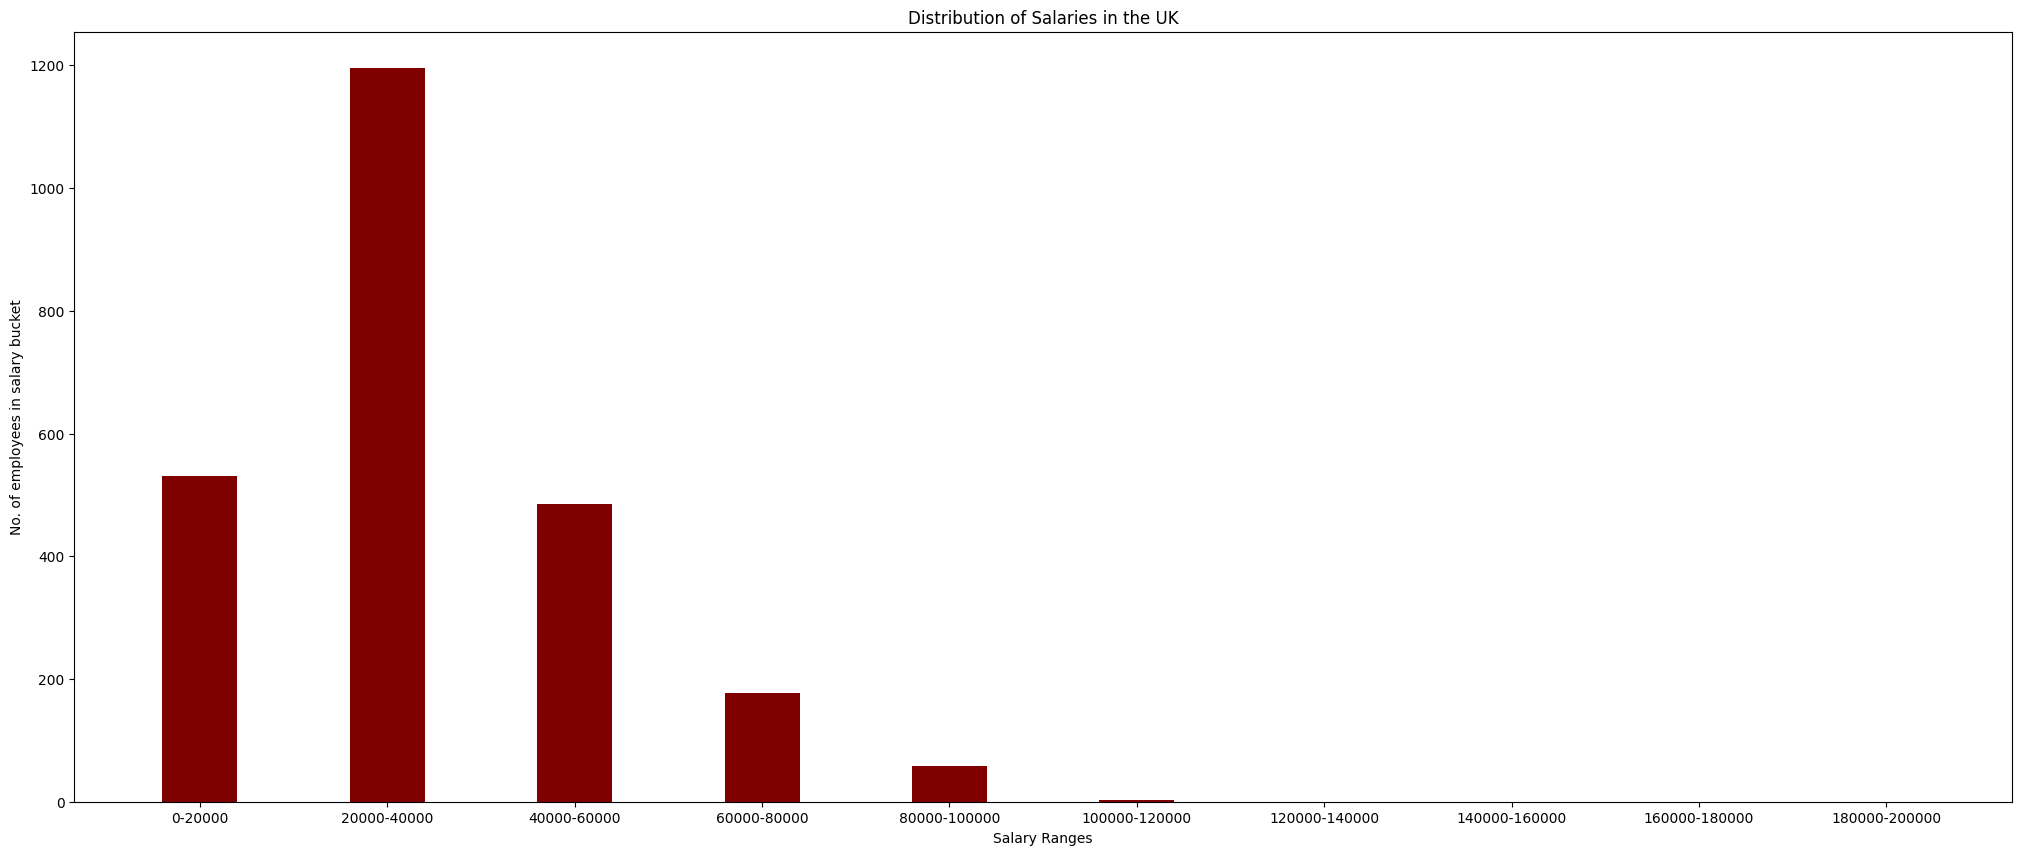

In [ ]:
%matplotlib inline

plt = histogram_freq_preprocessed(0, 200000, 20000, 'SalaryNormalized', 25, 10)
plt.xlabel("Salary Ranges")
plt.ylabel("No. of employees in salary bucket")
plt.title("Distribution of Salaries in the UK")
plt.show()

Shows the amount of companies there are. In summary there are 20812 companies, 2732 location, 3 contract types, 3 contract times, 29 job categories, and 1 output label. This is including null values for each feature and label.

In [ ]:
df.sort_values('Company',ascending=False)

,LocationNormalized,Company,SalaryNormalized,ContractType_Unknown,ContractType_full_time,ContractType_part_time,ContractTime_Unknown,ContractTime_contract,ContractTime_permanent,Category_Accounting & Finance Jobs,...,"Category_PR, Advertising & Marketing Jobs",Category_Part time Jobs,Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Social work Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,Category_Travel Jobs
180220,26,20770,16320,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242705,2448,20637,45000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
147222,2448,20632,15500,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
84806,2448,20618,70000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7321,2448,20617,22000,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66188,1395,42,17280,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
136790,2448,28,25000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
206937,89,14,30000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
151413,241,8,30000,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


Shows how many null values were given in the data. note: if using a random percentage of data, this will show the random data choosen.

In [ ]:
df_raw.isna().sum()

Id                       0
Title                    0
FullDescription          0
LocationRaw              0
LocationNormalized       0
ContractType          1797
ContractTime           643
Company                310
Category                 0
SalaryRaw                0
SalaryNormalized         0
SourceName               0
dtype: int64

Stacked bar chart of job salary with contract type as categories

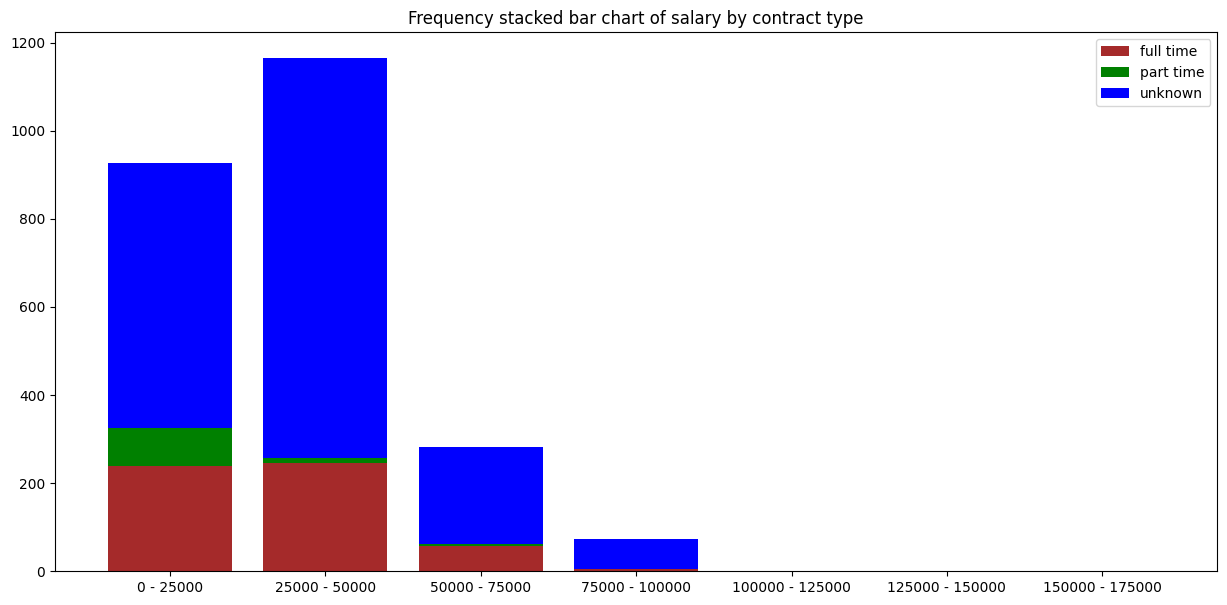

In [ ]:
categories_names = ['ContractType_full_time', 'ContractType_part_time', 'ContractType_Unknown']
salary_values_filter = []
x = []
sal_iter_val = 25000
fig = plt.figure(figsize = (15, 7))

#explain
for i in range(0, 175000, sal_iter_val):
    temp_list_cur_sal = []
    name_start = str(i)
    name_end = str(i + sal_iter_val)
    name = name_start + ' - ' + name_end
    x.append(name)
    for j in categories_names:
        temp_list_cur_sal.append(df[(df[j] == 1) & (df['SalaryNormalized'] > i) & (df['SalaryNormalized'] <= (i + sal_iter_val))].shape[0])

    salary_values_filter.append(temp_list_cur_sal)

#explain
y_lists = []
for i in range(0, 3, 1):#3 for the amount of categories
    temp_list = []
    for j in range(0, len(salary_values_filter), 1): #the amount of bars
        temp_list.append(salary_values_filter[j][i])
    temp_list = np.array(temp_list)
    y_lists.append(temp_list)
    if (i == 0):
        plt.bar(x, temp_list, color='brown')
    elif(i == 1):
        plt.bar(x, temp_list, bottom=y_lists[0], color='green')
    elif(i == 2):
        plt.bar(x, temp_list, bottom=y_lists[0]+y_lists[1],color='blue')

plt.title("Frequency stacked bar chart of salary by contract type")
plt.legend(["full time", "part time", "unknown"])

plt.show()

Stacked bar chart of job salary with contract time as categories

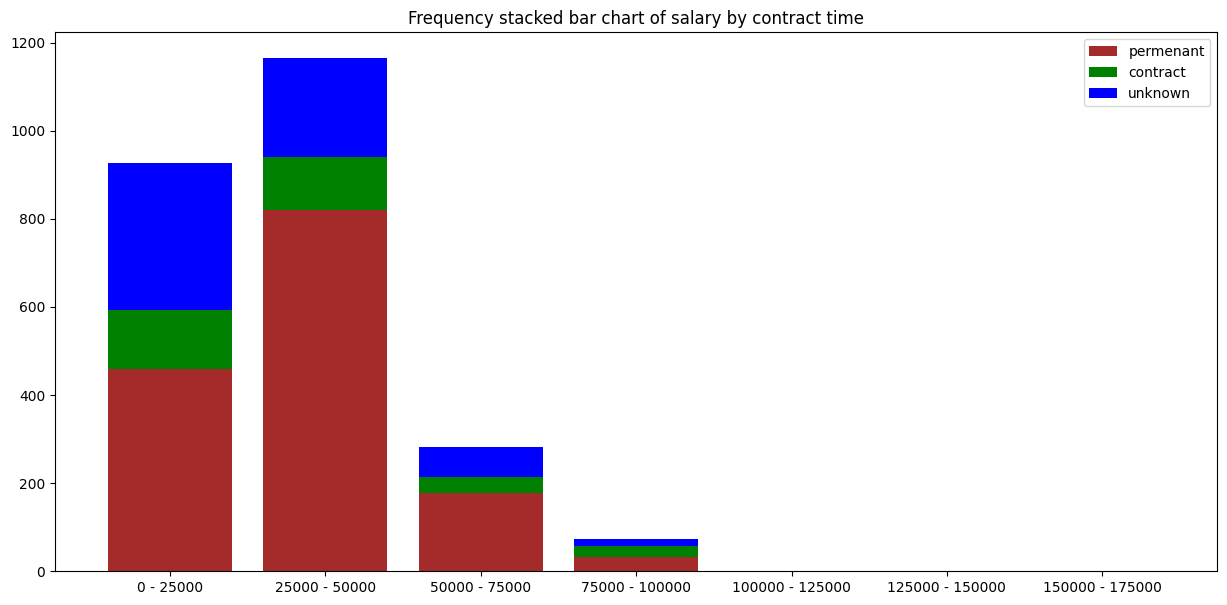

In [ ]:
categories_names = ['ContractTime_permanent', 'ContractTime_contract', 'ContractTime_Unknown']
salary_values_filter = []
x = []
sal_iter_val = 25000
fig = plt.figure(figsize = (15, 7))

#explain
for i in range(0, 175000, sal_iter_val):
    temp_list_cur_sal = []
    name_start = str(i)
    name_end = str(i + sal_iter_val)
    name = name_start + ' - ' + name_end
    x.append(name)
    for j in categories_names:
        temp_list_cur_sal.append(df[(df[j] == 1) & (df['SalaryNormalized'] > i) & (df['SalaryNormalized'] <= (i + sal_iter_val))].shape[0])

    salary_values_filter.append(temp_list_cur_sal)

#explain
y_lists = []
for i in range(0, 3, 1):#3 for the amount of categories
    temp_list = []
    for j in range(0, len(salary_values_filter), 1): #the amount of bars
        temp_list.append(salary_values_filter[j][i])
    temp_list = np.array(temp_list)
    y_lists.append(temp_list)
    if (i == 0):
        plt.bar(x, temp_list, color='brown')
    elif(i == 1):
        plt.bar(x, temp_list, bottom=y_lists[0], color='green') #bottom isn't correct
    elif(i == 2):
        plt.bar(x, temp_list, bottom=y_lists[0]+y_lists[1],color='blue')

plt.title("Frequency stacked bar chart of salary by contract time")
plt.legend(["permenant", "contract", "unknown"])

plt.show()

## split df into training & testing set

In [ ]:
from sklearn.preprocessing import scale

y = df['SalaryNormalized']
X = df.drop(['SalaryNormalized'], axis=1)
test_size = 0.25
train_size = (1-test_size)

# use following train test split code for (method A & C)

X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=6)



# use following train test split code for (method B)
# using sklearn's train_test_split() may crash the runtime
# no enough memory

# X_train = X[:int(len(X)*train_size)]
# X_test = X[int(len(X)*train_size):]
# y_train = y[:int(len(X)*train_size)]
# y_test = y[int(len(X)*train_size):]

# del df
# del X
# del y
# gc.collect()


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(1836, 36)
(1836,)
(612, 36)
(612,)


## Testing with ANN (method A & C)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'solver' : ['lbfgs', 'sgd', 'adam'],
    'hidden_layer_sizes': [(i,) for i in range(10,31)]
}]

print(f'{param_grid = }')

my_ANN = MLPRegressor(random_state=1, learning_rate_init = 0.02,
                       alpha=1, tol=0.0001, max_iter=1000)

clf = GridSearchCV(my_ANN, param_grid, cv=10)

clf.fit(X,y)

print(f'best_params_ = {clf.best_params_}')
print(f'best_score_ = {clf.best_score_}')

y_predict = clf.best_estimator_.predict(X_test)

mae, rmse = calc_mae_rmse(y_test, y_predict)

print(f'{mae = }')
print(f'{rmse = }')

# without grid search (entire dataset)
# mae = 11342.996801290945

# with grid search (entire dataset)
# best_params_ = {'activation': 'logistic', 'hidden_layer_sizes': (24,), 'solver': 'lbfgs'}
# best_score_ = 0.07360554649505337
# mae = 8696.053184641412
# rmse = 12285.3498549981

# with grid search (1% of dataset)
# took 2.5 hr
# best_params_ = {'activation': 'relu', 'hidden_layer_sizes': (16,), 'solver': 'lbfgs'}
# best_score_ = 0.1655465126071952
# mae = 10865.416777289183
# rmse = 15635.96301847022

param_grid = [{'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'hidden_layer_sizes': [(10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,)]}]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/l

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.scatter(y_test, y_predict, color='yellow')
plt.title('Prediction Error for ANN')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=1, color='blue')

## Testing with RandomForest (method A & C)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

n_estimators = 100
my_RandomForest = RandomForestRegressor(n_estimators=n_estimators, bootstrap=True, random_state=2)

my_RandomForest.fit(X_train, y_train)

y_predict = my_RandomForest.predict(X_test)
mae, rmse = calc_mae_rmse(y_test, y_predict)

print(f'{mae = }')
print(f'{rmse = }')

# mae (with entire dataset): 9676
# mae (with 1% dataset): 11377.603810363424
# rmse (with 1% dataset): 15268.0798479588

# with 1% of dataset
# mae = 11574.227124832947
# rmse = 15771.906775737942

# with 10% of dataset
# mae = 11136.752862944722
# rmse = 15749.519785075481

# with 25% of dataset
# mae = 10587.662668040753
# rmse = 14820.167900817294

mae = 12408.932819578706
rmse = 16365.925737995432


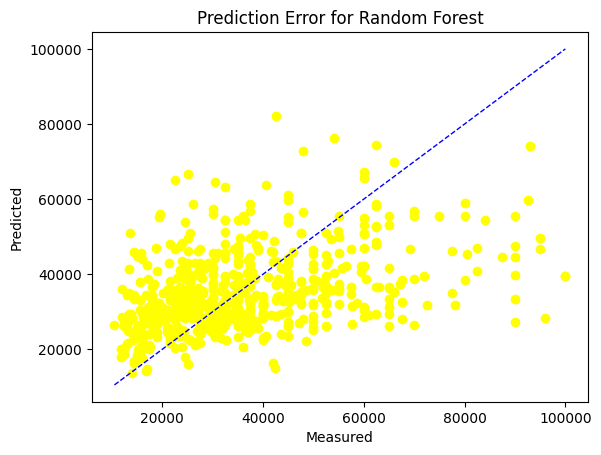

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.scatter(y_test, y_predict, color='yellow')
plt.title('Prediction Error for Random Forest')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=1, color='blue')

## Testing with AdaBoost (method A & C)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

my_AdaBoost = AdaBoostRegressor(n_estimators = 29,random_state=2)

my_AdaBoost.fit(X_train, y_train)

y_predict = my_AdaBoost.predict(X_test)

mae, rmse = calc_mae_rmse(y_test, y_predict)

print(f'{mae = }')
print(f'{rmse = }')

# with 1% of dataset
# mae = 18787.231884168916
# rmse = 21896.202600384382

# with 10% of dataset
# mae = 18092.983778355738
# rmse = 21128.478138030336

# with 25% of dataset
# mae = 18100.173443542844
# rmse = 21031.304750530686

mae = 19035.39055552928
rmse = 21525.053601151027


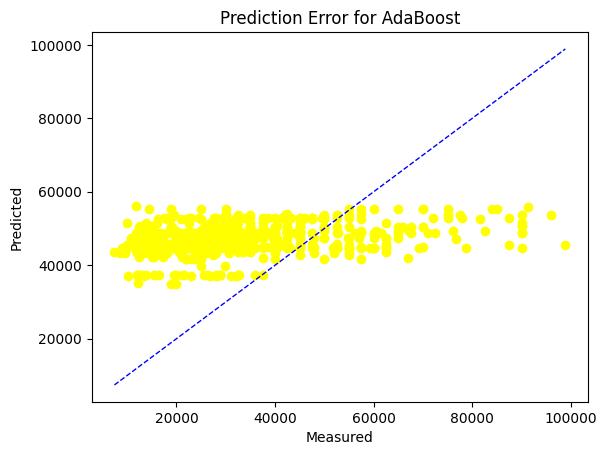

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.scatter(y_test, y_predict, color='yellow')
plt.title('Prediction Error for AdaBoost')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=1, color='blue')

## Testing with LinearRegression (method B & C)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
import numpy as np


my_linreg = LinearRegression()
my_linreg.fit(X_train, y_train)

y_predict_my_LR = my_linreg.predict(X_test)

mae, rmse = calc_mae_rmse(y_test, y_predict_my_LR)

#using method 3 rsme = 14750.357055284472

print(f'{mae = }')
print(f'{rmse = }')

# with 1% of dataset
# mae = 12327.391083140434
# rmse = 16452.989615108476

# with 10% of dataset
# mae = 11982.433731424653
# rmse = 16146.913684891697

# with 25% of dataset
# mae = 12037.807052975542
# rmse = 16052.692502634727

mae = 12235.039664506294
rmse = 15908.374465016901


Linear Regression 10-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
my_linreg = LinearRegression()

mse_list = cross_val_score(my_linreg, X, y, cv=10, scoring='neg_mean_squared_error')
mse_list_positive = -mse_list

# using numpy sqrt function to calculate rmse:
rmse_list = np.sqrt(mse_list_positive)
print(rmse_list)

# calculate the average RMSE as final result of cross validation:
print(rmse_list.mean()) #with method 3 rsme = 15887.34031122757

[15675.74379487 16885.08681661 18208.81376864 16411.04025467
 16447.25730875 17875.47599992 15480.75676435 16035.0075446
 17972.17738325 16034.19332465]
16702.55529602995


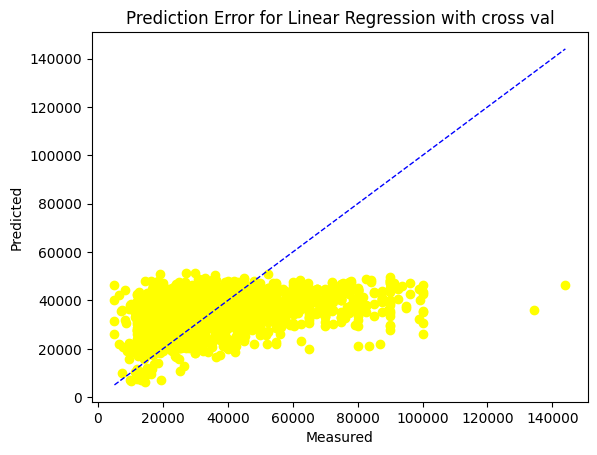

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

my_linreg = LinearRegression()

mse_list = cross_val_predict(my_linreg, X, y, cv=10)

%matplotlib inline
plt.scatter(y, mse_list, color='yellow')
plt.title('Prediction Error for Linear Regression with cross val')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle='--', lw=1, color='blue')

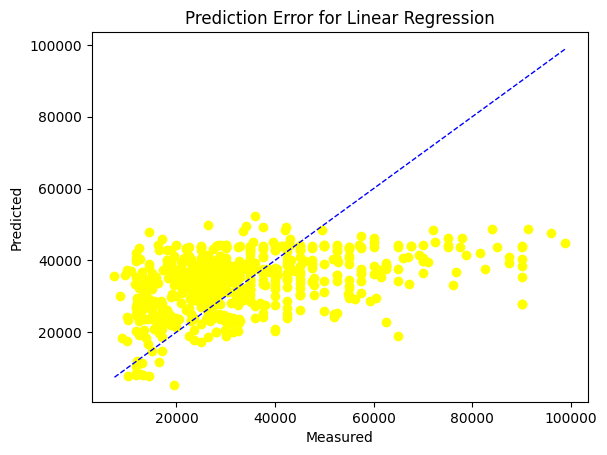

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.scatter(y_test, y_predict_my_LR, color='yellow')
plt.title('Prediction Error for Linear Regression')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=1, color='blue')

## Testing with Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

my_DecisionTree = DecisionTreeRegressor(random_state=2)
my_DecisionTree.fit(X_train, y_train)

y_predict_my_DT = my_DecisionTree.predict(X_test)
# print(y_predict_my_DT)

# accuracy = mean_absolute_error(y_test, y_predict_my_DT)
# print(accuracy)

mae, rmse = calc_mae_rmse(y_test, y_predict_my_DT)

print(f'{mae = }')
print(f'{rmse = }')

# with entire dataset
# mae = 9567.659902590061
# rmse = 14308.9180004131

# with 1% of dataset
# mae = 13693.710920479301
# rmse = 19033.858759613046

# with 10% of dataset
# mae = 13317.289307892595
# rmse = 19267.528121616437

# with 25% of dataset
# mae = 12210.771197242018
# rmse = 17556.654492421974

mae = 16154.237330316742
rmse = 22561.935809532228


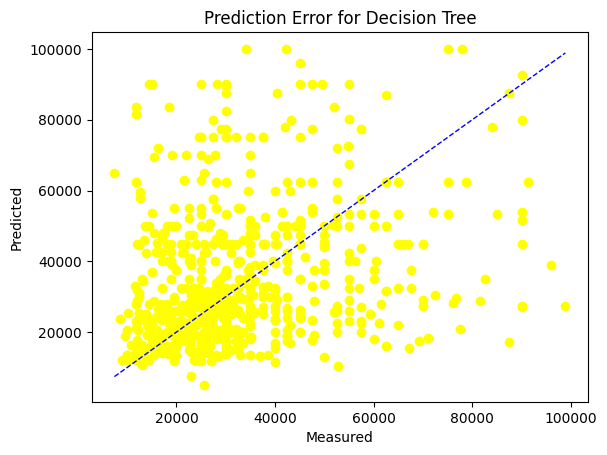

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.scatter(y_test, y_predict_my_DT, color='yellow')
plt.title('Prediction Error for Decision Tree')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=1, color='blue')

## Testing with LogisticRegression (method C):

In [ ]:
from sklearn.linear_model import LogisticRegression

my_logreg = LogisticRegression(max_iter = 10000)
my_logreg.fit(X_train, y_train)

y_predict = my_logreg.predict(X_test)

mae, rmse = calc_mae_rmse(y_test, y_predict)

print(f'{mae = }')
print(f'{rmse = }')


# with entire dataset
# mae = 9291.116013071896
# rmse = 14820.2504312434

# with 1% of dataset
# mae = 14092.088235294117
# rmse = 20154.095018134652

# with 10% of dataset
# mae = 12666.677287581699
# rmse = 18051.68949987332

# with 25% of dataset
# mae = 12418.523532487907
# rmse = 17697.160626107194

mae = 12905.877450980392
rmse = 17706.453756536146


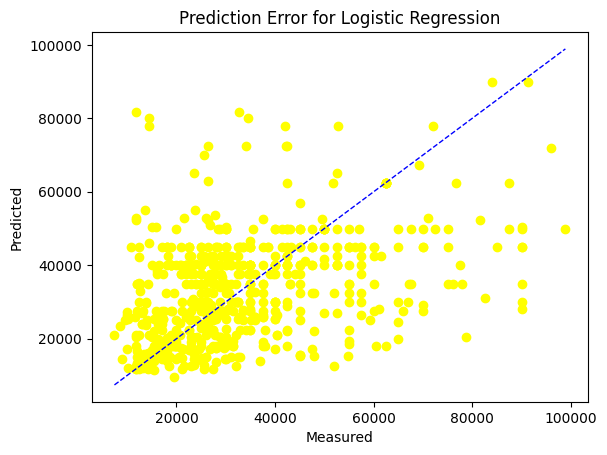

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.scatter(y_test, y_predict, color='yellow')
plt.title('Prediction Error for Logistic Regression')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=1, color='blue')

## Testing with SupportVector Regression (method C):

In [ ]:
# training
from sklearn.svm import SVR
my_SVR = SVR(kernel = 'rbf')
my_SVR.fit(X_train, y_train)
y_predict = my_SVR.predict(X_test)

mae, rmse = calc_mae_rmse(y_test, y_predict)

print(f'{mae = }')
print(f'{rmse = }')

# with entire dataset
# mae = 12287.120535787208
# rmse = 17415.695778206886

# with 1% of dataset
# mae = 13563.269484548588
# rmse = 18469.17251883069

# with 10% of dataset
# mae = 12771.362663428588
# rmse = 17970.324501622283

# with 25% dataset
# mae = 12744.755854798581
# rmse = 17719.122199633213

mae = 13099.930919544408
rmse = 17855.15214145241


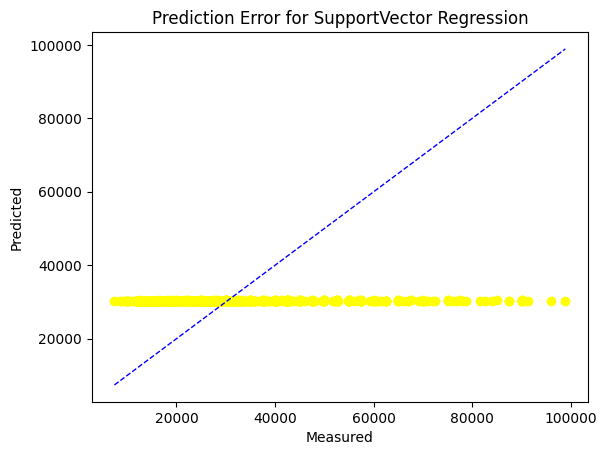

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.scatter(y_test, y_predict, color='yellow')
plt.title('Prediction Error for SupportVector Regression')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=1, color='blue')